In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
#import seaborn as sn
import pandas as pd
from collections import OrderedDict
import json
#from ensemble_boxes import *
import copy
import math

#from sahi.model import MmdetDetectionModel
#from sahi.predict import get_prediction, get_sliced_prediction, predict


In [2]:
#config_file = '../configs/detectors/dent_detector_latest_segm.py'
#checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'

#config_file = '../models/loose/loose.py'
#checkpoint_file = '../models/loose/epoch_9.pth'

#config_file = '../models/crack_mosaic/crack_mosaic.py'
#checkpoint_file = '../models/crack_mosaic/epoch_7.pth'

#config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
#checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'

#dent pseudo
#config_file = '../models/dent_pseudo/dent_pseudo.py'
#checkpoint_file = '../models/dent_pseudo/epoch_9.pth'

#scratch pseudo
#config_file = '../models/scratch_pseudo/scratch_pseudo.py'
#checkpoint_file = '../models/scratch_pseudo/epoch_9.pth'

#scratch pseudo brightness
#config_file = '../models/scratch_pseudo_brightness/scratch_pseudo.py'
#checkpoint_file = '../models/scratch_pseudo_brightness/epoch_9.pth'

#dent pseudo brightness augment
#config_file = '../models/dent_pseudo_brightness/dent_pseudo.py'
#checkpoint_file = '../models/dent_pseudo_brightness/epoch_9.pth'

#config_file = '../models/crack_mosaic/crack_mosaic.py'
#checkpoint_file = '..//models/missing_model2/epoch_11.pth'

#config_file = '../models/mmd_pseudo_model_15_7/dent/dent_pseudo.py' 
#checkpoint_file = '../models/mmd_pseudo_model_15_7/dent/epoch_9.pth'

#config_file = '../work_dirs/dent_merimen/dent_merimen.py' 
#checkpoint_file = '../models/cbnet/dent_1_1/epoch_25.pth'

config_file = '../checkpoints/06_04_2022/scratch/scratch_merimen.py' 
checkpoint_file = '../checkpoints/06_04_2022/scratch/cbn_clean_scratch_Merimen.pth'

#config_file = '../checkpoints/combine_crack_phase_1/combine_crack.py' 
#checkpoint_file = '../checkpoints/combine_crack_phase_1/epoch_28.pth'

In [3]:
model = init_detector(config_file, checkpoint_file, device='cuda:1')
'''
sahi_model = MmdetDetectionModel(
    model_path=checkpoint_file,
    config_path=config_file,
    confidence_threshold=0.5,
    device="cuda:1", # or 'cuda:0'
)

'''

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


'\nsahi_model = MmdetDetectionModel(\n    model_path=checkpoint_file,\n    config_path=config_file,\n    confidence_threshold=0.5,\n    device="cuda:1", # or \'cuda:0\'\n)\n\n'

In [4]:
#path = Path('../data/generali/dent')
path = Path('../data/scratch')

In [5]:
test = json.load(open(path/'annotations'/'test.json'))
#test = json.load(open('test.json'))
print(test['info'])
print(len(test['images']),len(test['annotations']))
#print(test.keys())
#print(test['annotations'][0])
#print(test['images'][0])
#print(test['categories'])

{'description': 'Car Parts Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2017, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
3775 19453


In [6]:
total_yolo_bboxes = json.load(open('yolo_test_deploy_scratch_1408_thres_025.json'))

{'id': 11083, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'scalabel_url': 'https://s3.amazonaws.com/mc-ai/vn_car/thinh_anh_3_luu_tru/boi%20thuong%20thang%209/HT%2014A%20-%20138.99%20-%2025.09.2018/z1123978942787_defcf41b41cc4e11dca160bc5b250072.jpg', 'width': 1280, 'height': 960, 'file_name': 'https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20138.99%20-%2025.09.2018_z1123978942787_defcf41b41cc4e11dca160bc5b250072.jpg', 'date_captured': '2013-12-15 02:41:52'}
[0.876797   0.84397274 0.7126026 ]
[[(280, 445), (294, 494)], [(137, 298), (154, 314)], [(571, 283), (591, 327)]]


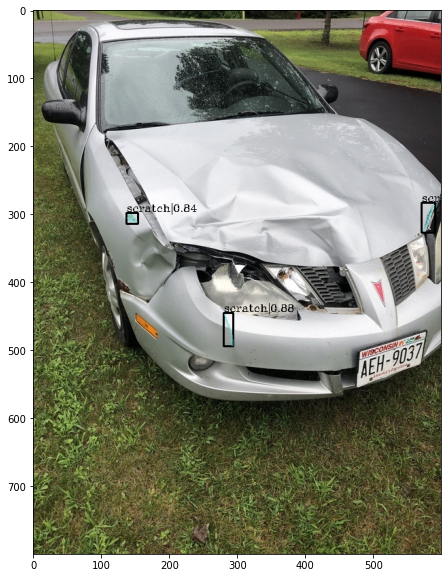

In [43]:
img = cv2.imread(str(path/'images'/test['images'][2]['file_name']))
print(test['images'][1])
h,w,_ = img.shape
#img = img[:int(h/2),:int(w/2)]
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
#img_ = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
print(scores)
plt.figure(figsize=(10,10))
plt.imshow(img_)
print(pred_boxes)

[108.78066630071726, 351.49323729526077, 13.741993385178304, 29.865416489858546]
[558.8947562954727, 283.62814541663636, 33.05226029179471, 52.792479501322816]
[138.4458613457801, 299.5633939455001, 14.804725217736632, 14.742780760758649]


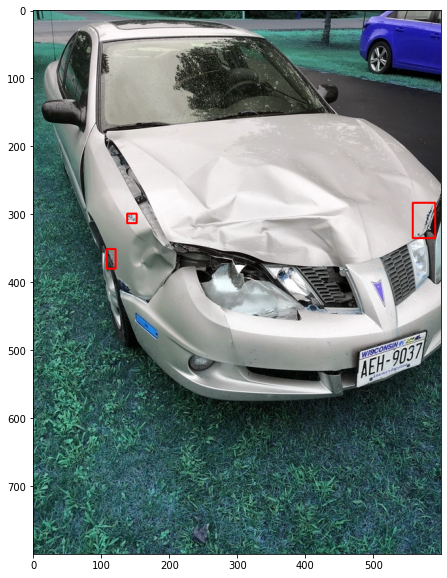

In [41]:
i = test['images'][2]
annos = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
#annos = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in annos]
img = cv2.imread(str(path/'images'/test['images'][2]['file_name']))

img_ = img.copy()
for pred in annos :
    bbox = pred
    print(bbox)
    cv2.rectangle(img_,(int(bbox[0]),int(bbox[1])),(int(bbox[0])+int(bbox[2]),int(bbox[1])+int(bbox[3])),(255,0,0),2)
    #cv2.putText(img, str(round(pred['score'],2)), (bbox[0],bbox[1]+bbox[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
plt.figure(figsize=(10,10))
plt.imshow(img_)

Performing prediction on 9 number of slices.
[{'image_id': None, 'bbox': [281, 447, 13, 46], 'score': 0.9243357181549072, 'category_id': 0, 'category_name': 'scratch', 'segmentation': [[281, 447, 281, 451, 282, 452, 282, 454, 283, 455, 283, 457, 284, 458, 284, 459, 285, 460, 285, 462, 286, 463, 286, 464, 287, 465, 287, 468, 288, 469, 288, 470, 289, 471, 289, 474, 290, 475, 290, 478, 291, 479, 291, 492, 292, 493, 294, 493, 294, 479, 293, 478, 293, 475, 292, 474, 292, 472, 291, 471, 291, 469, 290, 468, 290, 466, 289, 465, 289, 463, 288, 462, 288, 461, 287, 460, 287, 459, 286, 458, 286, 456, 285, 455, 285, 453, 284, 452, 284, 450, 283, 449, 283, 448, 282, 447]], 'iscrowd': 0, 'area': 128}, {'image_id': None, 'bbox': [563, 286, 27, 46], 'score': 0.8530747890472412, 'category_id': 0, 'category_name': 'scratch', 'segmentation': [[588, 286, 585, 289, 585, 290, 583, 292, 583, 293, 582, 294, 582, 295, 581, 296, 581, 297, 580, 298, 580, 299, 579, 300, 579, 303, 578, 304, 578, 308, 577, 309, 577,

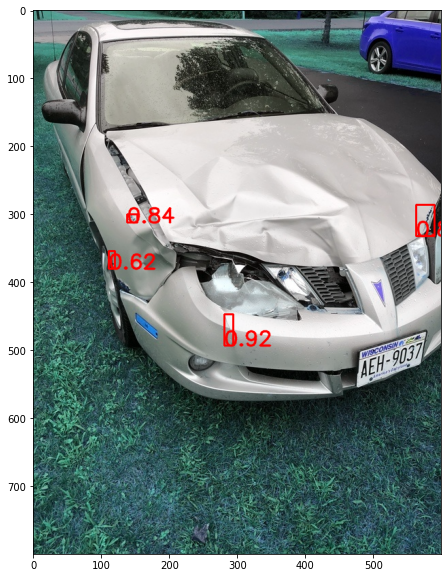

In [47]:
img = cv2.imread(str(path/'images'/test['images'][2]['file_name']))

result = get_sliced_prediction(
    str(path/'images'/test['images'][2]['file_name']),
    sahi_model,
    slice_height = int(h/2),
    slice_width = int(w/2),
    overlap_height_ratio = 0.5,
    overlap_width_ratio = 0.5
)
preds = result.to_coco_predictions()
print(preds)
for pred in preds :
    bbox = pred['bbox']
    print(bbox,pred['score'])
    cv2.rectangle(img,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[1]+bbox[3]),(255,0,0),2)
    cv2.putText(img, str(round(pred['score'],2)), (bbox[0],bbox[1]+bbox[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
plt.figure(figsize=(10,10))
plt.imshow(img)

In [10]:
#sample = plot_annos(629)
#plt.imshow(sample)

In [ ]:
img = cv2.imread(str(path/'images'/'https:__s3.amazonaws.com_mc-imt_vehicle_2020C3465_front_right_view_40662_medium_image.jpg'))
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img)
print(pred_boxes,scores)

In [7]:
def normolize_box(boxes,height,width):
    new_boxes = []
    #print(boxes)
    #boxes.pop()
    #boxes = [[boxes[0],boxes[1]],[boxes[2],boxes[3]]]
    for b in boxes:
        new_b = []
        #b = [[b[0],b[1]],[b[2],b[3]]]
        for p in b:
            new_b.extend(np.array(p)/(width,height))
        new_boxes.append(new_b)
    #print(new_boxes)
    return new_boxes

def get_data_box_ensemble(img,idx,name,boxes,segms,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    #print(boxes)
    i_boxes = total_yolo_bboxes[str(idx)]['boxes']
    yolo_boxes = copy.deepcopy(i_boxes)
    h,w = img.shape[:2]
    for j in range(len(yolo_boxes)):
        yolo_boxes[j][0] = int(yolo_boxes[j][0]*w)
        yolo_boxes[j][1] = int(yolo_boxes[j][1]*h)
        yolo_boxes[j][2] = int(yolo_boxes[j][2]*w)
        yolo_boxes[j][3] = int(yolo_boxes[j][3]*h)
        yolo_boxes[j] = [(yolo_boxes[j][0],yolo_boxes[j][1]),(yolo_boxes[j][2],yolo_boxes[j][3])] 
    #print(yolo_boxes)
    check_boxes = [0 for i in yolo_boxes]
    check_pred = [0 for i in boxes]
    out_boxes = []
    out_fp_boxes = []
    for i,b in enumerate(boxes):
        ious = [cal_iou(img,b,j) for j,check in zip(yolo_boxes,check_boxes) if check == 0]
        
        if len(ious) == 0:
            break
        max_id = np.argmax(ious)
        wh = np.array(b[1]) - np.array(b[0])
        area = wh[0]*wh[1]
        
        #if area <= 96**2 and scores[i] < 0.35:
            #print('yo')
        #    continue
        
        if scores[i] > 0.95 : #or area > 284**2 : 
            out_boxes.append(b)
            check_boxes[max_id] = 1
            check_pred[i] = 1
            continue
        
        if ious[max_id] >= 0.25 : 
            out_boxes.append(b)
            check_boxes[max_id] = 1
            check_pred[i] = 1
        else:
            out_fp_boxes.append(b)
            check_pred[i] = -1
    #print('out:',out_boxes)
    data_box['boxes'] = normolize_box(out_boxes,*img.shape[:-1])
    
    '''
    segm_masks = []
    #print('check',segms.sum())
    for i,segm in enumerate(segms) :
        #if check_pred[i] == 0: # for fp only
        if check_pred[i] != 1 : 
            continue
        segm = segm.astype(np.uint8)
        contours, _ = cv2.findContours(segm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c.tolist() for c in contours]
        segm_masks.append(contours)
        
    data_box['segms'] = segm_masks
    '''
    data_box['labels'] = labels.tolist()
    #print('scores :',scores)
    #print('check :',check_pred)
    data_box['scores'] = [float(s) for s,c in zip(scores,check_pred) if c == 1]
    
    return data_box

def get_data_box(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    data_box['boxes'] = normolize_box(boxes,*img.shape[:-1])
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

def get_data_box_flip(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    
    boxes = normolize_box(boxes,*img.shape[:-1])
    for i in range(len(boxes)):
        boxes[i][0] = 1-boxes[i][0]
        boxes[i][2] = 1-boxes[i][2]
    data_box['boxes'] = boxes
    
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

In [10]:
data = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    data[i['id']] = get_data_box_ensemble(image,i['id'],i['file_name'],pred_boxes,pred_segms,pred_labels,pred_scores)
    #data[i['id']] = get_data_box(image,i['file_name'],pred_boxes,pred_labels,pred_scores)
    #break
#print(data) 
with open('scratch_cbn_yolo_06_04_ensemble_1408.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3775/3775 [26:37<00:00,  2.36it/s]


In [54]:
cp_info = json.load(open('scratch_carpart_num.json'))

In [ ]:
data = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    h,w,_ = image.shape
    num_cp = cp_info[i['file_name']]
    
    if num_cp >= 30: 
        result = get_sliced_prediction(
            str(path/'images'/i['file_name']),
            sahi_model,
            slice_height = int(h/2),
            slice_width = int(w/2),
            overlap_height_ratio = 0.5,
            overlap_width_ratio = 0.5
        )
        preds = result.to_coco_predictions()
        pred_boxes = []
        pred_labels = []
        pred_scores = []

        for pred in preds:
            box = pred['bbox']
            pred_boxes.append([(box[0],box[1]),(box[0]+box[2],box[1]+box[3])])
            pred_labels.append(pred['category_id'])
            pred_scores.append(pred['score'])
    else:
        result = inference_detector(model, image)
        img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    
    data[i['id']] = get_data_box_ensemble(image,i['id'],i['file_name'],pred_boxes,pred_segms,np.array(pred_labels),pred_scores)
    #data[i['id']] = get_data_box(image,i['file_name'],pred_boxes,pred_labels,pred_scores)
    #break
#print(data) 
with open('scratch_sahi_yolo_deploy_19_2_ensemble.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

In [36]:
data_flip = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    image = np.fliplr(image)
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    data_flip[i['id']] = get_data_box_flip(image,i['file_name'],pred_boxes,pred_labels,pred_scores)

with open('tta_cbn_flip.json', 'w', encoding='utf-8') as f:
    json.dump(data_flip, f, ensure_ascii=False, indent=4)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2252/2252 [10:32<00:00,  3.56it/s]


In [29]:
#pred_data = json.load(open('detector_pred.json'))
#
'''
#es = json.load(open('./merimen/yolo_pred_crack.json')) 
#yolo_pred.json
detector_pred
es = json.load(open('./yolo_pred.json'))
'''
pred_data = json.load(open('tta_cbn.json'))
pred_data_flip = json.load(open('tta_cbn_flip.json'))

In [30]:
def remove_ovelap(boxes):
    idx = [True for b in boxes]
    for i1 in range(len(boxes)-1) :
        for i2 in range(i1+1,len(boxes)):
            if idx[i1] == True and boxes[i1][0] < boxes[i2][0] and boxes[i1][1] < boxes[i2][1] and boxes[i1][2] > boxes[i2][2] and boxes[i1][3] > boxes[i2][3] :
                idx[i1] = False
                break
            
            if idx[i2] == True and boxes[i1][0] > boxes[i2][0] and boxes[i1][1] > boxes[i2][1] and boxes[i1][2] < boxes[i2][2] and boxes[i1][3] < boxes[i2][3] :
                idx[i2] = False
                continue
    return boxes[idx]
            
es = OrderedDict()
for i in test['images']:
    boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
    scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
    labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]
    
    if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = []
        i_data['labels'] = []
        i_data['scores'] = []
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[0]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[1]
        i_data['labels'] = labels_list[1]
        i_data['scores'] = scores_list[1]
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[1]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[0]
        i_data['labels'] = labels_list[0]
        i_data['scores'] = scores_list[0]
        es[str(i['id'])] = i_data
        continue
    
    weights = [2,1]
    iou_thr = 0.36
    skip_box_thr = 0.0001
    sigma = 0.1
    
    boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

    i_data = OrderedDict()
    i_data['name'] = i['file_name']
    i_data['boxes'] = boxes.tolist()
    i_data['labels'] = labels.tolist()
    i_data['scores'] = scores.tolist()
    es[str(i['id'])] = i_data
    #print(len([a for a in test['annotations'] if a['image_id']==i['id']]))
    #img = cv2.imread(str(path/'images'/i['file_name']))
    #plot(img,boxes,scores)
    #break
with open('tta.json', 'w', encoding='utf-8') as f:
    json.dump(es, f, ensure_ascii=False, indent=4)

In [31]:
tta = json.load(open('tta.json'))
data_tta = OrderedDict()
for k in tqdm(tta.keys()):
    img = cv2.imread(str(path/'images'/tta[k]['name']))
    
    boxes = tta[k]['boxes']
    h,w = img.shape[:2]
    
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])]
    #print(tta[k])
    data_tta[k] = get_data_box_ensemble(img,k,tta[k]['name'],boxes,None,tta[k]['labels'],tta[k]['scores'])
    
with open('tta_ensemble.json', 'w', encoding='utf-8') as f:
    json.dump(data_tta, f, ensure_ascii=False, indent=4)
    #print(tta[k])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2252/2252 [01:48<00:00, 20.69it/s]


In [9]:
def plot(idx, boxes):
    image = cv2.imread(str(path/'images'/es[str(idx)]['name']))
    img = image.copy()
    h,w, _ = img.shape
    for i in range(len(boxes)):
        img = cv2.rectangle(img,(int(boxes[i][0]*w),int(boxes[i][1]*h)),(int(boxes[i][2]*w),int(boxes[i][3]*h)),(255,255,0),2)
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['name']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,0,0),2)
    
    plt.figure(figsize=(20,10))
    plt.imshow(np.hstack((img,image)))
    #return np.hstack((img,image))

def plot_fp(idx,i_boxes):
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
    
    pred_labels = [0 for i in boxes]
    
    pred_tp = [0 for i in boxes]
    gt_tp = [0 for i in gt_boxes]
    
    for i in range(len(boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            #print(boxes[i],i_gt_boxes[j])
            iou = cal_iou(img,boxes[i],i_gt_boxes[j])
            if iou > 0.25:
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_labels[idx] = -1
                pred_tp[i] = 1
                gt_tp[idx] = 1
                break
    
    for i in range(len(pred_tp)):
        #print(i)
        #print(boxes[i][0])
        if pred_tp[i]:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2)
        else:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    
    #print(img_out.shape,img.shape)
    return np.hstack((img_out,img))

def plot_fp_v2(idx,i_boxes):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    #print('test : ',es[str(idx)]['image'],es[str(idx)]['scores'])
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth
    check_fp = False
    for i in range(len(boxes)):
        ious = [cal_iou(img,boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        _idx = np.argmax(ious)
        
        if gt_tp[_idx] == 1 :
            continue
        
        if ious[_idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[_idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            check_fp =True
            
    #if len([0 for i in pred_tp if i==1]) == 0 :
    #    return None,0
    if not check_fp :
        return None , 0
    # draw TP, FP, FN
    #print(pred_tp)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(pred_tp)):
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
            #print(es[str(idx)]['scores'],i)
            cv2.putText(img_out,"{:.2f}".format(es[str(idx)]['scores'][i]),boxes[i][0], font, 1,(255,255,0),2)
            
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
            cv2.putText(img_out,"{:.2f}".format(es[str(idx)]['scores'][i]),boxes[i][0], font, 1,(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            
    return np.hstack((img_out,img)), check_fp



def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    #return intersect.sum() / min(mask1.sum(),mask2.sum())
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_iou_mask(img,contour1,contour2):
    #print(contour1)
    #print(contour2)
    #print(img.shape[:2])
    mask1 = np.zeros(img.shape[:2])
    mask2 = np.zeros(img.shape[:2])
    #print(mask1.shape,mask2.shape)
    
    mask1 = cv2.fillPoly(mask1,contour1,1)
    mask2 = cv2.fillPoly(mask2,[contour2],1)
    
    plt.imshow(np.hstack([mask1,mask2]))
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())
    #pass

def cal(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name):
    tp = 0
    
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.25 :
                tp += 1
                idx = gt_boxes.index(i_gt_boxes[j])
                #gt_labels[idx] = -1
                break
            
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 

#global check_dense = 0
def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name,check_dense):
    fp = 0
    tp = 0
    fp_boxes = []
    tp_check = [0 for i in pred_boxes]
    
    for i in range(len(pred_boxes)):
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        
        if len(ious) == 0:
            return 0,0,0,fp_boxes,0,0
        
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
            tp_check[i] = 1
        else:
            if ious[idx] > 0 and cal_new_iou_min(img,pred_boxes[i],gt_boxes[idx]) > 0.8 and cal_new_iou_max(img,pred_boxes[i],gt_boxes[idx]) > 0.1:
                tp += 1
                gt_labels[idx] = -1
                tp_check[i] = 1
            else:
                fp += 1
                fp_boxes.append(pred_boxes[i])

    fn = len(gt_boxes) - tp
    
    if len(gt_boxes) >= 12 and tp/len(gt_boxes) > 0.6:
        check_dense += 1
        
        print('dense cases :',check_dense)
        fp = 0
    
    return tp,fp,fn, fp_boxes,check_dense, tp_check

In [16]:
def plot_fp_v2_with_segm(idx,i_boxes,i_segms):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    segms = copy.deepcopy(i_segms)
    for i,segm in enumerate(segms):
        segms[i] = [np.array(s).astype(np.int32) for s in segms[i]]
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth

    for i in range(len(boxes)):
        #print([(boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))])
        if len(gt_boxes)==0:
            pred_tp = [-1 for i in boxes]
            break
        ious = [cal_iou_mask(img,segms[i],gt_segms[j]) for j in range(len(gt_boxes))]
        idx = np.argmax(ious)
        
        if gt_tp[idx] == 1 :
            continue
        
        if ious[idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            
    
    # draw TP, FP, FN
    #print(pred_tp)
    for i in range(len(pred_tp)):
        #print(segms[i])
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
            img_out = cv2.drawContours(img_out,segms[i],-1,(255,255,0),2)
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
            img_out = cv2.drawContours(img_out,segms[i],-1,(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(255,255,0),2)
        else:
            #print(gt_segms[i])
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(0,0,255),2)
            
    return np.hstack((img_out,img))

In [11]:
#es = json.load(open('./merimen/yolo_pred_crack.json')) 
#yolo_pred.json
es = json.load(open('scratch_cbn_yolo_06_04_ensemble_1408.json')) 
total_tp = 0
total_fn = 0
total_fp = 0
#c = 0
#for i in es.keys():
#    c += len(es[i]['scores'])
#print(c)
fp_cases = OrderedDict()
check_dense = 0
count_gt = 0
for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    h,w,_=image.shape
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    count_gt += len(gt_boxes)
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    #gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]    
    gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
    
    
    pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
    for j in range(len(pred_boxes)):
        pred_boxes[j][0] = int(pred_boxes[j][0]*w)
        pred_boxes[j][1] = int(pred_boxes[j][1]*h)
        pred_boxes[j][2] = int(pred_boxes[j][2]*w)
        pred_boxes[j][3] = int(pred_boxes[j][3]*h)
        
        pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
    
    #pred_segms = copy.deepcopy(es[str(i['id'])]['segms'])
    #for idx,segm in enumerate(pred_segms):
    #    pred_segms[idx] = [np.array(s).astype(np.int32) for s in pred_segms[idx]]
    
    #print(i['id'])
    #print(es[str(i['id'])])
    pred_labels = es[str(i['id'])]['labels']
    
    print(i['id'],i['file_name'])
    old_check = check_dense
    tp,fp,fn, fp_boxes,check_dense, tp_check = cal_v2(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'],old_check)
    #tp,fp,fn, fp_boxes = cal_v2(image,pred_segms,pred_labels,gt_segms,gt_labels, i['file_name'])
    #if check_dense - old_check == 1:
    #    dense_path = Path('dense_scratch')
    #    dense_path.mkdir(parents=True,exist_ok=True)
    #    idx = i['id']
    #    out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])
    #    cv2.imwrite(str(dense_path/(str(idx)+'.jpg')),out)
    es[str(i['id'])]['tp_check'] = tp_check
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    if len(fp_boxes) > 0:
        fp_cases[i['file_name']] = fp_boxes
    
    
    print(tp,fp,fn)
    #break
    #print(pred_boxes)
    #break 1439 1 0 0
print(total_tp,total_fp,total_fn,check_dense,count_gt)
#with open('new_and_ensemble_scratch_off', 'w', encoding='utf-8') as f:
#    json.dump(es, f, ensure_ascii=False, indent=4)

  0%|▏                                                                                                                                                              | 4/3775 [00:00<02:06, 29.86it/s]

2021 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7149_vehicle_additional_docs_21749_medium_15559750008971833159462424792505.jpg
1 1 1
11083 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20138.99%20-%2025.09.2018_z1123978942787_defcf41b41cc4e11dca160bc5b250072.jpg
1 0 0
2596 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0145_front_left_view_29182_medium_1132205F-80EF-4FD0-875F-FA964C03435B.jpeg
1 2 2
12766 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20292.32%20-%2003.10.2018_z1132025237064_64536bf7b9a46c691b726714f229407a.jpg
1 1 2
18139 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_196_IMG-20180904-WA0038.jpg


  0%|▏                                                                                                                                                              | 5/3775 [00:00<12:32,  5.01it/s]

6 0 14
6217 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915410_img3187124.jpg


  0%|▍                                                                                                                                                             | 10/3775 [00:01<09:58,  6.29it/s]

2 0 1
1664 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4205_vehicle_additional_docs_41656_medium_70070684-3CF6-4108-BEAD-2064BEF616E9.jpeg
1 0 1
7754 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906631_img2922214.jpg
1 0 1
9829 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TD%2014A%20-%20086.15%20-%2001.07.2018_z1037954890617_6f9b05cdd75734c337e6e5dbead0203e.jpg
0 1 1
8081 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903640.jpg
1 1 0
16683 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1285_100_3917.JPG


  0%|▋                                                                                                                                                             | 15/3775 [00:02<12:39,  4.95it/s]

5 0 6
4351 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_rear_left_view_32925_medium_931E2332-47B9-4350-A074-803139A15108.jpeg
1 0 1
4901 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8534_detail_damage1_22956_medium_image.jpg
2 0 0
8356 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817675_img2056811.jpg
1 0 0
6359 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907572_img2948975.jpg
2 0 1
9990 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_a9bbf1e09a91dd776f99c7a054a7911c.JPG
0 0 6
4872 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3921_detail_damage2_31102_medium_IMG_20191009_172732858.jpg


  0%|▊                                                                                                                                                             | 18/3775 [00:02<10:17,  6.09it/s]

2 2 2
21301 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_803_IMG_4563.JPG
dense cases : 1
9 0 5
18341 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_249_IMG-20181129-WA0027.jpg


  1%|▊                                                                                                                                                             | 20/3775 [00:02<08:41,  7.20it/s]

3 0 3
12175 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_NA%2014C%20-%20216.74%20-%2009.04.2018_14C%20-%20216.74_z955799903558_38a0435ff35111a6c54f9f695e4a3fdf.jpg
1 1 2
4885 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8767_detail_damage1_22881_medium_image.jpg
1 1 1
2846 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2726_rear_right_view_51071_medium_image.jpg
1 1 2
7660 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000005_316292866_DSCF8616.JPG
2 0 0


  1%|█                                                                                                                                                             | 24/3775 [00:03<08:01,  7.79it/s]

17334 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_6_DSCN9483.JPG
2 0 0
14303 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1896_detail_damage2_18558_medium_image.jpg
1 0 0
21783 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_889_IMG_3149.JPG


  1%|█▏                                                                                                                                                            | 27/3775 [00:03<06:19,  9.88it/s]

2 0 2
18445 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_282_IMG-20181212-WA0046.jpg
2 0 0
22097 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_37c68c8a2526fd937267d863d8b50d529509583b.jpg
0 0 2
15188 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_993_IMG_20180806_174411.jpg
0 1 1
11556 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_fe28ab34e8c09447ae84425e523e115d.JPG


  1%|█▍                                                                                                                                                            | 33/3775 [00:05<14:45,  4.23it/s]

7 2 21
20103 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_591_IMG_3118.JPG
1 0 0
20893 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_731_IMG_3330.JPG
2 0 0
7396 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901385_img2899401.jpg
3 1 16
21789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1255.JPG
0 2 1
20197 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_608_TimePhoto_20180508_161027.jpg


  1%|█▋                                                                                                                                                            | 40/3775 [00:06<08:20,  7.47it/s]

3 0 2
9961 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20066.66%20-%2006.09.2018_z1106724030414_a2579d81067873e7289e14005174235c.jpg
3 0 3
21356 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_813_IMG_0372.JPG
2 0 1
1908 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8447_vehicle_additional_docs_33288_medium_0A975B57-C76C-4922-9FA5-1BCC66C9F2E8.jpeg
2 0 0
2226 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4338_front_left_view_p3-32.jpg
1 0 0
7868 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900578_img2793817.jpg
0 1 1
5018 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7568_detail_damage2_22053_medium_15563050845167329424675929348784.jpg
2 0 2


  1%|█▉                                                                                                                                                            | 45/3775 [00:06<06:12, 10.01it/s]

10646 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629635744_df775990eb24125b56572380752ed6bc.jpg
1 0 0
9923 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20106.00%20-%2018.09.2018_z1118959372018_fae1306f9849dce4564806d3fafa0ef2.jpg
1 0 0
14331 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_detail_damage1_18800_medium_15513866766764738720391700077242.jpg
1 0 0
4819 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4624_detail_damage1_31336_medium_image.jpg
3 0 2
18427 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_277_IMG-20181229-WA0041.jpg
1 0 0
11564 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_0bb9f3ad0b82191456db98a177c52fa6.JPG
4 0 3
12620 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_ab890c0b1bc258b58b48e4964e59b3bb.JPG


  1%|██                                                                                                                                                            | 49/3775 [00:06<08:00,  7.76it/s]

3 1 3
3052 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1795_vehicle_additional_docs_12794_medium_image.jpg
1 0 0
19515 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_486_IMG_5526.JPG
6 1 6
16975 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7844.JPG
7 0 3
15995 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1143_IMG_8865mark+(6).JPG


  1%|██▏                                                                                                                                                           | 52/3775 [00:10<29:43,  2.09it/s]

5 0 4
21403 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_821_IMG_0257.JPG
0 0 1
11098 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711465_358cd83dd6ac3178362c9c8117f0f652.jpg
1 0 3
13312 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20241.13%20-%2020.08.2018_z1089198548381_a0bc9b6574f1ff391fd875413f56c75a.jpg
0 0 1
17233 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1492_IMG-20181102-WA0050mark+(3).jpg


  2%|██▍                                                                                                                                                           | 58/3775 [00:11<18:26,  3.36it/s]

4 2 9
7634 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457853_IMG_0102.JPG
3 0 3
22210 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_4bd955ad442576d8cae73f648ab60d4e8ca8c33e.jpg
2 0 0
8148 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906212_img2909618.jpg
3 0 5


  2%|██▌                                                                                                                                                           | 60/3775 [00:12<15:26,  4.01it/s]

18652 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_326_IMG_5338.JPG
1 1 1
18734 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_345_DSCN0402.JPG


  2%|██▋                                                                                                                                                           | 65/3775 [00:14<20:32,  3.01it/s]

2 2 6
10616 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20205.56%20-%2016.06.2018_z1022279724599_0cb169ec877e9d1fcbaa5a240eed1776.jpg
0 1 1
16129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1168_IMG-20181214-WA0023mark+(1).jpg
2 0 2
13909 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1102_detail_damage1_12316_medium_30479DF0-8783-444D-9795-EFB958D9F098.jpeg
2 0 3
1222 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9157_front_left_view_17199_medium_20190121_150033.jpg
3 1 1
16408 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1230_IMG_20180808_162400.jpg
2 0 2


  2%|██▊                                                                                                                                                           | 67/3775 [00:14<15:46,  3.92it/s]

8222 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907752_img2954618.jpg
2 0 7
19386 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_461_IMG_5355.JPG
6 0 2
7068 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803077_img2000220.jpg


  2%|███                                                                                                                                                           | 72/3775 [00:14<09:42,  6.36it/s]

2 0 0
14688 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_482_IMG_2785.JPG
4 1 2
605 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_front_right_view_16409_medium_BA2C5764-AE9B-4F53-AC06-C39211622F45.jpeg
0 0 1
12696 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20282.17%20-%2030.10.2018_z1161033037301_af30f5a583bc90d091484f111567161d.jpg
2 0 4
5973 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611802430_img1923712.jpg
1 0 0
3577 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1454_rear_left_view_18232_medium_15503320303513523904679285766700.jpg


  2%|███                                                                                                                                                           | 74/3775 [00:14<07:53,  7.82it/s]

2 5 2
15585 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104255.jpg
5 1 10


  2%|███▏                                                                                                                                                          | 76/3775 [00:14<07:36,  8.09it/s]

3648 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_vehicle_additional_docs_21257_medium_15551076040627941719920290167180.jpg
4 0 1
8359 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817675_img2056814.jpg
1 0 3
18098 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_185_IMG_7971MARK+(5).jpg


  2%|███▎                                                                                                                                                          | 78/3775 [00:15<07:20,  8.39it/s]

5 0 0
7794 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906665_img2922887.jpg


  2%|███▎                                                                                                                                                          | 80/3775 [00:15<10:51,  5.67it/s]

5 0 5
12458 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20249.57%20-%2004.10.2018_z1126041779000_a28e62ae974626e34c6b26d2dc900b4a.jpg
2 0 0
13258 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476469749_2310257d6cd66e67dacc4c7cdd717be2.jpg


  2%|███▍                                                                                                                                                          | 82/3775 [00:16<18:50,  3.27it/s]

12 0 17
8242 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907774_img2955296.jpg
2 0 1
10697 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1089218976179_d6aa13b81742ad6ebec1ef62f78fece2.jpg


  2%|███▌                                                                                                                                                          | 86/3775 [00:16<11:15,  5.46it/s]

3 0 4
2431 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6181_vehicle_additional_docs_26883_medium_IMG_20190717_120729.jpg
1 0 1
5663 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908614_IMG_20190320_153706.jpg
1 0 0
7078 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803284_img2025470.jpg
1 0 3
18707 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3737.JPG


  2%|███▊                                                                                                                                                          | 90/3775 [00:17<08:00,  7.67it/s]

2 0 2
1409 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1416_rear_left_view_25191_medium_20190606_083037.jpg
2 0 1
15049 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_966_IMG_8793.JPG
1 0 1
19644 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0318.JPG
6 2 2
5592 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000091_315371719_IMG_8110.JPG
3 1 3
17077 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1377_DSCN8062.JPG


  2%|███▊                                                                                                                                                          | 92/3775 [00:19<29:36,  2.07it/s]

4 0 2
16361 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1221_IMG20181029_1708501539270436.jpg
2 0 3
21888 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9eaf099e587ae4c488e5ffdeb6ec412a039de9e1.jpg
1 0 1
17182 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5340.JPG


  3%|████                                                                                                                                                          | 98/3775 [00:20<16:31,  3.71it/s]

3 2 2
2886 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7220_front_right_view_22066_medium_IMG_4498.JPG
1 0 1
1598 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4281_vehicle_additional_docs_42918_medium_8A964766-9656-4D08-B992-4E78C17BC666.jpeg
1 0 1
20802 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_716_IMG_9649.JPG
5 0 3
13718 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9793_detail_damage1_6482_medium_IMG_20180619_160924652.jpg
1 0 0
3546 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2367_rear_left_view_13167_medium_image.jpg
2 1 1
19975 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_174758.jpg


  3%|████▎                                                                                                                                                        | 104/3775 [00:20<09:44,  6.28it/s]

8 0 12
8381 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058916.jpg
1 0 0
22208 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_53091dc70feb9d844024231b16ec1c4ec4b02c82.jpg
2 0 0
22117 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9b2ad6a19a6214df4571ee62a3082002b9746c78.jpg
2 0 1
7699 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906415_img2916274.jpg


  3%|████▍                                                                                                                                                        | 108/3775 [00:20<07:23,  8.27it/s]

3 3 5
11199 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661451996_2c21defec7bb566af930c6e15b7f37ca.jpg
0 0 3
21255 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_795_IMG_5092.JPG
3 0 1
12816 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446682077_68aee16f6da5cc8c3ad6b0f2c5115e97.jpg
0 3 2
12322 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014C%20-%20013.18%20-%2021.06.2018_z1024241493073_d5b2cc245a735f03699b888e6815b6e7.jpg
2 0 2
12003 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474033262_328442c2d67f030ab722f0aa486fb85c.jpg


  3%|████▌                                                                                                                                                        | 111/3775 [00:21<05:49, 10.49it/s]

1 0 3
12061 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TL%2014A%20-%20221.42%20-%2007.10.2018_z1136981774894_eb4d79ffdad171c952bd1d5ee091e684.jpg
2 0 0
11928 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20284.51%20-%2029.05.2018_z1003858351534_ffe46afd60c19a9ad1a3d350a8bc314a.jpg
1 0 2
22427 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c647d70acc4a182aa43641952598f32387f7b23.jpg


  3%|████▋                                                                                                                                                        | 113/3775 [00:21<06:01, 10.13it/s]

3 2 3
19237 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_437_TimePhoto_20180505_140915.jpg
5 2 9
10357 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164068384_7ab8f37e2da5c0f87c7581f7d9b32a9c.jpg


  3%|████▊                                                                                                                                                        | 115/3775 [00:21<06:15,  9.75it/s]

4 0 4
1178 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0578_front_left_view_19985_medium_image.jpg
2 0 5
19680 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_514_IMG_1768.jpg
1 2 1
17359 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_13_DSCN0070.JPG


  3%|████▉                                                                                                                                                        | 118/3775 [00:22<08:30,  7.17it/s]

2 0 4
10305 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20000.99%20-%2022.04.2018_14A%20-%20000.99_z967604048005_ecd5d8d0985f53982b8df0851d739f03.jpg
2 0 4
8077 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903642.jpg


  3%|████▉                                                                                                                                                        | 120/3775 [00:22<07:51,  7.75it/s]

2 0 1
15072 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184829.jpg
1 0 6
10187 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20300.91%20-%2026.11.2018_z1176422815207_8ecc8948fd555e44988fae71115e6614.jpg
1 0 0
21056 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0520.JPG
1 0 0
11601 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_9e84b2216fd9ed044a9289110c9b978c.JPG


  3%|█████▍                                                                                                                                                       | 130/3775 [00:23<06:06,  9.95it/s]

5 0 1
2728 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7164_vehicle_additional_docs_28269_medium_Photo_10.jpg
1 0 1
4871 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3227_detail_damage1_30776_medium_15700335927011225235807.jpg
2 0 0
1414 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2838_front_right_view_25365_medium_20190627_193025.jpg
3 0 1
1038 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3137_vehicle_additional_docs_30576_medium_15696202782121524604510243098589.jpg
1 0 0
18142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_196_IMG-20180904-WA0047.jpg
2 0 1
21241 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_791_TimePhoto_20180912_131539.jpg
1 0 4
5670 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908615_img2978741.jpg
1 0 0
13264 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476463435_12de1bca37ac3abeac19841f38ccfed1.jpg
21 0 21
15478 https:__s3.amazonaws.com_mc-ai_datas

  4%|█████▌                                                                                                                                                       | 135/3775 [00:25<11:43,  5.18it/s]

6 0 3
4555 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4555_detail_damage2_25819_medium_20190702_193455.jpg
6 0 3
17988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_156_IMG_20171012_155820.jpg
1 0 2
17172 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1482_IMG-20181123-WA0045.jpg
5 0 2


  4%|█████▋                                                                                                                                                       | 137/3775 [00:25<10:18,  5.88it/s]

10678 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20247.42%20-%2019.08.2018_z1088243958652_8870c2af9646d52c00ba0cba758c4478.jpg
1 2 11


  4%|█████▊                                                                                                                                                       | 141/3775 [00:25<08:30,  7.11it/s]

16717 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1297_20130415_124709.jpg
1 2 3
1900 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7309_vehicle_additional_docs_33666_medium_20191114_074029.jpg
1 0 0
11201 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661415391_17066cbd4ad68b5221da522fa00692d9.jpg
2 0 4
13811 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7799_detail_damage1_16183_medium_image.jpg
1 0 0
2900 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6380_vehicle_additional_docs_21200_medium_20190412_104236.jpg
1 0 1


  4%|█████▉                                                                                                                                                       | 143/3775 [00:25<07:47,  7.77it/s]

16674 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1283_100_3555.JPG
1 0 3
10148 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20276.02%2004.05.2018_14A%20-%20276.02_z979454637231_9bb91b1b49be623650751d3e5ddac373.jpg
1 0 0
21264 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_797_IMG_4656.JPG
3 0 1
20324 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_632_TimePhoto_20180307_141904.jpg
0 1 2


  4%|██████                                                                                                                                                       | 147/3775 [00:26<06:43,  9.00it/s]

9886 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20251.42%20-%2022.09.2018_z1122085652913_0b96897ffea974aa72645d9f444a1364.jpg
6 0 5
18677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_333_100_3589.JPG


  4%|██████▏                                                                                                                                                      | 149/3775 [00:26<09:46,  6.18it/s]

3 1 6
3214 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage2_44156_medium_15967579684791519348925467453356.jpg
1 2 2
4348 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_vehicle_additional_docs_32962_medium_image.jpg
0 1 3
8341 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901491_img2913219.jpg


  4%|██████▍                                                                                                                                                      | 156/3775 [00:28<13:17,  4.54it/s]

10 0 10
483 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_rear_right_view_22565_medium_IMG_20190507_092507.jpg
2 0 0
10519 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484253976_ee8185c130f50feffb89d28802d3c23e.jpg
1 0 2
21787 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_889_IMG_3142.JPG
3 0 1
1351 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25847_medium_6CFBBA73-0D33-4CE6-BDC5-F3338D8CAD10.jpeg
1 0 3
21673 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_866_IMG_20171009_171808.jpg
1 2 0
10444 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20126.98%20-%2002.10.2018_z1130925661061_fce54efc047027ffcc01311a8bc09920.jpg
3 0 5


  4%|██████▊                                                                                                                                                      | 164/3775 [00:28<07:22,  8.16it/s]

21907 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ab2a3edcb3c7a9a5663e2b3c838af5d513dec48.jpg
1 0 5
21187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_784_0+1279.jpg
1 0 1
8516 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542720_LZblatnik1.JPG
0 0 12
3755 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7672_front_right_view_23628_medium_DFB88EE4-FEA9-42B8-945E-40BD61480B1B.jpeg
1 1 1
14008 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3308_detail_damage2_4472_medium_image.jpg
2 0 0
8626 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034974_324286054_FOTO.jpg
1 0 0
19333 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_454_IMG_0739.JPG
3 2 3
7271 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835920_img2562812.jpg


  5%|███████▏                                                                                                                                                     | 172/3775 [00:29<06:58,  8.60it/s]

1 2 6
10426 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PH%2014N%20-%208125%20-%2005.10.2018_z1135163600593_2a6caf1787cc2759dc54a6266ae984ba.jpg
1 0 0
11872 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20121.95%20-%2001.07.2018_z1035644781584_6c1d20a3933746c58a4645114a57a34a.jpg
1 0 2
1807 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6368_rear_left_view_44057_medium_2CF48E32-E7B4-446B-97C5-12E8B58708BB.jpeg
2 0 0
19960 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_563_IMG_9265.JPG
3 0 1
1732 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6856_vehicle_additional_docs_49620_medium_05B99B72-5CD8-49CE-BD2D-46AC51BD1DF8.jpeg
1 0 0
8589 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654998_IMG_0159.JPG
0 0 8
8710 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20299.46%20-%2020.07.2018_z1057369883263_493a275b341858c1c487d355

  5%|███████▎                                                                                                                                                     | 176/3775 [00:29<05:22, 11.17it/s]

10507 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484281905_b01b686fb838365df3324cbc1aa7b717.jpg
0 1 3
20933 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_738_IMG-20180623-WA0039.jpg
1 0 0
3276 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4947_detail_damage1_34407_medium_image.jpg
3 0 2
14133 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R2930_detail_damage2_p7-64.jpg
3 0 1
14139 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6362_detail_damage1_p5-48.jpg
1 0 0
682 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4280_vehicle_additional_docs_14136_medium_8FE687E4-75D9-4D0E-AC8D-91D46F1BFDE7.jpeg
1 1 1
11802 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840758994_b1fd2c310b14b9ccbca61f9e03c0f442.jpg
1 0 3
732 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5046_rear

  5%|███████▌                                                                                                                                                     | 181/3775 [00:29<04:12, 14.22it/s]

2 6 2
22765 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_03bbc31a83b4902176c818046f23f955294397fd.jpg
3 0 2
11101 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711467_8f0515f0c216ff9fc59bdad8d33f795b.jpg
1 0 4
13465 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200.13%20-%2027.11.2018_z1190635703109_78288858f5d8d77d12e975bd6e93325d.jpg


  5%|███████▊                                                                                                                                                     | 188/3775 [00:29<03:38, 16.42it/s]

5 0 3
13706 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9033_detail_damage2_6218_medium_Mary_Ann's_Car.jpg
2 1 0
16025 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1148_DSCN2316.JPG
1 0 0
11324 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149289047_9ee47411ba14cf3f746c2f947a3f59ba.jpg
3 1 3
8555 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657073_2174034871_5.JPG
1 0 2
5098 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7014_detail_damage2_21625_medium_15556918196641457520002060426018.jpg


  5%|███████▉                                                                                                                                                     | 191/3775 [00:30<03:30, 17.00it/s]

5 0 6
15740 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(4).jpg
2 1 2
19642 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0322.JPG
3 0 0
5622 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974970.jpg


  5%|████████                                                                                                                                                     | 194/3775 [00:30<03:41, 16.14it/s]

3 0 4
15174 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_991_IMG_20190305_121908.jpg
1 0 4
19546 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_492_IMG_0061.JPG
2 0 0
9579 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_17885eeb1933fa6da322.jpg
0 0 3
19451 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_473_IMG_9191.JPG
1 1 1
10968 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001548494_791c83d2b5a91b52ce6f68186cbcff6e.jpg


  5%|████████▏                                                                                                                                                    | 197/3775 [00:30<03:40, 16.21it/s]

4 1 3
6144 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111904258_img2978111.jpg


  5%|████████▎                                                                                                                                                    | 201/3775 [00:30<04:35, 12.97it/s]

0 1 3
1188 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4117_vehicle_additional_docs_19847_medium_image.jpg
0 0 1
2614 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6680_vehicle_additional_docs_28421_medium_image.jpg
2 0 1
17174 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1482_WhatsApp+Image+2018-11-23+at+9.40.07+AM.jpeg
5 0 6
4919 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9581_detail_damage2_23334_medium_image.jpg
1 0 0
21275 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4784.JPG
1 0 0
6475 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801604_img1806508.jpg


  5%|████████▍                                                                                                                                                    | 204/3775 [00:31<05:25, 10.95it/s]

6 0 11
10292 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664726410_40f149615bf3fed2b7c4e28546a8ea4c.jpg
1 3 2
15865 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1118_IMG_20180425_172157.jpg


  6%|████████▋                                                                                                                                                    | 209/3775 [00:31<04:43, 12.58it/s]

0 4 1
6288 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907360_img2942501.jpg
1 0 3
5891 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531801516_img1870340.jpg
0 0 2
2449 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7225_vehicle_additional_docs_p8-72.jpg
1 0 0
6859 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433409_22.JPG
0 0 1
14003 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9880_detail_damage1_17514_medium_47D59EC7-8327-4732-9229-2BC8432C9610.jpeg
0 3 1
13131 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470307688_fa4b7e62aaa1d169274cc08f396b55d7.jpg


  6%|████████▉                                                                                                                                                    | 214/3775 [00:31<04:09, 14.27it/s]

4 1 12
18536 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_304_DSCN1245mark+(3).JPG
5 0 1
15016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_959_IMG_4485.JPG
3 0 3
8044 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905869_img2899586.jpg
2 0 0
7230 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111833837_img2502338.jpg


  6%|█████████                                                                                                                                                    | 219/3775 [00:32<05:41, 10.40it/s]

0 3 7
16702 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1292_DSCN9057.JPG
1 2 3
13257 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476481637_529e9de66f39eb510f09f856e614811c.jpg
1 0 1
9889 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20251.42%20-%2022.09.2018_z1122085658437_eb3ef1a9f7be7f421a783623718dcc4b.jpg
2 1 7
5912 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800123_img1660508.jpg


  6%|█████████▏                                                                                                                                                   | 221/3775 [00:32<05:38, 10.49it/s]

2 0 0
9952 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20272.77%20-%2012.09.2018_z1112790214776_28b43725c62403436cd27207802f4944.jpg
2 1 2
21573 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_849_TimePhoto_20180322_163743.jpg
3 0 7
9307 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038018820839_e21255ffe47b4c7e5e8a2cf8b1536c89.jpg


  6%|█████████▍                                                                                                                                                   | 228/3775 [00:32<04:53, 12.07it/s]

5 0 18
14629 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4464_front_left_view_8894_medium_15326371334832026850304898079250.jpg
0 0 1
318 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_front_right_view_14363_medium_image.jpg
3 0 0
6515 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2930559.jpg
0 0 1
3752 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8312_front_right_view_22787_medium_0E777165-9147-4006-89C6-7A3AB9EF4439.jpeg
0 0 7
8753 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420754955_9b94db33045f68c14f63257574fef50b.jpg
0 0 1
4747 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1944_detail_damage2_29945_medium_633C0D5A-E813-4A75-A0D8-23CC450AFDAE.jpeg
2 0 2
3058 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1570_rear_right_view_13667_medium_image.jpg
3 0 0
111 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1954_rear_right_view_39557_medium_0B30D317-5ED3-4807-9F6A-99160D3DB5F7.jpeg


  6%|█████████▊                                                                                                                                                   | 236/3775 [00:33<03:33, 16.56it/s]

10396 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20104.91%20-%2029.09.2018_z1130326493107_8c39a7514c103b39c3de3e5050c36483.jpg
1 0 2
16374 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1223_IMG20180924_113543200729518.jpg
7 0 1
581 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7148_vehicle_additional_docs_16037_medium_image.jpg
0 0 7
15796 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1108_IMG-20180906-WA0031.jpg
0 0 1
9546 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_815eacddea05095b5014.jpg


  6%|██████████                                                                                                                                                   | 242/3775 [00:33<03:08, 18.75it/s]

1 0 5
12974 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1184118949930_bf269b70d7bebe72651343847c75bc8e.jpg
2 0 3
19580 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_498_IMG_3692.JPG
3 0 4
19307 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_450_IMG_7684.JPG
3 1 3
4477 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7977_detail_damage1_33041_medium_1574442254761-2131001803.jpg
4 1 2
18328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_244_IMG-20181015-WA0061.jpg
2 0 1


  7%|██████████▎                                                                                                                                                  | 247/3775 [00:33<02:37, 22.40it/s]

9653 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TD%2014A%20-%20101.90%20-%2016.12.2018_z1203363222576_a998367f5375487dcaa71a79e9e49caa.jpg
2 0 0
9211 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20227.73%20-%2019.08.2018_z1088491007421_1f34e8c5161cf7b92b7732dd8fe19fb3.jpg
1 0 0
14777 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6716.JPG
0 1 1
14013 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4075_detail_damage1_4454_medium_1525649030305201869731.jpg
1 0 0
15879 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1121_DSCN2073.JPG
3 0 1
13275 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20198.94%20-%2001.08.2018_z1069811153849_7720205e67026227c47b09b4c813cc2c.jpg
0 1 3
781 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2895_rear_right_view_19440_medium_20190312_124538.jpg
1 0 0
16911 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1341_DSCN

  7%|██████████▌                                                                                                                                                  | 253/3775 [00:36<15:01,  3.90it/s]

2 7 6
6842 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000012_315353676_DSCN6000.JPG
1 1 4
21804 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_892_IMG_8649.JPG
2 1 3
8609 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655061_IMG_0174.JPG
0 0 25
9916 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20287.49%20-%2020.09.2018_z1120752552383_d718d8d7bbb9b8571c24cd5c8cce2088.jpg
7 0 28
8042 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905869_img2899584.jpg


  7%|██████████▋                                                                                                                                                  | 256/3775 [00:37<14:47,  3.97it/s]

4 0 4
22556 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a7d496c828edaf81c1e9a7b20383b05f30cce32.jpg
0 4 1
12906 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392911977_05e5810643164ac521481567b34bafa0.jpg
1 0 0
14018 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4152_front_right_view_4779_medium_1526404307926757782250.jpg
1 0 0


  7%|██████████▊                                                                                                                                                  | 259/3775 [00:37<11:37,  5.04it/s]

15965 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1137_DSCN2739.JPG
0 0 1
7737 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921386.jpg


  7%|██████████▉                                                                                                                                                  | 263/3775 [00:38<08:57,  6.53it/s]

5 1 9
9630 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z1204554331068_874ba8f40cf35a27e75623696c2f6755.jpg
2 0 2
8863 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_Originals_z1198107220938_ba8acfbc10d9409a503232bdde2ec634.jpg
4 0 1
19879 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_548_IMG_0112.JPG
4 0 2
20859 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_726_IMG_9746.JPG
2 1 1
20285 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_624_IMG_7465.JPG


  7%|███████████                                                                                                                                                  | 265/3775 [00:38<07:39,  7.63it/s]

4 1 1
14700 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_901_IMG_3636.JPG
3 0 5
10730 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1103505081673_45d775b44c5eb140427972025b9f659f.jpg


  7%|███████████▏                                                                                                                                                 | 270/3775 [00:39<06:34,  8.90it/s]

6 0 13
13903 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3551_detail_damage2_13723_medium_3B4AC1F3-7E8A-49A5-92FE-813E9F27A5F6.jpeg
0 0 1
10316 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_AMG%2014A%20-%20267.42%20-%2002.04.2018_14A%20-%20267.42_z948697337215_4c433d02ae918ff1a0cd7e068fc4f208.jpg
1 0 15
14521 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2855_detail_damage1_7660_medium_2B230360-1AFF-424D-9F15-B3D40692C44E.jpeg
1 2 0
11977 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20280.88%20-%2004.05.2018_14A%20-%20280.88_z979481252573_11cc673feaa61ba56481cf2754faffae.jpg


  7%|███████████▍                                                                                                                                                 | 274/3775 [00:39<06:24,  9.11it/s]

9 2 11
6099 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826571_img2298793.jpg
1 0 0
12947 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179859428203_aa657a0fde0b3b24ace4b8438e2a25aa.jpg
2 0 1
9571 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_27a37233a9ea47b41efb.jpg
2 0 13
16490 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0035.jpg
0 1 1
16310 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1212_05+10+18++(81).JPG
2 0 2
3306 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4490_detail_damage1_34309_medium_0310201510.jpg
7 0 1
4030 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7402_rear_left_view_32877_medium_20191117_201748.jpg
0 0 1


  7%|███████████▋                                                                                                                                                 | 281/3775 [00:39<04:56, 11.77it/s]

252 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5241_vehicle_additional_docs_26022_medium_image.jpg
0 1 2
7247 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835208_img2542645.jpg
1 0 0
18298 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_238_IMG-20181022-WA0020.jpg
5 0 2
6554 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818191_img2071507.jpg


  8%|███████████▊                                                                                                                                                 | 284/3775 [00:39<04:30, 12.89it/s]

2 0 12
2856 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6792_rear_left_view_21385_medium_image.jpg
0 1 1
1718 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42605_medium_64921649-FB4A-4004-9326-784A8BCF8BDD.jpeg
0 1 1
19201 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_430_IMG_4387.JPG
3 0 3
6248 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916244_img3215561.jpg


  8%|████████████                                                                                                                                                 | 289/3775 [00:41<09:39,  6.01it/s]

3 1 10
12681 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210374737_f8e3b1e93e28e5c4165b78a29376f5bd.jpg
1 0 14
11369 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HLAT%2014A%20268.04%20-%2019.11.2018_z1180850470003_779db5c296ab333d9ce770d207472429.jpg
1 0 7
10079 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20291.40%20-%2022.11.2018_z1184146993768_4eb10e89bd4cad7d240b58d867484653.jpg
4 0 4
1120 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6897_rear_right_view_15770_medium_6304D5F2-9A3E-4E45-82EC-21B60648CFDB.jpeg
0 0 2
22048 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_41b3fcd2f6d16d7a50a89e38c33643670419793a.jpg
2 0 2
13910 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0274_detail_damage2_12510_medium_image.jpg
1 0 1
16190 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1184_DSCN6553+mark

  8%|████████████▎                                                                                                                                                | 296/3775 [00:41<06:27,  8.97it/s]

7 0 1
5161 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8231_detail_damage2_33487_medium_20191212_140939.jpg
2 1 20
20448 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_655_IMG_7834.JPG
1 0 4
16260 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0022.jpg
5 0 2
10243 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20285.11%20%20-%2029.11.2018_z1191394953933_7118852236e427b98569de27daf909ba.jpg
5 0 6
18393 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_265_IMG-20181102-WA0050mark+(6).jpg


  8%|████████████▌                                                                                                                                                | 302/3775 [00:42<07:45,  7.46it/s]

4 0 5
20824 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_720_IMG_8047.JPG
2 0 1
12147 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204492295_2823d9886366b4dc5d08daf094f7bdf9.jpg
1 0 4
14243 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1931_detail_damage1_p6-56.jpg
2 0 0
9765 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081903895_80b8f9fe7f1d5a006699a272d8bcb988.jpg
2 0 3


  8%|████████████▋                                                                                                                                                | 304/3775 [00:42<07:00,  8.25it/s]

12636 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_db82f3b1de4db843a70d74fb49ef0ebe.JPG
2 0 0
20515 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_668_IMG_9493.JPG
0 0 3
21384 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2967.JPG
6 0 2


  8%|████████████▋                                                                                                                                                | 306/3775 [00:42<05:47,  9.98it/s]

12829 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446665634_ff730a07ab95be94d7eac8d0de6b58ad.jpg
1 1 1
8170 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906335_img2913763.jpg
1 0 1
16136 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1171_IMG-20181228-WA0063.jpg


  8%|████████████▉                                                                                                                                                | 312/3775 [00:43<05:09, 11.20it/s]

3 0 11
13137 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20215.64%20-%2020.09.2018_z1121098666107_86168d23ce1c5cc3b96795528182a4de.jpg
2 0 0
10324 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20257.45%20-%2002.04.2018_14A%20-%20257.45_z948737532106_0b874c589ae0b78a2b219339375e6924.jpg
1 0 0
22409 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0bdeae11a1b81543ed13360e2ba7a010b3863efe.jpg
1 0 1
10299 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20000.99%20-%2022.04.2018_14A%20-%20000.99_z967604006337_25185235cf91b793d46838afe9b809c9.jpg
3 0 1
19242 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_438_IMG_8773.JPG
2 0 1
17718 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_94_DSCN9340.JPG


  8%|█████████████▏                                                                                                                                               | 317/3775 [00:43<05:34, 10.32it/s]

0 2 5
13241 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20306.83%20-%2016.08.2018_z1085241379674_493a186194df10993f0d1091dd4da939.jpg
2 2 1
14831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6764.JPG
2 0 6
5947 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1750550.jpg
1 0 3
19357 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_457_IMG_2729.JPG
dense cases : 2
9 0 4


  9%|█████████████▎                                                                                                                                               | 321/3775 [00:44<08:25,  6.84it/s]

16884 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1333_DSCN0758.JPG
2 0 2
8091 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906078_img2905139.jpg
1 0 0
20391 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_645_IMG_8124.JPG
7 0 5
5235 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3791_detail_damage1_25297_medium_image.jpg
0 0 1
16656 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1279_mark+photos+(2).jpeg


  9%|█████████████▌                                                                                                                                               | 326/3775 [00:44<05:48,  9.91it/s]

4 0 6
5444 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_detail_damage1_19801_medium_image.jpg
4 0 4
2270 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6361_vehicle_additional_docs_p9-80.jpg
1 0 3
16579 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1265_IMG_20190227_110114.jpg
1 0 0
19074 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_404_IMG_4736.JPG


  9%|█████████████▋                                                                                                                                               | 328/3775 [00:46<22:02,  2.61it/s]

3 3 4
10409 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014C%20-%20228.19%20-%2003.10.2018_z1132250534033_279591aef07ac12ea42b99a1d9b63739.jpg
1 1 0
20221 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7398.JPG
6 0 3
16440 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1240_DSCN5262mark+(2).JPG


  9%|█████████████▉                                                                                                                                               | 334/3775 [00:48<20:51,  2.75it/s]

4 0 1
14124 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0807_detail_damage2_p7-64.jpg
1 0 3
14946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_945_IMG_6673.JPG
1 1 4
4200 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0927_vehicle_additional_docs_48844_medium_20200818_170236.jpg
2 0 1
7256 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548782.jpg
1 0 0
3941 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8943_rear_right_view_17132_medium_image.jpg
1 1 0
6000 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111822074_img2176808.jpg


  9%|█████████████▉                                                                                                                                               | 336/3775 [00:48<17:58,  3.19it/s]

2 0 3
18256 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_225_IMG-20181016-WA0038ARK+(5).jpg


  9%|██████████████▎                                                                                                                                              | 343/3775 [00:49<16:50,  3.40it/s]

5 1 6
700 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5950_rear_right_view_15023_medium_7C383557-BEFA-48FF-9C76-F6F0561E3F73.jpeg
1 0 0
20749 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7342.JPG
0 0 1
14554 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3572_detail_damage1_8358_medium_image.jpg
0 1 3
4086 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7307_detail_damage1_36216_medium_IMG_20200415_143907.jpg
3 0 8
16463 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1246_IMG_4785.JPG
1 0 0
2872 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5453_rear_left_view_20536_medium_30842E7C-417B-40A8-9EE3-A51BA8D30AA1.jpeg
0 1 4
22587 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b83569608f6b1a7202234130cace69e36710cfa.jpg
1 1 2
4537 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5048_detail_damage2_26024_medium_image.jpg
0 0 5
10956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129934387715

  9%|██████████████▋                                                                                                                                              | 352/3775 [00:49<08:59,  6.34it/s]

5 1 3
13853 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1999_detail_damage1_12805_medium_image.jpg
2 3 1
13514 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5224_rear_right_view_9275_medium_image.jpg
1 0 3
1689 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40751_medium_85C16434-3E44-4A38-8A3D-BDA27B79BC49.jpeg
2 0 1
18835 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6944.JPG
4 0 1
8931 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c1eda81c19084cbcbe396d0d928479df.JPG


 10%|██████████████▉                                                                                                                                              | 359/3775 [00:50<05:30, 10.35it/s]

7 1 0
19789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_534_IMG_0099.JPG
1 0 0
13840 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6897_detail_damage2_15720_medium_CB63F0C4-3E5C-43C6-B12B-E67721DE2661.jpeg
1 0 3
5017 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0121_detail_damage1_23928_medium_MVIMG_20190531_073325.jpg
2 0 1
16910 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1340_IMG_20180824_143435.jpg
1 0 0
13083 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20302.93%20-%2027.09.2018_z1126043237592_64c578e744125356425cf58633970415.jpg
3 0 0
2337 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8509_vehicle_additional_docs_23437_medium_5949C7C4-81DD-4A4E-A56B-8892C06E4C7F.jpeg
1 0 1
19866 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175209.jpg


 10%|███████████████                                                                                                                                              | 362/3775 [00:50<04:29, 12.64it/s]

3 1 3
9351 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20019.87%20-%2004.05.2018_14A%20-%20019.87_z979475897387_eb72d7bbe8c8eb8d09cc10f8dc7215f1.jpg
2 0 2
15430 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1038_IMG_5193.jpg
1 0 1
9851 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2852%29.jpg
3 0 1
16454 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1243_DSCN0418.JPG
0 1 3
17717 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_94_DSCN9337.JPG


 10%|███████████████▎                                                                                                                                             | 368/3775 [00:51<08:44,  6.50it/s]

0 4 9
14433 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4509_detail_damage2_14257_medium_image.jpg
6 1 1
20095 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_590_IMG_1629.JPG
2 0 1
4585 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7043_detail_damage2_27124_medium_64E82A5E-2AD0-496A-BD43-7059D5F9E512.jpeg
1 0 8
12672 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg
3 1 10


 10%|███████████████▍                                                                                                                                             | 371/3775 [00:52<07:16,  7.80it/s]

7666 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000005_316292877_DSCF8631.JPG
2 0 7
17831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_123_IMG_20180119_104524mark+(3).jpg
4 0 4
15343 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1022_DSCN3571.JPG
5 0 4
13841 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6897_detail_damage1_15719_medium_1E32896E-6065-4BA0-9040-EFE64FCC605E.jpeg
1 0 0
22260 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_82dea28ce15faf2662b081897da3ee77b98aa292.jpg
1 0 0


 10%|███████████████▌                                                                                                                                             | 375/3775 [00:52<05:42,  9.93it/s]

12335 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20158.60%20-%2009.06.2018_z1015160638918_6fd74bfd8e69b01b8f9e3fde75883ac6.jpg
3 0 1
21060 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0530.JPG
3 0 0
9956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20272.77%20-%2012.09.2018_z1112790218328_b9845a1acc73a74c0de0022716436d38.jpg
3 0 1
15267 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1005_100_3308.JPG


 10%|███████████████▋                                                                                                                                             | 378/3775 [00:53<08:41,  6.51it/s]

4 1 6
21374 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2972.JPG
dense cases : 3
10 0 6
17542 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_54_DSCN0678.JPG


 10%|███████████████▉                                                                                                                                             | 382/3775 [00:53<09:57,  5.68it/s]

1 1 3
20444 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_655_IMG_7844.JPG
2 0 0
22357 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_1aaec8cda475a7346ead53720358f5acccec9fc1.jpg
1 0 1
12019 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20227.41%20-%2006.12.2018_z1200250702729_44c693253d4a9a0dbfbd147290f92e82.jpg
3 0 1
14764 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_912_IMG_7361.JPG
3 0 0


 10%|████████████████                                                                                                                                             | 385/3775 [00:54<07:35,  7.44it/s]

128 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0052_front_right_view_11667_medium_image.jpg
2 0 1
20290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_624_IMG_7462.JPG
7 3 5


 10%|████████████████                                                                                                                                             | 387/3775 [00:54<07:31,  7.51it/s]

11464 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661464315_9d9fd052717b526b7b8fb3ced4f679da.jpg
4 0 2
2679 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4692_rear_left_view_31433_medium_E6E93233-5376-4249-9E92-CF145D287CCA.jpeg
1 0 2
18078 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_DSCN1385.JPG
2 0 1
9192 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Td%2014A%20-%20313.97%20-%2021.08.2018_z1090492551129_c068c4a7a35bf7e62fe4ee3df55e2738.jpg


 10%|████████████████▏                                                                                                                                            | 390/3775 [00:54<07:30,  7.52it/s]

5 0 33
21224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_789_IMG_7204.JPG
5 0 1
17051 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1373_DSCN8109.JPG


 10%|████████████████▍                                                                                                                                            | 395/3775 [00:56<12:12,  4.61it/s]

2 0 7
7556 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907102_img2935674.jpg
5 0 5
20770 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_711_IMG_1221.JPG
1 0 1
16043 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1152_IMG_20180407_113844.jpg
1 0 1
20557 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_677_IMG_3676.JPG
1 0 0
10862 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014A%20-%20169.51%20-%2020.10.2018_z1152291055268_351b8bdbbe36fa878709c7da02466b02.jpg


 11%|████████████████▋                                                                                                                                            | 400/3775 [00:56<07:53,  7.13it/s]

4 0 8
3498 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6695_front_right_view_15651_medium_image.jpg
0 0 4
4692 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1778_detail_damage1_30119_medium_IMG_20190911_162509.jpg
2 1 5
6469 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801490_img1793976.jpg
0 1 20
5515 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3472_detail_damage1_19418_medium_image.jpg
0 0 1
3248 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9472_detail_damage2_48426_medium_image.jpg


 11%|████████████████▊                                                                                                                                            | 404/3775 [00:56<05:59,  9.38it/s]

5 1 0
1356 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_front_right_view_25848_medium_EB7BF3AF-A6D4-4F27-AA2A-568899CDF0D8.jpeg
1 0 3
20601 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_682_TimePhoto_20180424_134729.jpg
0 0 1
17578 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_64_IMG_20170816_154509.jpg
1 1 1
14933 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_943_IMG_5957.JPG
1 0 4
15223 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8078.JPG


 11%|█████████████████                                                                                                                                            | 410/3775 [00:58<09:10,  6.12it/s]

3 0 5
22373 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d0b344b58776b3865b904428e010af8672ef4a5.jpg
2 1 0
22796 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04e009fe215fd36c69dfb1e8b1f84ffaaaf89d9a.jpg
0 0 1
3746 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_vehicle_additional_docs_11126_medium_image.jpg
1 0 0
10626 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354854753_c8d5d95c40771aa99ac1d6df2507dc41.jpg
4 0 0
13916 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2878_detail_damage1_13930_medium_B3ADD441-DC4F-4E53-A8DF-87D45E15C4AF.jpeg
2 1 1


 11%|█████████████████▏                                                                                                                                           | 413/3775 [00:58<07:07,  7.86it/s]

12446 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20233.82%20-%2003.10.2018_z1128350264541_82a880e296111cdbe111cffb8abfd4ab.jpg
2 0 4
5006 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9608_detail_damage2_23360_medium_15583704126688404010256686145468.jpg
2 0 9
17682 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_87_DSCN4801mark+(3).JPG


 11%|█████████████████▎                                                                                                                                           | 416/3775 [00:59<09:13,  6.07it/s]

2 0 2
14160 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2895_detail_damage1_p4-40.jpg
1 2 1
18854 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_366_DSCN6863.JPG


 11%|█████████████████▍                                                                                                                                           | 418/3775 [00:59<10:50,  5.16it/s]

dense cases : 4
11 0 6
11638 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_be7983fe2aa65d34eec7a58d01418a75.JPG
2 0 2
2471 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3076_vehicle_additional_docs_p14-120.jpg
1 0 0
6324 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907444_img2945406.jpg
0 0 4
11358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20123.79%20-%2012.11.2018_z1174341260564_dca15d3d9d97645029686072fefb411c.jpg
1 0 1
21491 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_833_IMG_3995.JPG


 11%|█████████████████▌                                                                                                                                           | 422/3775 [00:59<08:20,  6.70it/s]

5 0 1
21879 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_8fcf8d9eb0b344fee041b0c8732183a30fcb3fbe.jpg
0 3 3
9647 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20247.37%20-%2023.12.2018_z1216088364433_8ed3fa90f6b775eb97e033366292a81a.jpg


 11%|█████████████████▋                                                                                                                                           | 424/3775 [01:03<36:15,  1.54it/s]

7 1 59
10584 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20068.35%20-%2010.06.2018_z1016617031238_4bc4f44cf7907822ac3c9efad19fa711.jpg
3 0 1
21452 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_827_IMG_3892.JPG
2 0 2
1796 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8399_front_right_view_49083_medium_image.jpg
2 0 0
17572 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1113.JPG


 11%|█████████████████▊                                                                                                                                           | 428/3775 [01:06<36:53,  1.51it/s]

5 2 9
21363 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0961.JPG
2 0 3
21857 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_72d17605e4791479427405cf0f6440c458f8b2c8.jpg
1 0 0
9981 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_a75f87fbcf33a6864c832be04d1c0163.JPG
0 0 2
20124 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_595_IMG_3283.JPG


 12%|██████████████████▏                                                                                                                                          | 437/3775 [01:06<19:05,  2.92it/s]

6 0 6
2653 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2443_rear_left_view_40163_medium_image.jpg
1 0 0
9527 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20172.95%20-%2030.09.2018_z1130914030548_b816da65e5f590b5fcccc401bbc89d88.jpg
2 0 1
4297 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5674_front_right_view_32761_medium_image.jpg
2 0 3
4850 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5142_detail_damage2_31614_medium_IMG_20191021_081034.jpg
1 0 0
20128 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_596_IMG_0201.JPG
0 1 1
10406 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014C%20-%20228.19%20-%2003.10.2018_z1132266582998_17a7b3d569f9a3794bd8390b7d9ad800.jpg
1 0 1
4825 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_detail_damage2_31241_medium_3CFD3089-918C-46B0-8DE8-FBC4B8490D51.jpeg
3 0 2
10038 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2

 12%|██████████████████▎                                                                                                                                          | 441/3775 [01:06<13:59,  3.97it/s]

6177 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111906723_img2924478.jpg
3 2 6
12148 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204514795_33ce8111cf3cee40b15071579ab4b1f7.jpg
2 1 13
3053 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1795_front_left_view_12777_medium_image.jpg


 12%|██████████████████▍                                                                                                                                          | 444/3775 [01:06<10:41,  5.19it/s]

2 0 0
17998 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_159_IMG_4932.JPG
1 0 3
10706 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1089218974792_4b1ff793cfb732fa32292efd04d80a6b.jpg
1 2 5
13604 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7617_detail_damage1_10677_medium_9FC6C940-14D2-4201-ADE0-86D6E3BF3D17.jpeg
1 1 2
5055 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9567_detail_damage1_20557_medium_8B312AEA-8857-4544-A20A-DC13FE14EF69.jpeg
1 0 2
15265 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1005_100_3304.JPG


 12%|██████████████████▊                                                                                                                                          | 451/3775 [01:08<09:49,  5.64it/s]

6 0 2
15195 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8268+MARKED+(3).JPG
1 1 0
11228 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20271.84%20-%2005.06.2018_z1009352703995_b961661c105d2880bb17970e6edd9649.jpg
1 0 2
9544 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_3d0c457d02a5e1fbb8b4.jpg
1 1 4
19114 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_412_IMG195.jpg
0 0 3
9012 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20294.11%20-%2025.04.2018_14A%20-%20294.11_z970881512273_5df23063bf54faea7d78183684f30893.jpg


 12%|██████████████████▊                                                                                                                                          | 453/3775 [01:08<08:20,  6.64it/s]

6 1 1
13108 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20249.38%20-%2024.09.2018_z1125269834530_3e8ad62149e21fc1fd7cb7d8043ed856.jpg
1 0 1
17674 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(5)MARK.jpeg
0 1 1
1790 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0698_vehicle_additional_docs_42230_medium_C33FD79F-75E6-4E66-825D-46CF21036CF3.jpeg
0 0 1
5553 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000071_315365932_IMG_3388.JPG
0 0 5
16878 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3290.JPG


 12%|███████████████████                                                                                                                                          | 458/3775 [01:09<08:13,  6.72it/s]

3 1 0
12903 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392912713_3adbb9d6e4949145ec64b62451713c48.jpg
1 0 1
17797 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0083.jpg
1 0 0


 12%|███████████████████▏                                                                                                                                         | 461/3775 [01:09<07:47,  7.09it/s]

17071 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1376_DSCN7771.JPG
1 0 0
5628 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975658.jpg
1 0 0
4975 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_detail_damage2_22578_medium_IMG_20190507_092517.jpg
0 2 5
2807 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3680_vehicle_additional_docs_51329_medium_130079EE-6FDA-491E-B462-02E3E92BD4C5.jpeg
0 0 4
16088 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1162_DSCN2169mark+(4).JPG


 12%|███████████████████▌                                                                                                                                         | 469/3775 [01:09<04:42, 11.71it/s]

2 1 0
4805 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4536_detail_damage2_31570_medium_00C1F9AD-5506-4BAB-A30C-44F3B3C107B7.jpeg
1 1 0
6761 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000098_315383099_15.JPG
2 0 1
1843 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9886_front_right_view_p2-24.jpg
1 0 0
9450 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20116.89%20-%2029.09.2018_z1131170276075_2dce870e0f5fce9b6a990f2a59bc57c0.jpg
1 0 3
22647 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ffce0334b918d235f7a5d4ab40baaf11c3982c8.jpg
1 0 0
12350 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141450582_897c605043f9efef5f201905d1ff4c4c.jpg
1 0 0


 13%|███████████████████▋                                                                                                                                         | 472/3775 [01:09<04:03, 13.54it/s]

8368 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817727_img2058117.jpg
2 0 0
11151 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420683893_9543a25827f9483fe7cf2cf3075fec51.jpg
2 1 1
4264 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6008_rear_left_view_32110_medium_20191104_144144.jpg
0 0 3
17789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_112_DSCN0796.JPG


 13%|███████████████████▊                                                                                                                                         | 475/3775 [01:10<03:53, 14.14it/s]

5 0 0
17765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_106_IMG_20170602_165428.jpg


 13%|███████████████████▊                                                                                                                                         | 477/3775 [01:11<14:06,  3.90it/s]

7 0 4
22340 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_6cc98defe1929fa5e4e0cb5973213f5e7f3d3626.jpg
1 1 1
11179 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723294822_7a6fdb51a00f6c34e8f2ea769d336295.jpg


 13%|████████████████████                                                                                                                                         | 482/3775 [01:11<08:34,  6.41it/s]

7 0 3
2793 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9472_rear_right_view_48423_medium_image.jpg
1 0 13
16621 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1273_IMG_20180814_133339.jpg
3 0 2
22207 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_038a57c1908d5f3543d7011800abb3a13515598c.jpg
1 0 0
15132 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_983_IMG_20180201_170529.JPG
1 4 0
10859 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014A%20-%20169.51%20-%2020.10.2018_z1150658572828_da769ec18ca600f66c86bdff19b9c898.jpg
3 0 1
5386 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9114_detail_damage1_29049_medium_20190828_090429.jpg
2 0 2
17323 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_3_DSCN9180.JPG


 13%|████████████████████▍                                                                                                                                        | 490/3775 [01:12<06:11,  8.85it/s]

0 3 1
1380 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1328_front_left_view_24175_medium_42591FE0-E50C-4C08-AF4D-721EED1CAF82.jpeg
1 0 1
7055 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961897.jpg
1 1 1
2481 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0228_vehicle_additional_docs_40116_medium_7175EB24-DB39-4ADB-AFB4-AFA836E8E8B0.jpeg
0 3 1
12944 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179860379910_4f611e864d5768c2124cbf22d5547357.jpg
2 0 1
2017 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7154_vehicle_additional_docs_21837_medium_26E26D1C-8042-44CD-9160-DCB042C6E262.jpeg
3 2 4
7384 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901375_img2896807.jpg


 13%|████████████████████▋                                                                                                                                        | 496/3775 [01:12<04:06, 13.32it/s]

4 0 3
21859 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_045eae980a63d47a085381f8f4875d172ec3cf43.jpg
1 0 0
16869 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1330_IMG_20180817_143054.jpg
3 1 0
8257 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908009_img2962108.jpg
1 0 0
9882 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20171.69%20-%2004.09.2018_z1104277606954_c5c3aeff78ac00eaa7b986fcc1300d56.jpg
0 0 1
21272 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7558.JPG
1 0 2
5682 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908671_img2980684.jpg
1 3 1


 13%|████████████████████▊                                                                                                                                        | 499/3775 [01:12<04:05, 13.35it/s]

15232 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_999_DSCN2334.JPG
6 1 5
12604 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_4035f1d6453f2d5ac6012e9c64df980d.JPG
4 0 6
8858 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107220938_ba8acfbc10d9409a503232bdde2ec634.jpg
1 0 4


 13%|████████████████████▉                                                                                                                                        | 502/3775 [01:13<04:19, 12.60it/s]

19037 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5182.JPG
1 1 2
5752 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826097_img2285332.jpg
1 0 0
11078 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20138.99%20-%2025.09.2018_z1123978899631_45b8a62d70b81793be0fe7a9ad739f7f.jpg
1 0 0


 13%|█████████████████████                                                                                                                                        | 507/3775 [01:13<03:38, 14.99it/s]

21328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_808_IMG_8516.JPG
1 2 2
2844 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_rear_right_view_39145_medium_image.jpg
0 0 1
7421 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901415_img2903394.jpg
0 0 1
13433 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Mazda%2014A%20-%20289.67%20-%2021.11.2018_z1183020368702_f9b6c30d57c5f9564d4315797ee428e5.jpg
4 2 1
1887 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6566_front_right_view_21395_medium_image.jpg
3 0 0
7962 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901024_img2852647.jpg
0 1 15


 14%|█████████████████████▎                                                                                                                                       | 511/3775 [01:13<03:35, 15.17it/s]

19190 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_428_IMG_5067.JPG
1 0 0
10467 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20127.87%20-%2030.09.2018_z1130162108033_0fd379abf082836ac3a59cd1edbc4356.jpg
4 0 1


 14%|█████████████████████▎                                                                                                                                       | 513/3775 [01:13<04:16, 12.71it/s]

7352 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901294_img2886322.jpg
1 0 12
2118 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9156_front_left_view_33708_medium_20191220_093537.jpg
0 0 4
3258 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7829_detail_damage2_44968_medium_F50EAC24-2703-4036-9CC4-A257FC2B6D86.jpeg
3 0 0


 14%|█████████████████████▍                                                                                                                                       | 516/3775 [01:13<03:37, 14.98it/s]

13041 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253118507_978217231e4bef1ed32d03562c60ac1f.jpg
2 1 0
13104 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840958042_19b68500fbecbadb801a46188a26ca35.jpg
1 0 6
16437 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1239_IMG_20180810_175803.jpg
2 0 3
16721 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1298_100_3758.JPG


 14%|█████████████████████▋                                                                                                                                       | 520/3775 [01:15<11:00,  4.93it/s]

5 0 3
9352 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20019.87%20-%2004.05.2018_14A%20-%20019.87_z979475895438_a42aae8fc283f0783669322094299baa.jpg
2 0 1
17102 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1383_DateCamera0610112205.jpg
2 0 0
14798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_918_IMG_9918.JPG


 14%|█████████████████████▋                                                                                                                                       | 522/3775 [01:15<09:05,  5.96it/s]

1 0 2
18418 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_273_IMG-20181110-WA0072+mark+1+(4).jpg
2 0 1
9471 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20106.00%20-%2006.10.2018_z1136300727920_623e004cc774b0a60f415bf1f394dba5.jpg
0 0 3
20345 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8377.JPG
2 0 0
3662 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5074_vehicle_additional_docs_20522_medium_1E7F0F8E-40D9-4ABF-A013-3B450641B16E.jpeg
0 0 1


 14%|█████████████████████▉                                                                                                                                       | 526/3775 [01:15<07:19,  7.40it/s]

7490 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906954_img2931280.jpg
3 2 2
8978 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_ddfbbf07674be0552aa11dff31272d6d.JPG
0 1 1
21429 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_824_IMG_9825.JPG
3 0 3


 14%|██████████████████████                                                                                                                                       | 531/3775 [01:15<05:37,  9.62it/s]

8757 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420761325_5bba3aa17e17a144007a9ccbf44ef47d.jpg
0 0 1
3883 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8680_rear_left_view_12405_medium_IMG_2743.JPG
1 0 2
9714 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NA%2014A%20-%20014.92%20-%2007.12.2018_Originals_z1201340182711_3ecbdf99f30949e433aca0bef0aeb47f.jpg
1 0 5
15293 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1012_100_4156.JPG
2 0 8
11285 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20038.31%20-%2011.06.2018_z1017194998352_3986d8cb99bddb8fa1d142b15fb4f989.jpg


 14%|██████████████████████▎                                                                                                                                      | 535/3775 [01:16<07:25,  7.27it/s]

3 3 1
7221 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111832702_img2468974.jpg
1 0 1
9422 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196508830_7a579795ca2b807e55cc4c24841168ea.jpg
5 0 19


 14%|██████████████████████▍                                                                                                                                      | 538/3775 [01:16<05:46,  9.34it/s]

5653 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908609_img2978497.jpg
0 0 1
6957 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801041_img1747112.jpg
0 0 3
3118 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3156_detail_damage2_50842_medium_image.jpg
3 0 5
8947 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_dc43d079054f19937052e44e1c6028cc.JPG
0 0 2
13897 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2796_detail_damage1_13432_medium_IMG_20181023_164717667.jpg
1 0 4
10307 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20000.99%20-%2022.04.2018_14A%20-%20000.99_z967603793145_383cb96628f3cb86ca46fa308cd39c04.jpg
1 0 1
15263 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1005_100_3301.JPG


 14%|██████████████████████▌                                                                                                                                      | 544/3775 [01:17<04:30, 11.97it/s]

1 0 5
7684 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906380_img2915292.jpg
3 0 2
7851 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900540_img2787127.jpg
1 0 0
7826 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925119.jpg


 14%|██████████████████████▋                                                                                                                                      | 546/3775 [01:19<21:52,  2.46it/s]

14 0 19
20151 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_600_IMG_2555.JPG
8 0 3
9992 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_1ced6369044a28bf290bb62e6bccb809.JPG


 15%|██████████████████████▉                                                                                                                                      | 551/3775 [01:19<12:21,  4.35it/s]

2 0 1
9294 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041875074487_688af51496b79723c4bcaed17965d1e5.jpg
1 0 7
20923 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_736_IMG_8391.JPG
0 0 2
4310 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_vehicle_additional_docs_32865_medium_image.jpg
4 0 5
17445 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_30_IMG-20181110-WA0031mark+(4).jpg
2 0 0


 15%|███████████████████████                                                                                                                                      | 554/3775 [01:19<09:12,  5.83it/s]

6808 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000416_315427118_IMG_0387.JPG
0 0 2
12975 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903131776_a239b0fd7ca54f181cc68102d106387f.jpg
2 0 2
10677 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1082213383354_c586823efbb01f563da51826080c277a.jpg
1 0 5
15988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1141_IMG_8864mark+(3).JPG
1 1 0
13126 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470308592_909fb55acb7040aa5045ab4bb9bef8e3.jpg


 15%|███████████████████████                                                                                                                                      | 556/3775 [01:20<14:26,  3.71it/s]

11 4 23
21037 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_760_IMG_6188.JPG
4 0 2
3685 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1007_vehicle_additional_docs_17946_medium_image.jpg
2 0 2
6519 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900498_img2780741.jpg
0 0 6
18874 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7327.JPG


 15%|███████████████████████▎                                                                                                                                     | 562/3775 [01:21<10:54,  4.91it/s]

2 0 2
11518 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316749334_b3be7f5187f3235c42a5410d2c2bb766.jpg
2 1 2
7463 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901440_img2907088.jpg
0 0 1
15919 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1130_DSCN2575mark+(3).JPG
2 1 1
15690 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1087_IMG-20180904-WA0038.jpg


 15%|███████████████████████▍                                                                                                                                     | 565/3775 [01:22<09:35,  5.58it/s]

5 0 8
18644 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0034mark+(5).jpg
3 1 2
19129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_415_DSCN1148.JPG


 15%|███████████████████████▎                                                                                                                                   | 567/3775 [01:30<1:39:22,  1.86s/it]

6 4 9
15830 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1113_DSCN2731.JPG
0 0 1
11597 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_be3ac9b359feb0ca7877de31a351cf13.JPG


 15%|███████████████████████▋                                                                                                                                     | 571/3775 [01:31<51:43,  1.03it/s]

7 0 19
16521 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1254_IMG_5055.JPG
1 0 1
12865 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153531270_1ee0138a69b938aba06d4f39e3aa3a5f.jpg
3 0 3
20383 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_644_IMG_3561.JPG
5 0 5
12855 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20294.11%20-%2007.05.2018_z982353137881_11855d0bd1d435fe0462ae8720031322.jpg
0 0 1
19728 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2147.jpg


 15%|███████████████████████▊                                                                                                                                     | 573/3775 [01:31<37:01,  1.44it/s]

5 0 4
17625 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_74_IMG_20170812_120405.jpg


 15%|████████████████████████                                                                                                                                     | 578/3775 [01:31<21:12,  2.51it/s]

1 1 9
659 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6675_front_right_view_16650_medium_154661829941192085753.jpg
1 0 0
18075 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_20171114_121130.jpg
0 0 1
15094 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7879.JPG
1 0 5
11255 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017152074170_169fabcb08b55846d9426ea2c7a908b0.jpg
4 1 3
752 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3753_rear_right_view_19538_medium_image.jpg
0 0 1
5980 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111821583_img2163383.jpg


 15%|████████████████████████▏                                                                                                                                    | 582/3775 [01:32<15:44,  3.38it/s]

4 0 0
2225 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4338_rear_right_view_p4-40.jpg
1 0 0
18268 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_229_IMG-20181029-WA0116mark+(5).jpg
1 0 2
8572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324629941_IMG_5685.JPG
2 0 1
21151 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_779_IMG_2558.JPG
4 0 5
19042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_398_100_4015.JPG


 16%|████████████████████████▍                                                                                                                                    | 587/3775 [01:33<13:16,  4.00it/s]

5 0 13
7773 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906656_img2922630.jpg
2 0 4
22747 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c2ade09ca79f01362908521b40e20e0b38ed80f.jpg
1 0 0
6466 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801490_img1793977.jpg
0 0 1
12978 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903136996_b802be0158794142bad9dbc223f82c0e.jpg
2 0 5


 16%|████████████████████████▋                                                                                                                                    | 593/3775 [01:33<07:53,  6.71it/s]

22430 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5dde85271cadd1f224f6ef2a468b585645acea5e.jpg
1 0 4
21186 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_784_0+1282.jpg
1 0 0
17555 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_58_IMG-20170123-WA0024.jpg
2 0 6
15314 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1016_100_4276.JPG
1 1 0
12798 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20230.89%20-%2005.05.2018_14A%20-%20230.89_z979609315913_c34f9d422e4f2aebaff2bd84e1082107.jpg
1 0 1
3420 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7977_vehicle_additional_docs_27671_medium_received_495228114561213.jpeg
1 0 0
18749 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_348_100_3246.JPG


 16%|████████████████████████▉                                                                                                                                    | 601/3775 [01:38<22:11,  2.38it/s]

11 1 11
14305 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1896_detail_damage1_18557_medium_image.jpg
1 0 0
5213 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1195_detail_damage2_24168_medium_00D21F6A-71A6-4DE0-B573-8FF68A6DF000.jpeg
2 0 1
7955 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901009_img2850187.jpg
1 0 4
5024 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6558_detail_damage1_21453_medium_22772836-ACFB-44B9-ADDE-5F6ECE6956A8.jpeg
1 1 1
3964 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_vehicle_additional_docs_32584_medium_20191024_184801_1_.jpg
2 0 6
5516 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4938_detail_damage2_20127_medium_image.jpg
1 0 0
11921 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551068732_6b7450da6a7574ad831342e744cfb94b.jpg


 16%|█████████████████████████▏                                                                                                                                   | 605/3775 [01:38<15:58,  3.31it/s]

3 0 6
20698 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_698_IMG_0103.JPG
2 0 0
7440 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901416_img3078179.jpg
0 0 1
4760 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5034_detail_damage2_31567_medium_2911.jpeg
2 0 1
6528 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900509_img2782438.jpg


 16%|█████████████████████████▎                                                                                                                                   | 608/3775 [01:39<12:31,  4.21it/s]

5 0 4
7968 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901025_img2852683.jpg
4 0 2
17041 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1369_DSCN7512.JPG


 16%|█████████████████████████▍                                                                                                                                   | 611/3775 [01:44<38:14,  1.38it/s]

7 3 6
21967 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_20e9e0f304e672d0db59fa77d7eeb306434ff680.jpg
0 0 1
1491 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9493_detail_damage1_37817_medium_image.jpg
5 0 8
1714 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42619_medium_08A486BF-BD2B-4530-83CF-1BAB3E7B3B37.jpeg
1 0 0
11892 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%200345%20-%2004.05.2018_14P%20-%200345_z941203871887_ceee795d13e27d49176358f5cd160af2.jpg
1 0 14
4682 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1807_detail_damage1_29808_medium_20190912_172904.jpg
1 0 0
7203 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111830695_img2414960.jpg


 16%|█████████████████████████▌                                                                                                                                   | 615/3775 [01:44<27:13,  1.93it/s]

4 0 5
18345 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_250_IMG-20181119-WA0081.jpg
2 0 2
5985 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111821885_img2172164.jpg


 17%|█████████████████████████▉                                                                                                                                   | 624/3775 [01:48<30:53,  1.70it/s]

5 0 26
317 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_front_right_view_14370_medium_image.jpg
1 2 0
19862 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175352.jpg
0 1 1
2313 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9204_rear_left_view_23007_medium_image.jpg
1 0 0
1444 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8299_rear_right_view_28250_medium_D0A23D2B-DDBF-427B-9F5C-0DAEA66A4081.jpeg
2 0 0
2942 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14714_medium_IMG_4288.JPG
1 0 0
13760 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3705_detail_damage1_13825_medium_1540992221186472048795.jpg
1 4 1
21755 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_884_IMG_5845.JPG
3 0 1
2143 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8441_front_left_view_33245_medium_image.jpg
1 0 3
2059 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3359_vehicle_additional_docs_40809_medium_image.jpg
2 0 0
16617 https:__s3.amazonaws.com_mc-ai_datase

 17%|██████████████████████████                                                                                                                                   | 628/3775 [01:48<22:15,  2.36it/s]

3 0 0
6979 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000473_323824709_IMG_1377.JPG
2 0 4
9062 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014C%20-%205578%20-%2003.07.2018_z1040017263480_62db4dfd7ad9877ec522bfa516f6bc94.jpg
1 0 2
6058 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111825766_img2437249.jpg
0 1 1
2038 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5908_rear_left_view_43464_medium_FE638004-936D-4EE5-AC2B-71A8E665B258.jpeg
1 0 0
14363 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8975_detail_damage1_11133_medium_20180910_182124.jpg


 17%|██████████████████████████▎                                                                                                                                  | 632/3775 [01:48<15:59,  3.28it/s]

2 0 1
20398 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_646_IMG_20171026_134113.jpg
dense cases : 5
10 0 5
21158 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8770.JPG
dense cases : 6
12 0 3


 17%|██████████████████████████▌                                                                                                                                  | 638/3775 [01:49<11:21,  4.60it/s]

7630 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457861_IMG_0110.JPG
0 0 10
3173 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7037_detail_damage1_51363_medium_image.jpg
2 1 2
7601 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387113_2162029799_17.JPG
0 0 13
21739 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_883_IMG_1556.JPG
8 0 1
206 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8092_vehicle_additional_docs_37063_medium_20200428_153117.jpg
2 2 0
20965 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_743_IMG_3682.JPG
1 0 1
6310 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907386_DSCN2723.JPG


 17%|██████████████████████████▉                                                                                                                                  | 647/3775 [01:49<06:12,  8.39it/s]

3 0 0
10875 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014P%20-%203358%20-%2026.10.2018_z1156171828255_5579c52f43db6d5b469dcbf25b0df9bc.jpg
1 0 0
8287 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908295_img2970230.jpg
0 0 3
15849 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1115_IMG_0082.JPG
1 0 0
2816 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7829_front_right_view_44959_medium_1259D499-141C-4DE1-93F1-2BCF1588FD61.jpeg
0 0 1
16152 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1176_IMG-20181228-WA0003.jpg
2 0 1
19665 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_512_IMG_8840.JPG
0 1 3
5069 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7374_detail_damage1_21969_medium_image.jpg
3 0 1
11734 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699766523_15c05aff35cd88054fbdf539d01a5213.jpg
2 0 4
16718 https:__s3.amazon

 17%|███████████████████████████                                                                                                                                  | 651/3775 [01:50<07:53,  6.59it/s]

3 0 4
18253 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_224_DSCN4719mark+(1).JPG
7 0 2
22051 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_58cf46ead657f389aee2d9588f1b18d66c5dc57b.jpg
1 0 0
12381 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_dC%2014A%20-%20253.21%20-%2021.06.2018_z1027421134991_ff5aa4ae75eb9c993b9d6d645f0cd24a.jpg
0 1 1
4023 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6273_rear_left_view_32222_medium_15729926756873766378046799940393.jpg
0 0 2


 17%|███████████████████████████▎                                                                                                                                 | 656/3775 [01:50<05:53,  8.83it/s]

8549 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000407_315780964_DSCF9300.JPG
0 0 3
10923 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20198.55%20-%2020.10.2018_z1152056923027_809001fb2e4c56efc4afffac4231cdb2.jpg
1 0 3
7380 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901375_img2896804.jpg
2 0 5
10201 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405764076_e3319e2f69b63929ade8d3b39eed4f8e.jpg
2 2 1
17019 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7800.JPG


 18%|███████████████████████████▌                                                                                                                                 | 662/3775 [01:55<19:53,  2.61it/s]

5 0 2
4316 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_front_left_view_32935_medium_image.jpg
7 0 16
10064 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884135108_b9598741d4f897306d912986d2e0f084.jpg
1 0 0
5846 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295450.jpg
0 0 1
3239 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2771_detail_damage2_50700_medium_D5EAE467-2E9A-476C-9A76-4EAE4678A4E5.jpeg
3 1 1
2062 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3359_front_left_view_40802_medium_image.jpg
1 1 0
4520 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_detail_damage2_27100_medium_D1C18513-5137-4A05-AF44-8F7D2FA6AFB4.jpeg
2 3 3
8973 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f84ad54eda386c16da8981b552aea77c.JPG
1 1 7
12701 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20282.17%20-%2030.10.2018_z116103302

 18%|███████████████████████████▋                                                                                                                                 | 667/3775 [01:55<15:47,  3.28it/s]

8 0 20
12531 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50799574_761534230870689_8615506492272934912_n.jpg


 18%|███████████████████████████▊                                                                                                                                 | 669/3775 [01:56<15:48,  3.27it/s]

3 0 3
7729 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906600_img2921225.jpg
3 0 1
11276 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014245948830_f01ad21ce4b955d8d8241d6787260c8a.jpg
1 0 0
22490 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b3bb0834fa0812aa64bec98a8ff88edda2ac894.jpg
2 0 3
9676 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20245.22%20-%2024.12.2018_z1219875283132_8971650b1a1f57e2e31edc3f937b04f4.jpg


 18%|████████████████████████████                                                                                                                                 | 674/3775 [01:56<10:10,  5.08it/s]

3 1 41
12630 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3200.JPG
3 0 2
8453 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064385.jpg
0 3 5
19662 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_511_IMG_6639.JPG
4 0 3
10783 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PH%2014D%20-%20010.21%20-%2016.06.2018_z1022335703477_67b246597c0ac793e714d3fa6c4e9e3f.jpg
2 0 0


 18%|████████████████████████████▎                                                                                                                                | 680/3775 [01:57<06:03,  8.51it/s]

21111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_774_IMG_3605.JPG
5 1 2
1200 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9370_front_right_view_18241_medium_image.jpg
1 1 1
21512 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_838_IMG_9566.JPG
2 0 0
2229 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9772_rear_right_view_p3-32.jpg
4 0 5
3575 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0508_vehicle_additional_docs_18550_medium_IMG_1761.JPG
1 0 0


 18%|████████████████████████████▍                                                                                                                                | 683/3775 [01:57<04:47, 10.76it/s]

5320 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8775_detail_damage1_28179_medium_4E2CA50B-A0A0-4AAB-8768-E36A73F1878D.jpeg
0 0 4
13218 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1078925031723_4b6ef8ad7bb895dbfa31f21357d55636.jpg
3 0 17
10203 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405792790_080b9dd9824c0f7657ada431f15c5be0.jpg
1 0 0
16753 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1305_100_3804.JPG


 18%|████████████████████████████▌                                                                                                                                | 686/3775 [01:57<05:53,  8.73it/s]

4 0 4
10665 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896635999_e86243cf8f6bcc3d51e696e5b8c2567a.jpg
1 0 1
5922 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800385_img1696971.jpg


 18%|████████████████████████████▊                                                                                                                                | 692/3775 [01:59<11:51,  4.33it/s]

7 0 11
5571 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000076_315385524_039.JPG
1 0 3
21270 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7568.JPG
1 1 0
2705 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4624_rear_right_view_31339_medium_image.jpg
1 0 1
856 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1386_detail_damage2_39156_medium_70978FEB-4D50-4E4C-85B3-B1DA1ACF811A.jpeg
1 0 0
6553 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818191_img2071506.jpg
0 1 1
5617 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908473_img2974724.jpg


 18%|████████████████████████████▊                                                                                                                                | 694/3775 [01:59<11:21,  4.52it/s]

6 0 10
19581 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_498_IMG_3697.JPG
6 0 2
14222 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0146_detail_damage2_p7-64.jpg
1 0 0
549 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1262_front_right_view_18052_medium_image.jpg
2 0 0
6981 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000473_323824699_IMG_1387.JPG
1 0 2
11806 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840802299_4c7d0be7f70aaf98c28d3bc23094d997.jpg


 19%|█████████████████████████████▏                                                                                                                               | 703/3775 [02:00<07:03,  7.25it/s]

7 0 18
16442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1241_IMG_20180811_141254.jpg
1 0 0
4151 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7454_detail_damage1_36728_medium_image.jpg
3 0 7
13511 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5165_detail_damage2_9312_medium_C75EB8B7-C678-4824-BFAD-820BC4B7B450.jpeg
3 0 1
22066 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_09da0411835f5b68b1ae7b7ee8441013eaaa0b5e.jpg
0 1 2
2686 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3035_vehicle_additional_docs_30940_medium_6350D2F2-ACC4-43B5-B4A8-952C2F904CED.jpeg
2 0 13
13023 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20003.29%20-%2006.11.2018_z1168067551786_316f1dcd149c98b1c45068030854092b.jpg
0 0 2
13717 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9776_rear_right_view_6675_medium_IMG_20180621_193918645.jpg
2 0 0
13722 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9982_detail_damage1_6564_medium_20180620_174038.jpg

 19%|█████████████████████████████▌                                                                                                                               | 712/3775 [02:01<06:05,  8.37it/s]

2 0 9
6602 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818442_img2077665.jpg
0 0 1
9896 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014D%20-%20011.26%20-%2009.09.2018_z1109842022035_dff40ec5dcf3e5902798d40d04b2e8e9.jpg
6 0 1
148 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9390_rear_left_view_17252_medium_image.jpg
3 0 1
1848 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_vehicle_additional_docs_p8-72.jpg
1 0 0
6495 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900312_img2757210.jpg


 19%|█████████████████████████████▉                                                                                                                               | 720/3775 [02:01<03:48, 13.39it/s]

2 0 3
22412 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0d4dc3e50ed62c87d479a8128707291778654910.jpg
1 0 0
22379 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0e2ec51e606dc7d560ccbb3cbfdc8871d6f605f7.jpg
0 0 1
3120 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3156_detail_damage1_50846_medium_image.jpg
1 1 4
14905 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_936_20180315-104325_p6-1843x1382.jpg
0 0 2
20889 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0635.JPG
4 1 1
6748 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000045_315367015_54.JPG
2 0 3
11112 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2099C-%20138.14%20-%2018.09.2018_z1119022723537_bb9ba880a9d0f27c85e3ff118978de15.jpg


 19%|██████████████████████████████                                                                                                                               | 723/3775 [02:02<03:41, 13.76it/s]

4 0 8
9740 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20239.92%20-%2029.07.2018_z1066646426653_4de4083ffaecb1b86dc11b6fe14cba0f.jpg
1 0 6
21706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_874_DSCN4345.jpg
4 1 6
12577 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51024288_363008174535470_2940042561655406592_n.jpg


 19%|██████████████████████████████▏                                                                                                                              | 726/3775 [02:02<05:03, 10.06it/s]

1 1 11
6825 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000711_315452727_DSC08074.jpg
1 1 3
276 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_front_left_view_26761_medium_image.jpg
1 0 1
10113 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20274.67%20-%2004.05.2018_14A%20-%20274.67_z978312139351_860d646c57f273fd5ad582a638963625.jpg
1 0 0
18801 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_358_DSCN6939.JPG


 19%|██████████████████████████████▍                                                                                                                              | 732/3775 [02:03<03:57, 12.80it/s]

6 0 9
21712 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_875_IMG_5560.JPG
2 0 4
5321 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_detail_damage2_28790_medium_0845CEC3-792E-48FF-A85E-EE112ED7E83A.jpeg
5 0 6
11178 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723223771_d328f6f2af3f0f86cb7c9cd9f8350efa.jpg
1 0 0
17880 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_133_IMG-20180514-WA0016mar+(3).jpg


 19%|██████████████████████████████▌                                                                                                                              | 734/3775 [02:03<05:03, 10.01it/s]

3 0 4
21582 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_851_IMG_4141.JPG
3 0 6
12269 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071871530364_88b9aa9d54b032268ad6d9fee9dec8a1.jpg
1 1 0
13097 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840960390_1fee36bbabeb130fec46ac991387dd46.jpg
2 0 3
16379 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1224_IMG20190224_1305276039486029310511275.jpg


 20%|██████████████████████████████▋                                                                                                                              | 737/3775 [02:03<04:26, 11.39it/s]

4 0 4
6079 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826078_img2284556.jpg


 20%|██████████████████████████████▊                                                                                                                              | 741/3775 [02:04<05:53,  8.59it/s]

3 0 2
19786 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_533_IMG_0329.JPG
0 1 1
4918 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8407_detail_damage2_22523_medium_0506191452a_Burst01.jpg
4 0 19
2058 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3358_front_left_view_40699_medium_image.jpg
1 0 1
2371 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0790_vehicle_additional_docs_12153_medium_1FE901FF-F326-4105-BA44-8F946B9105AA.jpeg
3 0 0
20613 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_684_IMG_5551.JPG
1 0 0
9708 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NA%2014A%20-%20014.92%20-%2007.12.2018_Originals_z1201340197828_7713dd0b268ebe0dbe1d12118949e9d5.jpg
2 0 0
10272 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014A%20-%20032.68%20-%2026.11.2018_z1119680794667_a84c6283f08332205358cd8a87c8a254.jpg


 20%|██████████████████████████████▉                                                                                                                              | 745/3775 [02:04<05:25,  9.32it/s]

5 0 12
12410 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20013.57%20-%2006.06.2018_z1012642220400_4912dba35725fa6a6efdad6549c93f3c.jpg
0 0 2
11233 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20271.84%20-%2005.06.2018_z1009352700636_3a32cfb7b147c145ceb0422a8c66c972.jpg
2 0 1
22791 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2cc8bf87d366f5a2601e7d78d5212749b4de93e4.jpg
0 7 1
20436 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_654_IMG_0387.JPG
0 0 2
18802 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_358_DSCN6937.JPG


 20%|███████████████████████████████▏                                                                                                                             | 750/3775 [02:04<04:39, 10.81it/s]

9 2 9
2821 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3754_vehicle_additional_docs_51598_medium_20200828_180641.jpg
0 0 3
13005 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025907038_73a0dc1d288c9a81a345c17ec729816a.jpg
1 0 1
15869 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1118_IMG_20180425_172242.jpg


 20%|███████████████████████████████▎                                                                                                                             | 753/3775 [02:05<07:30,  6.71it/s]

5 0 0
15977 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1140_IMG_20180407_114314.jpg
2 0 4
6050 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2222942.jpg


 20%|███████████████████████████████▌                                                                                                                             | 758/3775 [02:06<05:44,  8.76it/s]

2 0 0
19634 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_507_photo+002.jpg
1 0 5
4784 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5869_detail_damage1_32005_medium_image.jpg
1 0 0
17994 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(3).JPG
5 0 14
20907 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_733_IMG_6819.JPG
1 1 1
18236 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0064.jpg


 20%|███████████████████████████████▊                                                                                                                             | 765/3775 [02:06<05:26,  9.21it/s]

9 0 8
4463 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8097_detail_damage2_33186_medium_image.jpg
2 6 2
19 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_front_right_view_25159_medium_image.jpg
1 0 0
1194 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5174_rear_right_view_20281_medium_image.jpg
1 0 0
13713 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9768_front_right_view_6283_medium_20180618_161854.jpg
1 5 0
22655 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5f48d67c8941c4424faaab9206a3efbbcac08b8d.jpg
0 0 1
7399 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901385_img2899407.jpg
3 1 9


 20%|███████████████████████████████▉                                                                                                                             | 768/3775 [02:06<04:22, 11.45it/s]

122 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8208_vehicle_additional_docs_10800_medium_image.jpg
0 1 4
61 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2736_vehicle_additional_docs_30408_medium_BB292695-0A2A-4F52-A035-8DA2B579B542.jpeg
1 0 1
12050 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495321283_eb2238e2c5a8bb30595450197757737a.jpg
4 1 0
3243 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2771_detail_damage1_50706_medium_image.jpg
3 0 1
19461 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_475_IMG_0716.JPG


 20%|████████████████████████████████                                                                                                                             | 771/3775 [02:06<04:15, 11.78it/s]

7 2 5
6773 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000217_315471633_P1098431.JPG
0 2 3
17516 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_48_IMG_20171016_170949.jpg
1 0 2
10858 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577171221_af0450c2d516d2543e546e1fa39c93f3.jpg


 21%|████████████████████████████████▎                                                                                                                            | 776/3775 [02:07<04:30, 11.10it/s]

6 0 18
7575 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907124_img2936504.jpg
2 0 3
15657 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1081_IMG-20180924-WA0038.jpg
0 0 1


 21%|████████████████████████████████▎                                                                                                                            | 778/3775 [02:07<04:37, 10.81it/s]

5624 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974968.jpg
2 0 7
13018 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20003.29%20-%2006.11.2018_z1168067545003_d686f72a0c168cb5d0e527e0513adc99.jpg
3 0 0
12246 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089812919_76ffb7b1b935eedd13ef175636f17f61.jpg
2 0 1


 21%|████████████████████████████████▍                                                                                                                            | 780/3775 [02:07<04:11, 11.92it/s]

9393 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_14C%20-%20139.15%2002.05.2018_14c%20-%20139.15_z968652256510_bf96d6804678342cceebdc1c0b8b3c55.jpg
3 0 4
17703 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_91_mark+(5).JPG


 21%|████████████████████████████████▌                                                                                                                            | 782/3775 [02:11<27:41,  1.80it/s]

8 0 7
11748 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699845241_503b7f205b686486d0ca77abf9e6a74c.jpg
3 1 5
4459 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6316_detail_damage2_32198_medium_20191105_140647.jpg
1 3 1
22101 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ffd6a6d5163a1e0db3c4aa570aea6a373c5293d.jpg
0 0 1
18077 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_DSCN1379.JPG
2 0 0


 21%|████████████████████████████████▊                                                                                                                            | 789/3775 [02:11<14:33,  3.42it/s]

16776 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1310_20130415_123459.jpg
0 0 7
4603 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5787_detail_damage1_26417_medium_image.jpg
2 0 0
15317 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1017_100_4287.JPG
0 0 1
3087 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0747_front_left_view_12452_medium_20180925_182440.jpg
5 0 0
18275 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_231_IMG-20181016-WA0051.jpg


 21%|█████████████████████████████████                                                                                                                            | 794/3775 [02:11<08:38,  5.75it/s]

5 1 10
20209 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_609_IMG_7179.JPG
1 0 0
4768 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5171_detail_damage2_31753_medium_image.jpg
4 0 4
957 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3505_vehicle_additional_docs_25330_medium_image.jpg
2 0 1
8098 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906079_img2905146.jpg
1 1 0
20742 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_707_IMG_2187.JPG
2 2 2
19912 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_553_IMG_1022.jpg


 21%|█████████████████████████████████                                                                                                                            | 796/3775 [02:11<07:50,  6.34it/s]

7 0 3
9124 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20252.03%20-%2027.08.2018_z1095221524405_b9a16d397038a95d97fa5166857c6eb9.jpg
5 6 2
10636 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_NA%2014A%20-%20282.85%20-%2021.06.2018_z1027453733132_414ca2e31332c15745290326a20def77.jpg


 21%|█████████████████████████████████▏                                                                                                                           | 798/3775 [02:12<07:05,  7.00it/s]

3 0 5
18290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_236_DSCN4297.JPG
5 0 2
15346 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1023_20130704_133734.jpg


 21%|█████████████████████████████████▎                                                                                                                           | 801/3775 [02:14<16:16,  3.05it/s]

4 0 0
14742 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_908_IMG_6796.JPG
dense cases : 7
14 0 4


 21%|█████████████████████████████████▍                                                                                                                           | 804/3775 [02:14<11:57,  4.14it/s]

20688 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_697_IMG_2474.JPG
3 0 1
22381 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a43c4af1f2c217b14b510bf862ca39f0b1fb2e0.jpg
1 0 0
12457 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20249.57%20-%2004.10.2018_z1126041799345_481fe100b180215527e989a0c972f1a4.jpg
1 0 3
19166 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_422_100_3411.JPG


 21%|█████████████████████████████████▌                                                                                                                           | 806/3775 [02:14<11:12,  4.42it/s]

3 0 3
19208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_432_IMG_0873.JPG
2 1 1
6644 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079054.jpg
2 0 2
21748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_883_IMG_1565.JPG
2 2 1
19159 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_420_100_3334.JPG


 21%|█████████████████████████████████▋                                                                                                                           | 809/3775 [02:15<13:03,  3.79it/s]

6 0 4
8254 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907955_img2960772.jpg
0 1 2
18072 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_177_IMG-20170523-WA0068.jpg


 21%|█████████████████████████████████▋                                                                                                                           | 811/3775 [02:16<11:34,  4.27it/s]

5 2 8
7500 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906957_img2931291.jpg
0 0 3
17054 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1373_DSCN8116.JPG


 22%|█████████████████████████████████▉                                                                                                                           | 816/3775 [02:17<10:48,  4.56it/s]

2 0 1
21651 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_863_IMG_2451.JPG
1 0 2
4332 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7386_vehicle_additional_docs_32841_medium_C34E6B42-BF86-4876-9F15-F0A4EE389AA2.jpeg
1 0 2
12972 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Td%2014A%20-%20317.72%20-%2018.11.2018_z1180504867260_6de0dbc4ab2a2810f2451d7dfcd4a49d.jpg
4 1 4
14697 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_484_IMG_3050.JPG
2 0 2
22063 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9f2fe2d52dbc1003c874302877bee6831b8b3e49.jpg
0 0 2
9096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919874815_7f3ba97338f0b15939ca8e6775b6600e.jpg


 22%|██████████████████████████████████▏                                                                                                                          | 821/3775 [02:18<09:31,  5.17it/s]

16 0 13
21996 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_74b859c0f7e36c3abae9c3e28e3613e41400072c.jpg
0 1 5
15756 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1100_IMG-20180921-WA0010.jpg
3 1 1
15807 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1109_IMG-20180910-WA0026.jpg


 22%|██████████████████████████████████▏                                                                                                                          | 823/3775 [02:18<08:06,  6.06it/s]

2 0 6
1186 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2875_front_right_view_19066_medium_32F321E2-93F6-4963-BDD5-F966C28A9025.jpeg
1 1 5
12826 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446656333_fb498ee8bf48dafb4c2c10873cfdc0b1.jpg
2 0 0
19009 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5137.JPG


 22%|██████████████████████████████████▎                                                                                                                          | 825/3775 [02:21<29:23,  1.67it/s]

9 2 15
5222 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2583_detail_damage2_24692_medium_image.jpg
2 0 4
20140 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_598_IMG_2751.JPG
1 2 1
15773 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1105_IMG-20180903-WA0044.jpg


 22%|██████████████████████████████████▌                                                                                                                          | 831/3775 [02:22<16:10,  3.03it/s]

6 0 3
14406 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9217_detail_damage1_11386_medium_image.jpg
1 0 1
14779 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6715.JPG
2 1 1
20555 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_676_IMG_4254.JPG
6 1 6
19565 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_495_IMG_3929.JPG


 22%|██████████████████████████████████▊                                                                                                                          | 836/3775 [02:22<09:08,  5.36it/s]

2 0 2
9480 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20192.10%20-%2029.09.2018_z1131021830528_b3f2d1aeead52e75f421a9753af9c515.jpg
3 0 2
19212 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_432_IMG_0875.JPG
4 0 0
8052 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905873_img2899597.jpg
1 0 0
1869 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7345_rear_right_view_21892_medium_20190424_120738.jpg
1 1 1


 22%|██████████████████████████████████▉                                                                                                                          | 841/3775 [02:22<05:30,  8.86it/s]

4019 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6539_front_left_view_32296_medium_20191029_113241.jpg
2 0 0
20315 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_631_IMG_9497.JPG
4 4 4
10652 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629473579_2fd7a27d9c6e3de4e9673dd2639c7f52.jpg
2 0 1
6557 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818211_img2071968.jpg
0 0 6
11859 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607621079_38be7084b390f694088fba6a8a0b7c56.jpg
1 2 1


 22%|███████████████████████████████████▏                                                                                                                         | 847/3775 [02:22<04:10, 11.67it/s]

19059 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_401_IMG_4538.jpg
1 0 0
19962 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_563_IMG_9267.JPG
2 0 2
13589 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7182_detail_damage2_10444_medium_C8BBA135-EFD8-4B5D-A83F-8C51129C123B.jpeg
1 0 1
6130 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111839861_img3086350.jpg
0 1 1
22645 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4afb5a8704343ab4a3f3a2313b2680205aea6012.jpg
0 0 3
10653 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629668695_4f544688759e2131775e9bb6342209a9.jpg
1 0 5
1891 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6249_vehicle_additional_docs_21280_medium_20190413_140235.jpg
1 0 0
9026 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667359246_54ac9b2b1339c241921071ebc3fd

 23%|███████████████████████████████████▎                                                                                                                         | 850/3775 [02:22<03:51, 12.64it/s]

2 0 0
20900 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_733_IMG_6844.JPG
7 0 3
11722 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f07eebf0bd47a6c2d67889f59b38ee66.JPG
1 0 0
461 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_vehicle_additional_docs_14547_medium_6A091AAB-516F-46E8-B0F9-DCD289E8B884.jpeg
1 0 0
10882 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20246.28%20-%2029.09.2018_z1130932206558_e2751f4661f60239ac93351d31fe80f6.jpg
0 3 1


 23%|███████████████████████████████████▌                                                                                                                         | 854/3775 [02:23<03:19, 14.61it/s]

7262 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548775.jpg
0 0 2
3725 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9352_rear_right_view_11298_medium_0913181507.jpg
0 0 1
21042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_761_TimePhoto_20180305_144603.jpg


 23%|███████████████████████████████████▊                                                                                                                         | 860/3775 [02:23<03:39, 13.31it/s]

dense cases : 8
14 0 4
13096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893673652_e8294f14eb1103f7c699fb59dbdc32d9.jpg
0 0 2
8760 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420618387_b48b0eab67aa73e5f686a0f0416bbaf2.jpg
1 1 5
18118 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_191_IMG-20180920-WA0007.jpg
2 0 0
1208 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9082_vehicle_additional_docs_17236_medium_image.jpg
1 1 0
12524 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2098A%20-%20170.45%20-%2014.10.2018_z1137061218389_de3136ea7b50d757172ed967a3e04058.jpg


 23%|███████████████████████████████████▉                                                                                                                         | 863/3775 [02:23<03:06, 15.61it/s]

2 0 2
3726 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9352_rear_right_view_11395_medium_1537130622387990771385.jpg
0 0 1
21093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_771_DSCN0149.jpg
0 1 1
13920 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0800_detail_damage2_12683_medium_image.jpg
1 0 1
7932 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900786_img2822183.jpg
1 0 0
1648 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4002_vehicle_additional_docs_42428_medium_C73B0EC0-C151-4A99-9C42-FF16F353FD5F.jpeg
1 0 0
4460 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6316_detail_damage1_32197_medium_20191105_140640.jpg
1 0 2
3296 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4928_detail_damage2_34397_medium_BDC021F4-1684-4516-9F1F-8EB18867ACF6.jpeg
2 0 9
8037 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905864_img2902020.jpg


 23%|████████████████████████████████████▏                                                                                                                        | 871/3775 [02:24<03:32, 13.65it/s]

2 1 2
21047 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_762_IMG_6687.JPG
5 1 8
9098 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919896502_47ce5a5b76c27f334eb929c1783abfb3.jpg
4 0 0
20004 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_571_IMG_0040.JPG
3 0 1
6300 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907379_img2943055.jpg


 23%|████████████████████████████████████▎                                                                                                                        | 873/3775 [02:25<06:38,  7.28it/s]

9 0 9
15239 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1000_IMG_20180807_143539.jpg
0 0 1
5897 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531803824_img2011390.jpg


 23%|████████████████████████████████████▍                                                                                                                        | 875/3775 [02:25<07:06,  6.81it/s]

3 2 2
22071 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_49cbd411f5f4ed87e154474529684caa9df181df.jpg
0 0 1
13386 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564832537_241087936c7cdbd559165132c9fc5158.jpg
1 0 1
17366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_14_DSCN1040.JPG


 23%|████████████████████████████████████▌                                                                                                                        | 878/3775 [02:26<10:21,  4.66it/s]

2 0 2
21605 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_854_IMG_0786.JPG
2 5 2


 23%|████████████████████████████████████▌                                                                                                                        | 880/3775 [02:26<09:38,  5.00it/s]

18026 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_167_DSCN0774mark+(5).JPG
1 0 1
15098 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_977_IMG_20190218_094628.jpg


 23%|████████████████████████████████████▊                                                                                                                        | 885/3775 [02:30<39:37,  1.22it/s]

7 0 17
4808 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3056_detail_damage2_30732_medium_94291B9B-A8B6-4821-83FE-4AFC6FEC16E2.jpeg
1 0 0
16392 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1227_IMG20190307_111749615781091056276447.jpg
1 0 0
8168 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906335_img2913769.jpg
1 0 0
7443 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901416_img2903457.jpg
0 0 4
19595 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_501_IMG_5006.JPG
5 2 2
12563 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50539514_354074072082092_8779404252469526528_n.jpg


 24%|████████████████████████████████████▉                                                                                                                        | 889/3775 [02:32<29:06,  1.65it/s]

3 0 30
7494 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906954_img2931278.jpg
1 0 4
14914 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_938_IMG_3761.JPG
2 1 9
7141 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901689_img2960976.jpg
4 0 2
12904 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392925441_e0f448951828e19a5e7d2f1b9e198fd9.jpg


 24%|█████████████████████████████████████                                                                                                                        | 892/3775 [02:32<21:02,  2.28it/s]

2 0 0
21616 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_857_IMG_3721.JPG
5 0 0
5858 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826438_img2295766.jpg
4 0 0


 24%|█████████████████████████████████████▎                                                                                                                       | 896/3775 [02:32<12:04,  3.97it/s]

7071 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803077_img2000228.jpg
0 1 3
12646 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101641135_99379eb3acf01605a36cf5e7f70c66a2.jpg
1 0 20
13370 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029C%20-%20458.23%20-%2009.09.2018_z1080887060706_f55aa6ce6f8534cfa6da043b9ccd3c6e.jpg
1 0 1
18711 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3739.JPG


 24%|█████████████████████████████████████▎                                                                                                                       | 898/3775 [02:34<18:11,  2.64it/s]

5 3 1
8525 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542730_naraznikpred2.JPG
0 0 46
15224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8089.JPG


 24%|█████████████████████████████████████▍                                                                                                                       | 900/3775 [02:35<21:36,  2.22it/s]

4 0 5
1805 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6368_vehicle_additional_docs_44064_medium_A5E976BF-65A5-46C7-ADFE-6FB831B739F0.jpeg
3 1 0
16591 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_DSCN8477.JPG


 24%|█████████████████████████████████████▍                                                                                                                       | 901/3775 [02:35<19:45,  2.43it/s]

2 0 0
12769 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20292.32%20-%2003.10.2018_z1132025178164_8500680891d3ebe893d61e9edbb9eb6c.jpg
1 0 3
16949 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1353_DSCN3446.JPG


 24%|█████████████████████████████████████▋                                                                                                                       | 907/3775 [02:39<31:10,  1.53it/s]

6 1 12
16514 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4725.JPG
3 0 6
3049 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7276_rear_right_view_p4-40.jpg
1 0 1
9466 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20317.72%20-%2021.10.2018_z1152070620571_04595506f00e0691b84dd17597702932.jpg
2 0 2
8742 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20267.16%20-%2031.07.2018_z1068546523997_b80ceda55ec821dcbbadbc4344b11067.jpg
1 0 1
8083 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903643.jpg
1 0 2


 24%|█████████████████████████████████████▉                                                                                                                       | 911/3775 [02:40<16:46,  2.84it/s]

6509 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2930555.jpg
1 0 1
15843 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1114_IMG_20180409_140417.jpg
2 4 3
20456 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_657_IMG_4221.JPG
1 1 0
2320 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_vehicle_additional_docs_22670_medium_456C6762-A86B-463B-ABC2-20776631653C.jpeg
3 0 0
19898 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7783.JPG


 24%|██████████████████████████████████████▏                                                                                                                      | 917/3775 [02:40<09:13,  5.16it/s]

4 0 3
3764 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8948_front_right_view_22854_medium_image.jpg
0 0 2
22612 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e212d0944654c2839138ff85fd1ae9e50e133db.jpg
0 0 1
19747 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_527_IMG_8435.JPG
5 0 4
12937 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20245.79%20-%2018.11.2018_z1180934075624_7b19be7c14fb60eab720c7e97310feb1.jpg
2 0 1
9716 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-193.36%20-%2012.12.2018_2%20%2811%29.jpg


 24%|██████████████████████████████████████▏                                                                                                                      | 919/3775 [02:40<07:20,  6.48it/s]

3 0 4
22233 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_6c575b4a7ef505407546919a01bb647596e986a2.jpg
1 1 0
12496 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20158.60%20-%2002.10.2018_z1132400803783_a579dbe5b71931811d7c4eec73376942.jpg
4 0 2
14762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_912_IMG_7352.JPG


 24%|██████████████████████████████████████▎                                                                                                                      | 921/3775 [02:40<06:19,  7.52it/s]

5 0 6
437 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4509_vehicle_additional_docs_14263_medium_image.jpg
7 1 17
18969 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_385_DSCN5914.JPG


 25%|██████████████████████████████████████▌                                                                                                                      | 928/3775 [02:41<04:51,  9.77it/s]

7 0 6
3507 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7654_vehicle_additional_docs_16287_medium_IMG952018122795181517031.jpg
1 0 0
5725 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908860_img3089952.jpg
0 0 1
11138 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20312.67%20-%2009.09.2018_z1109701889197_db4217664f01f859af7ec5494e376df0.jpg
0 1 1
7622 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457749_IMG_0072.JPG
0 0 5
14624 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4460_front_right_view_8825_medium_20DA50C7-4243-454E-B1DB-5D0788E77F86.jpeg
1 0 0
17149 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1479_IMG-20181113-WA0045.jpg
1 0 3
17351 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_11_IMG_20170926_141416.jpg


 25%|██████████████████████████████████████▊                                                                                                                      | 933/3775 [02:41<05:26,  8.71it/s]

2 0 0
839 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0682_detail_damage1_38653_medium_15912934876188575893234217285653.jpg
3 0 0
6334 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907446_img2945432.jpg
2 0 4
12860 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153539812_43223bd4b45ae580850fe8033f249dc7.jpg
3 0 0


 25%|██████████████████████████████████████▉                                                                                                                      | 935/3775 [02:42<05:25,  8.71it/s]

6183 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111910175_img3024223.jpg
1 0 1
8567 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324559346_IMG_2565.JPG
3 0 3
10213 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014C%20-%20227.73%20-%2025.11.2018_z1188416624250_ecfc0552798f1683352a82141678ca43.jpg
3 0 1


 25%|███████████████████████████████████████                                                                                                                      | 938/3775 [02:42<04:27, 10.61it/s]

15409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+014+(3).jpg
4 0 1
15164 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2350.JPG
3 0 5
16961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1356_DSCN7743.JPG


 25%|███████████████████████████████████████                                                                                                                      | 940/3775 [02:43<12:08,  3.89it/s]

2 2 5
21002 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_753_IMG_7382.JPG
5 0 2
16069 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1157_IMG-20180412-WA0024.jpg
2 0 1
1406 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3044_vehicle_additional_docs_24835_medium_image.jpg
2 2 1
10366 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164089297_771ea4c291c6cc1ca865dfd85d95c4a9.jpg


 25%|███████████████████████████████████████▎                                                                                                                     | 946/3775 [02:43<06:57,  6.78it/s]

1 2 6
10855 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577167928_5d36ca76da64c84be000d068a862a6e5.jpg
3 0 1
8046 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905873_img2899595.jpg
0 0 1
16049 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1153_IMG_20180405_165711.jpg
1 2 1
971 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_vehicle_additional_docs_35571_medium_15863022199115796350494348727983.jpg
5 1 1
22319 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_63c26119bba785e0905a8cebc78b23db3a237535.jpg


 25%|███████████████████████████████████████▍                                                                                                                     | 948/3775 [02:43<05:38,  8.35it/s]

1 0 0
11130 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857618404_eb4005ee5e43b8550fc6de2e69597478.jpg
0 0 1
22522 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e1b1946058911e356c062a9131c8ffe686ba838.jpg
1 3 4
3136 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0345_detail_damage2_49351_medium_20200815_125631.jpg
2 4 4
7002 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862163_IMG_7607.JPG
0 0 1
7497 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906954_img2931281.jpg


 25%|███████████████████████████████████████▋                                                                                                                     | 953/3775 [02:44<04:46,  9.84it/s]

3 2 5
11698 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_1517c49402bc8ce04cb26a83c77311b8.JPG
1 0 0
19141 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_417_100_5164.JPG


 25%|███████████████████████████████████████▉                                                                                                                     | 959/3775 [02:44<04:14, 11.05it/s]

2 0 2
14348 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9871_detail_damage1_11496_medium_15372976135847568234869857437109.jpg
1 0 2
2201 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5850_rear_right_view_26533_medium_BF9F8551-A4AE-4DB1-A422-8EBC55FA528D.jpeg
1 0 1
11272 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014246238161_3ec3e3e5a8ffe9ff28a6cc38fd917c97.jpg
1 0 0
21922 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_70b5fe49f17283714e5d376e0e959658c3fcce16.jpg
1 2 7
20529 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_672_IMG_4852.JPG
1 0 0
1440 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6376_vehicle_additional_docs_28872_medium_15666011808511670301938281394769.jpg
4 3 0
17677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_86_IMG_20170420_165542.jpg


 26%|████████████████████████████████████████▏                                                                                                                    | 965/3775 [02:46<07:31,  6.23it/s]

2 1 14
11796 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840738530_c05c7f38d36a2fd2b88a555a042ef0f5.jpg
0 0 3
7541 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907094_img2935404.jpg
1 0 4
22290 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_4516dd6ae962c2c7a0f957df5d9f81ab3f6a5017.jpg
1 1 1
21207 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_787_IMG_7974.JPG
2 0 4
11186 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817017914_18c27800dd3831c928f90ae47feb010d.jpg


 26%|████████████████████████████████████████▎                                                                                                                    | 968/3775 [02:46<05:48,  8.06it/s]

1 0 4
5381 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9795_detail_damage1_28703_medium_image.jpg
0 1 1
4441 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_detail_damage1_33000_medium_image.jpg
1 0 0
8488 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818173_img2070850.jpg


 26%|████████████████████████████████████████▌                                                                                                                    | 974/3775 [02:46<04:48,  9.71it/s]

5 0 6
5311 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3072_detail_damage2_24907_medium_15609019638545416390385015225997.jpg
0 0 1
13919 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0747_detail_damage2_12454_medium_20180925_182440.jpg
6 0 0
20828 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_721_IMG_9662.JPG
2 0 2
16409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1231_IMG_20181103_152933mark+(1).jpg
0 0 1
10901 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014D%20-%202368%20-%2005.10.2018_z1135128432190_25732eafd75f0b7cb9ec7b7954932df5.jpg
2 0 1
1191 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5174_vehicle_additional_docs_20303_medium_image.jpg
0 0 1
7893 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808456.jpg
0 0 4


 26%|████████████████████████████████████████▋                                                                                                                    | 978/3775 [02:46<03:55, 11.89it/s]

16765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1308_20130415_130730.jpg
0 0 3
22190 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_ad7f4a848bee15b260436dcd46ab790fb84a88f7.jpg
2 0 0
15194 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8268+MARKED+(9).JPG


 26%|████████████████████████████████████████▊                                                                                                                    | 981/3775 [02:47<04:31, 10.28it/s]

7 0 23
4955 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_detail_damage1_22975_medium_image.jpg
0 0 1
15532 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1055_IMG_2156.jpg
2 0 0


 26%|████████████████████████████████████████▉                                                                                                                    | 983/3775 [02:47<05:47,  8.02it/s]

6090 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285362.jpg
2 0 1
18024 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_166_DSCN0507.JPG


 26%|█████████████████████████████████████████▏                                                                                                                   | 989/3775 [02:53<31:21,  1.48it/s]

dense cases : 9
11 0 3
6794 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000256_315409879_IMG_0784.JPG
0 0 2
7930 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900782_img2822171.jpg
0 1 3
19814 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140013.jpg
2 0 0
22213 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_18f7873d0db4612f096a12ba01a2954659f2c907.jpg
1 0 0
12483 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014C%20-%208188%20-%2018.10.2018_z1148666316254_556e9e8f40c812edd9dbad9e484d772d.jpg
3 0 1


 26%|█████████████████████████████████████████▎                                                                                                                   | 993/3775 [02:53<22:20,  2.08it/s]

10967 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129918230340_3ec3051b0ae8e774058f46f93d7f4ae2.jpg
0 0 1
16493 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0019.jpg
2 0 1
4069 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2693_vehicle_additional_docs_p14-120.jpg
1 1 0
2960 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5395_front_left_view_14802_medium_20181120_121028.jpg
3 0 3
20850 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_725_IMG_6488.JPG
5 0 3
11190 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817009000_0d84d997310ff8bdba58cadff5e3e114.jpg


 26%|█████████████████████████████████████████▌                                                                                                                   | 998/3775 [02:54<12:29,  3.70it/s]

3 0 3
17432 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_27_WhatsApp+Image+2018-07-27+at+12.57.27+PM+MARK+(2).jpeg
1 0 1
11431 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20225.03%20-%2018.08.2018_z1084161156464_e34d051050faa0a588081a3d75342bae.jpg
4 0 3
7153 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611902023_img3008497.jpg
2 0 0


 27%|█████████████████████████████████████████▎                                                                                                                  | 1001/3775 [02:54<09:12,  5.02it/s]

13850 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2597_detail_damage1_13409_medium_image.jpg
1 0 0
21439 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6988.JPG
4 1 3
712 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_vehicle_additional_docs_14649_medium_4D44A796-DCCD-46C1-B4E1-2093F351AEBA.jpeg
1 0 1
8575 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324629947_IMG_5689.JPG
1 1 2
12482 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014C%20-%208188%20-%2018.10.2018_z1148666291637_13969cad27b971128db5920340fb7a12.jpg


 27%|█████████████████████████████████████████▍                                                                                                                  | 1004/3775 [02:54<08:09,  5.66it/s]

4 0 8
7525 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907033_img2934187.jpg
2 0 3
20525 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_671_IMG_6112.JPG
1 0 1
9358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_14A%20-%20276.02%20-%2028.05.2018_z1002388115079_846b6a4be197f4782878cf954d810da3.jpg
2 0 1
6061 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111825766_img2275186.jpg
0 0 1
9174 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_z1075735819461_80d07d6d4e5c9bf2f2b54bc6e7b17286.jpg


 27%|█████████████████████████████████████████▋                                                                                                                  | 1008/3775 [02:54<06:05,  7.57it/s]

1 1 1
19486 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_478_IMG_4866.JPG
2 1 0
5852 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826438_img2295767.jpg


 27%|█████████████████████████████████████████▉                                                                                                                  | 1015/3775 [02:55<04:19, 10.62it/s]

4 1 13
12768 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20292.32%20-%2003.10.2018_z1132025182058_8141e8fcd63cd2c0f5d2459c2e00d177.jpg
0 0 2
13668 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8278_detail_damage1_5551_medium_image.jpg
2 3 2
7645 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457520_IMG_0052.JPG
0 0 3
13929 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3380_detail_damage1_13799_medium_image.jpg
3 0 1
13752 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0958_detail_damage1_7011_medium_CF568464-9285-40D4-A423-234397FED5AA.jpeg
1 2 3
18146 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_196_IMG-20180904-WA0041.jpg
5 0 7
17846 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3005mark+(3).JPG
6 0 3
17497 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_43_DSCN4684mark+(4).JPG


 27%|██████████████████████████████████████████▏                                                                                                                 | 1022/3775 [03:02<25:21,  1.81it/s]

8 0 2
17210 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1488_IMG_0235.JPG
1 2 1
226 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39249_medium_4D2E1975-E22E-434E-A7AB-80FB045FBFF1.jpeg
1 0 0
14669 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_291_WhatsApp+Image+2019-04-03+at+7.12.12+PM+(1).jpeg
1 0 3
8531 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000393_315485180_DSCN3855.JPG
1 0 3
21659 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_864_IMG_2386.JPG
0 0 3


 27%|██████████████████████████████████████████▎                                                                                                                 | 1025/3775 [03:02<18:30,  2.48it/s]

7087 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803931_img2111129.jpg
2 0 0
19794 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_534_IMG_0095.JPG
3 1 2
19348 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5595.JPG
1 0 1
21600 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_IMG_8172.JPG
1 0 1
19050 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1160.JPG


 27%|██████████████████████████████████████████▍                                                                                                                 | 1028/3775 [03:06<31:10,  1.47it/s]

7 0 3
15479 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1046_IMG_9061.jpg


 27%|██████████████████████████████████████████▌                                                                                                                 | 1030/3775 [03:06<24:21,  1.88it/s]

4 0 1
21290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_801_IMG_6091.JPG
4 0 0
19215 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_433_IMG_2130.JPG
3 0 4
17629 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_76_DSCN5796.JPG


 27%|██████████████████████████████████████████▋                                                                                                                 | 1034/3775 [03:08<22:07,  2.07it/s]

7 0 1
9267 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014A%20-%20196.45%20-%2023.07.2018_z1060218052055_6ba05a3a568ec036c11af9347131175f.jpg
2 0 1
10830 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20258.04%20-%2004.10.2018_z1114892974993_b4f15972859591b2f1d06b332eda287d.jpg
4 0 2
15206 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_996_IMG-20190304-WA0015.jpg
2 0 2
8309 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901468_img2911176.jpg
0 0 2
18110 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_188_DSCN3096mark+(6).JPG


 28%|██████████████████████████████████████████▉                                                                                                                 | 1039/3775 [03:10<17:28,  2.61it/s]

3 5 4
8482 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818154_img2070640.jpg
2 0 0
12464 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20249.57%20-%2004.10.2018_z1126041749087_b2fb8eab3c57bbd16bc8b6119ca19708.jpg
4 0 4
1754 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_vehicle_additional_docs_45739_medium_FAF8093A-3098-4525-A98D-44DEE890301B.jpeg
3 0 2


 28%|███████████████████████████████████████████                                                                                                                 | 1043/3775 [03:11<10:11,  4.47it/s]

20032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_579_IMG_5902.JPG
6 0 3
22524 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4e80056ada7e6bb63c0d6a22a77ba204fffc75b4.jpg
0 2 2
14380 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0096_detail_damage1_12284_medium_20180918_074246.jpg
4 0 1
9942 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559846210_970de1c6052b3a41cf84f55a40c25f4b.jpg
1 0 0
6626 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818472_img2078426.jpg
0 0 1
20244 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_615_IMG_5048.JPG
1 1 5


 28%|███████████████████████████████████████████▍                                                                                                                | 1050/3775 [03:11<05:59,  7.58it/s]

21982 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_40d1c425817e263d2f0423d32443b42dacd34391.jpg
1 0 2
11113 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2099C-%20138.14%20-%2018.09.2018_z1119022709098_b8d2cf80307a9705333dc80a5a9b91d7.jpg
2 0 4
20473 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_661_IMG_4751.JPG
2 0 2
11578 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_44d2eaf13a813c940b86c92eb3f39944.JPG
3 1 6


 28%|███████████████████████████████████████████▍                                                                                                                | 1052/3775 [03:11<05:17,  8.56it/s]

6809 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000689_316067826_CIMG5931.JPG
0 0 3
7005 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860654_2184000502_IMG_5156.JPG
3 2 1
1742 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1717_vehicle_additional_docs_48730_medium_20200818_152957.jpg
1 0 0


 28%|███████████████████████████████████████████▌                                                                                                                | 1054/3775 [03:11<04:55,  9.20it/s]

18001 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_161_DSCN0529.JPG
0 0 1
21344 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_811_IMG_8331.JPG
2 0 0
13437 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Mazda%2014A%20-%20289.67%20-%2021.11.2018_z1182846483216_ebdb6f5a0ff221126318462bf9da492a.jpg


 28%|███████████████████████████████████████████▋                                                                                                                | 1058/3775 [03:12<05:22,  8.41it/s]

4 0 3
13296 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20247.37%2016.08.2018_z1087473205660_b260c99927beca0b3b547015fbcd11f0.jpg
5 0 5
10205 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405727726_d30e870001cb13475c4216c2f68c324e.jpg
1 0 1
10401 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20104.91%20-%2029.09.2018_z1130326511621_731bcb29fbdf31eefa66cf76aa68a3b9.jpg


 28%|███████████████████████████████████████████▉                                                                                                                | 1063/3775 [03:12<03:48, 11.86it/s]

2 0 0
12732 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367026285_cf9e6f22d1b7509ed974393d4a3774b7.jpg
1 0 2
15012 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_958_IMG_5609.JPG
3 0 0
14955 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_947_IMG_4327.JPG
4 1 3
11891 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%200345%20-%2004.05.2018_14P%20-%200345_z941203871996_27b7287961b6507ad7f02cbb2dff1b2d.jpg
3 0 6


 28%|████████████████████████████████████████████                                                                                                                | 1066/3775 [03:12<03:38, 12.39it/s]

18621 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_320_DSCN7668.JPG
1 1 1
18314 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_241_DSCN4206.JPG
3 0 2
20195 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_608_TimePhoto_20180508_161009.jpg
6 0 14
19724 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2143.jpg
7 0 8


 28%|████████████████████████████████████████████▎                                                                                                               | 1071/3775 [03:13<03:32, 12.70it/s]

11815 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20179.95%20-%2015.07.2018_z1052255419414_6ee451432af1da9a21e59dc7a63a581b.jpg
1 0 0
4837 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1101_detail_damage2_30870_medium_C0137A91-33CE-45D2-86DF-A4410EF613E9.jpeg
5 0 0
11967 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_DC%2014A%20-%20014.68%20-%2010.05.2018_z984236736810_9c3a49441a1d4985019489b9ae14d261.jpg
1 4 0
7410 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899425.jpg
3 0 10
9949 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20272.77%20-%2012.09.2018_z1112790216123_8fbffbaa754f1f4577146d3f23a47c73.jpg
1 0 0


 29%|████████████████████████████████████████████▍                                                                                                               | 1076/3775 [03:13<02:43, 16.46it/s]

17240 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1493_IMG-20181128-WA0045+mark+(3).jpg
1 0 0
19876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_548_IMG_0124.JPG
3 5 2
14776 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6711.JPG
0 0 3
21364 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0965.JPG
0 1 1
19820 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140157.jpg


 29%|████████████████████████████████████████████▋                                                                                                               | 1082/3775 [03:13<02:35, 17.33it/s]

3 0 1
14009 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3308_front_left_view_4467_medium_image.jpg
1 0 0
3834 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5678_front_left_view_31881_medium_image.jpg
0 1 1
16619 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1273_IMG_20180814_133501.jpg
1 0 1
10321 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20257.45%20-%2002.04.2018_14A%20-%20257.45_z948737818689_50f62e507ebeb352c6b51d2ac580f0b1.jpg
2 0 3
11764 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2029T%20-%209098%20-%2006.07.2018_z1043892844333_d22dae351878dec0e50955cf62dc4a18.jpg
1 1 1
13125 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470307060_1b043a557618f85c8e75013c27fe2bd4.jpg


 29%|████████████████████████████████████████████▊                                                                                                               | 1085/3775 [03:14<03:51, 11.64it/s]

7 1 10
10976 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_hs%2014A%20-%20230.24%20-%2024.10.2018_z1154399457490_e1df55369ecf249eaff05327ad7f1595.jpg
1 0 0
20762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_709_IMG_3749.JPG
2 1 1
5000 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9678_detail_damage2_23350_medium_image.jpg
2 2 1
21283 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_800_IMG_5233.JPG
1 0 0
15216 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8095.JPG


 29%|█████████████████████████████████████████████                                                                                                               | 1090/3775 [03:16<10:20,  4.33it/s]

5 1 8
12776 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_Toy%2014A%20-%20253.73%20-%2015.05.2018_14A%20-%20253.73_z990390053232_baae9c9d8efd492cba125f5b8191bbbe.jpg
2 0 0
2445 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2418_vehicle_additional_docs_p8-72.jpg
1 0 1
12842 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365303439_d302b49781aa2f1c1313d834bf1602e0.jpg


 29%|█████████████████████████████████████████████▏                                                                                                              | 1092/3775 [03:17<09:27,  4.73it/s]

3 1 14
9371 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2014A%20-%20066.66%2023.05.2018_z998451832716_418f7f56f001e32b28903fed8f802228.jpg
3 0 3
9260 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2029.07.2018_z1062756757554_c1a244cec6193365cb196be14b9e8dfd.jpg
3 0 4
6151 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111905896_img2900350.jpg
0 1 3


 29%|█████████████████████████████████████████████▎                                                                                                              | 1098/3775 [03:17<05:29,  8.11it/s]

21695 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_871_TimePhoto_20180328_155217.jpg
1 0 7
10008 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_abc56838d0e50087d0c08367efb7b369.JPG
2 0 0
19544 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_491_IMG_4509.JPG
1 0 1
20125 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_595_IMG_3271.JPG
4 0 3
2146 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9075_front_right_view_33457_medium_image.jpg
1 0 2
21769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_887_IMG_4126.JPG
1 0 0
19929 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_556_IMG_2841.JPG


 29%|█████████████████████████████████████████████▍                                                                                                              | 1101/3775 [03:17<04:44,  9.39it/s]

10 0 12
10168 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TD%2030A%20-%20011.68%20-11.11.2018_z1171222139998_b6fadf1e11392f8f29f819bf94092a71.jpg
3 0 2
7598 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387112_2162029799_16.JPG


 29%|█████████████████████████████████████████████▌                                                                                                              | 1103/3775 [03:17<05:32,  8.04it/s]

6 0 15
8487 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818173_img2070843.jpg
1 0 2
18067 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_176_IMG-20170929-WA0022.jpg


 29%|█████████████████████████████████████████████▊                                                                                                              | 1109/3775 [03:18<04:55,  9.04it/s]

9 0 6
11187 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817022308_9f3636188d55a52d2aafa500956e34f5.jpg
1 0 3
21856 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27e8943b1c5beeba720976e46b67842d14941fd8.jpg
1 0 0
13639 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7659_front_right_view_5336_medium_1527869272440872241627.jpg
1 3 1
5199 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8730_detail_damage1_33228_medium_image.jpg
3 0 7
11676 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_8253e31d2e7dec822ef320d2c15d3485.JPG


 29%|█████████████████████████████████████████████▉                                                                                                              | 1111/3775 [03:18<04:34,  9.72it/s]

1 3 0
326 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5968_detail_damage2_43667_medium_20200729_123605.jpg
1 1 0
17570 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1104.JPG


 30%|██████████████████████████████████████████████▏                                                                                                             | 1118/3775 [03:20<10:08,  4.37it/s]

3 0 3
14290 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9759_detail_damage2_p7-64.jpg
1 0 0
13043 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253043324_50f102f64e0c4fb8e12497904731c8c7.jpg
0 0 2
12871 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20184.84%20-2%20%20-%2006.05.2018_14A%20-%20184.84_z958389402466_56a453cd7c03f946af7507a502f19111.jpg
2 0 0
18432 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_279_DSCN5985.JPG
2 0 0
4314 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_rear_right_view_32936_medium_image.jpg
1 0 6
13460 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20328.16%20-%2013.11.2018_z1174609815600_f5272b7472c0d4bff3fa72a012a65cdc.jpg
1 1 0
20915 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_735_IMG_6244.JPG


 30%|██████████████████████████████████████████████▎                                                                                                             | 1120/3775 [03:20<08:09,  5.42it/s]

3 0 2
5937 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800671_img1727476.jpg
4 0 9
2532 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8880_vehicle_additional_docs_10970_medium_image000000(20).jpg
0 1 1
20587 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_680_TimePhoto_20180110_161957.jpg


 30%|██████████████████████████████████████████████▎                                                                                                             | 1122/3775 [03:20<06:25,  6.88it/s]

4 1 1
1066 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_rear_left_view_29670_medium_image.jpg
1 0 1
15025 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_960_IMG_8811.JPG
1 0 9
16550 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141441MARK+(2).jpg


 30%|██████████████████████████████████████████████▍                                                                                                             | 1125/3775 [03:21<08:44,  5.06it/s]

4 0 2
6046 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2323567.jpg


 30%|██████████████████████████████████████████████▌                                                                                                             | 1127/3775 [03:21<08:03,  5.47it/s]

0 1 5
12901 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392920253_637518f2b919dc3f9109eb2616bc42c4.jpg
1 1 3
19051 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1155.JPG
1 0 5
4644 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1167_detail_damage1_29537_medium_B2D6044E-56DB-4338-A3DD-493D38A9CCC9.jpeg


 30%|██████████████████████████████████████████████▊                                                                                                             | 1132/3775 [03:22<06:23,  6.90it/s]

2 0 7
7760 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906634_img2922219.jpg
3 0 2
5680 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908650_IMG_20190320_154821.jpg
1 0 1
15819 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1111_mark+(3).jpg
1 0 1
10025 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20172.33%20-%2011.11.2018_z1173656306074_fbd6bfb86d500c9c23870a633408a42a.jpg
2 0 2


 30%|██████████████████████████████████████████████▉                                                                                                             | 1136/3775 [03:22<04:41,  9.37it/s]

12642 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101678623_76eb57e141cc71b6dd838c98dad56d19.jpg
1 0 3
7162 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111828049_img2339815.jpg
1 0 0
10575 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20258.78%20-%2024.06.2018_z1030758535013_0fb8a0682d992fd647b1445d7eddf37c.jpg
0 0 1
17574 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1103.JPG


 30%|███████████████████████████████████████████████                                                                                                             | 1138/3775 [03:23<10:43,  4.10it/s]

2 0 8
4142 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_detail_damage1_35567_medium_15863021538315525946999515275865.jpg
5 0 10
518 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8631_front_left_view_22762_medium_08ADB8ED-494D-4AFF-95DD-8012ADE646EC.jpeg
0 0 3
4878 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4744_detail_damage1_31390_medium_image.jpg
0 3 4


 30%|███████████████████████████████████████████████▏                                                                                                            | 1141/3775 [03:23<08:39,  5.07it/s]

7331 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901270_img2883152.jpg
1 1 1
1965 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8709_rear_left_view_47754_medium_19B5ABF8-27B0-45CB-9ED3-C9303428349C.jpeg
1 0 0
1730 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3755_front_right_view_41122_medium_2989096F-88F2-4AD3-8041-E724B577B839.jpeg
1 0 4
18544 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_306_DSCN1959mark+(4).JPG
3 0 0


 30%|███████████████████████████████████████████████▎                                                                                                            | 1145/3775 [03:24<06:29,  6.76it/s]

256 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7599_vehicle_additional_docs_27423_medium_84F7C8E6-F8F4-4CBB-A669-C61CD780D84F.jpeg
4 0 7


 30%|███████████████████████████████████████████████▌                                                                                                            | 1151/3775 [03:24<04:34,  9.54it/s]

18783 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_355_DSCN6168.JPG
0 0 1
4435 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6864_detail_damage2_32992_medium_image.jpg
0 0 2
8084 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906059_img2904726.jpg
1 1 1
7205 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111830695_img2414961.jpg
3 0 0
1326 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5680_front_left_view_26399_medium_20190711_172456.jpg
1 0 2
8499 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818187_img2071265.jpg
0 1 4
13248 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534560175_3fabf5e0924c787504fa19f7b0b24d28.jpg


 31%|███████████████████████████████████████████████▋                                                                                                            | 1153/3775 [03:24<04:35,  9.50it/s]

2 0 8
18176 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_204_IMG-20180907-WA0031MARK+(4).jpg
3 0 9
21366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_815_IMG_8080.JPG
1 0 0
11281 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014245692614_3898e8d33b98edd3948bf2325d75d9a0.jpg


 31%|███████████████████████████████████████████████▋                                                                                                            | 1155/3775 [03:24<04:12, 10.36it/s]

6 0 4
9807 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20189.85%20-%2023.07.2018_z1060351910921_b6292bf0859b0bb25486d381e43dbdb5.jpg
2 0 2
11665 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_13b9274776f7379b24abde89fc8a66f6.JPG


 31%|███████████████████████████████████████████████▊                                                                                                            | 1157/3775 [03:25<05:01,  8.68it/s]

2 0 2
16876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1331_DSCN0799.JPG


 31%|████████████████████████████████████████████████                                                                                                            | 1162/3775 [03:26<07:00,  6.21it/s]

3 0 3
11320 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149210408_24192abe131e89f9fa3101f8adc8ae9a.jpg
2 0 5
8624 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034974_323795836_IMG_7266.JPG
1 0 10
1127 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7365_vehicle_additional_docs_15894_medium_image.jpg
1 0 0
13101 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840964056_64635c6618765bccfdb9cc014d07bf13.jpg
1 0 2
13030 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20003.29%20-%2006.11.2018_z1168067536457_786db52bc8cb6fbbbc78791d6cbb786f.jpg


 31%|████████████████████████████████████████████████▏                                                                                                           | 1165/3775 [03:26<05:25,  8.02it/s]

0 1 1
11539 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f84af0dfc7d21483f07a00ed61f1a49d.JPG
2 0 3
3889 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1402_vehicle_additional_docs_12640_medium_41A1D498-A04B-48E2-B557-B637E477DDCE.jpeg
3 2 2
19498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_480_IMG_7983.JPG
3 0 4


 31%|████████████████████████████████████████████████▍                                                                                                           | 1171/3775 [03:26<03:39, 11.84it/s]

21956 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_34a4269afec0ae25272499d2a74b31fb001beeba.jpg
1 0 1
9841 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20312.67%20-%2029.07.2018_z1066495982569_469966c5de535340a0bf0080afe04ba5.jpg
2 0 1
12484 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014C%20-%208188%20-%2018.10.2018_z1148666253828_9471a2c3d56a751b7ef6003c93e361bb.jpg
1 0 2
724 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5636_front_right_view_15078_medium_245CCC6F-D18C-40BF-AB9C-360293B74346.jpeg
1 0 0
9112 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20298.35%20-%2026.08.2018_z1095154543750_a65f5f98dcc9f86ebbeb24df7170fdf4.jpg
1 0 4
19028 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4873.jpg
4 1 6
13988 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8307_detail_damage1_16824_medium_20190109_132808.jpg
2 0 0
3386 h

 31%|████████████████████████████████████████████████▊                                                                                                           | 1181/3775 [03:26<02:19, 18.56it/s]

22448 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5da6716516e9acba44bf4ff914ec4bbec10da845.jpg
1 0 0
5025 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5149_detail_damage1_21482_medium_33EA97C1-440C-47FC-99AA-9AD38963D73A.jpeg
1 0 0
8673 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696787953_844e4230e4a098d04e1ce3b03603f176.jpg
1 0 2
9415 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196230043_1fba37f3458326c86d04426df6b29d5f.jpg
3 0 1
2904 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6217_rear_left_view_21031_medium_20190409_190139.jpg
4 0 1
4224 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6735_rear_left_view_44226_medium_C398794E-5442-40DA-B3CF-6A275AF9447A.jpeg
0 0 6
16512 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4729.JPG
3 0 0
20637 https:__s3.amazonaws.com_mc-ai

 31%|█████████████████████████████████████████████████▏                                                                                                          | 1189/3775 [03:26<01:46, 24.36it/s]

6640 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079055.jpg
1 0 0
8557 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657082_2174034871_14.JPG
1 1 1
2898 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6380_vehicle_additional_docs_21199_medium_20190412_104252.jpg
0 1 2
5417 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9809_detail_damage2_28862_medium_image.jpg
1 0 4
16867 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1330_IMG_20180817_142815.jpg
3 0 2
15769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1102_DSCN2506.JPG
1 0 0
5711 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908748_img2982878.jpg
1 0 0
21341 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2267.JPG
2 0 2
19178 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_425_100_3442.JPG


 32%|█████████████████████████████████████████████████▎                                                                                                          | 1193/3775 [03:27<02:23, 17.96it/s]

2 0 2
13864 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1149_detail_damage1_12755_medium_953D1223-7B11-4F9C-BB0B-DFD95677534C.jpeg
1 0 0
4635 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1560_detail_damage1_29867_medium_image.jpg
4 2 7
4180 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2245_rear_right_view_39957_medium_15929190441294228202925650148540.jpg
1 0 0
22700 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3a02c6827fa25a5b513881ce2f9a6608e7b4b747.jpg
1 1 1


 32%|█████████████████████████████████████████████████▍                                                                                                          | 1196/3775 [03:27<02:55, 14.73it/s]

7028 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802483_img1930544.jpg
3 0 3
13627 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7003_front_right_view_6578_medium_image.jpg
0 0 2


 32%|█████████████████████████████████████████████████▌                                                                                                          | 1199/3775 [03:27<03:08, 13.64it/s]

7325 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901260_img2882718.jpg
1 0 4
13246 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534612637_fb9de470906c5c7422a945486cf3c5ef.jpg
6 0 5


 32%|█████████████████████████████████████████████████▋                                                                                                          | 1202/3775 [03:27<02:49, 15.18it/s]

3292 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4413_detail_damage2_34435_medium_21237124-AD46-494A-A8D3-EA80A18D29FC.jpeg
4 0 1
3688 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7968_vehicle_additional_docs_10781_medium_61643D12-5DEB-4A58-A757-81FD5B1D1E74.jpeg
0 1 1
4609 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7544_detail_damage1_27821_medium_B573C896-C2C6-4161-BEB7-48D3FEE194CF.jpeg
7 0 4
8171 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906337_img2913732.jpg


 32%|█████████████████████████████████████████████████▊                                                                                                          | 1204/3775 [03:28<03:23, 12.65it/s]

1 1 14
3813 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4530_front_left_view_31222_medium_image.jpg
0 1 2
14534 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3184_detail_damage1_8345_medium_CC8F32E7-577B-4863-8312-076BC5EF6C9B.jpeg
1 4 1
12292 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14C%20-%20156.94%20-%2008.08.2018_z1076807307150_e37dd60e8188dffb484c16d2cf5c1010.jpg


 32%|█████████████████████████████████████████████████▉                                                                                                          | 1208/3775 [03:28<03:50, 11.12it/s]

7 3 8
18646 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0041.jpg
2 0 0
22193 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_8db0068b5860564b334ab0e196728187fb9676c8.jpg
3 1 2
43 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0782_vehicle_additional_docs_29313_medium_219147F0-26C1-4B8B-89F4-75E9A614CE73.jpeg
0 3 1
1230 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2016_front_right_view_29906_medium_image.jpg
1 0 0
17658 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0115.JPG


 32%|██████████████████████████████████████████████████▏                                                                                                         | 1213/3775 [03:32<14:34,  2.93it/s]

9 0 6
21377 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2968.JPG
8 0 3
6303 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907379_img2985747.jpg
0 0 1
18478 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_290_IMG-20180601-WA0003mark+(6).jpg
0 0 1


 32%|██████████████████████████████████████████████████▎                                                                                                         | 1216/3775 [03:32<10:47,  3.95it/s]

22253 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_7eaeb0e2bcc85b821e2ae69c4286e14a1b4cd4bb.jpg
2 1 1
11458 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661533350_8ed2ef4fcb5c5de4fa90ed39c82f5f15.jpg
1 0 2
20091 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_588_IMG_7702.JPG
1 0 1
4194 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0927_vehicle_additional_docs_48849_medium_20200818_170217.jpg
2 1 3
14027 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4692_rear_left_view_4432_medium_IMG950449.jpg
1 1 0
16045 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1152_IMG_20180407_113913.jpg


 32%|██████████████████████████████████████████████████▌                                                                                                         | 1223/3775 [03:33<06:11,  6.87it/s]

0 4 5
7921 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900745_img2815872.jpg
1 0 0
18643 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0062.jpg
2 0 0
11096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711916_183a122bf55e18a22d721955b4d44c96.jpg
0 3 6
16252 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0032.jpg
1 1 0
11855 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607601586_3df511307b13e205947b4f46ac512b50.jpg
1 0 1
7508 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906972_img2931933.jpg


 33%|██████████████████████████████████████████████████▊                                                                                                         | 1229/3775 [03:34<07:13,  5.87it/s]

12 0 19
18837 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6946.JPG
2 0 8
19411 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_466_IMG_3885.JPG
2 0 0
8134 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906166_img2908149.jpg
0 0 1
22558 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3a5b14fc272a81e08ebb2bfd4550dc9634d46d5d.jpg
0 0 1
14816 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_921_IMG_8192.JPG
0 1 1


 33%|██████████████████████████████████████████████████▉                                                                                                         | 1232/3775 [03:34<05:30,  7.69it/s]

12023 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20227.41%20-%2006.12.2018_z1200250719079_8b7b623815d7b52cae34b60a7e8ee952.jpg
2 0 4
15359 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1025_100_4578.JPG


 33%|███████████████████████████████████████████████████                                                                                                         | 1235/3775 [03:35<06:32,  6.48it/s]

4 0 7
14368 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9099_detail_damage1_12371_medium_3E816C34-2D40-4EC6-93A4-BBB40CC3A57C.jpeg
1 1 4
11607 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_9458cb470780a5563809d1636f5dc364.JPG
5 0 3
19694 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_518_IMG_1393.JPG


 33%|███████████████████████████████████████████████████                                                                                                         | 1237/3775 [03:35<05:32,  7.62it/s]

1 1 0
4750 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0364_detail_damage2_29669_medium_20190910_071013.jpg
1 0 5
15171 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2349.JPG
3 1 5
15676 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1084_IMG_20180920_171912.jpg


 33%|███████████████████████████████████████████████████▎                                                                                                        | 1241/3775 [03:35<04:18,  9.81it/s]

1 6 7
13624 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6519_detail_damage1_6130_medium_20180518_164026.jpg
1 1 0
5636 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975655.jpg
1 0 1
12327 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014C%20-%20013.18%20-%2021.06.2018_z1024241450397_c46780d7126d5b9525594112b65faf1d.jpg
2 0 5
4137 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6184_detail_damage1_35360_medium_900CCC93-E339-4D1A-946F-47B23AC19A15.jpeg


 33%|███████████████████████████████████████████████████▍                                                                                                        | 1244/3775 [03:35<03:38, 11.59it/s]

3 0 3
3669 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_front_right_view_22022_medium_20190424_124902.jpg
6 0 1
8459 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817968_img2064838.jpg
2 0 5
16554 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141218.jpg


 33%|███████████████████████████████████████████████████▍                                                                                                        | 1246/3775 [03:36<07:42,  5.47it/s]

3 0 2
10965 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129918130166_648f960a1479f6edfcccefbef194851a.jpg
1 0 0
12203 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014P%20-%205218%20-%2020.08.2018_z1089259415066_ffb40516b4338ed2358c4cf16db7efdd.jpg
1 0 6
20677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_695_IMG_6542.JPG
0 1 4
11010 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_DC%2014A%20-%20011.89%20-%2021.09.2018_z1122101408794_8bea8348e5cb73ad4ffe5a516b07bfb0.jpg


 33%|███████████████████████████████████████████████████▊                                                                                                        | 1253/3775 [03:36<04:40,  8.99it/s]

4 0 4
12008 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014A%20-%20153.57_1%20%28125%29.jpg
0 1 1
12980 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903144562_619d9e815ecbbc7bb6f34751d9c9d874.jpg
3 0 3
20332 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_633_IMG_3316.JPG
1 0 0
13179 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20307.79%20-%2006.09.2018_z1106749135092_ab18711cf3543e609489467535f3de68.jpg
2 0 1


 33%|███████████████████████████████████████████████████▊                                                                                                        | 1255/3775 [03:37<03:56, 10.65it/s]

1712 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42577_medium_2A16D2CE-162D-43BD-A501-50B011B64BCB.jpeg
1 0 3
17075 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1377_DSCN8063.JPG
4 0 2
16505 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1251_IMG_20170418_130356.jpg


 33%|███████████████████████████████████████████████████▉                                                                                                        | 1257/3775 [03:38<12:09,  3.45it/s]

2 1 3
2194 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5911_front_left_view_26627_medium_IMG_20190716_135335507_HDR.jpg
3 0 1
12931 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20245.79%20-%2018.11.2018_z1180934012900_fcabc1d6fd1634504f131c50d1c854f5.jpg
1 0 0
17706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_92_DSCN0035.JPG


 33%|████████████████████████████████████████████████████                                                                                                        | 1261/3775 [03:41<16:06,  2.60it/s]

5 0 5
6911 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010121823594_img2215991.jpg
1 0 0
8306 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908374_IMG_20190318_153929.jpg
3 1 1
15741 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(3).jpg


 33%|████████████████████████████████████████████████████▏                                                                                                       | 1264/3775 [03:41<12:01,  3.48it/s]

2 0 3
21730 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_880_IMG_9606.JPG
3 0 4
4090 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7645_detail_damage2_36698_medium_image.jpg
1 1 0
2748 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27828_medium_20190805_131653.jpg
2 0 0
6084 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826089_img2284951.jpg


 34%|████████████████████████████████████████████████████▍                                                                                                       | 1270/3775 [03:42<07:47,  5.35it/s]

2 0 4
5413 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2249_detail_damage1_28324_medium_91393284-868A-447E-B884-0329155272C5.jpeg
5 0 3
7938 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900981_img2846435.jpg
0 1 1
5572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000076_315385538_050.JPG
2 0 2
5239 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2037_detail_damage1_24362_medium_image.jpg
2 0 2
4904 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0630_detail_damage2_23893_medium_image.jpg
0 2 1
277 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_front_left_view_26764_medium_image.jpg
1 1 0
17021 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7802.JPG


 34%|████████████████████████████████████████████████████▋                                                                                                       | 1276/3775 [03:43<07:39,  5.44it/s]

3 0 2
11128 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857621438_f11fc277754f5c36f2c206586c8705fc.jpg
4 0 1
4295 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5674_rear_left_view_32759_medium_image.jpg
0 6 3
22703 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1a4378777e9ff5f44006314835a2b8f53c471266.jpg
0 0 3
11290 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20038.31%20-%2011.06.2018_z1017194982144_97ad904e7f1e73a8d1db98eee9a80f97.jpg
0 0 1
12534 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50870236_775580572796423_1413948902230458368_n.jpg


 34%|█████████████████████████████████████████████████████                                                                                                       | 1283/3775 [03:45<08:21,  4.97it/s]

2 2 17
22405 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5da5d5a7b31b4895e690cd24c752d8b6b1745a8f.jpg
0 1 3
22007 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_67f8f48067867e83b857fa93b5155b9e49b49522.jpg
0 1 2
157 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8912_vehicle_additional_docs_16994_medium_15475928253281424604445330077139.jpg
1 0 0
6641 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079049.jpg
2 0 0
6973 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000473_323824695_IMG_1392.JPG


 34%|█████████████████████████████████████████████████████                                                                                                       | 1285/3775 [03:45<06:52,  6.04it/s]

3 0 2
8631 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034974_323795927_IMG_7269.JPG
1 0 16
18150 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_197_0083_sk20180912_125620.jpg
2 0 3
10915 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014D%20-%202368%20-%2005.10.2018_z1135128487887_d4fb5d6dae0418820970559284d47b43.jpg
2 0 2
6705 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818625_img2082206.jpg


 34%|█████████████████████████████████████████████████████▏                                                                                                      | 1288/3775 [03:45<05:27,  7.59it/s]

1 0 2
8140 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906172_img2908251.jpg
1 0 0
21968 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_40e2ebb7eb3446673e4d749f87564d09bfd19a71.jpg
1 0 1
17595 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_67_IMG_20181027_120836mark+(4).jpg


 34%|█████████████████████████████████████████████████████▍                                                                                                      | 1294/3775 [03:46<04:10,  9.90it/s]

5 1 5
18038 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_169_DSCN6003mark+(4).JPG
5 1 1
2892 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3990_front_left_view_20585_medium_20190401_195255.jpg
1 3 4
18251 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_223_IMG-20181009-WA0004.jpg
1 0 1
18571 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_311_100_3991.JPG
2 0 3
7755 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906634_img2922220.jpg


 34%|█████████████████████████████████████████████████████▋                                                                                                      | 1298/3775 [03:46<04:20,  9.50it/s]

3 0 3
8283 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908234_img2968635.jpg
2 0 1
8330 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901481_img2912603.jpg
1 1 1
20029 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_577_IMG_9883.JPG
2 0 0
21765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_886_IMG_1934.JPG
4 0 6


 34%|█████████████████████████████████████████████████████▊                                                                                                      | 1301/3775 [03:46<03:29, 11.81it/s]

2587 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0193_vehicle_additional_docs_29018_medium_IMG_20190823_114258099.jpg
1 2 0
16896 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1335_DSCN1143.JPG


 35%|██████████████████████████████████████████████████████                                                                                                      | 1307/3775 [03:52<26:24,  1.56it/s]

8 0 6
7907 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900745_img2815871.jpg
1 0 0
735 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_vehicle_additional_docs_19794_medium_image.jpg
4 0 2
7874 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900681_img2807427.jpg
2 0 7
5108 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5074_detail_damage1_20517_medium_63CC57EE-3D3C-49E7-8761-3A6996304419.jpeg
1 0 1
22485 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0bb560637e9ce733f30f382086e9da1d4893cae7.jpg
1 0 2


 35%|██████████████████████████████████████████████████████                                                                                                      | 1309/3775 [03:52<19:20,  2.13it/s]

7306 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901222_img2876551.jpg
0 1 1
18257 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_226_IMG-20181001-WA0020.jpg
2 0 4
19271 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_443_IMG_9524.JPG
1 0 1
15640 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1076_IMG-20180821-WA0053.jpg
1 9 0
21201 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5108.JPG


 35%|██████████████████████████████████████████████████████▍                                                                                                     | 1316/3775 [03:52<10:08,  4.04it/s]

5 0 1
8581 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654972_IMG_0170.JPG
0 0 1
4926 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9938_detail_damage1_23606_medium_image.jpg
1 0 0
7210 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111830695_img2414959.jpg
1 1 2
6516 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2769593.jpg
1 0 0
5944 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1727612.jpg
2 0 0
1267 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9877_front_left_view_28949_medium_20190819_175323.jpg
1 1 1
20219 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_611_IMG_8160.JPG
0 0 2


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 1320/3775 [03:53<07:39,  5.35it/s]

9600 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_0afe9333ed3e0c60552f.jpg
1 0 12
9559 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_2.jpg
1 0 13
15196 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8253.JPG


 35%|██████████████████████████████████████████████████████▋                                                                                                     | 1323/3775 [03:53<07:33,  5.40it/s]

12 0 13
5578 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000085_315365828_IMG_4524.JPG
1 2 1
12956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2002.11.2018_z1164040680855_73ca8d54b6cb38041a8418dacd53f67d.jpg
1 1 1
13776 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6761_detail_damage1_15728_medium_image.jpg
4 0 5
209 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7479_rear_right_view_36889_medium_IMG_20200424_120709095_HDR.jpg
1 0 0
18810 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_359_DSCN6496.JPG


 35%|██████████████████████████████████████████████████████▉                                                                                                     | 1330/3775 [03:57<12:15,  3.33it/s]

4 0 12
5941 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1727610.jpg
1 0 0
2861 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7077_front_right_view_21856_medium_000519F0-D85C-464A-A44F-EBA231FC1ACD.jpeg
0 1 1
12071 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20179.95%20-%2030.09.2018_z1130185541633_1cb5a4db4d746260efe8889598b0b4f7.jpg
2 0 2
21340 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2280.JPG
0 1 1
21426 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_824_IMG_9829.JPG


 35%|███████████████████████████████████████████████████████                                                                                                     | 1332/3775 [03:57<09:16,  4.39it/s]

5 1 5
18736 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_345_DSCN0407.JPG


 35%|███████████████████████████████████████████████████████▏                                                                                                    | 1334/3775 [03:58<09:58,  4.08it/s]

2 1 2
3615 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1878_vehicle_additional_docs_p17-144.jpg
2 0 3
14420 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4812_detail_damage1_14402_medium_370160EE-D314-4002-A3BA-2622F36434D5.jpeg
1 0 0


 35%|███████████████████████████████████████████████████████▏                                                                                                    | 1336/3775 [03:58<08:52,  4.58it/s]

16592 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_MARKED+(3).JPG
1 0 0
21549 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_846_IMG_8180.JPG
6 0 1


 36%|███████████████████████████████████████████████████████▍                                                                                                    | 1343/3775 [03:58<05:03,  8.01it/s]

22143 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_010e9d9192631dce1c26d13cdf7562bd9c7656a7.jpg
0 0 3
14596 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4255_detail_damage2_8719_medium_1532461598300-2080224121.jpg
0 0 1
13528 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5559_rear_left_view_9589_medium_image.jpg
0 0 1
22325 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_2e99e9c4dac0f4cbd3059d0e3149d15e6a1f23a4.jpg
1 0 0
13633 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7031_rear_right_view_5764_medium_image.jpg
2 0 4
20149 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_600_IMG_2553.JPG
3 0 0
18685 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_334_100_3651.JPG


 36%|███████████████████████████████████████████████████████▌                                                                                                    | 1346/3775 [04:00<08:39,  4.67it/s]

5 2 4
12225 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917190521_5cc9d1e189ef4a2231176adfe4e92c1d.jpg
4 1 3
15911 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2762mammmrk+(1).JPG
1 0 0
18083 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_180_DSCN2944mark+(3).JPG


 36%|███████████████████████████████████████████████████████▊                                                                                                    | 1350/3775 [04:01<08:58,  4.50it/s]

3 0 2
2947 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14715_medium_IMG_4289.JPG
1 0 0
15724 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1092_IMG_20180919_160435.jpg
4 0 1
20034 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_579_IMG_5899.JPG
3 0 0
9015 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014P%20-%201112%20-%2009.04.2018_14P%20-%201112_z955695241107_ff5b367693c6687cb95e8973dd7b6a10.jpg
1 1 2
8015 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827120_img2313187.jpg


 36%|███████████████████████████████████████████████████████▊                                                                                                    | 1352/3775 [04:01<08:12,  4.92it/s]

1 1 3
16336 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1216_IMG20180830_163943112585978.jpg
7 0 3


 36%|████████████████████████████████████████████████████████                                                                                                    | 1356/3775 [04:01<05:49,  6.92it/s]

12627 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c52c3902dc697c168525056a4d0e1514.JPG
4 0 3
21129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_776_IMG_3481.JPG
3 0 4
6494 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900312_img2757229.jpg
0 0 3
20412 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_649_IMG_6623.JPG
2 0 0
17734 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_99_DSC06854.JPG
1 0 1
11637 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3157.JPG


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 1361/3775 [04:02<06:09,  6.53it/s]

dense cases : 10
14 0 5
21382 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2977.JPG
6 0 6
19511 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_485_IMG_7800.JPG
5 2 5
18787 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_356_DSCN7443.JPG


 36%|████████████████████████████████████████████████████████▎                                                                                                   | 1363/3775 [04:03<08:54,  4.51it/s]

1 1 5
4510 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8307_detail_damage2_33156_medium_659A8D26-9FF9-4E1B-A472-2AC12106B28A.jpeg
4 0 4
13526 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5559_detail_damage1_9590_medium_image.jpg
1 0 2
14920 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_939_IMG_5877.JPG
1 0 0
14870 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_929_DSCN8826.JPG
1 0 0
5929 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800671_img1727478.jpg
1 0 1


 36%|████████████████████████████████████████████████████████▌                                                                                                   | 1368/3775 [04:03<06:51,  5.85it/s]

12634 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_8bbd5300a3b1378e496f97d512c2d196.JPG
1 0 3
15271 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1006_100_3324.JPG


 36%|████████████████████████████████████████████████████████▌                                                                                                   | 1370/3775 [04:04<10:33,  3.80it/s]

2 0 6
7404 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899426.jpg
4 0 4
19008 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5133.JPG


 36%|████████████████████████████████████████████████████████▋                                                                                                   | 1371/3775 [04:05<12:49,  3.12it/s]

3 0 3
3278 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5774_detail_damage1_34980_medium_image.jpg
3 0 12
1596 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3266_front_left_view_40468_medium_3AC90A01-A8DD-4D32-9C93-668FECA72484.jpeg
1 0 0


 36%|████████████████████████████████████████████████████████▊                                                                                                   | 1374/3775 [04:05<09:50,  4.07it/s]

17415 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_22_DSCN9288.JPG
0 0 2
7408 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899428.jpg
0 2 2
20716 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9522.JPG
2 0 0
12359 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018142027926_951a5ac09cbae819b9904078d52efce1.jpg


 37%|█████████████████████████████████████████████████████████                                                                                                   | 1380/3775 [04:05<06:15,  6.38it/s]

7 0 5
13244 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534459687_5e61c5379bd76819449167833b0c70dc.jpg
1 0 0
12825 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446662998_fd072dcfb4610ba871f3343f9388828e.jpg
2 0 1
22188 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_57c9ae55bd98e8eaee4e1a277d16aa49fa134be1.jpg
2 0 0
3563 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2948_rear_left_view_13416_medium_20181023_150003.jpg
2 0 1
3902 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0934_vehicle_additional_docs_12421_medium_20180926_171533.jpg
1 0 0
20335 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_634_IMG_6000.JPG
5 0 1
17391 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_18_IMG-20180707-WA0008mark+(4).jpg
1 0 0
15184 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_992_DSCN8227mar

 37%|█████████████████████████████████████████████████████████▏                                                                                                  | 1385/3775 [04:06<05:21,  7.44it/s]

dense cases : 11
15 0 9
9755 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20117.54%20-%2024.07.2018_z1061646762263_5b4b0bd61f8b447b657eda241e762a32.jpg
1 0 1
6251 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907288_img2940512.jpg


 37%|█████████████████████████████████████████████████████████▎                                                                                                  | 1387/3775 [04:06<05:23,  7.39it/s]

6 0 2
5390 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8691_detail_damage2_28076_medium_image.jpg
1 0 1
19134 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_415_DSCN1146.JPG


 37%|█████████████████████████████████████████████████████████▍                                                                                                  | 1389/3775 [04:09<22:03,  1.80it/s]

6 0 4
2707 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4624_front_left_view_31334_medium_image.jpg
3 2 3
15969 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1138_IMG_20180409_111637.jpg


 37%|█████████████████████████████████████████████████████████▍                                                                                                  | 1391/3775 [04:10<18:50,  2.11it/s]

3 0 2
11275 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014246354000_e217c2fa19e86d22636dd13cf69ea472.jpg


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 1395/3775 [04:10<11:30,  3.44it/s]

dense cases : 12
8 0 5
2410 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0868_front_left_view_48047_medium_20200811_125122.jpg
1 1 3
1072 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7798_vehicle_additional_docs_36965_medium_A5730CB3-D47D-4A55-BB6D-57916C746BB9.jpeg
0 0 1
8648 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000436_323780211_IMG_4737.JPG
2 0 5
11415 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_NA%2014A%20-%20336.87%20-%2024.11.2018_z1191806468836_295ebef7517ffea87cf2c4c5a99ae294.jpg


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 1397/3775 [04:10<09:15,  4.28it/s]

3 2 4
21181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_783_IMG_6689.JPG
2 0 0
15116 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_979_DSCN4628.JPG


 37%|█████████████████████████████████████████████████████████▉                                                                                                  | 1401/3775 [04:12<13:27,  2.94it/s]

5 0 6
12104 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PAGS%2014A%20-%20303.02_Originals_z1132561305986_09b7cafd1ddb932ede20b493bfefd27b.jpg
1 0 4
21551 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_847_IMG_9706.JPG
5 0 5
12143 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204496894_bbed2daee3cb2edf6fb2ba3679be87b5.jpg
1 4 6


 37%|██████████████████████████████████████████████████████████                                                                                                  | 1405/3775 [04:12<09:49,  4.02it/s]

8451 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064383.jpg
0 1 1
14097 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7298_rear_left_view_5244_medium_image.jpg
1 0 1
20748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7339.JPG
3 0 0
8321 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901481_img2912601.jpg
2 0 1
8187 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906353_img2914267.jpg
1 1 1


 37%|██████████████████████████████████████████████████████████▏                                                                                                 | 1407/3775 [04:13<07:36,  5.18it/s]

6774 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000217_315471624_P1098357.JPG
1 0 3
18200 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_211_4976_20180910_164124mark+(5).jpg
1 0 0
8565 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034908_324163885_IMG_20180102_112142.jpg
0 1 1
9474 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20106.00%20-%2006.10.2018_z1136300729292_ce2e2a4698c7c58bb1019829f97f1de8.jpg
0 2 1
17056 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1374_DSCN1099.JPG


 37%|██████████████████████████████████████████████████████████▍                                                                                                 | 1413/3775 [04:14<06:16,  6.27it/s]

1 1 4
5609 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908473_img2974723.jpg
1 0 11
7738 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921397.jpg
3 0 3
12735 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367029561_4154395b3c3a0213e03d8423d0fb1ac7.jpg
0 0 1
14057 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5630_front_left_view_4646_medium_image.jpg
0 0 1
8527 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000393_315485295_DSCN3879.JPG
1 0 0
17637 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0056.jpg


 38%|██████████████████████████████████████████████████████████▋                                                                                                 | 1421/3775 [04:14<04:54,  7.99it/s]

15 0 23
21109 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_774_IMG_3612.JPG
1 0 0
20199 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_608_TimePhoto_20180508_160912.jpg
0 0 1
5003 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8753_detail_damage1_22716_medium_20190507_081634.jpg
1 0 0
6492 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900312_img2757211.jpg
1 0 4
4138 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_detail_damage2_35568_medium_15863021683123210920177941262475.jpg


 38%|██████████████████████████████████████████████████████████▊                                                                                                 | 1423/3775 [04:14<04:06,  9.55it/s]

4 0 16
14987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_952_IMG_6870.JPG
2 1 3
3098 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3564_detail_damage2_51312_medium_20200826_141718.jpg
1 0 2
8768 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HP%2014A%20-%20184.52_z1160311741492_afc77fcae7fb4198019f5fc54aadc7c8.jpg
2 0 2
6052 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2222940.jpg


 38%|██████████████████████████████████████████████████████████▉                                                                                                 | 1426/3775 [04:15<03:51, 10.15it/s]

2 0 0
18872 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7329.JPG


 38%|███████████████████████████████████████████████████████████                                                                                                 | 1428/3775 [04:20<33:38,  1.16it/s]

6 0 8
18319 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_242_IMG-20181009-WA0089.jpg
6 1 2
2785 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_rear_left_view_13612_medium_E7151945-FF82-4A62-9068-8B130807D3EF.jpeg
1 0 1
10159 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14A%20-%20108.33%20-%2002.11.2018_14A%20-%20017.17%20-%2001.11.2018_z1162300524120_ba761b1a41d5af17715c23b5925570a0.jpg


 38%|███████████████████████████████████████████████████████████▏                                                                                                | 1433/3775 [04:20<17:44,  2.20it/s]

5 2 3
18320 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_243_DSCN4532mark+(4).JPG
2 1 3
1791 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0698_vehicle_additional_docs_42239_medium_E7B39FF3-3ED1-45F8-9D25-AFA9F191F3CC.jpeg
3 0 0
298 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15707_medium_CB9F2FA7-5EC8-4A0D-ADB2-76FF9DE93E03.jpeg
0 1 1
14806 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_919_IMG_9400.JPG
1 0 1
20481 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_663_IMG_9743.JPG


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 1435/3775 [04:20<13:02,  2.99it/s]

3 0 2
4458 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7067_detail_damage2_32609_medium_image.jpg
3 0 3
15273 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1006_100_3322.JPG


 38%|███████████████████████████████████████████████████████████▌                                                                                                | 1440/3775 [04:21<09:01,  4.31it/s]

3 3 0
4491 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_detail_damage1_32578_medium_20191024_182830_1_.jpg
2 0 0
4243 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1655_vehicle_additional_docs_49173_medium_8ACE53E3-03E8-4869-BFAF-9CE73AFC5A16.jpeg
2 0 6
9492 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20192.53%20-%2004.10.2018_z1134407265467_98cf343b9a740e9498c1f73189127439.jpg
1 2 3
11029 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20252.03%20-%2009.09.2018_z1109686233586_11b51c17781bed606c8ed1dfa728537b.jpg
1 0 3
6163 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111906723_img2924472.jpg


 38%|███████████████████████████████████████████████████████████▊                                                                                                | 1446/3775 [04:21<05:20,  7.27it/s]

5 0 11
17468 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_35_DSCN0666mark+(3).JPG
1 0 0
1923 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8954_front_right_view_33393_medium_20191211_150909.jpg
2 0 0
20778 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_712_IMG_0780.JPG
4 0 1
1224 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0857_front_left_view_29324_medium_image.jpg
1 0 2
2734 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3158_rear_left_view_28446_medium_1565900461853982081561532807113.jpg
0 1 1
2998 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7846_front_right_view_33086_medium_image.jpg
3 0 1
7831 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925109.jpg


 38%|███████████████████████████████████████████████████████████▉                                                                                                | 1451/3775 [04:22<06:17,  6.16it/s]

9 0 22
15755 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1099_IMG-20180929-WA0034.jpg
2 0 3
5876 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012511903270_img3125920.jpg
3 0 0
17284 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1502_100_4078.JPG


 39%|████████████████████████████████████████████████████████████▏                                                                                               | 1456/3775 [04:23<05:05,  7.58it/s]

3 0 3
4011 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4270_vehicle_additional_docs_32456_medium_image.jpg
3 0 0
17479 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_39_IMG-20170601-WA0021.jpg
1 0 1
10764 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20092.88%20-%2009.08.2018_z1077891559167_73f6e1f39d4889d27c3289ac2aac2210.jpg
1 2 0
11902 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20036.29%20-%2004.05.2018_14A%20-%20036.29_z888275040382_4e51f95fc10f39920750788d18086c5f.jpg
1 0 4
19048 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1162.JPG


 39%|████████████████████████████████████████████████████████████▎                                                                                               | 1458/3775 [04:26<22:23,  1.73it/s]

6 0 12
4088 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7644_detail_damage2_36792_medium_20200422_123627.jpg
2 0 15
21925 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_061fed2fd2bac33ca74bf85a71fb8d23acc007df.jpg
0 2 2
18704 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_339_100_3564.JPG


 39%|████████████████████████████████████████████████████████████▎                                                                                               | 1460/3775 [04:26<17:05,  2.26it/s]

2 0 0
8334 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901491_img2913223.jpg
7 2 13
21472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_830_IMG_9787.JPG


 39%|████████████████████████████████████████████████████████████▌                                                                                               | 1465/3775 [04:28<14:40,  2.62it/s]

6 0 8
8541 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000402_316008232_DSCN5365.jpg
1 0 0
3798 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3838_front_left_view_30911_medium_IMG_20191005_180525758_HDR.jpg
2 0 1
20520 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_669_IMG_9911.JPG
4 0 3
10994 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20072.13%20-%2002.10.2018_z1131190602861_9916f1782aa2edeba3e4e29c8bfaffe1.jpg
0 3 3
12047 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495310730_a2805c88b38d7732cdc9d77af94db264.jpg


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 1471/3775 [04:28<07:54,  4.86it/s]

2 0 5
13649 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8155_detail_damage1_6213_medium_15291922457172116911466519207454.jpg
2 0 1
19775 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_531_IMG_6520.JPG
2 1 1
9295 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874806447_6ecb4736864aead1fc2bf9507d4695c2.jpg
1 0 0
3900 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0934_vehicle_additional_docs_12422_medium_20180926_171524.jpg
0 4 3
22548 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5dfd20921b13bdb446c88eced9e422cbcdc08bf7.jpg
0 0 2
11699 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3163.JPG


 39%|█████████████████████████████████████████████████████████████                                                                                               | 1477/3775 [04:29<04:47,  7.99it/s]

6 0 2
8611 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167691_IMG_6369.JPG
0 0 14
2429 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4592_vehicle_additional_docs_25665_medium_E2A15FE9-716F-419C-B046-F53CD4F84E2F.jpeg
0 0 1
17799 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0095.jpg
3 0 3
14525 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2907_rear_right_view_7794_medium_image.jpg
1 0 0
1547 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9770_detail_damage2_49834_medium_image.jpg
7 0 13
12096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888188240_0c63f83a3d394de130c785862d384dd4.jpg


 39%|█████████████████████████████████████████████████████████████▎                                                                                              | 1483/3775 [04:29<03:15, 11.71it/s]

3 0 2
7614 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836497_20170323_173117.jpg
0 0 58
12067 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20156.05%20-%2026.10.2018_z1156250297289_22d5af6652243dee4c448c1553afdff0.jpg
2 0 0
11744 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699693961_9a8906cb81de410cb04831bdf29f7ff3.jpg
1 1 1
7941 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900981_img2846395.jpg
1 0 2
15798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1109_IMG-20180910-WA0025.jpg
9 0 11
7517 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907012_img2933390.jpg


 39%|█████████████████████████████████████████████████████████████▌                                                                                              | 1489/3775 [04:30<05:10,  7.36it/s]

5 0 10
20942 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_740_IMG_0093.JPG
0 2 5
19217 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_434_IMG_0756.JPG
3 0 3
11048 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20176.43%20-%2009.09.2018_z1109723261161_8615d4abd3b0e8b3e8ad373ddae77f31.jpg
0 0 1
15950 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1135_DSCN2330mark+(4).JPG
5 1 1


 40%|█████████████████████████████████████████████████████████████▋                                                                                              | 1492/3775 [04:30<04:07,  9.24it/s]

10715 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20257.45%20-%2001.08.2018_z1069851674003_c97c3331878561d45e19945b51dfe3c1.jpg
2 0 0
13393 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20013.87%20-%2003.09.2018_z1103218563835_c894608ce0cfd2d80fd2683dc2f59c89.jpg
3 0 0
20231 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_613_IMG_3595.JPG
5 0 3
13329 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1082213363928_63f0d5c8a6af9e96fe455fcd402cad72.jpg
2 0 3
15063 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_970_IMG_20180802_140049.jpg


 40%|█████████████████████████████████████████████████████████████▋                                                                                              | 1494/3775 [04:30<03:58,  9.58it/s]

6 0 7
9044 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_PC%2014C%20-%20097.72%20-%2001.12.2018_z1193816552372_c3dc1cf3013ca13def6900541bb08ba8.jpg
1 0 1
18502 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_296_DSCN1133mark+(3).JPG


 40%|█████████████████████████████████████████████████████████████▊                                                                                              | 1496/3775 [04:31<05:10,  7.33it/s]

2 0 0
21367 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_815_IMG_8076.JPG
4 0 3
16460 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1245_DSCN9134.JPG


 40%|██████████████████████████████████████████████████████████████                                                                                              | 1503/3775 [04:32<05:05,  7.43it/s]

3 1 0
13982 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8542_detail_damage2_17523_medium_image1_4.jpeg
0 2 1
14150 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0766_detail_damage2_p7-64.jpg
1 0 0
5096 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6454_detail_damage1_21243_medium_image.jpg
1 2 9
5597 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000091_315371711_IMG_8103.JPG
0 0 3
12405 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TL%2014A%20-%20230.75%20-%2010.06.2018%20-2_z1016192359482_6348f4385c4e66ea55934adbac23bac6.jpg
2 0 0
2536 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8743_rear_right_view_10899_medium_image.jpg
0 3 1
1084 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_rear_left_view_20039_medium_BD97BFFC-5ECB-4155-A9C1-40A98E8B026F.jpeg
1 0 0
1388 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1927_rear_right_view_24512_medium_20190516_200142.jpg
3 0 2
13447 https:__s3.amazonaws.com_mc-ai

 40%|██████████████████████████████████████████████████████████████▎                                                                                             | 1508/3775 [04:32<04:03,  9.30it/s]

2 0 2
16603 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1269_IMG-20190311-WA0018.jpg
6 0 4
18982 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_387_IMG_0381.jpg
4 0 4


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 1511/3775 [04:32<03:26, 10.99it/s]

12983 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903132864_44905e8bf3c2d9b50c263bbe35812bf7.jpg
3 0 3
10222 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20162.01%20-%2019.11.2018_z1180571429448_1c5fd2c7f4daf13071b6d93f380ab03e.jpg
0 4 2
22598 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3ea9a41c7b47f2c1d63bc1e3dc93c1e92d9800d1.jpg
0 2 2
10723 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096045598923_52042e3e256945a8e60dc18d03586051.jpg


 40%|██████████████████████████████████████████████████████████████▌                                                                                             | 1515/3775 [04:33<04:56,  7.63it/s]

4 0 11
17312 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4098.JPG
1 0 0
6156 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111905896_img2900344.jpg
1 0 0
6815 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000689_316067881_DSCN2815.JPG
0 0 2
1464 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_rear_left_view_28783_medium_1BE7F491-4E66-41F7-8BD0-DF805BA0A28D.jpeg
1 1 0


 40%|██████████████████████████████████████████████████████████████▉                                                                                             | 1522/3775 [04:33<03:05, 12.16it/s]

21855 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_23bff6e11764e616eb3877e9af0b43435c54d568.jpg
1 0 0
3760 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8948_vehicle_additional_docs_22853_medium_image.jpg
2 0 20
3538 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2728_front_left_view_13358_medium_4B13E293-FB5A-4BA8-BDBC-69FFA80A77D6.jpeg
1 0 0
9910 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681843608_bb326b0c7f29ba00c909f07a2101ffbe.jpg
1 0 2
7891 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900691_img2808437.jpg
0 0 2
20304 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_629_IMG_3579.JPG
1 0 0


 40%|███████████████████████████████████████████████████████████████                                                                                             | 1527/3775 [04:33<02:23, 15.70it/s]

19705 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_521_IMG_1533.JPG
0 1 1
8956 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_b60a626966e6c35624df121559cc605c.JPG
0 1 1
3921 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8248_front_left_view_16613_medium_FBF7FDDB-E1B4-47E1-BF92-EC7E4CBC4D6C.jpeg
1 0 0
11055 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20079.52%20-%2009.09.2018_z1109763156772_1407830749d7ff3fec4df3d9ccfd1d91.jpg
1 0 0
5453 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5073_detail_damage1_20431_medium_8DDC1A4A-CCDA-4F88-B898-613B363919E2.jpeg
1 0 3
6563 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818211_img2071964.jpg


 41%|███████████████████████████████████████████████████████████████▎                                                                                            | 1533/3775 [04:33<02:10, 17.18it/s]

5 0 4
13659 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8239_front_left_view_5669_medium_image.jpg
1 2 0
21598 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_0+2095.jpg
3 0 0
7048 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961888.jpg
3 0 21
22643 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a7061ea0e9854f57d99b2b634d973c2458df3d0.jpg
0 0 2
13193 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20225.03%20-%2012.09.2018_z1111477147309_9ab5e532244ff3eddb1a733b744d4172.jpg
0 1 3
5448 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_detail_damage2_20041_medium_8B853D34-B276-4A88-9D0D-27810E95A63E.jpeg
0 1 2
6993 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862188_IMG_7627.JPG
1 0 0
17616 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_72_DSCN0805MARK+(4).JPG


 41%|███████████████████████████████████████████████████████████████▋                                                                                            | 1541/3775 [04:34<01:59, 18.70it/s]

0 2 3
17755 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_104_3798_sk20180905_152844mark+(3).jpg
0 0 2
6752 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000096_315752240_DSCN5926.JPG
0 0 2
4370 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7482_front_right_view_32913_medium_15741762594412689644179723270535.jpg
0 0 1
9548 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_6.jpg
0 0 2
16945 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1352_DSCN1149.JPG


 41%|████████████████████████████████████████████████████████████████                                                                                            | 1549/3775 [04:35<04:32,  8.16it/s]

3 0 0
9261 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2029.07.2018_z1062756732403_b62dbaf0f99a8ae73789aec045c6f609.jpg
1 0 4
20538 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_673_DSCN7089.JPG
3 0 9
2754 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_front_right_view_27826_medium_20190804_103735.jpg
1 0 0
11215 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915855824_28e2c7d4625f570ec3c0b8cc823d17c0.jpg
0 1 5
10763 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20092.88%20-%2009.08.2018_z1077891596201_58d8e25a5f69ea83a49631f47827370e.jpg
0 0 1
12866 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153535476_795137f4e34c6981ef86c028fbc3c70a.jpg
1 0 0
21979 https:__s3.amazonaws.com_mc-ai_s

 41%|████████████████████████████████████████████████████████████████▏                                                                                           | 1552/3775 [04:36<04:37,  8.00it/s]

6 1 7
14949 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0049.jpg
1 0 6
3001 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8008_vehicle_additional_docs_33096_medium_20191124_134419.jpg
7 0 3


 41%|████████████████████████████████████████████████████████████████▎                                                                                           | 1555/3775 [04:36<03:53,  9.49it/s]

12553 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50644827_518402872015982_3512264078158462976_n.jpg
0 0 6
9694 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20233.82%20-%2018.12.2018_z1213120171444_c4fc259cbe0edbaef4547ee16bef3952.jpg
2 0 4
6224 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915435_img3187961.jpg
0 0 1
19169 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_423_100_3357.JPG
0 0 1


 41%|████████████████████████████████████████████████████████████████▍                                                                                           | 1560/3775 [04:36<03:03, 12.07it/s]

7461 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901440_img2907092.jpg
2 0 5
22060 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_32ea7301b1b0ed01be4d9e7b57ce22d72bd0204c.jpg
1 0 0
2365 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0895_rear_right_view_12229_medium_2F0EC9A8-A56B-4236-A5BF-5249C0F5BA91.jpeg
1 0 0
15065 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_971_IMG_20180802_162505.jpg
5 0 2


 41%|████████████████████████████████████████████████████████████████▌                                                                                           | 1562/3775 [04:36<02:47, 13.24it/s]

21282 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_800_IMG_5218.JPG
5 0 4
8601 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655071_IMG_0167.JPG
0 0 18
21291 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_802_IMG_0890.JPG
3 0 1
1434 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0515_rear_right_view_29126_medium_image.jpg
0 0 2
16795 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1313_DSCN7389.JPG


 42%|████████████████████████████████████████████████████████████████▊                                                                                           | 1568/3775 [04:38<06:10,  5.96it/s]

5 0 0
9760 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081870295_0b86eacde6b4d7a30c9200b5549a67c3.jpg
1 0 1
21066 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_765_IMG_6885.JPG
4 3 0
22491 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3d6caff15066170aa86e98d568289c1fb3c7469d.jpg
0 2 2


 42%|████████████████████████████████████████████████████████████████▉                                                                                           | 1570/3775 [04:38<05:14,  7.00it/s]

6065 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111825824_img2276808.jpg
1 0 0
17943 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_149_IMG_20180916_134238MARK+(3).jpg
1 0 2
16633 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0030.jpg


 42%|████████████████████████████████████████████████████████████████▉                                                                                           | 1572/3775 [04:39<05:42,  6.44it/s]

dense cases : 13
11 0 3
7076 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803268_img2023796.jpg
2 0 4
16111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1166_IMG-20180412-WA0049.jpg


 42%|█████████████████████████████████████████████████████████████████▏                                                                                          | 1576/3775 [04:39<04:23,  8.34it/s]

dense cases : 14
11 0 3
1123 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6634_rear_left_view_15666_medium_1544814303842.jpg
0 0 1
16332 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1215_IMG20180925_130402491439667.jpg
5 0 1
8556 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657070_2174034871_2.JPG
1 0 1
5727 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908860_img2986004.jpg
0 1 5
12049 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495311958_5acfd4c787c2d311600c2c97e75b714c.jpg


 42%|█████████████████████████████████████████████████████████████████▍                                                                                          | 1582/3775 [04:39<03:05, 11.83it/s]

4 0 1
15768 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1102_DSCN2513.JPG
2 0 2
17834 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_124_DSCN1763.JPG
2 0 1
7526 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907033_img2934186.jpg
1 0 4
5865 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908928_img2988096.jpg
3 0 8
4716 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0808_detail_damage1_29509_medium_20190906_165618.jpg
2 0 6
18355 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_253_mark+(4).JPG


 42%|████████████████████████████████████████████████████████████████▋                                                                                         | 1587/3775 [04:55<1:02:54,  1.73s/it]

4 0 4
1626 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3644_rear_right_view_41342_medium_20200714_120629.jpg
1 0 0
6284 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907346_img3133985.jpg
0 1 1
15725 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1092_IMG_20180919_160406.jpg
1 0 2
15632 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1074_IMG_20180901_130422+-+Copy.jpg
1 1 0
9020 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667449230_83efd3bfbc60012b280212059fdea58c.jpg
2 0 1


 42%|█████████████████████████████████████████████████████████████████▊                                                                                          | 1592/3775 [04:56<31:48,  1.14it/s]

21921 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_69a7988aa6047a095c7d243c86950d64b49c710b.jpg
0 0 4
21894 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_69b2510d113653ef4376d9f130b07586a684b62a.jpg
3 0 1
5166 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_detail_damage1_33587_medium_68E1F42F-AAE0-4E39-BF09-A12E69AEF9D8.jpeg
1 3 1
9862 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20283.80%20-%2009.09.2018_z1109684074897_259488e6471d0c71fc506b727c56e140.jpg


 42%|█████████████████████████████████████████████████████████████████▉                                                                                          | 1596/3775 [04:56<17:17,  2.10it/s]

7 0 8
10996 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20072.13%20-%2002.10.2018_z1131190643441_9251d49fa05b0747dfa0942f7058b226.jpg
0 0 6
1309 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_front_right_view_22751_medium_image.jpg
0 1 1
7481 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906898_img2929656.jpg
3 0 0
16560 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1262_DSCN8411.JPG
0 0 2
19135 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_416_DSCN1226.JPG


 42%|██████████████████████████████████████████████████████████████████▏                                                                                         | 1602/3775 [04:57<10:34,  3.42it/s]

1 0 2
3753 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7672_rear_right_view_23627_medium_8875C864-2425-4A1B-9F9B-D05B7B01814A.jpeg
1 0 14
5518 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4911_detail_damage2_20312_medium_image.jpg
4 0 0
12400 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TL%2014A%20-%20230.75%20-%2010.06.2018%20-2_z1016192365045_8666aad5d1fc206930b117e2637840ad.jpg
1 0 0
12884 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20174.46%20-%2004.05.2018_14A%20-%20174.46_z979043452939_f46dad3c8627b0c0ec781c287f730bd3.jpg
2 0 0
19969 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_174823.jpg


 42%|██████████████████████████████████████████████████████████████████▎                                                                                         | 1604/3775 [04:57<10:28,  3.46it/s]

12 0 20
20142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_599_IMG_4641.JPG
2 1 2
17456 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_32_IMG_20171007_163053.jpg


 43%|██████████████████████████████████████████████████████████████████▍                                                                                         | 1609/3775 [04:58<08:04,  4.47it/s]

3 0 3
19656 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_511_IMG_6629.JPG
3 0 12
3599 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1919_rear_left_view_18513_medium_image.jpg
1 0 2
18199 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_211_4976_20180910_163857.jpg
2 0 7
15703 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1088_IMG-20180904-WA0063.jpg
3 0 1
2150 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_vehicle_additional_docs_33592_medium_46ADCD24-D1D8-4A96-84A6-66184FABD080.jpeg
2 0 1
1081 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_vehicle_additional_docs_20045_medium_11A4079A-6DEE-41BB-9CB4-D262E8A46324.jpeg
0 0 2
4048 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1594_rear_right_view_p3-32.jpg
3 0 2
9977 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c451d9f344525f1bec3250fa9241cb11.JPG


 43%|██████████████████████████████████████████████████████████████████▊                                                                                         | 1616/3775 [04:59<06:38,  5.42it/s]

6 1 2
21489 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_833_IMG_3987.JPG
3 0 2
457 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_vehicle_additional_docs_14550_medium_8DDB25BD-96BF-4092-B21A-D6811775B3AF.jpeg
3 0 5
855 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0295_detail_damage2_38384_medium_20200602_120500.jpg
1 0 0
18538 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_304_DSCN1245mark+(1).JPG
3 0 0
13741 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0686_detail_damage1_6851_medium_20180625_125447.jpg
4 0 0


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 1623/3775 [04:59<03:52,  9.26it/s]

20963 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_743_IMG_3680.JPG
2 0 2
8253 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907955_img2960762.jpg
0 0 7
13771 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_detail_damage1_16414_medium_A93D528C-8859-4C02-8F1C-D6CAB3AB868D.jpeg
1 0 2
17813 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_118_DSCN0802.JPG
0 3 3
6873 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916346_img3218342.jpg
1 1 2
14386 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8190_detail_damage2_10889_medium_15362396521481342643886.jpg
2 0 0
16773 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1309_20130415_131250.jpg
4 0 4
6055 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2222941.jpg


 43%|███████████████████████████████████████████████████████████████████▏                                                                                        | 1626/3775 [05:01<08:54,  4.02it/s]

4 0 7
15855 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1116_DSCN2690mark+(3).JPG


 43%|███████████████████████████████████████████████████████████████████▍                                                                                        | 1631/3775 [05:02<06:43,  5.31it/s]

2 0 2
2738 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0305_front_right_view_29007_medium_3967911A-3BCA-4D1E-AE2D-4C3E3D9E14E2.jpeg
3 0 2
20810 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_717_IMG_4086.JPG
2 0 1
13873 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8680_detail_damage1_12397_medium_4R7A9391.JPG
1 3 0
12673 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210367545_35aa3665a4e4161f365aadf50809baa1.jpg
3 0 4
8383 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058912.jpg
0 0 1


 43%|███████████████████████████████████████████████████████████████████▍                                                                                        | 1633/3775 [05:02<05:54,  6.05it/s]

7264 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548778.jpg
2 0 0
22431 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1d073a662b613707c6573f2b983bc3b86a0e79f6.jpg
1 0 1
20117 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_593_IMG_1197.JPG
3 0 0


 43%|███████████████████████████████████████████████████████████████████▋                                                                                        | 1637/3775 [05:02<04:33,  7.81it/s]

13406 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20134.55%20-%2012.11.2018_z1174527558534_baf827f4e4328f8841834ecfd6085a19.jpg
0 0 12
7503 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906957_img2931295.jpg
1 0 5
20160 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_602_IMG_1433.JPG
2 0 1
7647 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000005_316348465_DSCF8625.JPG
0 0 2
18786 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_356_DSCN7449.JPG


 43%|███████████████████████████████████████████████████████████████████▊                                                                                        | 1640/3775 [05:05<14:09,  2.51it/s]

5 0 7
17472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_36_DSCN9259.JPG
3 0 1
11648 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f4661b4d2f0a93efdcde8c88c0e1c48c.JPG


 44%|███████████████████████████████████████████████████████████████████▉                                                                                        | 1643/3775 [05:06<10:59,  3.23it/s]

10 0 14
16748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1304_100_3755.JPG
1 0 0
7844 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906814_img2927283.jpg
0 1 1
13057 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14A%20-%20108.33%20-%2002.11.2018_z1164011524944_86bbbf684a6df125c389d4edbc94b818.jpg


 44%|████████████████████████████████████████████████████████████████████                                                                                        | 1646/3775 [05:06<08:06,  4.37it/s]

3 0 0
18897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_374_DSCN5894.JPG
1 0 1
13412 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20134.55%20-%2012.11.2018_z1174527560131_588ed71263555af962ad14a8676f825d.jpg
1 1 3
7094 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803931_img2111139.jpg


 44%|████████████████████████████████████████████████████████████████████▏                                                                                       | 1651/3775 [05:07<07:10,  4.94it/s]

6 1 7
13658 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8200_rear_right_view_5507_medium_85344A86-CD3C-4A79-92CB-DDC4C49A0EB2.jpeg
2 0 0
13603 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7568_rear_right_view_10532_medium_F7C07E45-868B-4780-A6FE-E012828C5196.jpeg
0 3 1
20229 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7427.JPG
3 0 0
17965 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_153_IMG_20180920_172137.jpg
1 2 1


 44%|████████████████████████████████████████████████████████████████████▎                                                                                       | 1653/3775 [05:07<06:18,  5.61it/s]

18518 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_300_DSCN1541mark+(3).JPG
8 2 2
12999 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025918271_88d2605f8d069232f601b9d7449111b4.jpg
1 0 0
17911 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_142_IMG_20170726_162242.jpg


 44%|████████████████████████████████████████████████████████████████████▌                                                                                       | 1658/3775 [05:09<08:12,  4.30it/s]

4 0 3
5537 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2852_detail_damage2_18955_medium_7DFC87D2-5EC1-433D-980D-D86ECB019E67.jpeg
0 0 2
14049 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5519_front_left_view_4593_medium_B781D903-FD83-448F-88C6-8F890922B72D.jpeg
2 0 2
15762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1101_WhatsApp+Image+2019-03-12+at+11.33.55+AM+(1).jpeg
8 0 2
7988 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827021_img2310740.jpg
0 0 17
12954 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179859386019_e08089345c72d25387eab3bf5ebc6aee.jpg
0 1 1
14359 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage2_10893_medium_20180830_074507.jpg
4 0 4
6909 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010121822338_img2183852.jpg


 44%|████████████████████████████████████████████████████████████████████▊                                                                                       | 1664/3775 [05:09<05:09,  6.83it/s]

1 1 0
9885 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20251.42%20-%2022.09.2018_z1121932038682_80aaf6050f7d6522ad2aa9706b9b02ad.jpg
0 7 6
17321 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_2_2168_SK20180720_155119MARK+(7).jpg
2 1 1
13011 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20265.96%20-%2005.11.2018_z1167028738438_36fbec8ed2a39f658553c050ca003c69.jpg


 44%|████████████████████████████████████████████████████████████████████▉                                                                                       | 1669/3775 [05:09<03:27, 10.16it/s]

3 0 0
17606 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_70_IMG_6298.JPG
2 2 8
12214 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917421126_e4d18acccffc4f8549814af053c8980a.jpg
1 1 4
5634 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975647.jpg
0 0 6
22421 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c91f8311099b2488028af96aed7f68b9a59d493.jpg
0 0 14
12560 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50992494_2295045627485287_3108196986629652480_n.jpg
1 2 7
17446 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_30_IMG-20181110-WA0031mark+(3).jpg


 44%|█████████████████████████████████████████████████████████████████████                                                                                       | 1671/3775 [05:11<08:22,  4.19it/s]

dense cases : 15
12 0 2
16378 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1224_IMG20190224_1305412566339440803823910.jpg


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                      | 1673/3775 [05:11<07:13,  4.85it/s]

5 1 3
22334 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_4f335b0aa203b898b2452c45c92631a261b44543.jpg
0 1 2
13704 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9013_detail_damage2_6005_medium_793_1528890111015.jpeg
4 1 3
5424 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_detail_damage2_27862_medium_15650370284992941734577621077998.jpg
4 0 4


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                      | 1676/3775 [05:11<06:17,  5.55it/s]

19021 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_394_100_5097.JPG
2 0 1
17865 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_131_IMG-20180604-WA0037mark+(6).jpg


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                      | 1679/3775 [05:11<04:54,  7.11it/s]

1 2 2
20818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_719_IMG_5554.JPG
7 0 3
10250 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20285.11%20%20-%2029.11.2018_z1191707872477_176221317b820977072f40736facd3f9.jpg
2 0 5
9228 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_DC%2014A%20-%20262.87%20-%2022.07.2018_z1059773488396_0530eeb8d83e7d2b1c773aec205e6156.jpg
3 0 3


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                      | 1681/3775 [05:11<04:20,  8.03it/s]

22147 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27efc3281196e1ff1f1f83f7f75548044144a299.jpg
3 1 1
13103 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840949341_9b9e1770e0f994febb28782960fe241f.jpg
1 0 0
3400 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9061_vehicle_additional_docs_28234_medium_20190813_115158.jpg
1 0 3
15364 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1026_100_4573.JPG


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                      | 1684/3775 [05:12<04:06,  8.50it/s]

2 0 3
11724 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f0f8eacee9006a150652980553dbf89d.JPG
1 0 6
19230 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_436_IMG_9794.JPG


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                      | 1689/3775 [05:12<03:27, 10.06it/s]

3 1 2
7409 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899418.jpg
0 0 1
13013 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20265.96%20-%2005.11.2018_z1167028730250_2b0b18b24c53f4edabcde399b2100924.jpg
1 0 2
15491 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1047_IMG-20180825-WA0050.jpg
6 0 1
7519 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907016_img2933501.jpg
1 0 3
4903 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8631_detail_damage1_22768_medium_395194E6-2C99-44C6-883D-A67451F698E6.jpeg
1 0 0
16977 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7836.JPG


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                      | 1692/3775 [05:15<10:53,  3.19it/s]

3 0 9
14653 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5006_rear_right_view_9145_medium_image.jpg
1 2 0
4552 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6921_detail_damage2_27232_medium_image.jpg
3 0 6
2252 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R8673_vehicle_additional_docs_p8-72.jpg
1 0 1
21041 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_761_TimePhoto_20180305_144546.jpg


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                     | 1701/3775 [05:15<06:08,  5.64it/s]

dense cases : 16
12 0 2
2591 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9606_vehicle_additional_docs_28852_medium_20190819_075004.jpg
1 0 0
2779 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_vehicle_additional_docs_13601_medium_B2654CAF-CF39-4835-AF84-D62A0CE7F51E.jpeg
2 0 0
3580 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_vehicle_additional_docs_18537_medium_image.jpg
3 1 0
15146 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_987_IMG-20190305-WA0020.jpg
0 0 3
17433 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_27_WhatsApp+Image+2018-07-27+at+12.57.27+PM+MARK+(3).jpeg
1 0 1
12315 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469649590_b79994a5487bfcb700261883fcb9aa7e.jpg
3 0 5
832 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0626_detail_damage1_38614_medium_image.jpg


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                     | 1707/3775 [05:15<03:45,  9.15it/s]

4 0 0
21568 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_849_TimePhoto_20180322_163801.jpg
2 0 12
10111 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20274.67%20-%2004.05.2018_14A%20-%20274.67_z978312151695_bd9a4f7d379a59454f0a65517d58e65b.jpg
4 0 3
2976 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6735_front_left_view_32423_medium_20191107_154414.jpg
0 1 1
9644 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20247.37%20-%2023.12.2018_z1216088329667_3581e0ac558f150e52348a1d3532bb64.jpg
0 0 23
9213 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20257.72%20-%2010.04.2018_14A%20-%20257.72_z949502922867_99ca4d42b879ef73afc6bbabe945850f.jpg


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                     | 1710/3775 [05:15<03:07, 11.03it/s]

3 0 1
18126 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_193_IMG_20180920_172137.jpg
1 1 1
16036 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1151_DSCN2016mark+(4).JPG
1 0 0
4193 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0927_vehicle_additional_docs_48829_medium_20200818_170548.jpg
1 0 18
9084 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919879555_0c94a094186e19eab38587f104c169db.jpg
4 1 2


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                     | 1716/3775 [05:16<02:09, 15.91it/s]

580 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6894_front_left_view_15468_medium_image.jpg
1 0 2
8821 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20111.62%20-%2016.12.2018_z1210532299287_b10ef915dc08ce21bf7be304c94abccb.jpg
3 0 4
20252 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_616_IMG_1274.JPG
1 0 0
4470 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6291_detail_damage1_32240_medium_IMG_20191105_140858469.jpg
0 1 2
10564 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20284.28%20-%2016.06.2018_z1024187757713_610704f9999e413a1ff24e7af0f95051.jpg
3 0 2
15771 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1104_IMG-20180919-WA0016mark+(3).jpg


 46%|███████████████████████████████████████████████████████████████████████                                                                                     | 1719/3775 [05:16<02:19, 14.77it/s]

1 1 1
10223 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20162.01%20-%2019.11.2018_z1180571424363_4c204a25c924876379f74910d5a4bd7d.jpg
5 0 6
12069 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20156.05%20-%2026.10.2018_z1156250294009_ac297c3bcd468c962d38dc83315d8653.jpg
0 0 3
19338 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_454_IMG_0735.JPG
1 8 3


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                    | 1722/3775 [05:16<02:10, 15.78it/s]

6628 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818472_img2078430.jpg
1 0 4
10311 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_AMG%2014A%20-%20267.42%20-%2002.04.2018_14A%20-%20267.42_z948697329158_40b338521741e26b479b688d81b9b4dd.jpg
1 0 0
4769 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5171_detail_damage1_31752_medium_image.jpg
4 0 2
16005 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1477.jpg
2 0 0
18514 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_299_DSCN0854mark+(6).JPG


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                    | 1726/3775 [05:16<01:55, 17.75it/s]

6 0 1
5894 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531801516_img1800919.jpg
4 0 18
12879 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20230.88%20-2%20%20-%2006.05.2018_14A%20-%20230.88_z979197202875_cdca6648fd1e44b3a09fba0e6c0f228a.jpg
3 2 15
17368 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_15_IMG_20170728_173458.jpg


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                    | 1733/3775 [05:19<07:09,  4.76it/s]

4 0 6
8579 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654990_IMG_0163.JPG
0 0 1
14377 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8638_detail_damage2_10835_medium_20180905_151235.jpg
3 0 2
3955 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6907_front_right_view_32524_medium_image.jpg
1 0 0
21117 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_775_IMG_4432.JPG
3 0 2
6946 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801000_img1741766.jpg
1 0 0
3910 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_front_left_view_12852_medium_22E2E714-C0F1-4C4A-92DC-711EB8DAE7CC.jpeg
0 2 2


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                    | 1741/3775 [05:19<04:01,  8.44it/s]

1404 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2037_front_right_view_24364_medium_image.jpg
0 0 2
12087 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888259991_d123eb2b52189a3cf496170923cd6f62.jpg
4 1 1
12449 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20312.67%20-%2023.10.2018_z1152605220066_21f06068790fd8f4f236c3cb12766a6e.jpg
0 1 1
12169 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PH%2014N%20-%208125%20-%2002.04.2018_14N%20-%208125_z949134028227_38046f8f2b11f82c69b6b188d7db23f0.jpg
1 0 0
22523 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5cff2e32c2ab526065c9c2e22a3c63870ad93ea5.jpg
1 0 1
1249 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2382_vehicle_additional_docs_30098_medium_20190918_105450.jpg
2 2 0
16155 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1177_IMG-20181226-WA0008+m

 46%|████████████████████████████████████████████████████████████████████████                                                                                    | 1744/3775 [05:19<03:34,  9.48it/s]

1 2 2
2848 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1749_vehicle_additional_docs_50381_medium_91E5CA37-FE36-4856-B3CE-D7D5DE30FC91.jpeg
1 1 1
13015 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20265.96%20-%2005.11.2018_z1165578857790_bf648b355a379061701d42fd5a9fc2af.jpg
1 0 4


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                   | 1747/3775 [05:19<02:51, 11.83it/s]

8719 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.91%2006.07.2018_z1043873434759_42b277bfb156e8871188e65c51e1858d.jpg
2 1 1
4923 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9872_detail_damage2_23453_medium_1558462093953138725940529748871.jpg
5 0 2
8955 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_816efdd15dcf9c89288cababf8ba4111.JPG
1 0 0
18748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_348_100_3248.JPG
dense cases : 17
10 0 3
3574 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9370_front_left_view_18242_medium_image.jpg
0 1 1
15972 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1138_IMG_20180409_111613.jpg


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                   | 1752/3775 [05:23<11:05,  3.04it/s]

2 0 0
6866 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916346_img3218324.jpg
1 0 1
6216 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915410_img3187119.jpg
0 0 1
19865 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175230.jpg


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                   | 1754/3775 [05:24<08:45,  3.85it/s]

6 0 7
7906 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808453.jpg
1 1 8
19033 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4877.jpg
2 0 6
18452 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_284_IMG-20181214-WA0010MARK+(1).jpg


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                   | 1758/3775 [05:24<06:08,  5.48it/s]

8 0 6
18970 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_385_DSCN5919.JPG
7 0 4
17508 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_46_4976_20180910_164124mark+(3).jpg
1 0 2
7602 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387120_2162029799_27.JPG
0 0 9


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                   | 1763/3775 [05:24<03:47,  8.83it/s]

9346 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474026164_12a4100831a6dc8a98ffe061dcda68f8.jpg
3 1 6
12847 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20114.03%20-%2016.05.2018_14A%20-%20114.03_z990410335977_bb9385c022eedd545b4220c653852a82.jpg
1 2 2
7222 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111832702_img2468973.jpg
1 0 0
20759 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_709_IMG_3751.JPG
2 0 1
3898 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3734_front_right_view_13836_medium_7D5B75A7-7C4A-4CF9-B803-E781153177A5.jpeg
2 1 2
21161 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8766.JPG


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                   | 1765/3775 [05:24<03:21,  9.96it/s]

5 0 3
21987 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_38bb05f779c66d48c139346ba90f5b743ef39395.jpg
0 0 4
17108 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09378.JPG
1 0 0
20670 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_694_IMG_3182.JPG
2 0 4
876 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40234_medium_30538F6C-79B0-4908-8389-550B4CA939FD.jpeg


 47%|█████████████████████████████████████████████████████████████████████████                                                                                   | 1769/3775 [05:25<02:52, 11.62it/s]

8 0 18
478 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9076_front_left_view_22949_medium_20190501_110207.jpg
1 0 6
17738 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_99_DSC06852.JPG
1 0 4
20793 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_714_TimePhoto_20180427_153056.jpg


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                  | 1776/3775 [05:25<02:09, 15.41it/s]

8 0 12
2351 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7909_vehicle_additional_docs_10927_medium_20180831_093137.jpg
2 0 1
5295 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_detail_damage1_24443_medium_3B0F4C68-8E5D-4AB1-8FB2-2AF92D80EC22.jpeg
2 0 0
21705 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_874_DSCN4342.jpg
2 0 9
22278 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_80875ad1d50f512368f927a98478d572b6c8be7d.jpg
1 0 0
11457 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661665456_b8e54663ecd0df42026b216faa5b10b3.jpg
4 0 2
20849 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_725_IMG_6484.JPG


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                  | 1782/3775 [05:25<01:56, 17.09it/s]

1 0 0
15576 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1063_IMG-20180824-WA0000.jpg
0 0 2
14192 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6396_detail_damage1_p6-56.jpg
3 0 0
10244 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20285.11%20%20-%2029.11.2018_z1191707897265_5c5c437d1f4597773081fe7429482403.jpg
3 1 3
19098 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_409_100_3474.JPG
0 0 2
12127 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20231.26%20-%2008.04.2018_14A%20-%20231.26_z953628070249_b17b712d8b958746726b5fda3523ec79.jpg


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                  | 1785/3775 [05:26<02:59, 11.06it/s]

6 1 17
19452 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_474_IMG_6844.JPG
7 0 5
2917 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6346_front_left_view_21305_medium_4124F91E-86AD-4144-AB9F-EF16A2B1CFD7.jpeg
2 0 3
18419 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_273_IMG-20181110-WA0072+mark+1+(5).jpg
3 0 1
4130 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8092_detail_damage1_37061_medium_20200428_153018.jpg


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                  | 1787/3775 [05:26<03:52,  8.53it/s]

7 1 34
20235 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_613_IMG_3594.JPG
8 1 8
19092 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_408_IMG_4727.JPG


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                  | 1789/3775 [05:30<19:57,  1.66it/s]

dense cases : 18
8 0 5
15739 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(2).jpg
1 1 0
22644 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5dd658b545014b0167cf6fd9dd1a25ec32bd7d73.jpg
1 0 2
1347 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4656_vehicle_additional_docs_25731_medium_20190702_095437.jpg
2 0 1
2434 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5628_front_left_view_35014_medium_15851536205424116397628224543535.jpg
0 1 1
21978 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_50e8a87fb950a423ef3f37107cc405f1ef849c03.jpg


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                 | 1798/3775 [05:30<10:23,  3.17it/s]

5 0 4
20526 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_671_IMG_6110.JPG
1 0 5
7390 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901385_img2899399.jpg
2 0 3
1134 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7702_vehicle_additional_docs_16375_medium_350C1917-4017-4069-A78A-AD2BD98C8653.jpeg
1 0 0
15664 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0005.jpg
1 0 0
13436 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Mazda%2014A%20-%20289.67%20-%2021.11.2018_z1182846488285_b7c80a0a01f1f6f5666ef6d01dbdce18.jpg
3 0 4
11256 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017152055606_d05cd71936a2b2a63416bb619422e6b6.jpg


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                 | 1801/3775 [05:30<07:44,  4.25it/s]

3 0 2
914 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3271_rear_left_view_26368_medium_20190711_170544.jpg
3 0 1
983 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7849_rear_left_view_37051_medium_IMG_20200428_140108.jpg
2 0 1
684 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4647_rear_right_view_14329_medium_image.jpg
3 0 5
8918 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c472d52e5f5485a84e1148881328b6db.JPG


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                 | 1806/3775 [05:31<05:40,  5.78it/s]

5 0 1
9628 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z1204554337959_d1e0d43d553125a12e664c4a56d93a75.jpg
3 0 7
16357 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1220_IMG-20181026-WA0034.jpg
1 0 1
13501 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4863_rear_right_view_9196_medium_IMG_20180727_131625397.jpg
1 0 1


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                 | 1811/3775 [05:31<03:40,  8.89it/s]

6089 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285344.jpg
1 0 2
6867 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916346_img3218330.jpg
1 0 0
21100 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_773_IMG_4034.JPG
3 0 2
8378 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058923.jpg
3 0 18
3841 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7968_vehicle_additional_docs_p10-88.jpg
1 0 0
19264 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_442_IMG_5460.JPG


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 1814/3775 [05:31<02:59, 10.94it/s]

2 0 0
17143 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1478_IMG_20181128_151700.jpg
4 0 1
18104 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_187_DSCN2884mark+(1).JPG
2 0 0
20798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_715_IMG_0759.JPG
1 0 2
19442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_473_IMG_9181.JPG
1 0 3
14616 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4357_front_right_view_8791_medium_6572A4DF-C958-40DD-A1C9-FBB1AF5A19A8.jpeg
2 1 0
15074 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184750.jpg


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                | 1819/3775 [05:31<02:19, 14.07it/s]

2 0 2
11506 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081191601752_7106338373bbb7aa8e22f8d6a3f1bc89.jpg
1 1 3
18700 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_338_100_3601.JPG
1 0 1
5452 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5073_detail_damage2_20435_medium_499B0B1F-87E2-45FC-BA00-F44A46A0574D.jpeg


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                | 1826/3775 [05:32<02:06, 15.46it/s]

1 0 17
20662 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_692_IMG_8462.JPG
2 0 0
6572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818225_img2072318.jpg
0 0 2
14358 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage2_10911_medium_IMG_20180903_194248.jpg
3 3 1
22114 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_41e317747ee50c73fef3238a4e1e45637405d91c.jpg
3 0 7


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                | 1829/3775 [05:32<01:53, 17.21it/s]

19985 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_567_IMG_5311.JPG
4 0 4
11488 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20209.78%20-%2030.08.2018_z1081175111873_c278a6e5ef0f322058a1e6decc47bdc4.jpg
2 0 1
16371 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1223_IMG20180924_1136151938015400.jpg
3 0 0
22292 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_2c7cb3e8e3476dad8b83731a15c0bb99757a76d5.jpg
1 0 1
17299 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1504_MH05AS2891-SKarpe+015.jpg
0 0 3
21917 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_20c15cc1308da10db0b68b52f129ec3393d2541c.jpg
0 0 1


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                                | 1838/3775 [05:32<01:21, 23.80it/s]

22397 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6b29e20235c5bc584a7ae6430df15c3530e88f40.jpg
0 0 2
13502 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4880_detail_damage1_9218_medium_DAF23994-18D2-4817-96D6-96C3C8C9ECF4.jpeg
1 0 0
47 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3039_front_right_view_30588_medium_20190923_175115.jpg
5 0 1
5326 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8318_detail_damage2_28086_medium_9A27D738-2D7E-4061-A599-6D962CCEBFC9.jpeg
1 2 0
1593 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3266_vehicle_additional_docs_40473_medium_99126876-E456-481A-A938-58E2E4C057AE.jpeg
4 0 4
18016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_164_IMG-20170203-WA0024.jpg
4 0 0
3274 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5480_detail_damage2_34899_medium_5677C1C9-F79F-4A1A-ACC0-F7FFFEB2DCEC.jpeg
2 0 11


 49%|████████████████████████████████████████████████████████████████████████████                                                                                | 1842/3775 [05:32<01:31, 21.11it/s]

5261 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3244_detail_damage2_24986_medium_E81C99E9-DF53-4005-94C2-A2D6E0414303.jpeg
8 1 9
10001 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_86f31ca8869473d352cae6a515562764.JPG
2 0 2
21814 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_894_IMG_5793.JPG
1 1 2
1421 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28617_medium_6E5B2860-4532-4689-BDF9-E980D08B4412.jpeg
1 0 0
9053 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014C%20-%205578%20-%2003.07.2018_z1040017269439_4a7e6ea97de967072b38766b62e9f763.jpg
6 0 0
16524 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1255_DSC08128.JPG


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                               | 1845/3775 [05:33<01:52, 17.20it/s]

6 1 12
8233 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907771_img2955108.jpg
2 0 2
7693 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906380_img2915291.jpg
4 0 0
12358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141590703_3e48c31d97f974d04bbdeaddc45e4482.jpg


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                               | 1848/3775 [05:33<02:04, 15.51it/s]

3 0 8
16879 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3291.JPG


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 1850/3775 [05:34<07:47,  4.11it/s]

4 0 2
3229 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1584_detail_damage1_48364_medium_20200818_071354.jpg
5 0 3
13069 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029A%20-%20793.30%20-%2006.09.2018_z1106760202140_7c67c5d9343afe33f0a90c2fd1524d78.jpg
2 0 2
9049 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014C%20-%205578%20-%2003.07.2018_z1040017257865_2eb2a050bc8394af18cc5c633d702bb6.jpg
1 0 0
7080 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803284_img2025472.jpg


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                               | 1853/3775 [05:35<06:37,  4.83it/s]

2 0 5
17851 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_127_IMG-20180604-WA0102.jpg


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                               | 1855/3775 [05:35<06:15,  5.12it/s]

9 1 6
22478 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4faedc9e85bd5c5b897f83de863ba84ec7ca49f5.jpg
3 1 0
20392 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_646_IMG_20171026_134055.jpg
1 0 5
18329 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(3).JPG


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                               | 1859/3775 [05:36<06:51,  4.65it/s]

2 1 6
20660 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_692_IMG_8471.JPG
3 0 6
8400 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817786_img2059547.jpg
0 0 5
2008 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5441_vehicle_additional_docs_20880_medium_00394A5D-8189-496B-B2B1-344F1BBEC98C.jpeg
1 0 0
8913 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_1e5f9bd0b8dfa5af5773f6327d3bfd83.JPG


 49%|█████████████████████████████████████████████████████████████████████████████                                                                               | 1866/3775 [05:36<04:00,  7.95it/s]

2 0 0
22351 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_9274b021e537a7e777f1eed25dce2bfad5c94ed3.jpg
1 0 0
19802 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_536_IMG_1966.JPG
1 0 6
98 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1432_front_left_view_39264_medium_5F9934BE-334C-4D95-B12E-C23D370BDAFB.jpeg
3 0 0
14236 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1080_detail_damage2_p7-64.jpg
1 0 0
18187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_208_IMG_20180828_102833MARK+(3).jpg
2 1 2
10218 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20162.01%20-%2019.11.2018_z1180571379383_09dcda84376a6c0427c1ad47b59f8d6b.jpg
7 0 7
8379 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058917.jpg
1 0 0


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                              | 1869/3775 [05:37<04:38,  6.84it/s]

15378 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1029_DSCN0627.JPG
2 0 0
11165 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723242166_6b535767e3c7d7c9db98d6fa020d69bb.jpg
1 0 0
16738 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1302_100_3774.JPG


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                              | 1871/3775 [05:37<04:32,  7.00it/s]

3 0 0
150 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_rear_right_view_16403_medium_73618C55-DCF7-4F15-A6E1-8681D10A5E24.jpeg
1 0 0
8320 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901481_img2912614.jpg
0 0 3
10264 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20205.57%20-%2011.11.2018_z1173646987913_d815184379e189dd3cdd722bcf43de0f.jpg


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                              | 1876/3775 [05:38<03:42,  8.52it/s]

5 0 7
20917 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_735_IMG_6241.JPG
3 0 2
15916 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1128_IMG_20180423_44149.jpg
1 0 1
10852 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577186054_f0e58ddbfcd42ff3015e0d699e98be48.jpg


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                              | 1879/3775 [05:38<02:56, 10.77it/s]

1 2 5
3923 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8999_front_left_view_17122_medium_1547763751003432062745.jpg
2 0 0
2487 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3513_vehicle_additional_docs_38526_medium_image.jpg
1 0 0
17618 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_73_DSCN1078.JPG
1 1 3
15278 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1009_100_3389.JPG


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                              | 1883/3775 [05:39<06:52,  4.58it/s]

4 2 4
19658 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_511_IMG_6624.JPG
2 0 5
15639 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1076_IMG-20180821-WA0052mark+(1).jpg
3 0 4
13558 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5995_detail_damage1_9797_medium_20180809_160547.jpg
4 1 2
2648 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1812_vehicle_additional_docs_39495_medium_15923193641171551826034454565548.jpg
4 0 0
4577 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4503_detail_damage2_25651_medium_image.jpg
1 0 0


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                              | 1887/3775 [05:39<05:02,  6.23it/s]

14187 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9175_detail_damage2_p7-64.jpg
3 0 0
7052 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961895.jpg
3 0 4
18847 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6153+-+Copy.JPG


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 1890/3775 [05:40<04:39,  6.75it/s]

dense cases : 19
9 0 3
471 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9678_front_right_view_23345_medium_image.jpg
6 0 4
12235 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089820123_43b085beaf6dc6b345a42871103ad3b9.jpg


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                             | 1892/3775 [05:40<04:27,  7.05it/s]

6 0 8
13136 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20215.64%20-%2020.09.2018_z1121098652683_1cf2ac29b74d1ba0a49bd9424012d3e5.jpg
2 0 4
6029 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823397_img2210804.jpg
4 0 8
18464 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_287_DSCN3056mark+(3).JPG


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                             | 1896/3775 [05:41<06:18,  4.97it/s]

1 1 0
2259 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2404_vehicle_additional_docs_p9-80.jpg
2 0 0
16759 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1306_20130415_123856.jpg
1 0 2
5824 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826409_img2295161.jpg


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                             | 1898/3775 [05:41<05:15,  5.95it/s]

2 0 0
6424 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1808690.jpg
2 1 1
16998 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1363_DSCN1049.JPG
1 0 1
19993 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_569_IMG_4182.JPG


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                             | 1900/3775 [05:42<05:35,  5.59it/s]

1 1 4
21908 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_00055f1452b85755311a6ee6795115bc971a3d7d.jpg
0 1 1
14271 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1407_detail_damage2_p7-64.jpg
1 0 2
17932 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_147_DSCN0534.JPG


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                             | 1907/3775 [05:43<04:45,  6.55it/s]

3 0 2
9687 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TT%2014M%20-%20004.26%20-%2017.12.2018_Originals_z1211920440308_acb52b0b3f02f81f091f00528e6b5882.jpg
1 1 4
11362 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014A%20-%20298.50%20-%2029.11.2018_z1192522733951_902c4590d381da5aa2c557f9aa4d5f05.jpg
0 0 5
2727 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7164_vehicle_additional_docs_28274_medium_Photo_15.jpg
1 0 1
6959 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801041_img1747105.jpg
1 0 1
22136 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_33bf203dcd1ae85c6c4ac76a2309435ba7fc5d6d.jpg
1 0 3
6371 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951243.jpg
0 0 1
4589 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5175_detail_damage1_26169_medium_image.jpg
1 1 1


 51%|███████████████████████████████████████████████████████████████████████████████                                                                             | 1914/3775 [05:43<02:54, 10.66it/s]

6630 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818472_img2078429.jpg
0 0 1
19977 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7952.JPG
6 0 5
11123 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857604997_c8e50a52948c7222c72cae8c8344aceb.jpg
1 0 0
1484 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9561_detail_damage2_37838_medium_20200520_112022.jpg
1 0 3
3184 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4612_detail_damage2_48701_medium_image.jpg
3 0 1
13735 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0583_detail_damage2_6841_medium_A2360D2A-5671-4AA5-8829-1CDE8190AE87.jpeg
1 0 0
16255 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0026.jpg


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                            | 1921/3775 [05:43<02:13, 13.89it/s]

5 0 8
696 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3450_vehicle_additional_docs_13913_medium_15411727910843805856700075478208.jpg
0 1 4
19996 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_570_IMG_7927.JPG
4 0 8
4846 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4505_detail_damage2_31282_medium_52835422-430B-4F29-8319-CE661D6868AA.jpeg
1 0 0
19435 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2895.JPG
1 0 0
19117 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_412_IMG193.jpg
2 0 4
3364 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1450_rear_right_view_12943_medium_image.jpg
1 0 0
7898 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808459.jpg
0 1 3
5664 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908614_IMG_20190320_153757.jpg
0 0 2
3375 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3501_rear_left_view_13690_medium_866F23FB-4866-4D2D-B916-D5C41828CD3B.jpeg
2 0 1
11407 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_

 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                            | 1930/3775 [05:44<02:05, 14.74it/s]

7 0 13
10721 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096201566106_0cd493a8ed516ef26205c02da3836acd.jpg
2 0 5
14803 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_919_IMG_9397.JPG
6 0 4
21838 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_899_IMG_9016.JPG
2 0 0
670 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5892_vehicle_additional_docs_15163_medium_2018120295083948.jpg
0 0 1


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                            | 1934/3775 [05:44<01:41, 18.10it/s]

5343 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6376_detail_damage1_28868_medium_15666009054041115709237133482387.jpg
4 0 1
22580 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0f991f3ad2a9ca68370aee336f4ec24a725cac0b.jpg
1 0 1
19887 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_550_IMG_0946.JPG
1 0 0
14268 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4471_detail_damage2_p7-64.jpg
0 0 2
9364 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2014A%20-%20066.66%2023.05.2018_z998451842635_19c23dd8799ebc907d5336b051a7f5ba.jpg
2 0 0
17498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_44_IMG-20181228-WA0110+mark+(6).jpg


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1940/3775 [05:44<01:28, 20.79it/s]

4 0 5
3913 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1937_front_right_view_13075_medium_image.jpg
0 0 2
12152 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_DC%2014A%20-%20013.52%20-%2025.04.2018_14A%20-%20013.52_z970608103582_037aab5f0c7d2f6fabecb15602656801.jpg
1 0 0
13092 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893671894_5203ce0a8e76a827f59e9822ac87e783.jpg
2 1 4
20347 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8382.JPG
2 0 1
22029 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_71a5d9ac8237f8857b7a165442f9f837d623599e.jpg


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1943/3775 [05:44<01:24, 21.63it/s]

1 0 1
3032 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2895_vehicle_additional_docs_p6-56.jpg
2 1 2
4663 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6022_detail_damage1_29678_medium_4C3C3480-FFB0-4CBC-A48C-D8F0333EDEE1.jpeg
1 0 3
1241 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1811_front_left_view_30023_medium_MVIMG_20190917_114254.jpg
2 1 3
1779 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3503_rear_left_view_40896_medium_20200709_130845.jpg
2 0 0
19038 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5178.JPG


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1947/3775 [05:45<01:54, 15.97it/s]

4 0 1
11220 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20307.79%20-%2002.07.2018_z1038739309183_4af8337b8bdbd77faf913fb4036c6745.jpg


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1950/3775 [05:45<02:56, 10.36it/s]

6 0 8
20731 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_704_IMG_3040.JPG
5 0 5
12987 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903131774_0fa61fef89daf88fa15fc7bc1f7a9f6e.jpg
4 0 3
20317 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_631_IMG_9501.JPG


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1954/3775 [05:46<02:36, 11.64it/s]

7 0 0
22010 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_28f8260ac5913bc81061acca13b9125a03369909.jpg
2 1 4
21812 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_894_IMG_5791.JPG
4 0 0
10048 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20099.02%20-%2023.11.2018_z1186204571896_a964534b088b449e73fe538b9205672e.jpg
2 0 5
19297 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_448_IMG_1649.JPG
1 0 0
15941 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1133_DSCN2262mark+(4).JPG


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1956/3775 [05:46<03:57,  7.66it/s]

2 0 1
16726 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1299_20130415_125350.jpg


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 1961/3775 [05:46<03:18,  9.12it/s]

3 0 2
5827 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826409_img2295157.jpg
1 0 1
1445 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0367_vehicle_additional_docs_29059_medium_15670118913433612848521492708025.jpg
1 0 0
12733 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367015827_c5bfa39ce9fadff4589fa53f9f893484.jpg
1 1 2
18528 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_302_IMG-20180305-WA0068.jpg
2 1 1
4289 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6291_rear_left_view_32313_medium_IMG_20191106_120554717.jpg
0 0 3


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 1963/3775 [05:47<02:56, 10.27it/s]

20438 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_654_IMG_0393.JPG
6 0 18
13657 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8200_rear_left_view_5509_medium_E060D3C4-339A-4950-8ACF-A25C8B36B6E3.jpeg
2 0 1
22400 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5a796220d6b4ec5bf18519f7537de8e2c79f0387.jpg
1 2 1
21606 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_854_IMG_0785.JPG
2 0 0


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1967/3775 [05:47<02:23, 12.63it/s]

12237 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089815947_e3f835b576b3ce9a82769f0406f7291e.jpg
1 0 1
22116 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ffc504abb1794f75c7b71965be6f3716cf31deb.jpg
1 0 2


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1969/3775 [05:48<09:10,  3.28it/s]

15827 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1112_DSCN2540.JPG
4 0 3
16589 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_MARKED+(4).JPG


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1971/3775 [05:49<08:23,  3.58it/s]

2 0 1
11470 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_NA%2014A%20-%20148.41%20-%2022.08.2018_z1091294707409_ca3e79847cbdf390cf389bb05987926f.jpg
1 0 1
10192 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20066.67%20-%2004.11.2018_z1166352673960_701aa84c67a175203348765e13544a49.jpg
1 1 2
7606 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029807_315517244_K800_IMG_3363.JPG
0 0 1
2182 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6555_vehicle_additional_docs_44019_medium_image.jpg
1 0 1
16588 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_MARKED+(6).JPG


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1979/3775 [05:49<05:05,  5.88it/s]

1 0 1
3948 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7195_rear_left_view_32744_medium_IMG_20191114_114158.jpg
0 0 2
12933 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20245.79%20-%2018.11.2018_z1180934030505_a0c0eee6adbc7aaea943df68543083cb.jpg
1 0 0
15176 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_991_IMG_20190305_121809mark+(1).jpg
0 0 2
5654 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908609_img2978494.jpg
1 0 0
5736 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908860_img2986003.jpg
1 1 2
19288 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_446_IMG_9604.JPG
2 1 4
18092 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_183_DSCN2939mark+(4).JPG
1 0 0


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                          | 1986/3775 [05:50<03:00,  9.92it/s]

9509 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20189.85%20-%2022.10.2018_z1152046272448_29130aeeedd54d280d93facff71c28df.jpg
1 0 1
22642 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c9a00e3720087d389f66cde57774e6a415dd387.jpg
2 1 1
20751 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7360.JPG
2 0 0
6759 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000098_315383086_8.JPG
0 0 1
15336 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1020_DSCN0717.JPG


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1992/3775 [05:51<03:54,  7.62it/s]

2 0 2
9967 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20066.66%20-%2006.09.2018_z1106724015266_a9b7274be0eeee19db476c396810b2f2.jpg
2 1 1
17396 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_18_IMG-20180707-WA0008mark+(2).jpg
2 0 2
13374 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564895691_a3609bbc50ab0e3450680bde1d9a5d58.jpg
2 0 7
14930 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_942_TimePhoto_20180418_153147.jpg
2 0 8
1312 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0121_rear_right_view_23931_medium_MVIMG_20190531_073353.jpg
1 0 0
18076 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_DSCN1387.JPG
2 0 3
19142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_417_100_5165.JPG


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1995/3775 [05:52<05:22,  5.51it/s]

7 0 0
3069 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2689_rear_left_view_13476_medium_92D0A0DF-C1AB-4088-B7E9-34FE3B256721.jpeg
1 0 0
7471 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928136.jpg


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 2001/3775 [05:52<03:59,  7.42it/s]

4 0 13
17779 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_109_IMG_6664.JPG
2 0 3
5440 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2973_detail_damage1_19271_medium_20190310_145309.jpg
3 0 9
22636 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ae849251043db240bc8f30512919cdeaf5ad83a.jpg
1 0 0
7633 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457808_IMG_0086.JPG
2 0 0
14251 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2355_detail_damage1_p6-56.jpg
1 0 0
6234 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916208_img3213800.jpg
3 0 2
7835 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925108.jpg


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2008/3775 [05:53<03:22,  8.72it/s]

5 0 16
19347 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5596.JPG
1 0 1
12474 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142703396_301c7aed7fbb3a60bca013281b99e05b.jpg
0 0 2
18489 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_293_IMG_7160MARK+(6).jpg
1 0 0
9273 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.39%20-%2011.07.2018_z1047580513994_fd60c7e1520824ec29571e96750e7838.jpg
1 1 0
11739 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699829137_ed0922ad5a78d00be0f21d5708b87e47.jpg
2 1 4
21572 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_849_TimePhoto_20180322_164010.jpg


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                         | 2011/3775 [05:53<03:06,  9.46it/s]

6 0 10
6951 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801031_img1745906.jpg
2 0 1
9146 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20%20-%20294.11%20-%2005.08.2018_z1073837597147_47d0070b3f4325ad694b9c2ec56c5624.jpg
2 0 0
17991 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(4).JPG
dense cases : 20
10 0 4
15376 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1028_DSCN0621.JPG


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                        | 2017/3775 [05:54<03:25,  8.57it/s]

1 0 1
4965 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8113_detail_damage1_22486_medium_20190502_153720.jpg
1 0 3
6758 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000096_315442610_P1051423.JPG
1 0 1
6108 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111827319_img2319353.jpg
1 0 0
12467 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142703150_ec5e524692870f7c1d705986c9abe6c9.jpg
1 0 4
20139 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_598_IMG_2756.JPG
4 1 2
21963 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_42b47ba35900c4fc49c63b0b663ddbc6c6588b00.jpg


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                        | 2020/3775 [05:54<02:55,  9.99it/s]

2 0 3
19100 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_410_100_3512.JPG
0 1 1
12658 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210379098_b59c53ef8780fbfc761d60ad18840704.jpg


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2022/3775 [05:54<02:51, 10.24it/s]

3 0 29
11577 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_91ee87ef7a14f431a0448eb632a39a9c.JPG
1 4 1
7058 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1965549.jpg
1 0 0
11998 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521173718_c769bdfc6b1b5aad4c441a344cd52787.jpg


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2027/3775 [05:55<05:45,  5.06it/s]

9 2 26
8816 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20111.62%20-%2016.12.2018_z1210532322817_6834afb2d4ae4a9960eef72230a461af.jpg
3 1 1
9831 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TD%2014A%20-%20086.15%20-%2001.07.2018_z1037954802650_06b3ca18a0c95547229c6ab7cd916533.jpg
1 0 1
1348 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25846_medium_B0EA4201-7B1E-481D-951E-03109FBD566B.jpeg
1 0 6
13250 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534588605_a5878616e4ca8a316fdbd13d26268847.jpg


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2029/3775 [05:56<04:43,  6.16it/s]

4 0 7
14134 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3183_detail_damage2_p7-64.jpg
3 2 2
19099 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_410_100_3509.JPG


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2031/3775 [05:57<09:14,  3.15it/s]

7 0 11
1468 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9718_detail_damage2_37964_medium_15901014755764557415494345496381.jpg
1 0 4
19816 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140219.jpg


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                        | 2033/3775 [05:57<07:29,  3.87it/s]

7 1 11
3215 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage1_44155_medium_15967578627991261982749061500233.jpg
3 0 0
11446 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HN%2029C%20-%20668.64%20-%2008.08.2018_z1077248012222_6d861bdaf975f9b8cbca9368644450ac.jpg
1 0 0
5855 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826438_img2295779.jpg
1 0 12
9441 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20116.89%20-%2029.09.2018_z1131170351442_6cf13852377dca7ba200900576460203.jpg


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 2036/3775 [05:57<05:58,  4.85it/s]

6 0 1
2192 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6636_front_left_view_26971_medium_A92F0101-5381-4BB0-AE37-6141AAD0C8CB.jpeg
0 0 2
17237 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1493_IMG-20181128-WA0045+mark+(1).jpg
1 0 2
15966 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1138_IMG_20180409_111729.jpg


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2042/3775 [05:59<06:50,  4.22it/s]

3 2 2
5325 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9256_detail_damage2_28543_medium_1565996937405-2066420037.jpg
2 0 4
20763 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_710_IMG_9637.JPG
6 0 3
17424 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_25_IMG-20180913-WA0008mark+(2).jpg
1 0 4
20422 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_650_IMG_9970.JPG
2 0 4
21167 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_781_IMG_9442.JPG
2 0 2
22377 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4cee9ed7dcbbac992b901558db221e6960ab937e.jpg


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 2050/3775 [06:00<03:56,  7.31it/s]

1 0 1
5454 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4451_detail_damage2_19924_medium_image.jpg
1 0 0
10361 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164083309_76df5bac0aaf09d54d80757689f57c5f.jpg
0 1 1
22690 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e634340ecb331805db52e314102be190f9f196d.jpg
1 0 2
15032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_961_IMG_0896.JPG
1 0 0
7782 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906656_img2922632.jpg
2 0 3


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 2053/3775 [06:00<03:17,  8.71it/s]

1419 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28622_medium_12F34B8B-1BA7-460F-9CDA-F66F4446DADF.jpeg
1 0 0
15747 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1097_IMG-20180929-WA0016mark+(2).jpg
3 0 0
21383 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2969.JPG
5 0 2
18723 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_343_DSCN0429.JPG


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                       | 2058/3775 [06:04<14:36,  1.96it/s]

7 0 6
19563 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_495_IMG_3942.JPG
5 0 4
15582 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1064_7220_sk20180816_152115.jpg
2 0 0
12314 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469652127_a9534dfc765d6b2643c03ebdb961f448.jpg
2 0 1
10056 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884131832_a8818d1554008245f3b07af3fa6241d4.jpg
2 0 1
4018 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6539_rear_left_view_32299_medium_20191029_112637.jpg
2 1 4
7480 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906898_img2929655.jpg


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 2064/3775 [06:04<08:09,  3.50it/s]

5 0 3
12144 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204535874_b0037965e51494af8c0e31cbe895325d.jpg
1 0 2
1448 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0367_vehicle_additional_docs_29056_medium_156701183976238004537973753355.jpg
2 0 2
9526 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20172.95%20-%2030.09.2018_z1130914079226_2229cc95a74f8f318f3f6077ca3cc441.jpg
1 1 0
21845 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_900_IMG_4895.JPG
3 2 2
8512 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542717_kapota.JPG


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 2067/3775 [06:05<06:24,  4.44it/s]

1 1 2
10269 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014D%20-%206869%20-%2025.11.2018_z1188118938661_8b0c37c8d49de39e7c3a15343a69d45d.jpg
2 0 0
16213 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1188_IMG_20181227_102821.jpg
3 0 2


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 2070/3775 [06:05<04:49,  5.90it/s]

6724 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826036_img2283345.jpg
2 0 2
3594 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0816_front_left_view_18786_medium_20190206_181902.jpg
1 0 1
21801 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_892_IMG_8653.JPG
6 0 3
20704 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5758.JPG
9 0 7


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 2076/3775 [06:05<03:02,  9.33it/s]

12333 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20158.60%20-%2009.06.2018_z1015160685735_8fb0d0433727fa28339481198e510115.jpg
1 0 0
2636 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0279_rear_right_view_38428_medium_20200602_155028_HDR.jpg
2 0 6
14477 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5204_detail_damage1_14851_medium_image.jpg
5 0 4
16635 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0021.jpg
1 0 2
15951 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1135_DSCN2330mark+(3).JPG
2 1 3
13707 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9033_detail_damage2_6224_medium_Mary_Ann's_Car.jpg
3 1 1
3146 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8709_detail_damage2_47758_medium_image.jpg
2 0 0


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                      | 2083/3775 [06:05<02:02, 13.81it/s]

11924 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551062313_e92163d4d9c26f718303c76596e746f9.jpg
1 1 0
7056 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961890.jpg
1 1 8
17268 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1499_DSCN5270.JPG
1 0 2
11778 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20181.69%20-%2002.07.2018_z1039063976867_732253d760f616c5c1d509bf1d535bee.jpg
3 0 2
3866 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1560_vehicle_additional_docs_p9-80.jpg
1 0 0
4843 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3522_detail_damage1_31012_medium_image.jpg
0 1 3
20116 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_593_IMG_1195.JPG
3 1 2
15904 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1126_DSCN2264.JPG


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 2086/3775 [06:06<03:07,  8.99it/s]

2 1 3
12495 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20158.60%20-%2002.10.2018_z1132400801722_dfec77be5a2c49ace53319987453f50f.jpg
4 0 6
13070 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029A%20-%20793.30%20-%2006.09.2018_z1106760205149_a035ab24de795b177178bbead0e5d0e4.jpg


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 2093/3775 [06:06<02:29, 11.25it/s]

2 0 4
14958 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_947_IMG_4330.JPG
1 0 0
11006 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20205.57%20-%2020.09.2018_z1121149520353_f34a0ffc6260d7dcfff592700c4f5012.jpg
1 0 2
11156 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20258.78%20-%2011.07.2018_z1037844617158_f551c74a5fdbd8637f1fe2e733b03545.jpg
1 0 1
22736 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1e1f1a6820afa3d14bf07a1b80fe597b23bbf55e.jpg
0 1 1
13405 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20109.49%20-%2026.11.2018_z1189094962943_15128eeac85429317d236af9d11f143c.jpg
3 0 0


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2095/3775 [06:07<02:23, 11.74it/s]

7470 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928133.jpg
2 0 7
9436 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20013.57%20-%2015.10.2018_z1145195391943_326502e46873e6ed66315298e8e4c317.jpg
0 0 1
6658 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818577_img2229310.jpg
0 0 1
8448 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064390.jpg


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 2101/3775 [06:07<01:40, 16.60it/s]

2 0 1
2355 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8721_vehicle_additional_docs_10921_medium_image.jpg
2 2 1
18123 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_192_IMG-20180906-WA0007.jpg
0 1 3
11350 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20123.79%20-%2012.11.2018_z1174341289148_27db8026da48ffec70535383d335e9ac.jpg
1 0 1
8795 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20197.72%20-%2005.12.2018_z1198050908154_75d073421e473bb64509eca2bd022089.jpg
3 0 0
12962 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2002.11.2018_z1164040675304_2cc0c6bbc8fe9feb4034f68c14d8bc61.jpg


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 2104/3775 [06:07<01:34, 17.70it/s]

1 2 2
8724 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TL%2014A%20-%20144.12%20-%2016.07.2018_z1053335461266_fe2d278348af495cc3328b17ac1d4bba.jpg
2 0 1
14982 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_952_IMG_6856.JPG
1 0 0
14633 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4489_detail_damage2_8973_medium_image.jpg
1 1 0
9073 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919860896_a23d0b011f4843b41f51c0217dbcf7e4.jpg
2 0 4
4115 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7442_detail_damage1_36430_medium_image.jpg
1 0 1
16366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1222_IMG20181128_1149091992223326.jpg


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 2112/3775 [06:07<01:32, 17.95it/s]

dense cases : 21
9 0 3
4124 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8056_detail_damage2_37156_medium_15882640791628192411434583919210.jpg
1 0 0
15212 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_996_IMG-20190304-WA0029.jpg
0 0 4
22350 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_209e1f2c50abbbe15bf432f7084086d6f4f35aa3.jpg
2 2 1
4737 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2865_detail_damage2_30528_medium_20190911_162400.jpg
3 0 2
9929 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20106.00%20-%2018.09.2018_z1118959370679_10992052d96104d68f8224e76bf36dba.jpg
1 0 2
10845 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577181910_2fa44f714245ec6623d63898af3a2e84.jpg
1 1 0
18297 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_237_IMG-20181001-WA0044.jpg


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2118/3775 [06:08<01:39, 16.73it/s]

8 0 1
5849 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295462.jpg
0 0 1
13484 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_NA%2014A%20-%20185.31%20-%2011.07.2018_z1048012071221_364812fe5763d8fca08adb22da632eb6.jpg
1 0 0
15352 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1024_100_4588.JPG
0 0 1
8373 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058915.jpg
1 0 0
7342 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901293_img2885894.jpg
0 1 1


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2122/3775 [06:08<01:32, 17.91it/s]

22356 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_24fea973348f93c1bcdbbb91c6be3a2e6d867fef.jpg
1 0 2
6001 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111822074_img2176806.jpg
0 0 1
18955 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_383_P_20151222_125540.jpg
0 0 4
18433 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_280_DSCN6498.JPG
1 1 1
3282 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5280_detail_damage1_34513_medium_IMG_20200317_094914625.jpg
1 0 0
9423 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196633223_7affc7dd3ba6d54ffe97102570147db1.jpg


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2129/3775 [06:09<01:52, 14.57it/s]

7 2 29
1060 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_vehicle_additional_docs_29675_medium_2183C9C9-F0A1-4402-84AB-BCB44F461691.jpeg
0 0 7
9198 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20014.68%20-%2009.08.2018_z1077909389159_d8d26e9aa3c7207b2f339bd657c863a6.jpg
3 0 9
8701 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20052.58%20-%2019.07.2018_z1056619610419_d3625cd26014d160acdeaee5db622e5b.jpg
0 1 2
4246 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2586_vehicle_additional_docs_49724_medium_image.jpg
0 0 5
9092 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919882698_610f7460bbabddc3c6e39610af16be1c.jpg


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                    | 2131/3775 [06:09<01:59, 13.75it/s]

5 0 10
15040 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_962_IMG_5988.JPG
1 0 0
4461 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_detail_damage1_32863_medium_image.jpg
1 1 4
16988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7975.JPG


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 2134/3775 [06:10<05:36,  4.87it/s]

4 2 3
3961 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7980_front_right_view_33136_medium_IMG_20191123_093930928_HDR.jpg
0 1 1
6145 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111904258_img2852839.jpg


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2140/3775 [06:11<03:40,  7.43it/s]

1 0 11
5369 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9588_detail_damage2_28815_medium_image.jpg
2 0 13
13960 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8393_detail_damage1_16845_medium_image.jpeg
1 1 1
10436 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PH%2014N%20-%208125%20-%2005.10.2018_z1135163725262_1a3fb28349b4232886af484e0e7ed863.jpg
2 1 2
19301 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9717.JPG
0 5 3
21029 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_760_IMG_6189.JPG


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 2142/3775 [06:11<03:12,  8.50it/s]

7 0 2
9311 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038019047407_f3cd62e95a2d4ab659a17b10525b135d.jpg
3 0 1
13708 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9033_rear_right_view_6220_medium_IMG_20180617_143713039.jpg
1 0 1
7901 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808450.jpg
0 0 12
11803 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840721628_e21c79e943d33ca1fcad2374a7f60335.jpg
1 1 7
16324 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1214_IMG-20181204-WA0018.jpg


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2151/3775 [06:11<01:59, 13.59it/s]

4 0 4
2939 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4826_front_right_view_14407_medium_E399A2C7-49D0-4612-8A76-7CDB0733282B.jpeg
1 1 0
13724 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9986_detail_damage1_6458_medium_image.jpg
2 0 0
1518 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9184_detail_damage2_37711_medium_FCE87D0B-E4D4-4800-8F0A-9F2B5123BD50.jpeg
0 1 2
12686 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210373747_ad0859b0b3aff870f83f8fdc49548b05.jpg
3 0 2
5441 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_detail_damage2_19802_medium_image.jpg
3 0 4
17635 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0045.jpg


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                   | 2154/3775 [06:11<02:01, 13.32it/s]

9 0 8
21836 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_899_IMG_9007.JPG
3 1 5
9870 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2029A%20-%20512.68%20-%2009.09.2018_z1109657389771_d12db1a74f9a7dca01e14c50aaeb194b.jpg
2 0 0
13547 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5820_front_right_view_9657_medium_15337513141337381386544333727118.jpg
1 0 0
6609 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818456_img2077938.jpg


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2160/3775 [06:12<01:56, 13.87it/s]

10 0 13
17827 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_121_DSCN0413.JPG
4 0 5
4582 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5834_detail_damage2_26841_medium_image.jpg
7 0 4
20220 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_611_IMG_8148.JPG
0 0 1
18193 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_209_IMG-20180903-WA0016.jpg
1 0 0


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2162/3775 [06:12<01:49, 14.77it/s]

20217 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_610_IMG-20171117-WA0086.jpg
1 0 2
15520 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1053_IMG-20180817-WA0011mark+(3).jpg
4 0 4
19225 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_436_IMG_9801.JPG
1 0 0
11552 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3203.JPG
1 0 7
14818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_921_IMG_8187.JPG
2 0 3
11380 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20178.55%20-%2006.11.2018_z1168409533483_7ed37270f7852089bdcdaee3f93a1e72.jpg


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 2169/3775 [06:12<01:21, 19.67it/s]

1 1 3
10069 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20151.56%20-%2022.11.2018_z1185167803199_3078f325a61bb6bb60544046ec007ee3.jpg
2 0 2
1068 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_front_left_view_29673_medium_0473D1B2-E811-4397-A52F-DD5A988E7FFC.jpeg
3 0 5
12481 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142706935_76f381d9dcb051dc71373d746bb6d4a6.jpg
1 2 2
21462 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_829_IMG_8560.JPG
3 0 1
11905 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20036.29%20-%2004.05.2018_14A%20-%20036.29_z888275011791_9b681fe4ce44d6afaa08b06648a73691.jpg
1 0 0


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 2175/3775 [06:12<01:13, 21.81it/s]

6699 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818614_img2081885.jpg
3 0 4
7447 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901427_img2905362.jpg
2 0 7
7806 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906711_img2924074.jpg
0 0 3
14531 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3181_detail_damage2_7997_medium_1531750617896523869681426725474.jpg
0 1 5
2311 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8884_rear_left_view_23152_medium_image.jpg
1 0 0
11980 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20299.48%2015.05.2018_14A%20-%20299.48_z989657929719_6a637424ce6e68bab724b9b6a8941491.jpg
1 0 1
18987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_389_DSCN6722.JPG


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                  | 2178/3775 [06:15<07:12,  3.69it/s]

7 0 3
2411 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0868_front_right_view_48048_medium_20200811_125331.jpg
3 4 19


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2184/3775 [06:15<04:43,  5.62it/s]

17404 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_20_DSCN0088.JPG
1 0 0
20699 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5724.JPG
1 0 3
14470 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2279_detail_damage1_14070_medium_15415456256682548785879225965247.jpg
2 0 2
10235 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%203333%20-%2029.11.2018_z1192479171784_5378456f64dccf478df4f1c32327a428.jpg
2 0 0
3321 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5878_detail_damage1_35229_medium_20200401_084823.jpg
0 2 1
20450 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_656_IMG_2429.JPG
3 1 2
15761 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1100_IMG-20180921-WA0014.jpg
8 0 6
19409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_465_IMG_20180301_160738.jpg


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2187/3775 [06:16<05:07,  5.16it/s]

11 0 13
8139 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906172_img2908253.jpg
1 0 0
462 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_vehicle_additional_docs_14553_medium_D411DC6D-E0F8-4E59-9933-0B1B732CB8BB.jpeg
1 0 3
19623 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_505_IMG_0321.JPG
3 1 1
11688 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_cd02934f3644ebf05859cb379e0e5fae.JPG


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2195/3775 [06:17<03:55,  6.72it/s]

5 1 14
2756 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9556_vehicle_additional_docs_28680_medium_6DF3A3F6-BC20-4324-9092-E335762DB9C9.jpeg
1 0 0
9669 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20051.83%20-%2002.12.2018_z1195159085874_8e56b8d6c39fdebd873967dbba8f6e79.jpg
2 1 3
14645 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4829_detail_damage2_9032_medium_image.jpg
1 3 0
18382 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_263_IMG_20181101_120051MARK+(3).jpg
2 0 7
5525 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5089_detail_damage2_20465_medium_image.jpg
0 0 1
17636 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0057.jpg


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2197/3775 [06:17<03:41,  7.12it/s]

dense cases : 22
13 0 5
21877 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35b604882354f933dd92b801a0c913ed559ab5be.jpg
0 0 2
17966 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_153_IMG_20180920_172059MARK+(5).jpg
2 0 3
6189 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111912550_img3097550.jpg


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2202/3775 [06:18<02:52,  9.11it/s]

1 0 0
17675 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(6)MARK.jpeg
2 0 8
10200 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405758931_224106f74b25c56305fd70453aff806e.jpg
3 1 1
21875 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_26ee4c320567e2aeb6c22564c6e4d42787fb4646.jpg
0 0 1
4041 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7636_vehicle_additional_docs_p9-80.jpg
1 0 0
7020 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000505_324258643_IMG_6409.JPG


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2205/3775 [06:18<02:18, 11.36it/s]

2 0 0
16530 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1255_DSC08125.JPG
1 0 0
16254 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0020.jpg
1 0 6
15277 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1009_100_3386.JPG


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2208/3775 [06:18<02:24, 10.82it/s]

1 0 3
8010 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827079_img2312080.jpg
1 0 6


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 2214/3775 [06:18<02:08, 12.13it/s]

21362 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0957.JPG
3 0 2
4446 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_detail_damage2_32926_medium_197EBD01-D026-4973-8BE4-496E90076371.jpeg
2 0 1
4184 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38449_medium_3C6E0CAA-816A-4CF1-9477-DE73386B959C.jpeg
1 0 0
6426 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1808691.jpg
2 0 0
21353 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_813_IMG_0348.JPG
6 4 4


 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2219/3775 [06:19<01:42, 15.21it/s]

4292 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6282_rear_left_view_32165_medium_image.jpg
2 0 4
7589 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907262_img2979526.jpg
0 0 3
8511 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542746_pohledL.JPG
0 0 1
1177 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0578_rear_left_view_19984_medium_image.jpg
1 0 2
10151 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2012.05.2018_14A%20-%20172.33_z989273391892_8cd5e9f6cd0e8c24e8a1f356465ac9bd.jpg
2 0 2
15403 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1033_DSCN0689.JPG


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2222/3775 [06:19<03:24,  7.59it/s]

2 0 1
12052 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495312713_b0934e2e2e6e987c9520a10069452b56.jpg
1 1 6
22313 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_47882f409ccd2e272989f4efe33b0c60c3a70fcc.jpg
1 0 0
17586 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_66_DSCN0192.JPG


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2229/3775 [06:20<04:03,  6.35it/s]

2 2 2
14495 https:__s3.amazonaws.com_mc-imt_vehicle_2018W1908_detail_damage2_7246_medium_image.jpg
2 0 0
2633 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2612_front_left_view_40088_medium_0BB4C1AD-15E0-4216-9A67-5264999F5A52.jpeg
1 0 3
13918 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1100_detail_damage1_12344_medium_image.jpg
1 0 0
13655 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8200_front_left_view_5510_medium_59A2777C-DFCF-4029-B83E-C51D25DD3E8B.jpeg
2 0 0
5297 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_detail_damage1_24650_medium_20190613_155909.jpg
0 0 1
22332 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_03e98207a9bf6c46094ef0f2e58fdf7314133864.jpg
1 0 0
21231 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_790_IMG_9161.JPG
1 0 0
19272 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_443_IMG_9530.JPG
6 0 1
7540 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907094_img2935401.jpg


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2232/3775 [06:21<04:07,  6.23it/s]

6 0 6
1488 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8859_detail_damage1_37388_medium_image.jpg
1 0 2
12516 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VD%2014C%20-%20248.97%20-%2012.10.2018_z1142189789515_5b6bc75745ad8e0aff96f6fcf0f4732b.jpg


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2234/3775 [06:21<03:46,  6.81it/s]

6 0 8
4533 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4341_detail_damage1_25781_medium_32EDF2E1-A3A2-4374-880D-C9E7A0DD73A8.jpeg
4 0 8
17313 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4091.JPG


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2238/3775 [06:22<03:50,  6.66it/s]

3 0 5
15311 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1015_DSCF3146.JPG
0 0 5
4865 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4527_detail_damage2_31300_medium_15709929972267686817054926041218.jpg
3 0 0
11034 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20298.85%20-%2025.09.2018_z1125209497570_cb19e42f3c492bf99e44c8d873d41e24.jpg


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2240/3775 [06:22<03:38,  7.02it/s]

6 0 2
6367 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951256.jpg
3 0 2
837 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2395_detail_damage1_40015_medium_image.jpg
1 1 2
15925 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1131_DSCN2154.JPG
1 0 2
16006 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1487.jpg
2 2 1
17725 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_96_IMG-20181127-WA0093+MARK+(7).jpg


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2244/3775 [06:23<04:06,  6.20it/s]

dense cases : 23
17 0 9
3055 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0972_rear_left_view_12666_medium_image.jpg
1 0 0
17042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1369_DSCN7516.JPG


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2246/3775 [06:25<12:20,  2.06it/s]

6 1 1
3480 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6161_vehicle_additional_docs_15095_medium_image.jpg
1 1 3
17839 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_125_IMG_6318.JPG
1 0 0
1043 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2184_vehicle_additional_docs_30029_medium_8DC347F1-2E93-454C-8040-51F8E66D8295.jpeg
1 0 0
4791 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4659_detail_damage2_31524_medium_20191017_175611.jpg
1 0 2
12216 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917490289_48bec6f77571c215ad73aadff261da79.jpg


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2256/3775 [06:26<06:23,  3.96it/s]

4 1 10
1048 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0772_vehicle_additional_docs_29704_medium_15681620446438541710869260609835.jpg
3 0 1
2330 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_vehicle_additional_docs_23037_medium_image.jpg
1 0 1
9639 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z1204554332295_554e57037b9253759be56afb101b9eca.jpg
2 0 3
4524 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7464_detail_damage2_27614_medium_15645765097423979691113761522927.jpg
1 0 0
14934 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_943_IMG_5956.JPG
2 0 1
1360 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5929_rear_right_view_26888_medium_image.jpg
0 1 2
18387 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_264_DSCN5590mark+(1).JPG
1 0 0
20356 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_638_IMG_7085.JPG
1 1 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2260/3775 [06:26<04:43,  5.34it/s]

13078 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20302.93%20-%2027.09.2018_z1126043145687_3fad0031e667f759dfbe4cfedf6e5a3c.jpg
3 1 2
13900 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3184_detail_damage2_13625_medium_D6024FD6-569B-478A-93D6-1D21C69F5DBC.jpeg
1 0 2
7059 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961886.jpg


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2263/3775 [06:26<03:49,  6.59it/s]

5 1 18
1069 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_front_right_view_29672_medium_667F5DC8-4597-4695-9F82-6C70B1B744FB.jpeg
1 1 0
9166 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_VD%2014P%20-%200884%20-%2006.07.2018_z1074717047700_e9e0dbefb90779fcd565cd136348c498.jpg
12 0 16
13513 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5224_detail_damage2_9277_medium_image.jpg
1 0 0
8337 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901491_img2913221.jpg


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2266/3775 [06:27<05:32,  4.54it/s]

4 2 11
5485 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4748_detail_damage2_20081_medium_20190323_191258.jpg
0 1 1
21633 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_860_IMG-20180307-WA0065.jpg
3 0 4
18158 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_200_IMG-20180919-WA0009MARK+(3).jpg


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2271/3775 [06:27<03:31,  7.12it/s]

3 2 4
21001 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_753_IMG_7389.JPG
4 2 6
436 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9581_rear_left_view_23381_medium_image.jpg
0 0 1


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2276/3775 [06:28<02:29, 10.02it/s]

16768 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1308_20130415_130543.jpg
1 0 4
1849 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_vehicle_additional_docs_p10-88.jpg
1 0 0
8979 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20225.65%20-%2025.04.2018_14A%20-%20225.65_z970571259466_6b0f255bac5f9a4dbd7c1550bf5ed0e3.jpg
1 0 1
11206 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2016.07.2018_z1053521730158_58c21913a6c006118c0df86095be4855.jpg
0 0 1
8057 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905974_img2902339.jpg
2 0 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2278/3775 [06:28<02:17, 10.89it/s]

6940 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511800996_img1741282.jpg
2 2 1
16162 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1178_IMG-20181210-WA0111.jpg
0 2 2
8169 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906335_img2913762.jpg
1 0 0
6682 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818589_img2158756.jpg
0 1 6


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2281/3775 [06:28<02:31,  9.88it/s]

17348 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_11_IMG_20170926_141337.jpg
1 1 1


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2283/3775 [06:29<05:31,  4.50it/s]

11335 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20305.48%20-%2012.11.2018_z1174258735004_cf21632f2e0c0558940e5541e2921e6c.jpg
14 0 24
2687 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3035_rear_right_view_30932_medium_E2C0EB55-7899-429C-8212-3284880AA23C.jpeg
1 0 0
2057 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3358_rear_left_view_40701_medium_image.jpg
1 1 1
9155 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014N%20-%206818%20-%2020.08.2018_z1096530202557_ffb44c3259a509645239032727402db8.jpg
2 0 3
18842 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6159.JPG


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2286/3775 [06:34<15:38,  1.59it/s]

5 6 4
9598 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_6f0efbf587f866a63fe9.jpg


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2287/3775 [06:34<12:58,  1.91it/s]

3 1 3
2043 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4204_rear_right_view_43380_medium_image.jpg
2 0 0
6615 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818456_img2077936.jpg
2 0 0
16278 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1203_DSCN1375.JPG


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2290/3775 [06:35<10:55,  2.26it/s]

3 0 1
18669 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_331_WhatsApp+Image+2018-07-27+at+12.55.27+PMMARK+(3).jpeg
2 0 1
16987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7963.JPG


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2295/3775 [06:36<08:08,  3.03it/s]

4 0 1
21087 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_770_TimePhoto_20180307_165527.jpg
4 0 1
14643 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4737_rear_right_view_8891_medium_IMG_4119.JPG
2 0 0
12259 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071862476740_8f957e228c811d96a255ab1fbe9ff96e.jpg
1 0 1
21380 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2959.JPG
5 0 4


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2300/3775 [06:36<04:35,  5.36it/s]

1345 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4349_front_left_view_25605_medium_image.jpg
2 0 0
512 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8180_vehicle_additional_docs_22383_medium_36F4B9AD-CE9C-4CF3-9D31-52F9C2DBD062.jpeg
1 0 0
12885 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20174.46%20-%2004.05.2018_14A%20-%20174.46_z979043449509_1edf20ab59a2eb1bccbc79485269d5cf.jpg
2 1 0
17168 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1482_IMG-20181123-WA0046MARK+(3).jpg
3 2 0
4550 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5186_detail_damage2_26321_medium_BCFF85F7-A5DC-45E7-967D-6A9A0A1019DC.jpeg
2 0 1
8518 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542749_pohledzad.JPG
0 0 1
9023 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667480205_e357714231b8d1b2b77d3f3768903ce4.jpg


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2303/3775 [06:37<03:27,  7.09it/s]

4 0 0
19490 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7360.JPG
3 3 2
17181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5342.JPG


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2308/3775 [06:37<02:47,  8.75it/s]

5 0 1
4386 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32415_medium_92EC3569-6CFC-4F50-B994-2422D59E5480.jpeg
5 1 12
14083 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6626_rear_right_view_5202_medium_20180529_074223.jpg
4 0 0
10294 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664729753_40093eaaa722b6676e2a26f5e89f6e95.jpg
4 1 4
21057 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0527.JPG
1 0 0


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2315/3775 [06:37<01:49, 13.34it/s]

6513 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2769584.jpg
0 1 1
2254 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7513_front_left_view_p2-24.jpg
1 0 5
13880 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0972_detail_damage2_12669_medium_image.jpg
2 0 0
18182 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_206_3798_sk20180905_153216.jpg
0 3 3
12139 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014N%20-%203969%20-%2004.04.2018_14N%20-%203969_z929997143748_f305b68e204799a55f349d2c21c90085.jpg
1 0 0
6849 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433405_18.JPG
0 0 1


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2319/3775 [06:37<01:28, 16.36it/s]

14733 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_907_IMG_6358.JPG
0 0 2
5580 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000089_315427418_DSCN3329.JPG
0 0 1
13539 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5704_rear_left_view_9994_medium_61861DBF-59B6-4FE9-9B26-F5A665D7ED3C.jpeg
2 0 0
11841 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607717627_2f3d67673c7409071be8cd4970effcde.jpg
1 0 3
13666 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8265_rear_right_view_5531_medium_70E78BA9-F7F6-4D6E-8434-18D4009B898A.jpeg
4 0 1
19974 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_174810.jpg


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2327/3775 [06:38<01:34, 15.40it/s]

5 8 13
975 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7499_vehicle_additional_docs_36828_medium_20200423_141056.jpg
2 0 1
10775 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20092.88%20-%2009.08.2018_z1077891580065_d1331bfb4e180b80e2aaaadb67477e8a.jpg
2 0 2
4997 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9118_detail_damage1_23203_medium_1605EC26-9B50-4826-907C-976A724A111E.jpeg
2 0 0
14159 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1743_detail_damage1_p6-56.jpg
1 0 0
1599 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4281_vehicle_additional_docs_42909_medium_CB5A79B8-F7F5-4A72-B88B-D69437326EE4.jpeg
0 0 1
2134 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9646_vehicle_additional_docs_33704_medium_image.jpg
3 0 9
19980 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7947.JPG
4 0 0


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2331/3775 [06:38<01:20, 17.99it/s]

13382 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564894981_8f6d11e66be8e7788ea058cb09ba67aa.jpg
1 0 3
454 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4545_rear_left_view_14576_medium_image.jpg
1 0 0
22459 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ffcf22b9475c6f5829262b1a856faf61d44d19b.jpg
2 0 0
5074 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4649_detail_damage2_20531_medium_1554130325266639837555.jpg
3 0 3
13530 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5617_front_right_view_9432_medium_1D68E25A-9F1E-4764-BB42-EC3D275607EC.jpeg
0 1 1
9715 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-193.36%20-%2012.12.2018_2%20%2824%29.jpg


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2337/3775 [06:38<01:22, 17.45it/s]

4 0 0
8126 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906111_img2906346.jpg
5 0 5
18052 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_173_DSCN9345.JPG
2 1 0
5118 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7697_detail_damage1_22074_medium_20190426_151048.jpg
2 7 4


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2340/3775 [06:39<01:27, 16.39it/s]

1967 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0345_vehicle_additional_docs_49352_medium_20200815_125538.jpg
1 0 0
9508 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20315.79%20-%2014.10.2018_z1144103299728_eb6f846a11efeb8f96cb8dd299f1f9b6.jpg
4 1 4
7125 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901592_img2945187.jpg
1 0 1
106 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1395_rear_left_view_39171_medium_image.jpg
2 0 0
20684 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_696_TimePhoto_20180216_165253.jpg
0 0 2
15324 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4235.JPG


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2343/3775 [06:39<01:34, 15.08it/s]

2 0 0
16406 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1230_IMG_20180808_162355.jpg
1 0 2
20721 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_702_IMG_4908.JPG
3 0 1
13623 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6510_detail_damage2_5934_medium_image.jpg
2 1 2
368 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3503_rear_right_view_51187_medium_image.jpg


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2347/3775 [06:39<01:28, 16.06it/s]

6 0 15
835 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0276_detail_damage1_38346_medium_15910240224986484727271146000107.jpg
1 0 2
19302 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9721.JPG
2 0 0
17357 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_13_DSCN0072.JPG


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2352/3775 [06:40<02:16, 10.41it/s]

3 0 0
9502 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20036.35%20-%2023.10.2018_z1154243536199_32d8968ceb2a713a2177a88ac1a4b6a7.jpg
4 0 2
11404 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20316.41%20-%2021.11.2018_z1183889209739_5af70f27f875069a3b8c585bbe0bfc0a.jpg
1 2 0
17112 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1385_DSCN3606.JPG


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2358/3775 [06:41<04:49,  4.89it/s]

3 2 4
21614 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_856_IMG_8102.JPG
2 0 0
4745 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0637_detail_damage2_29440_medium_15677753085024772443557606779233.jpg
3 0 2
3483 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7697_vehicle_additional_docs_16311_medium_37FEF2DD-5026-4A7B-ACE1-8DB97D379490.jpeg
1 0 3
15667 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0011MARK+(3).jpg
0 1 1
13451 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20183.94%20-%2013.11.2018_z1106461554700_f673b8cc910b68c058da2fbdd5fa5769.jpg
1 0 0
4674 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2049_detail_damage2_30139_medium_1568852136783762973239976854116.jpg
0 0 2
18848 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6151+-+Copy.JPG


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2361/3775 [06:42<03:52,  6.08it/s]

6 0 2
18208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_213_IMG-20180926-WA0051MARK+(3).jpg
1 3 16
16851 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1326_DSCN1343.JPG


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2363/3775 [06:43<07:14,  3.25it/s]

3 0 3
20099 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_591_IMG_3095.JPG
1 0 0
8065 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905977_img2902355.jpg
1 0 0
13454 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20328.16%20-%2013.11.2018_z1174609811537_8a1bfb3bf8273699324b2eca63dda812.jpg
1 0 0
13087 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893652134_55a6088868e4ea35abb4d04fb5141084.jpg
0 0 4
16016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1146_IMG_20180502_145954mark+(4).jpg


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2369/3775 [06:43<04:24,  5.32it/s]

7 0 5
11883 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20239.92%20-%2029.07.2018_z1066646417503_1337b59b0d6dab5a3232fc04e029dfd3.jpg
2 1 5
16280 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1204_IMG_20180807_172857+-+Copy.jpg
2 1 1
22646 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_00cfa98fcebe280b081ffc8f981e21e9317f4742.jpg
1 0 1
11504 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081191597767_7fb541d4ad69bdab719f0cb10efaef62.jpg
1 0 1


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2373/3775 [06:43<03:16,  7.13it/s]

15812 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1110_DSCN2290.JPG
2 0 0
22744 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_03a475f40056962348a8bd00c0ac3ce6fefdc1a7.jpg
0 0 1
13527 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5559_detail_damage2_9591_medium_image.jpg
0 0 3
3650 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_vehicle_additional_docs_21263_medium_15551076892203118049332926136459.jpg
3 0 0
12300 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20298.35%20-%2026.08.2018_z1095154512669_98c7e5e0256365ba2c878158c2e7d27b.jpg


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2376/3775 [06:44<02:47,  8.34it/s]

4 1 8
22758 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2aa4ec6cc9052b52fe5686f91d969c6572d8f427.jpg
1 1 0
12841 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365308554_72c6da66547dffaa0dfe43c369a5e4e0.jpg
1 0 2
8394 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817776_img2059399.jpg


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2383/3775 [06:44<02:31,  9.18it/s]

7 0 18
15142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_987_IMG-20190305-WA0046.jpg
1 1 1
22343 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_72d12a90542c01fb632e57908b289278511144d6.jpg
1 0 0
13761 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6440_detail_damage1_15279_medium_IMG_3173.jpg
0 1 1
5541 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3259_detail_damage1_20349_medium_image.jpg
4 0 2
18782 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_355_DSCN6175.JPG


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2388/3775 [06:47<08:27,  2.73it/s]

4 2 5
5807 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826307_img2291456.jpg
1 0 3
9911 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681835163_adb4bd679ac6c448f4d9822696fad5d5.jpg
2 0 1
20946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_741_IMG_2614.JPG
1 1 1
74 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4047_vehicle_additional_docs_41765_medium_55EE6E42-0472-4F3D-9C6D-4CE5452F6E21.jpeg
1 0 0
20717 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9509.JPG
1 0 1
11397 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TD%2014A%20-%20252.03%20-%2027.11.2018_z1190235534340_430baf8cc1b82f78578d6acbf00cbe92.jpg
1 0 3


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2392/3775 [06:48<06:11,  3.73it/s]

5936 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800671_img1727475.jpg
2 0 2
21909 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9e9c542248f8531c720237d47c44058c08229889.jpg
3 0 4
12796 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20230.89%20-%2005.05.2018_14A%20-%20230.89_z979609261237_db1c1297238c57f9761f6c75c5979226.jpg
2 0 1
4625 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0818_detail_damage1_29245_medium_KIMG2505.JPG
1 0 0
10319 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_AMG%2014A%20-%20267.42%20-%2002.04.2018_14A%20-%20267.42_z948697323266_b8f01ad8fa0edf5b3dd7ddb3c2a85efc.jpg
0 1 1
5639 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908517_img2975713.jpg
0 0 1
18605 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_317_DSCN7652.JPG


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2400/3775 [06:48<03:37,  6.32it/s]

dense cases : 24
8 0 4
13695 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8603_front_right_view_6652_medium_7A0E0765-FEBA-4D7E-B0D2-F1A006644699.jpeg
1 1 1
9205 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20227.73%20-%2019.08.2018_z1088490991414_b1a940771e9d93560718075d733bb3a0.jpg
3 0 1
20322 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_632_TimePhoto_20180307_141729.jpg
5 1 2
677 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5861_vehicle_additional_docs_15033_medium_IMG_9335.jpg
0 0 1
16416 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1232_IMG_20180809_143749.jpg


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2404/3775 [06:48<02:37,  8.71it/s]

6 0 4
10847 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577164508_a7f70f13eccaf97a44a5b8ac29a6c3f7.jpg
1 1 6
17133 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1477_IMG-20181121-WA0077.jpg
1 0 3
22773 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2ab7bfc151870621e5077ea564f26f1523a2b433.jpg


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2406/3775 [06:48<02:12, 10.30it/s]

1 0 5
19554 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_493_IMG_9241.JPG
4 0 0
7232 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111833837_img2502332.jpg
1 0 1
3387 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3566_vehicle_additional_docs_13839_medium_20181031_142211_HDR.jpg


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2410/3775 [06:49<01:50, 12.35it/s]

2 0 0
4094 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6354_detail_damage2_35557_medium_image.jpg
4 1 12
5487 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0578_detail_damage1_19987_medium_image.jpg
6 0 2
3249 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9472_detail_damage1_48425_medium_image.jpg
1 1 1
8031 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905852_img2899027.jpg
1 0 2
14503 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2266_detail_damage2_8336_medium_20180718_092723.jpg
2 0 1


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2417/3775 [06:49<01:26, 15.70it/s]

238 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_vehicle_additional_docs_26095_medium_15626902719202203975483496408718.jpg
0 1 2
4319 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_front_right_view_32934_medium_image.jpg
3 0 6
8722 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.91%2006.07.2018_z1043873434926_07a7c18d8472d279a9e5d65963cd9251.jpg
3 0 1
19300 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9724.JPG
9 0 2


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2420/3775 [06:49<01:25, 15.83it/s]

10879 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20246.28%20-%2029.09.2018_z1130276459130_81c09711d3a0eee029ec147dedfa70dc.jpg
5 0 15
16090 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1162_DSCN2169mark+(5).JPG
3 0 1
6990 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862181_IMG_7621.JPG
0 0 1
10686 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20247.42%20-%2019.08.2018_z1088243963074_0495c43d241584d988cd8126ff4c5957.jpg


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2423/3775 [06:49<01:16, 17.58it/s]

2 0 6
15167 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2365.JPG
4 0 1
21180 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_783_IMG_6705.JPG
2 0 4
20690 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_697_IMG_2473.JPG
3 1 0
15093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7884.JPG


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2426/3775 [06:49<01:22, 16.40it/s]

6 0 4
2572 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_vehicle_additional_docs_28292_medium_20190810_090842.jpg
1 6 2
5229 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_detail_damage2_25065_medium_IMG_20190621_105935736_HDR.jpg
3 0 0
22289 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_512860b5e872c66caabb7e133c588ec6f01718ab.jpg
1 0 0
810 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2051_detail_damage1_39817_medium_15925825614796767123581208125273.jpg
3 1 3
2581 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9809_vehicle_additional_docs_28740_medium_image.jpg
1 0 0
6595 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818280_img2073458.jpg


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2431/3775 [06:50<01:10, 19.07it/s]

2 0 5
15630 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1073_IMG-20180823-WA0036.jpg
1 1 0
9988 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_81f8184c8e5fda4083a9313a8f00bf0f.JPG


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2434/3775 [06:51<03:45,  5.95it/s]

8 0 6
4276 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8012_vehicle_additional_docs_33076_medium_15744559175755918485529146212409.jpg
2 0 2
17412 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_21_DSCN7381.JPG


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2436/3775 [06:51<03:55,  5.70it/s]

1 0 0
19892 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7772.JPG
6 1 13
19492 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7370.JPG
0 0 1
3000 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7824_front_right_view_33200_medium_2DCDB905-B90F-43C0-BD84-4B3D959C3AF3.jpeg
1 1 0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2440/3775 [06:51<02:55,  7.62it/s]

20292 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_625_IMG_4345.JPG
2 0 1
11966 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_DC%2014A%20-%20014.68%20-%2010.05.2018_z984236745170_f96b4f6dddd98edf68de0286435c94af.jpg
2 0 5
9615 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_06b1848cf88119df4090.jpg
5 2 13
17654 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0116.JPG


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2446/3775 [06:54<07:23,  3.00it/s]

5 0 4
21017 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_756_IMG_7276.JPG
1 5 1
792 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1812_detail_damage2_39491_medium_15923191965069176079335442608036.jpg
1 0 0
21854 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9eaa75eff800140840fe433e17f0568904d7b354.jpg
0 3 2
14007 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3308_detail_damage1_4469_medium_image.jpg
2 1 1
578 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6863_vehicle_additional_docs_15614_medium_20181213_191632.jpg
1 1 3
12233 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20208.36%20-%2002.08.2018_z1070931601200_f277c5102552db41fdee49d194ff4dde.jpg


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2450/3775 [06:54<04:21,  5.07it/s]

4 0 8
747 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4754_rear_left_view_20065_medium_image.jpg
0 0 2
21039 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_761_TimePhoto_20180305_144541.jpg
4 0 4
19427 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_470_IMG_4179.JPG
0 1 3
130 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9673_rear_right_view_11439_medium_653EB838-B941-44E0-8470-8D8DFD7A088B.jpeg
3 0 7
20493 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_665_IMG_2875.JPG
4 1 2
11694 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3201.JPG


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2458/3775 [06:55<02:33,  8.56it/s]

2 0 0
4660 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0388_detail_damage1_30164_medium_image.jpg
2 0 1
16581 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1266_IMG-20190309-WA0014.jpg
4 0 2
13611 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7939_rear_left_view_10620_medium_20180829_170735.jpg
1 0 0
2865 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6199_vehicle_additional_docs_21126_medium_20190409_085300.jpg
5 2 3
21261 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_796_IMG_1806.JPG
2 0 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2464/3775 [06:55<01:40, 13.02it/s]

9290 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874482766_aa66535edff96111f92204d900a8ee7c.jpg
3 0 3
944 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2583_vehicle_additional_docs_24689_medium_image.jpg
2 0 0
14246 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3633-1_detail_damage2_p5-48.jpg
2 3 0
17103 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09381.JPG
3 0 3
19831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_541_IMG_4950.JPG
4 2 1


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2467/3775 [06:55<01:36, 13.61it/s]

10601 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_NA%2014A%20-%20270.59%20-%2010.06.2018_z1016643403694_ddc552d4252d2c181442a7a9388858f2.jpg
3 0 1
22001 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9edff7e8b897bb6372629c978510693141725c58.jpg
1 0 0
9934 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559896276_d113d6314770091c383cc2a34333d5dc.jpg
1 0 0
16545 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1259_DSCN8292.JPG


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2470/3775 [06:55<01:25, 15.29it/s]

1 3 8
10825 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20291.76%20-%2003.10.2018_z1129937091084_3078eaa4c61b83e02a65bedaa612fdf2.jpg
3 0 5
15857 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1117_IMG_20180417_141439.jpg
1 0 0
4790 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4659_detail_damage2_31516_medium_20191017_175611.jpg
1 0 1
5767 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826181_img2288013.jpg
0 0 1
16430 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0068.jpg


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2476/3775 [06:56<01:23, 15.63it/s]

4 1 5
13508 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5074_front_right_view_9204_medium_A8AB9407-E5D9-4183-8627-81A43D444886.jpeg
2 0 0
19354 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_457_IMG_2720.JPG
7 0 6
14748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_910_IMG_5817.JPG
3 1 4


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2478/3775 [06:56<01:29, 14.55it/s]

9208 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20227.73%20-%2019.08.2018_z1088490991103_d608efa2adadfac94ff13c698278bee3.jpg
2 0 3
19187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_427_100_3460.JPG
1 0 0
6131 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111839861_img3086348.jpg
0 0 2
9761 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081842021_f4b7b75b7271ab5c77338400a784ab15.jpg


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2480/3775 [06:56<01:24, 15.24it/s]

2 1 4
575 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6965_front_right_view_15487_medium_image.jpg
1 0 3
10937 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20014.68%20-%2023.10.2018_z1154289128020_70bb1b193328a74d97d707509185c424.jpg
2 0 4
18499 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_296_DSCN1133mark+(5).JPG


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2485/3775 [06:57<02:07, 10.10it/s]

3 1 1
18540 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_305_IMG-20180307-WA0134.jpg
2 0 0
12414 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20013.57%20-%2006.06.2018_z1012642204750_875cc466846b1f32484e6c3fc06cd04e.jpg
2 1 3
18616 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_319_DSCN7620mark+(3).JPG


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2487/3775 [06:57<01:51, 11.51it/s]

5 0 5
14605 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4333_detail_damage2_8848_medium_image.jpg
0 0 2
18931 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_380_DSCN7048.JPG


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2493/3775 [06:58<04:39,  4.59it/s]

3 0 6
15797 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1108_IMG-20180906-WA0032.jpg
1 0 0
22579 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b2257be11e1f9002357afdccd46147129ae17eb.jpg
1 0 0
10150 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2012.05.2018_14A%20-%20172.33_z980189354670_2f927dc17a6abf7b8fd686be1085bac9.jpg
0 0 1
11767 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2029T%20-%209098%20-%2006.07.2018_z1043892843313_2cfe882290f43916e236ccb45b23d1c9.jpg
3 0 0
7111 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901512_img2935297.jpg
3 0 0
18312 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_241_DSCN4207.JPG
6 0 3
11982 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20299.48%2015.05.2018_14A%20-%20299.48_z989657988901_6360bd82458975373d50119e3e363220.jpg


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2495/3775 [07:00<08:44,  2.44it/s]

18 0 26
13564 https:__s3.amazonaws.com_mc-imt_vehicle_2018W6062_rear_left_view_10032_medium_image.jpg
1 1 0
1078 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3259_rear_right_view_20348_medium_image.jpg
3 0 0
10864 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014A%20-%20169.51%20-%2020.10.2018_z1152290991557_96d3abce12f4283edad55289bf5a519c.jpg


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2500/3775 [07:01<05:08,  4.13it/s]

dense cases : 25
9 0 4
19161 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_421_100_3313.JPG
0 1 2
6675 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818577_img2229321.jpg
0 0 3
2634 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0626_vehicle_additional_docs_38618_medium_image.jpg
4 0 1
17180 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5334.JPG


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2506/3775 [07:01<03:01,  6.99it/s]

3 0 4
17107 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09377.JPG
1 0 4
6445 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801278_img1772841.jpg
1 0 0
8108 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906094_img2906188.jpg
0 1 2
4028 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6624_front_right_view_32490_medium_CAAB3904-6A78-47B8-A370-7949F611512A.jpeg
0 0 2
756 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3179_rear_left_view_19219_medium_image.jpg
0 1 3
4364 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_front_right_view_32320_medium_71605076-A927-4BF7-BB6C-191245C78CC8.jpeg
0 0 4
1738 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3080_front_right_view_50849_medium_image.jpg
0 0 1
6805 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000416_315427111_IMG_0382.JPG
0 1 2
14892 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_933_IMG-20180628-WA0058.jpg


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2514/3775 [07:01<01:46, 11.80it/s]

1 0 3
19769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_530_IMG_6845.JPG
3 0 1
6584 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818259_img2072977.jpg
0 0 1
678 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5861_vehicle_additional_docs_15035_medium_IMG_9340.jpg
2 0 16
18818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_360_DSCN0894.JPG
2 0 6
4157 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6079_detail_damage1_35427_medium_6FE67A39-9DA9-44D7-B2CB-C2509D691FB8.jpeg
4 0 4
11563 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_5bdf19b8b1a25085b24607b5b2f38cae.JPG


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2521/3775 [07:02<02:54,  7.20it/s]

4 1 1
20710 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_700_IMG_4429.JPG
2 0 0
324 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5569_detail_damage2_43262_medium_image.jpg
1 0 0
20429 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_651_TimePhoto_20180430_163335.jpg
1 0 0
7859 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900576_img2793808.jpg
0 0 1
6841 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000012_315353675_DSCN5999.JPG
3 0 2
18241 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_221_IMG-20181024-WA0018.jpg


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2528/3775 [07:03<02:17,  9.08it/s]

dense cases : 26
12 0 6
5633 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975651.jpg
2 1 1
15617 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1071_IMG_20180825_134820.jpg
1 0 0
10334 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_NA%2014A%20-%20136.60%20-%2009.04.2018_14A%20-136.60_z955800679133_cb04e4c492126eefeb3215efb7ae8631.jpg
0 0 5
7705 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906420_img2916359.jpg
0 1 2
22197 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_272262e58f7bf0d94a0a23a3fcf83f8df31428c2.jpg
0 0 1
6373 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951258.jpg
5 0 1
8762 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420653972_e5a7f09ba841feef45ca6707c14482c1.jpg
2 1 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2531/3775 [07:03<02:06,  9.81it/s]

6342 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907456_img2960115.jpg
0 0 2
13145 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20265.96%20-%2024.09.2018_z1124067230426_c8229b46ab11661c50809e0ab79c50db.jpg
dense cases : 27
10 0 5
18769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_353_DSCN7108.JPG


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2534/3775 [07:08<10:23,  1.99it/s]

4 0 14
2018 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7154_vehicle_additional_docs_21838_medium_1CC9EBEF-D8D5-4E5E-A2B5-294CA3A5472D.jpeg
4 12 2
14034 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5087_detail_damage2_4477_medium_20180507_155024.jpg
1 0 0
15458 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1043_DSCN3874mark+(1).JPG


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2538/3775 [07:10<10:37,  1.94it/s]

7 1 1
4766 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1256_detail_damage2_30798_medium_F7FCFBF0-942C-4819-B381-F0BDB5D17CA8.jpeg
4 0 0
6017 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823395_img2210723.jpg
1 1 1


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2543/3775 [07:10<07:32,  2.72it/s]

12168 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PH%2014N%20-%208125%20-%2002.04.2018_14N%20-%208125_z949134025684_e032f6a2cb1face487b329e52fd6082d.jpg
2 0 1
19368 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_459_IMG_2735.JPG
1 0 0
11695 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_5a388a325e2307c231184dccf3a4744a.JPG
1 0 0
14595 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4255_detail_damage1_8718_medium_1532461461185-945960789.jpg
0 3 1
12004 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474024928_76992a534a7bfd92392905e5d7648480.jpg
0 0 1
14506 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2455_detail_damage2_7542_medium_735.jpeg
3 1 0
10462 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20127.87%20-%2030.09.2018_z1130162112158_b35492926b23c3f72cfaf2cd9ee4e613.jpg


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2549/3775 [07:11<04:33,  4.48it/s]

8 0 10
8571 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324629939_IMG_5684.JPG
5 0 6
6643 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079052.jpg
2 1 2
14867 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_928_IMG_6558.JPG
1 0 0
22348 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_3b49824737afde8593c5599526463c8fae68235e.jpg
2 0 0
4365 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6281_rear_right_view_32181_medium_image.jpg
1 2 0
2117 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9355_front_right_view_33435_medium_15761848555357343292202721051709.jpg
3 0 6
20273 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_620_IMG_8897.JPG
2 0 0
18873 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7332.JPG


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2556/3775 [07:15<06:48,  2.98it/s]

6 0 6
12644 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101669687_a495a028c377abd3e2ee0829dfa5b8ed.jpg
2 0 7
8177 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906338_img2913780.jpg
1 0 1
9563 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_dc0c430846e0a8bef1f1.jpg
1 0 0
10066 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884138608_9c8f31f80ea7eb0a773ca26061bcb914.jpg
3 0 1
16240 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1196_IMG-20190407-WA0041.jpg
1 1 0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2561/3775 [07:15<03:48,  5.31it/s]

6833 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000739_316795412_CIMG8856.JPG
1 0 0
21200 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5110.JPG
1 1 0
16752 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1305_100_3801.JPG
0 0 2
2873 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5381_rear_right_view_20568_medium_image.jpg
1 0 0
13056 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20059.59%20-%2030.11.2018_z1193802230473_458963d8bffad769807f710541372f0e.jpg
1 0 0
2076 https:__s3.amazonaws.com_mc-imt_vehicle_2020B0926_detail_damage1_34254_medium_13BD1050-7D85-4A93-BB79-720647E29F0F.jpeg
3 0 3


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2568/3775 [07:15<02:12,  9.14it/s]

20076 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_585_IMG_0140.JPG
4 0 3
12101 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PAGS%2014A%20-%20303.02_z1132561230336_947de856fb71cab0aaacba9b4768af26.jpg
0 1 1
18183 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_206_3798_sk20180905_152844mark+(5).jpg
2 0 5
8597 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655064_IMG_0172.JPG
0 0 8
18313 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_241_DSCN4211mark+(4).JPG
2 0 2
19361 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_458_IMG_4430.JPG
4 0 2


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2571/3775 [07:16<01:49, 10.97it/s]

10399 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20104.91%20-%2029.09.2018_z1130326510222_5288d0e76522e469d9d008b0557ec088.jpg
2 0 1
20289 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_624_IMG_7460.JPG
7 3 4


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2574/3775 [07:16<01:57, 10.18it/s]

16553 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141310.jpg
0 2 1
13098 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840953423_3c375a1422725040d0ce6e5920d09240.jpg
3 0 1
7381 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901375_img2896805.jpg
3 0 3
14232 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6049_detail_damage2_p7-64.jpg
2 0 1


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2580/3775 [07:16<01:26, 13.82it/s]

21735 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_882_IMG_0014.JPG
1 0 0
10078 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20256.99%20-%2022.11.2018_z1183935763724_d276d5c1d57898178cc4a11a7332632d.jpg
4 0 5
2430 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4592_vehicle_additional_docs_25675_medium_image.jpg
2 0 0
3157 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage2_51032_medium_image.jpg
1 0 2
11293 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469660086_69f6eff4f82839dfa2f53d2900ed70ea.jpg
6 0 2
5099 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7095_detail_damage2_22079_medium_image.jpg
5 0 2
18891 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_372_DSCN7180.JPG


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2583/3775 [07:19<07:33,  2.63it/s]

6 0 6
21062 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0513.JPG
1 0 0
8988 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20230.89%20-%2009.04.2018_14A%20-%20230.89_z949517791581_fadf316be3b93db6e68d741aac1d6dc3.jpg
2 0 0
7258 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548780.jpg


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2586/3775 [07:20<05:44,  3.45it/s]

1 0 6
501 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8113_rear_left_view_22490_medium_20190502_153404.jpg
0 0 8
6357 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907572_img2948977.jpg
2 0 1
3158 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage1_51030_medium_4391E748-2598-47E6-B227-69B865A39074.jpeg
3 0 3
18596 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3870.JPG


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2590/3775 [07:20<04:35,  4.31it/s]

4 0 0
12544 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51308596_2246698552267670_6747990231628120064_n.jpg


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2592/3775 [07:21<07:17,  2.71it/s]

3 1 3
12785 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_Toy%2014A%20-%20253.73%20-%2015.05.2018_14A%20-%20253.73_z990390066569_90f65aabc95200b966a6d10a4439ce68.jpg
3 0 2
18556 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_308_100_4485.JPG


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2593/3775 [07:22<07:24,  2.66it/s]

3 0 1
9725 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-193.36%20-%2012.12.2018_2%20%285%29.jpg
2 2 1
6087 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285359.jpg


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2596/3775 [07:22<04:51,  4.05it/s]

1 0 0
19638 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0311.JPG
7 0 4
20245 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_615_IMG_5050.JPG
1 0 3
3462 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6018_vehicle_additional_docs_20969_medium_15548230244369206038351626190312.jpg
1 0 0
21442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6993.JPG


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2599/3775 [07:22<03:43,  5.27it/s]

5 1 5
19972 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_172448.jpg
6 0 10


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2601/3775 [07:23<03:38,  5.37it/s]

6092 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285361.jpg
1 1 0
1847 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_vehicle_additional_docs_p12-104.jpg
1 0 2
6714 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818625_img2082201.jpg
0 0 4
20519 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_669_IMG_9900.JPG
1 0 2
11810 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068841247306_ec71e7a623ab746dda7ba0e98da2aa6f.jpg


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2608/3775 [07:23<02:10,  8.96it/s]

1 0 0
12215 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917889573_e910062a3d0dcde7543e65715c776588.jpg
2 0 2
7687 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906380_img2915290.jpg
1 0 0
12858 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20294.11%20-%2007.05.2018_z982353141842_dbbd900846f8f1720e6018d22f96d173.jpg
0 1 10
21790 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1252.JPG
1 0 0
3737 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0474_vehicle_additional_docs_12007_medium_20180925_184007.jpg
1 0 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2612/3775 [07:23<01:40, 11.56it/s]

12038 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20172.95%20-%2030.09.2018_z1130914044700_ace4ebc877c520fded9c2a8cdc2797a9.jpg
2 0 0
22802 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c64bec0278f77fcc43ae6ed806f62338732563a.jpg
0 1 1
2629 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1785_rear_left_view_39627_medium_20200617_150355.jpg
1 0 3
17519 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_48_IMG_20171016_171344.jpg
7 0 2
12529 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51362346_614611105646116_2702554483916800000_n.jpg


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2617/3775 [07:29<09:25,  2.05it/s]

3 0 66
6387 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801068_img1750463.jpg
2 1 1
17888 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_136_WhatsApp+Image+2018-07-27+at+12.57.27+PM+MARK+(4).jpeg
4 0 1
11031 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20252.03%20-%2009.09.2018_z1109686223872_0b0fbb7c5ff2392c3d1b6730d7d2e331.jpg


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2619/3775 [07:29<07:02,  2.74it/s]

5 0 3
13592 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7220_detail_damage1_10447_medium_image.jpg
1 1 2
988 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7270_front_left_view_36203_medium_image.jpg
2 0 1
8363 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817727_img2058110.jpg


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2625/3775 [07:30<05:16,  3.64it/s]

dense cases : 28
11 0 6
14563 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3582_detail_damage2_9013_medium_IMG_1008.JPG
2 0 0
15772 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1104_IMG-20180919-WA0019.jpg
0 1 3
11487 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20209.78%20-%2030.08.2018_z1081175128242_a267248f8b767c77849b693f91bccc30.jpg
2 2 2
4464 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8097_detail_damage1_33185_medium_image.jpg
1 2 1
11525 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20209.81%20-%2026.08.2018_z1096312679185_2f20484a8113ea7e8e0bd3701a097da0.jpg
0 0 2
807 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0279_detail_damage1_38363_medium_image.jpg


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2627/3775 [07:31<04:01,  4.75it/s]

6 0 15
20562 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_677_IMG_3689.JPG
1 0 2
18027 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_167_DSCN0774mark+(3).JPG


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2629/3775 [07:31<04:05,  4.68it/s]

2 0 0
13348 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20297.61%20-%2017.09.2018_z1117693889588_4eb2eed448e1ea0a488a0d281b511dcc.jpg
0 0 1
3554 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1943_vehicle_additional_docs_13047_medium_15396319823471204601686.jpg
2 1 2
15935 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1132_DSCN2592.JPG


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2632/3775 [07:32<05:00,  3.80it/s]

2 0 6
11067 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20309.89%20-%2019.09.2018_z1120132122508_53e105688493220a0617e0efd3a63cf2.jpg
2 0 0
10259 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20205.57%20-%2011.11.2018_z1173639353049_5b747aded0dfb69936cb7a9e55cbf133.jpg


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2634/3775 [07:32<04:32,  4.19it/s]

5 0 8
6170 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111906723_img2924464.jpg


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2635/3775 [07:33<04:32,  4.18it/s]

6 0 20
13281 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20198.94%20-%2001.08.2018_z1069811168643_821c61d62f2c82bdd727c24308cfdcc2.jpg
1 0 0
20987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_749_IMG_0831.JPG
2 0 0
9182 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_Originals_z1075735848631_be021993e03802c5817b3db11de139f4.jpg


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2641/3775 [07:34<03:30,  5.38it/s]

12 1 22
13868 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3460_detail_damage2_13726_medium_15408506814834051074267798343669.jpg
2 0 1
21868 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_13f04b78b25e3d9a9a3ffb3ba941466500d4880b.jpg
1 0 0
481 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9010_rear_left_view_22921_medium_4DD305FA-7434-4A0A-9945-937D8CC15A21.jpeg
2 0 10
9369 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2014A%20-%20066.66%2023.05.2018_z998451839137_a597dc0fb07bd108f87547cf636b1bfe.jpg
3 0 2
1164 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3466_vehicle_additional_docs_19348_medium_20190312_115730.jpg
2 1 4
21833 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_898_IMG_0651.JPG
1 0 1


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2650/3775 [07:34<01:56,  9.69it/s]

9229 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_DC%2014A%20-%20262.87%20-%2022.07.2018_z1059773474641_c84e7b1b6fc8568e59afc7e6afb63b2e.jpg
0 0 3
14090 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7063_detail_damage2_5125_medium_15272626277761256352688.jpg
0 0 1
13336 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20256.99%20-%2009.09.2018_z1109669170604_7eb45cbb6de369574b2d9cab313ece16.jpg
0 0 5
13822 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6965_detail_damage1_15491_medium_image.jpg
1 0 1
14295 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4936_detail_damage2_p7-64.jpg
1 0 0
16419 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1233_IMG_20181111_154003-800x600mark+(3).jpg
2 2 7
7745 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921395.jpg
1 0 10


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2653/3775 [07:34<01:45, 10.68it/s]

11376 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014C%20-%20192.53%20-%2021.11.2018_z1182996036634_76b060181e5052d25720839748f50d1d.jpg
3 0 2
17157 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121148.jpg
3 0 0
15283 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1010_100_4194.JPG
1 0 2
6523 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900498_img2780742.jpg


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2656/3775 [07:35<02:04,  8.98it/s]

6 1 3
166 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5167_vehicle_additional_docs_20409_medium_C4799B95-337B-43A9-A71F-653BBB4577D3.jpeg
5 1 0
9086 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919879429_9d5981e3b49e58fb6daf6c637b7be642.jpg
3 0 1
18171 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_203_IMG_20180919_160435.jpg


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2660/3775 [07:35<01:48, 10.28it/s]

4 0 4
16751 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1305_100_3802.JPG
1 0 0
13791 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6966_detail_damage1_15649_medium_image.jpg
1 0 1
3418 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8998_rear_right_view_28368_medium_F3B11A83-E098-4B1F-9726-81F82D9E5D08.jpeg
0 2 1
4689 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_detail_damage1_29594_medium_20190909_145819.jpg
0 0 1
5299 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_detail_damage1_24564_medium_5BEC2B7E-7F28-4ECC-94D7-90DA492C3E29.jpeg
1 2 4
6580 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818243_img2072621.jpg


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2666/3775 [07:39<05:26,  3.40it/s]

19 0 70
5584 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000089_315427465_DSCN3348.JPG
0 0 10
18254 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_225_IMG-20181016-WA0038ARK+(6).jpg
2 0 1
8414 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817835_img2060772.jpg


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2668/3775 [07:39<04:04,  4.52it/s]

1 0 0
20181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_605_IMG_7643.JPG
5 1 6
9330 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20234.90%20-%2019.07.2018_z1055436670427_7d0fdba33abfe0612a2d8914261bb83c.jpg
1 0 1
10284 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664744272_b8659fb12e930b20469a989b0b52cb70.jpg


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2670/3775 [07:40<03:19,  5.55it/s]

4 0 3
3065 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2436_front_right_view_13150_medium_image.jpg
0 1 1
20156 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_601_IMG_20171026_183110.jpg


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2674/3775 [07:40<02:43,  6.75it/s]

10 0 7
21130 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_776_IMG_3484.JPG
dense cases : 29
8 0 5
3980 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8156_vehicle_additional_docs_33135_medium_image.jpg
3 0 5
7195 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111829895_img2391308.jpg
1 1 5
8806 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NB%2014A%20-%20096.98%20-%2017.12.2018_z1212025051216_943a55ceb8060b8156c9a3ced1464019.jpg


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2677/3775 [07:40<02:05,  8.78it/s]

2 0 4
5189 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8822_detail_damage2_33313_medium_20191205_115928.jpg
1 1 3
16824 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1319_DSCN1186.JPG
3 0 3
15219 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8101.JPG


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2682/3775 [07:44<08:17,  2.20it/s]

6 0 3
20682 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_696_TimePhoto_20180216_165331.jpg
3 0 9
2802 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6943_front_right_view_44323_medium_15971032391373798463554927691136.jpg
3 0 1
12365 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654675804_6aee2a27f6dffc6aca4b9a786f5f6cdc.jpg
4 0 3


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2688/3775 [07:44<05:52,  3.08it/s]

475 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7894_front_left_view_22327_medium_20190430_061144.jpg
1 0 2
13904 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0491_detail_damage2_12515_medium_image.jpg
0 0 1
2963 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4159_rear_right_view_14119_medium_image.jpg
2 0 0
4576 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7290_detail_damage1_27285_medium_image.jpg
1 1 1
1890 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6249_vehicle_additional_docs_21277_medium_20190413_140146.jpg
1 0 0
937 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_rear_left_view_24442_medium_image.jpg
3 0 0
22675 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3e411662419d9375b3ce89c80e3c18111ae540a2.jpg
0 1 1
14446 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4545_detail_damage2_14577_medium_image.jpg
7 0 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2694/3775 [07:44<03:28,  5.18it/s]

7827 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925115.jpg
3 0 13
3738 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8638_rear_left_view_10832_medium_20180905_150952.jpg
4 0 6
19839 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_543_IMG_8541.JPG
2 0 11
4340 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6385_rear_right_view_32138_medium_image.jpg
4 0 6
4765 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5620_detail_damage1_31934_medium_image.jpg


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2698/3775 [07:45<02:34,  6.96it/s]

0 2 1
16208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1188_IMG_20181227_102832.jpg
1 2 0
21653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_863_IMG_2454.JPG
2 0 1
11511 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316769468_88c74dbf5818f2235e11e114a6b408ef.jpg
1 0 0
15426 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1038_IMG_5168.jpg
2 0 3
5963 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611802269_img1905840.jpg


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2706/3775 [07:45<01:42, 10.39it/s]

2 0 2
7348 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901293_img2885880.jpg
0 0 1
3211 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6740_detail_damage1_44137_medium_image.jpg
2 0 1
9936 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559878292_81175c9867ff9a3c7dfc370268e50eb2.jpg
1 0 1
6635 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079043.jpg
0 0 6
18744 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_347_DSC00532.JPG
2 2 4
6111 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111827319_img2319221.jpg
1 0 0
15808 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1109_IMG-20180910-WA0011.jpg
1 0 4
19167 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_422_100_3409.JPG


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2709/3775 [07:48<05:54,  3.01it/s]

dense cases : 30
8 0 4
16261 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0031.jpg
3 0 2
6036 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823431_img2211535.jpg


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2712/3775 [07:48<04:48,  3.68it/s]

2 0 1
20863 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_727_DSCN0031.JPG
4 0 0
9136 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20109.44%20-%2016.08.2018_z1085224939691_aa95469cb820d1dc9402c262c24c7765.jpg
1 0 1
14316 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0336_detail_damage2_17677_medium_A426DFDB-D6DA-4ED3-81DD-E1B6955D9654.jpeg
2 0 0
3379 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3501_front_right_view_13680_medium_5F697D31-0451-45AC-ADE8-902763769E27.jpeg
2 0 0
170 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4910_vehicle_additional_docs_20451_medium_20190329_080133.jpg
2 1 1
6824 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000711_315452728_DSC08075.jpg
0 0 1
8751 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Toy%2014A%20-%20253.73%20-%2015.07.2018_z1052396400950_d0c6433d93333f847ff680e0bf45f190.jpg


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2717/3775 [07:48<03:32,  4.98it/s]

2 0 3
11322 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149284136_de54c0888e0d13f091b0cf5ab51cfb24.jpg
3 2 6
16964 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1357_DSCN7769.JPG


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2723/3775 [07:49<03:22,  5.20it/s]

3 0 2
21596 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_IMG_8173.JPG
2 0 4
12055 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VA%2014A%20-%20186.39%20-%2019.10.2018_z1151915780376_a157a3b8412e4c4a0bcab3201fefd6f3.jpg
2 0 1
9090 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919900712_fbac351889e61be389e533a8ef54876f.jpg
0 0 2
9883 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20171.69%20-%2004.09.2018_z1104277584465_aaa8ef88266e6f8689814d0afeb619e8.jpg
1 0 1
1719 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42618_medium_05489EDE-4971-4013-8546-593D42D6D0DB.jpeg
1 0 1
6947 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801015_img1743934.jpg
0 0 5


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2727/3775 [07:50<02:31,  6.90it/s]

22171 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35d310bbf76aab09c30ea34fa091857ddf20f2e8.jpg
0 0 4
14680 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_325_DSCN2759.JPG
4 0 4
13040 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253051309_41ebabf444cf13674c021ae041b765ee.jpg
0 0 2
22106 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_16fbc0f2d44f36ecfbe073f1c59cfb30ca561f05.jpg
0 1 1
8849 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2098A%20-%20170.45%20-%2024.12.2018_z1213043937589_a9fab5ef84c67111624218628dfd551c.jpg
1 0 0
6307 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907385_img2943477.jpg
0 0 2
10022 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20172.33%20-%2011.11.2018_z1173656304369_2db6ae0187b75a0c458c93d0b2e733ec.jpg


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2732/3775 [07:50<02:00,  8.62it/s]

9 0 1
16731 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1300_100_3765.JPG
0 0 2
21262 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_796_IMG_1785.JPG
7 0 1
7751 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906631_img2922215.jpg


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2738/3775 [07:50<01:40, 10.35it/s]

4 1 7
19406 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_465_IMG_20180301_160658.jpg
0 2 2
8447 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064387.jpg
1 0 2
21215 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_788_IMG_8678.JPG
5 2 4
1534 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8695_rear_left_view_37419_medium_15889876801593306708731440363005.jpg
1 1 0
16871 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1331_DSCN0793.JPG


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2740/3775 [07:56<14:31,  1.19it/s]

8 1 8


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2742/3775 [07:56<11:05,  1.55it/s]

16897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1335_DSCN1140.JPG
1 0 0
18272 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_230_IMG-20181005-WA0025MARK+(4).jpg
2 0 5
19316 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_451_IMG_2742.JPG
1 1 7
656 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_front_left_view_16273_medium_IMG_20181227_175302.jpg
0 0 4
13002 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025904355_7f7f67c165aefc036bd430ade6f3efcb.jpg
2 0 1
17096 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1382_DSC09663.JPG


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2750/3775 [07:57<06:09,  2.78it/s]

1 1 2
22122 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9d479b3c504052536e9adf52c35a7266c0d9c4e3.jpg
1 3 5
20141 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_598_IMG_2746.JPG
3 0 0
9504 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20036.35%20-%2023.10.2018_z1154243529010_037d9131648ef73bcccc16a42e629e0c.jpg
2 0 1
2309 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8884_vehicle_additional_docs_23172_medium_image.jpg
1 0 0
8501 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818187_img2071262.jpg


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2752/3775 [07:57<04:45,  3.59it/s]

3 0 3
12914 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2034A%20-%20175.19%20-%2004.11.2018_z1167000048757_3eb61f07822cc3e312462ff2174c1915.jpg
1 1 3
21791 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1254.JPG
1 0 0
8427 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817886_img2439609.jpg
0 2 2
12415 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20013.57%20-%2006.06.2018_z1012642221985_247104a95becdd70b8ed3a7da09c8785.jpg


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2758/3775 [07:57<02:44,  6.20it/s]

3 0 21
5149 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5491_detail_damage1_20645_medium_1554333679081773823389971640854.jpg
1 0 0
18523 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_302_IMG-20180305-WA0063.jpg
3 0 1
3908 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_rear_right_view_12851_medium_E166D50A-52B3-4C7C-A9B3-01858B0C3885.jpeg
0 1 1
12728 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20322.01%20-%2028.10.2018_z1159224627010_9465c9b714cecb264f5896ed50162167.jpg


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2760/3775 [07:58<03:33,  4.76it/s]

9 0 15
15589 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104213.jpg
5 1 0
2526 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0491_rear_right_view_12513_medium_image.jpg
2 0 15
8040 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905869_img2899585.jpg


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2765/3775 [07:58<02:23,  7.04it/s]

3 1 6
14254 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1898_detail_damage1_p6-56.jpg
0 0 1
10027 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20099.02%20-%2023.11.2018_z1186204596443_8682005f9c902484917b6b58b83be464.jpg
4 0 2
3302 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4490_detail_damage1_34311_medium_0310201510.jpg
7 0 1
15653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1080_IMG_20180916_134238MARK+(3).jpg
1 0 0
20180 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_605_IMG_7644.JPG


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2767/3775 [07:58<01:56,  8.65it/s]

7 0 3
11501 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081091138114_a2a0ab9e09a35015123e13164e0f94d9.jpg
4 1 0
14757 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_911_IMG_6659.JPG


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2769/3775 [07:59<02:13,  7.55it/s]

dense cases : 31
13 0 3
21776 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_888_IMG_0605.JPG
3 1 9
18597 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3873.JPG


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2774/3775 [07:59<01:41,  9.86it/s]

1 1 4
8199 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907671_img2989490.jpg
1 1 1
16604 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1270_IMG_20180813_143038.jpg
1 3 0
17220 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1491_DSCN5567.JPG
1 1 1
18606 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_318_IMG-20190201-WA0120.jpg


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2779/3775 [07:59<01:21, 12.28it/s]

5 1 6
16432 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0072.jpg
2 0 1
21721 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_878_IMG-20180404-WA0168.jpg
1 1 2
10443 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20126.98%20-%2002.10.2018_z1130923232847_6bf2b95de0e449b5044c3283bf53899c.jpg
2 0 3
3461 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7676_vehicle_additional_docs_22088_medium_B0A50511-F66F-44F7-B488-D569F7BE36FE.jpeg
0 0 1
2540 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9304_rear_left_view_11314_medium_IMG_20180914_075402044_HDR.jpg
2 0 1
20886 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0631.JPG
4 1 1
18350 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_251_IMG-20181121-WA0074mark+(5).jpg


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2782/3775 [08:00<01:47,  9.25it/s]

5 0 5
10352 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164059783_a2ac1c82e4fa9e12b0a5d1d1a2d14dd5.jpg
1 1 1
13610 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7939_detail_damage2_10613_medium_20180829_170313.jpg
2 0 2
18828 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7433.JPG


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2790/3775 [08:09<11:01,  1.49it/s]

12 0 9
22461 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a8a903774926593fc7883c4b254abcf0af781a9.jpg
1 0 4
3682 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6263_rear_right_view_21576_medium_dr.jpg
2 0 0
20224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7414.JPG
3 0 0
14990 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_954_IMG_0180.JPG
2 0 2
2122 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8412_vehicle_additional_docs_33270_medium_20191204_151524.jpg
3 0 0
4925 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9938_detail_damage2_23607_medium_image.jpg
2 0 1
9149 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014N%20-%206818%20-%2020.08.2018_z1096530149956_8c629bde0a92bd611180810071c55c72.jpg
0 1 1
14547 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3269_front_left_view_7878_medium_image.jpg


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2793/3775 [08:09<07:53,  2.08it/s]

5 0 5
18794 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6178.JPG


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2798/3775 [08:11<06:47,  2.39it/s]

3 0 5
19294 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_448_IMG_1642.JPG
2 0 0
15084 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_974_IMG_20180804_164853+-+Copy.jpg
0 0 7
11399 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20316.41%20-%2021.11.2018_z1183889214459_3e1697c98365f54105dfec94c425c1a9.jpg
1 0 3
2147 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_vehicle_additional_docs_33654_medium_20191217_122755.jpg
0 1 1
10118 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2098A%20-%20170.45%20-%2005.05.2018_98A%20-%20170.45_z979664950003_f53921ca1130fc8b6f7a04547ee0e458.jpg


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2800/3775 [08:11<05:18,  3.06it/s]

1 6 1
17224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1491_DSCN5590mark+(4).JPG
2 1 7
14323 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1492_detail_damage2_18291_medium_image.jpg
0 2 1
16429 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0065.jpg
1 0 1
6002 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111822074_img2176810.jpg


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2803/3775 [08:20<16:55,  1.04s/it]

12 4 8
22187 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_63fdeb3d99b55ff972a642a49524fb9886dce307.jpg
0 1 4
7618 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836467_20170323_151539.jpg


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2808/3775 [08:21<09:57,  1.62it/s]

10 0 14
16536 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1256_DSCN2473MARK+(1).JPG
2 0 0
14953 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0040.jpg
1 0 1
5273 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1596_detail_damage1_24335_medium_image.jpg
2 0 4
12469 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142704031_18d8cca8c2df0d5c11afca50fe5c7817.jpg
3 0 0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2810/3775 [08:21<07:12,  2.23it/s]

16292 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1209_IMG20181113_140258390660131.jpg
0 1 1
16921 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1343_DSCN3431.JPG
2 0 1
18684 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_334_100_3653.JPG


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2812/3775 [08:25<14:34,  1.10it/s]

8 0 11
18331 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(1).JPG
12 1 15
8984 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20225.65%20-%2025.04.2018_14A%20-%20225.65_z970571281864_c175890241803c1ff3e687cc31c1e3e3.jpg


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2814/3775 [08:38<42:53,  2.68s/it]

4 0 19
4933 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_detail_damage1_22706_medium_image.jpg
1 3 1
21064 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_765_IMG_6876.JPG
3 0 3
10620 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20205.56%20-%2016.06.2018_z1022279723218_13a1b9d447f95de92a12018c6abf905d.jpg
0 4 2
6219 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915410_img3187126.jpg


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2818/3775 [08:39<30:09,  1.89s/it]

0 2 2
3561 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3047_rear_left_view_13642_medium_20181029_091445.jpg
1 0 0
16052 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1154_DSCN2419mark+(6).JPG


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2820/3775 [08:41<27:57,  1.76s/it]

7 1 2
18234 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0070.jpg
1 0 0
7811 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906711_img2924087.jpg
0 0 3
9189 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Td%2014A%20-%20313.97%20-%2021.08.2018_z1090492565269_b633132b5f8abcebccbaa9f8f8e2014c.jpg


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2827/3775 [08:42<13:57,  1.13it/s]

6 0 1
17645 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_79_IMG-20170916-WA0004.jpg
5 0 1
14210 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2171_detail_damage2_p7-64.jpg
0 3 1
11920 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551073608_dbcc357459330abbeeb954e2f5f2b3a5.jpg
0 0 1
12065 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TL%2014A%20-%20221.42%20-%2007.10.2018_z1136981774067_917dc007daa5e9ec488f944345df2c4b.jpg
2 0 1
3026 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7101_front_right_view_32651_medium_15735904658546270209033584825480.jpg
1 0 0
9919 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20002.88%20-%2016.09.2018_z1114603374688_df535786e66444f83e2cddf78c6682a0.jpg


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2833/3775 [08:42<07:05,  2.21it/s]

1 0 1
22134 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_8f55d3cc3f217fc01610c05f075d25b42ddbe9a6.jpg
0 0 4
7974 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131826449_img2295836.jpg
1 0 0
5240 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3959_detail_damage2_25356_medium_15616672210394642050583771986023.jpg
0 6 1
22730 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3e682852c074c475a6dcd61f6763354b830e67dc.jpg
1 0 4
5226 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2199_detail_damage1_24709_medium_KILPATRICK__JAY_Image_12.jpg
0 0 25
9391 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_14C%20-%20139.15%2002.05.2018_14c%20-%20139.15_z968652248172_2d9c66a24fae5916e4bad2eb94471c2d.jpg


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2836/3775 [08:42<05:26,  2.88it/s]

3 1 12
5568 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459466_04.JPG
0 0 5
19032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4870.jpg
2 0 1
5322 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_detail_damage1_28782_medium_B4ED6FBF-03AC-4794-94A6-3F575C7B3D4A.jpeg


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2838/3775 [08:42<04:13,  3.69it/s]

7 3 22
21082 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_770_TimePhoto_20180307_165324.jpg
10 0 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2843/3775 [08:43<02:42,  5.73it/s]

7591 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907262_img2979521.jpg
2 0 5
10670 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634929_3bc6147442338297cdb96347a5d9cf6e.jpg
5 0 1
15075 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184822.jpg
1 0 1
19569 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_496_IMG_3574.JPG
3 2 8
10954 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_Toy%2014A%20-%20187.11%20-%2027.10.2018_z1160432141628_78267e1aa4129d9caeef398fe56e39e6.jpg


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2849/3775 [08:43<01:35,  9.65it/s]

2 0 5
796 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1092_detail_damage2_39715_medium_4821A328-4B53-4BFA-B446-D7C5287B0CF0.jpeg
3 0 5
749 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4754_front_left_view_20069_medium_image.jpg
2 0 9
1213 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0820_vehicle_additional_docs_7306_medium_image.jpg
3 1 1
1929 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9388_vehicle_additional_docs_45671_medium_image.jpg
1 0 2
3313 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5247_detail_damage1_34723_medium_image.jpg
5 1 16
22264 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_32863502024a3689986f1e46b95a1830454899f2.jpg
1 0 0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2852/3775 [08:43<01:22, 11.22it/s]

3595 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1219_front_left_view_18056_medium_image.jpg
1 0 9
18386 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_264_DSCN5590mark+(4).JPG
0 5 1
16689 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1288_DSCN9038.JPG
2 0 4
9463 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20317.72%20-%2021.10.2018_z1152070627102_283b4e0e4911ca3c520e24427e189a3c.jpg
3 0 1
1739 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3706_vehicle_additional_docs_51382_medium_20200826_094613_HDR.jpg


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2858/3775 [08:44<00:59, 15.33it/s]

2 2 7
22137 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_57d4b5a9452c60a634b827516570150dda290aba.jpg
2 0 7
18653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_326_IMG_5344.JPG
7 1 4
10105 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20300.82%20-%2012.11.2018_z1174644315626_573417094a4e240f98902e5ad8871c33.jpg
2 0 0
8681 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696801076_2a095b441a73092b0c1a717fd51dab6d.jpg
2 1 6
19252 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_439_IMG_5540.JPG
0 1 1
17016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7803.JPG


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2864/3775 [08:45<01:37,  9.33it/s]

3 0 3
20743 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_707_IMG_2186.JPG
5 0 1
14902 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_935_IMG_9508.JPG
0 0 1
10632 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354864936_c59ed2764dfe33de66ebeb087ced4a52.jpg
3 0 0
11849 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607699049_723fc3c9e19ff1a590d64cd51ded64ba.jpg
3 0 2
21602 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_0+2097.jpg
0 0 2


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2868/3775 [08:45<01:15, 12.09it/s]

19600 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_502_IMG_9855.JPG
1 0 1
21793 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1242.JPG
0 0 1
3975 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8114_rear_right_view_33120_medium_15747329717636470809758962095275.jpg
0 0 3
22374 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ce3826ab7c88554224a791f33b8f13789150136.jpg
1 0 1
21882 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24e57b56b15d8ffa60261f43fa6e1a58b1b41fce.jpg
1 0 0
4230 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_vehicle_additional_docs_51038_medium_366B600C-AF9E-4A27-846C-087A10F06248.jpeg
1 0 7
21065 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_765_IMG_6874.JPG
4 4 7
7836 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925110.jpg


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2877/3775 [08:47<02:09,  6.92it/s]

4 1 55
18845 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6148+-+Copy.JPG
2 0 1
9924 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20106.00%20-%2018.09.2018_z1118959358508_5376e7dbfdd5e7dfcf432e19259cbbfa.jpg
0 0 1
12046 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495317237_fe99ff644f3ed114edcbe201d45788ed.jpg
3 0 5


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2879/3775 [08:47<01:44,  8.59it/s]

6192 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111912550_img3097545.jpg
0 0 2
7937 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900786_img2822182.jpg
0 0 2
4668 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2735_detail_damage1_30326_medium_20190703_135758.jpg
2 0 0
2592 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0145_vehicle_additional_docs_29190_medium_3938400B-6871-4A93-92D3-CC7165C40BCE.jpeg
1 1 0
13766 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6894_detail_damage2_15519_medium_image.jpg
0 0 1
17530 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_51_DSCN0647.JPG


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2884/3775 [09:04<13:54,  1.07it/s]

13 8 19
17671 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_84_IMG-20170602-WA0010.jpg
7 0 5


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2888/3775 [09:04<07:31,  1.96it/s]

18598 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3871.JPG
2 0 0
14068 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5876_front_left_view_4818_medium_image.jpg
1 1 0
19763 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_529_IMG_5965.JPG
1 0 2
11240 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20271.84%20-%2005.06.2018_z1009352700179_6ee01ba5f23f99a6efb18e9dbde18cbf.jpg
2 0 2


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2892/3775 [09:04<05:23,  2.73it/s]

6360 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907572_img2948981.jpg
0 0 3
4998 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9076_detail_damage2_22953_medium_20190501_110223.jpg
1 2 0
11207 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915854695_5332e162dbfc1ad5fab7278d13f8d13d.jpg
1 1 4
4684 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2536_detail_damage1_30156_medium_7C59F940-DDD9-45FF-B6B9-C584E89133C1.jpeg
2 1 17


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2894/3775 [09:04<04:27,  3.30it/s]

19003 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_391_IMG_4701.JPG
1 0 3
21502 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_836_IMG_8063.JPG
4 0 1
1145 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7734_rear_left_view_16706_medium_20181221_154303.jpg
2 0 2


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2897/3775 [09:04<03:27,  4.24it/s]

5651 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908609_img2978498.jpg
0 1 1
18838 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6949.JPG
8 0 3
21269 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7565.JPG
0 4 1
16297 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1210_IMG20180719_15292567352921.jpg
3 0 3
8441 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817889_img2062279.jpg


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2903/3775 [09:05<02:11,  6.61it/s]

3 0 5
3160 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage1_51108_medium_image.jpg
2 0 3
21766 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_886_IMG_1923.JPG
0 1 2
14663 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_218_DSCN2735.JPG
7 1 3
13696 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8751_detail_damage2_5852_medium_101723FB-2BD4-4C1D-8714-3D79523ABE90.jpeg
1 0 0
11975 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20280.88%20-%2004.05.2018_14A%20-%20280.88_z979481252567_5ff623aca0e5246d892756cb38c4fac6.jpg
2 0 0
12546 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50211471_390105055130750_7881705265257512960_n.jpg


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2909/3775 [09:06<02:11,  6.61it/s]

2 0 10
14006 https:__s3.amazonaws.com_mc-imt_vehicle_2018T1319_detail_damage2_5061_medium_image.jpg
0 1 1
15978 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1140_IMG_20180407_114259.jpg
1 0 2
9413 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_DC%2014A%20-%20096.98%20-%2005.05.2018_14A%20-%20096.98_z980106462221_b9e9bfda4ca3212c51050039ee67a210.jpg
1 1 35
4390 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32411_medium_656EA624-99C4-415A-9217-0393679A112F.jpeg
3 1 3
17032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1368_DSCN7907.JPG


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2913/3775 [09:08<03:51,  3.73it/s]

5 0 6
5028 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2653_detail_damage2_20946_medium_15547671285378307529115460343011.jpg
1 0 0
12006 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474021872_41b01da40a7052f8eca6d171b0b33b76.jpg
3 0 9
11212 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915854803_bd4c079aca41cbba15181c6d4bc6371d.jpg
2 0 3
21953 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_23d82b05436538b4eabfa01b16cf599523d452d8.jpg


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2920/3775 [09:08<02:06,  6.77it/s]

2 0 3
6998 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862190_IMG_7630.JPG
0 1 1
1753 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2879_rear_left_view_51094_medium_A7E954E8-C33A-4F7B-95A0-65CA41FDE80C.jpeg
0 0 1
6124 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111839861_img2684520.jpg
2 0 0
5458 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3419_detail_damage2_19500_medium_20190312_113254.jpg
0 1 1
9538 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_cfbf97add075332b6a64.jpg
2 0 0
4178 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2399_rear_left_view_40036_medium_IMG_2673.JPG
1 0 1
19155 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_419_100_3279.JPG


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2926/3775 [09:08<01:29,  9.45it/s]

3 0 1
9935 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559853920_ad5811cfd95ccd7c03289ba1a25a5e5f.jpg
1 0 0
20330 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_633_IMG_3308.JPG
3 1 0
3991 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5704_vehicle_additional_docs_31982_medium_15726259647319038931751766623369.jpg
2 1 3
8723 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.91%2006.07.2018_z1043873437594_d39aebc6f7c597ad0b57d270b0018804.jpg
2 0 0
1604 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4670_front_right_view_41454_medium_20200715_112904.jpg
1 0 0
657 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6675_rear_left_view_16649_medium_15466182763691796615598.jpg
3 0 13
2835 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6722_front_left_view_44297_medium_image.jpg
1 0 5


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2930/3775 [09:09<01:10, 12.01it/s]

17127 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1475_IMG-20181129-WA0034.jpg
2 0 0
15467 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1044_IMG-20180821-WA0093.jpg
0 1 1
17093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1381_DSCN3707.jpg


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2935/3775 [09:10<01:54,  7.37it/s]

2 1 8
9161 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20014.72%20-%2008.08.2018_z1076042704121_72c375bce2888124e6623caaab2e05b5.jpg
1 0 0
7980 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131826483_img2296541.jpg
2 0 4
14339 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9673_detail_damage1_11438_medium_3CBC97DB-14B3-4E05-A8D2-474D04C69BF9.jpeg
2 0 2
22617 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0d579a959ec709ed00b664028c44b59d42617afa.jpg
0 0 1
15064 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_970_IMG_20180802_140039.jpg
2 0 2
20419 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_650_IMG_9953.JPG


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2940/3775 [09:10<01:26,  9.71it/s]

3 1 6
14883 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8629.JPG
0 0 6
8944 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_cd62a801dfac42c1199016e28c50b4b7.JPG
4 0 0
5604 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908402_img2973123.jpg
3 0 3
13291 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20247.37%2016.08.2018_z1087473183531_b29e6d3f667d75b8b5ca4cc65f2a9e1c.jpg


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2943/3775 [09:10<01:18, 10.66it/s]

2 2 9
19754 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_528_IMG_7760.JPG
2 0 1
13770 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7471_detail_damage1_16262_medium_15459484394241286920593492185876.jpg
0 1 1
216 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2496_front_left_view_40004_medium_IMG_2728.jpg
0 4 1
18766 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_353_DSCN7103.JPG


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2946/3775 [09:11<01:59,  6.93it/s]

3 0 3
15840 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1114_IMG_20180409_140542.jpg
3 0 1
16368 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1222_IMG20181128_115005831083522.jpg


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2951/3775 [09:11<01:30,  9.09it/s]

8 0 3
21496 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_834_IMG-20180726-WA0041.jpg
4 0 3
11645 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_ac199e4a7e783a7fdc9c8aff1caf462b.JPG
0 0 3
14647 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4870_detail_damage1_9104_medium_20180730_164758.jpg
4 0 1
12480 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142708656_c50d6a9163d75a04dd2f053e026529c5.jpg
3 0 2
10106 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20300.82%20-%2012.11.2018_z1174644278721_a89d9561ddc3e197c8091dc0440b0a25.jpg


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2953/3775 [09:11<01:19, 10.32it/s]

3 0 1
8997 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PH%2098C%20-%20082.96%20-%2002.04.2018_98C%20-%20082.96_z949219026385_b5056a9a5220c76673adcec7312c3b3d.jpg
0 1 1
14257 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0060_detail_damage1_p6-56.jpg
2 1 1
10422 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_Hthu%2014A%20-%20303.02%20-%2029.09.2018_z1131002705739_b7e543e7e8e35b8ec790cd5c3b34a645.jpg


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2959/3775 [09:12<01:02, 13.12it/s]

5 2 3
5318 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8291_detail_damage2_28156_medium_4_1_.jpg
1 0 1
6994 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862215_IMG_9654-nesouvisn.JPG
1 0 0
5866 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908928_img2988101.jpg
3 0 11
19850 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_544_IMG_9461.JPG
3 0 2
11956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014C%20-%20214.51%20-%2013.05.2018_14C%20-%20214.51_z988229877152_da2a3d6c7025efdcc74eb024e47e48a2.jpg
1 0 1


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2968/3775 [09:12<00:41, 19.26it/s]

1393 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3198_vehicle_additional_docs_25044_medium_DB07B3C4-5D5B-4198-AE08-27B701F05E5C.jpeg
0 0 1
1508 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0197_detail_damage2_38355_medium_20200528_184209.jpg
4 0 13
10516 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484260220_538809f5f58cf12fc41fd1442304cba5.jpg
1 0 1
4436 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6864_detail_damage1_32991_medium_image.jpg
1 0 1
4541 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6362_detail_damage1_26806_medium_41FA778E-0E56-46BD-A42F-3BCE6BB0285B.jpeg
4 0 5
4966 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9085_detail_damage1_23092_medium_image.jpg
2 0 0
22531 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a4301255e58c93bff8d2af53a139486985023ff.jpg
0 0 2
11353 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20123.79%20-%201

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2974/3775 [09:12<00:47, 16.76it/s]

4 1 12
623 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_rear_right_view_16407_medium_67B5F079-EC26-42E3-A49B-608724F79364.jpeg
1 0 0
231 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0418_rear_right_view_38632_medium_20200604_095529.jpg
0 0 1
7267 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835656_img2554828.jpg
1 0 0
10717 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20257.45%20-%2001.08.2018_z1069851659690_c9cc304ca27570bb40fe39474fe0592e.jpg
2 0 1
6918 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010121827598_img2327213.jpg
0 0 2
15407 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+015+(3).jpg
2 1 2
5076 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5987_detail_damage1_20949_medium_20190408_192835.jpg
5 0 2
13826 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7813_detail_damage2_16907_medium_A1537F2E-2F6C-4C0A-A88F-BC5CF2D37C40.jpeg
0 1 2
11373 https:__s3.amazonaws.com_mc-ai_vn_car_

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2982/3775 [09:13<00:41, 19.16it/s]

2 1 1
5794 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826285_img2290883.jpg
1 0 5
223 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39213_medium_0A169B6B-35BC-4941-AC5D-558AA09E9094.jpeg
1 0 0
20120 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_594_IMG_5746.JPG
3 0 13
5969 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611802430_img1923708.jpg
1 0 3


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2985/3775 [09:13<00:40, 19.70it/s]

17165 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121141mark+(3).jpg
4 0 0
11824 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TL%2099A%20-%20091.73%20-%2007.07.2018_z1043796792476_0d29fec7c1e65811569b7afe5023e07c.jpg
2 0 0
11717 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_88ed60d612d5eca8a162b3a8e2d64afe.JPG
3 0 1
19111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_411_100_3449.JPG
1 0 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2988/3775 [09:13<00:43, 18.21it/s]

10639 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_NA%2014A%20-%20282.85%20-%2021.06.2018_z1027453738564_e2df4bd178fc95ed2dca19b9037ca8eb.jpg
3 0 1
10393 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014LD%20-%20001.16%20-%2015.10.2018_z1145266335913_00b1f8c80bbdcbd9d1f16154d2086737.jpg
2 4 1
5217 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3427_detail_damage1_25100_medium_20190622_191623.jpg
0 4 2
7569 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907108_ALIM4390.JPG
1 0 2
11598 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_0536794c0dc01391636185679e6990f6.JPG


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2995/3775 [09:14<01:14, 10.42it/s]

8 0 3
2546 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1940_front_left_view_39631_medium_5DB0E624-A36A-4057-B34C-604F05AF65CF.jpeg
1 0 0
8259 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908009_img2962106.jpg
0 1 1
19843 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_543_IMG_8544.JPG
7 1 4
18988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_389_DSCN6728.JPG


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2997/3775 [09:15<02:20,  5.55it/s]

2 0 3
21874 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9b11311d91a878f7add697ae7d543c71e5b62ec1.jpg
4 0 4
17256 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1497_IMG_20181029_173609.jpg


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 3000/3775 [09:15<01:46,  7.25it/s]

2 0 1
2566 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2965_front_left_view_40244_medium_image.jpg
1 0 0
11035 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20298.85%20-%2025.09.2018_z1125209487335_c24f56eb200df18e29e0e558d1e3d1c9.jpg
1 1 0
2514 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8744_vehicle_additional_docs_10945_medium_20180907_142242.jpg
2 0 1
18706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3738.JPG


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3005/3775 [09:16<02:17,  5.59it/s]

4 2 2
11198 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661413997_b1e1ef39df0c1e3087743d45f8680b26.jpg
1 0 1
2871 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6199_front_right_view_21117_medium_20190411_101508.jpg
1 0 4
9979 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_8ebc4e93b6b65ddd32f34dfb660386e0.JPG
1 0 0
18826 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7436.JPG


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3007/3775 [09:23<15:09,  1.18s/it]

8 0 14
20171 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_603_IMG_0608.JPG
3 0 3
17699 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_90_DSCN0548.JPG
2 1 1
16185 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1182_DSCN6502.JPG


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3009/3775 [09:25<12:46,  1.00s/it]

7 0 2
14769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_913_IMG_9102.JPG
2 0 2
9597 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_c4d328f5f61817464e09.jpg
0 0 7
13554 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5944_detail_damage1_9768_medium_341093E3-33D0-4D5F-92A1-A7585944AB2A.jpeg
1 0 0
6955 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801031_img1745913.jpg


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3013/3775 [09:25<09:22,  1.36it/s]

6 0 6
4075 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7466_detail_damage2_36477_medium_20200417_165037.jpg
1 0 2
18709 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3736.JPG


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 3018/3775 [09:26<05:45,  2.19it/s]

5 0 6
20341 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8386.JPG
4 1 0
8265 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908159_img2966367.jpg
1 0 0
933 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3074_vehicle_additional_docs_24922_medium_image.jpg
2 2 2
17205 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1488_IMG_0227.JPG
1 0 2
9693 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20233.82%20-%2018.12.2018_z1213120159228_92810d2b9354df19cf863de43fb0811b.jpg


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 3022/3775 [09:26<03:24,  3.68it/s]

1 0 33
8677 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696782002_b52b7fa5488988575c6b88057a0d31f5.jpg
1 0 1
17308 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4095.JPG
2 0 1


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 3025/3775 [09:26<02:34,  4.86it/s]

11907 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20036.29%20-%2004.05.2018_14A%20-%20036.29_z888275022851_6446bb1061cae8eaa95bea36508566af.jpg
2 0 0
5146 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3990_detail_damage1_20586_medium_20190401_195309.jpg
5 0 1
19197 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_430_IMG_4381.JPG
5 1 2
15526 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1053_IMG-20180817-WA0010.jpg
2 0 6
5741 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908899_img2987285.jpg
2 0 0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 3031/3775 [09:27<01:30,  8.26it/s]

11184 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817011750_6912ccac31b83b6b825cb2b2707bfea6.jpg
4 0 1
11452 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661608534_735e0362a6f3b33613b7351017bbbed9.jpg
3 0 3
14126 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0071_detail_damage2_p7-64.jpg
1 0 0
15897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1124_IMG-20180406-WA0017.jpg
1 0 2
3138 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0345_detail_damage1_49344_medium_20200815_125639.jpg
2 0 0
12354 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141423502_55a196fd89f05a60f408611def4a10cb.jpg
0 0 1
13478 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3036/3775 [09:27<01:07, 10.89it/s]

4 0 2
5792 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826282_img2290751.jpg
0 0 1
21523 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_840_IMG_4816.JPG
1 2 1


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 3039/3775 [09:27<01:12, 10.12it/s]

17762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_105_DSCN1156.JPG
1 0 1
4908 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8509_detail_damage2_23439_medium_46CE8736-7A3A-4AF2-AF30-042EC2FB1E8E.jpeg
2 0 2
8489 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818173_img2070851.jpg
1 0 2
192 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7448_front_right_view_36462_medium_09AC3520-6283-41B1-B8BC-E7E4FD9B9C82.jpeg
1 0 2
600 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_vehicle_additional_docs_16436_medium_3EF1273C-F30B-47EB-98CA-1468AE79057C.jpeg
2 0 6


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 3049/3775 [09:27<00:43, 16.67it/s]

10708 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20156.76%20-%2026.08.2018_z1095174633803_8e7bbf8b66068bb431d5ede82e5a55b0.jpg
2 0 0
5607 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908402_img2973125.jpg
0 0 1
15495 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1048_2415_sk20180806_183958.jpg
0 0 1
2280 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3635_front_right_view_p0-8.jpg
2 0 0
22359 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_206e9b7ae9d0d35176a0b6c064173e4e75a6cbe0.jpg
0 3 1
13620 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5526_front_right_view_5388_medium_15279736874411000885181.jpg
1 0 0
8659 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HThu%2014A%20-%20225.64%20-%2023.07.2018_z1060563248231_f6152e61c0fbdff96c55b4e9d3628903.jpg


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3053/3775 [09:28<00:52, 13.67it/s]

6 0 7
13896 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2796_detail_damage2_13433_medium_IMG_20181023_164737604.jpg
4 0 5
10061 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884123305_99ae3e34f29111a0e66bae93830179a8.jpg
3 0 0
21762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_885_IMG_8029.JPG
2 0 6
12948 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179860381882_485308cf12fb393cf19d1a40ead31b2c.jpg
4 0 4
17838 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_124_DSCN1764.JPG
1 0 0
7049 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961894.jpg


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 3056/3775 [09:28<00:53, 13.35it/s]

4 0 15
20089 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_588_IMG_7705.JPG
3 0 2
6534 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900511_img2782638.jpg
0 0 3
15251 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1002_Crash+(8).jpg


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 3059/3775 [09:28<01:00, 11.77it/s]

6 0 4
5645 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908517_img2975717.jpg
4 0 8
19957 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_563_IMG_9258.JPG


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3065/3775 [09:29<00:56, 12.49it/s]

7 0 7
877 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40240_medium_373771B5-4907-4238-8C2B-A23224B89C9D.jpeg
2 0 0
21826 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_896_IMG_3787.JPG
3 0 0
3679 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5124_front_right_view_20624_medium_6713DEB8-A254-45CA-94C4-E0BD2A0872B5.jpeg
1 1 0
6537 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900511_img2782647.jpg
1 0 4
21230 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_789_IMG_7208.JPG
4 2 8
12109 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_14A%20-%20272.77%20-%2023.04.2018_14A%20-%20272.77_z968610824034_c0afac3c6edf13dc949fba6ef525506c.jpg


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3071/3775 [09:29<00:59, 11.85it/s]

3 5 13
9426 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196418375_d67ecf9ddf7a4a69080383cf72c4950b.jpg
1 0 8
21985 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_21c3a6bdbd51323136f35a992128ffe74546a1ad.jpg
0 0 1
3275 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5480_detail_damage1_34895_medium_9A5815C0-9CB3-483D-A3A1-F668C8FF1E00.jpeg
2 0 5
20752 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7341.JPG
1 0 0
12056 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VA%2014A%20-%20186.39%20-%2019.10.2018_z1151918552607_2914fc2d189697db147c2f1a1b017d67.jpg


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3074/3775 [09:30<01:01, 11.31it/s]

4 0 0
18258 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_226_IMG-20181001-WA0009.jpg
5 0 3
12137 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20114.03%20-%2002.04.2018_14A%20-%20114.03_z949101529564_4a76e7c8f372b89a21863f5f9145c4cf.jpg
4 0 1


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3078/3775 [09:30<00:52, 13.24it/s]

6150 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111905896_img2900347.jpg
2 1 5
2971 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5106_rear_right_view_32315_medium_20191106_080559.jpg
3 0 14
2936 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4273_front_left_view_14192_medium_image.jpg
1 0 1
11991 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521153909_dd6419ebf4b577d85f747e791817123c.jpg
4 0 2
21629 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_859_IMG_6056.JPG
2 0 2


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3084/3775 [09:30<00:40, 17.12it/s]

14975 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_950_IMG_3901.JPG
0 1 1
22162 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_64ee7b86140d827a7dbd9c5e77b0d243b68e391c.jpg
0 0 3
14997 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_955_IMG_9474.JPG
2 0 1
4247 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2586_rear_left_view_49719_medium_image.jpg
0 0 6
10633 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354851449_9a161c6dbf7eca1977b4d1a866d9b534.jpg
2 0 0
9298 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874414659_c1b8a6885999ccacb8d01475926cab13.jpg


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 3087/3775 [09:30<01:00, 11.46it/s]

dense cases : 32
9 0 5
8347 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817662_img2056455.jpg
1 0 2
20129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_596_IMG_0199.JPG
0 4 6
5145 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6985_detail_damage1_21674_medium_image.jpg
4 0 12
10143 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20276.02%2004.05.2018_14A%20-%20276.02_z979454629666_70567b67d75b9ce361512ab63c5df115.jpg
1 0 0
8951 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_95bbfa04a3d1f7830afff63330a1e40f.JPG


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3090/3775 [09:31<01:24,  8.09it/s]

2 1 15
18018 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_165_IMG_20181101_120051MARK+(4).jpg


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3096/3775 [09:31<01:09,  9.72it/s]

2 0 5
6712 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818625_img2082216.jpg
1 0 1
2255 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7513_mileage_p0-8.jpg
2 0 1
13358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014D%20-%202368%20-%2022.09.2018_z1123077303209_3d8184f9bfa940b4c1cf522fe5af5222.jpg
3 0 0
19553 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_493_IMG_9239.JPG
3 0 1
6864 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433400_13.JPG
3 0 7
16468 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1247_IMG_4876.JPG


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 3099/3775 [09:32<00:56, 11.91it/s]

7 0 7
3054 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1795_front_right_view_12776_medium_5910CED4-4E75-4704-902A-7E75FCB9E1E5.jpeg
0 1 5
8889 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_10e3b0d372a4051daa352cb1e87b95e6.JPG
2 1 0
9915 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681859803_9ed1e1df66cfef0ddf28a6e2c4c35d7d.jpg
1 0 0
14772 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_913_IMG_1001.JPG
1 0 0
13401 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20109.49%20-%2026.11.2018_z1189094955202_350c1ccbc2fb58b7192c2dff464de4c0.jpg


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3104/3775 [09:32<00:54, 12.33it/s]

4 0 3
19236 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_437_TimePhoto_20180505_141112.jpg
2 0 3
21440 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6991.JPG
6 2 8
11474 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_NA%2014A%20-%20148.41%20-%2022.08.2018_z1091294690809_b270d01cd9b9f69d8ff36c97ecd6f691.jpg


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 3106/3775 [09:32<00:49, 13.52it/s]

4 0 2
22287 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_6d381175f81130fbf7f2b993ab2dfc655f004220.jpg
1 0 0
21026 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_759_IMG_1551.JPG
3 3 1
4941 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_detail_damage2_24953_medium_2A5FD6EC-8F98-4B93-B8DC-2FBCCC768299.jpeg
0 0 8
6730 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826090_img2284996.jpg
0 2 3
8862 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107189270_8fe75dc1685d4ef296b38984630561d7.jpg
2 0 0
10539 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20235.60%20-%2005.06.2018_z1011572517170_b6edc41b5d247760458e9aa567119456.jpg


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3111/3775 [09:32<00:45, 14.64it/s]

5 0 7
4078 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6151_detail_damage1_35502_medium_image.jpg
4 0 1
17854 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_128_DSCN0258.JPG


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 3113/3775 [09:32<00:52, 12.68it/s]

7 0 5
6353 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948720.jpg


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 3119/3775 [09:33<00:54, 11.93it/s]

6 0 2
4950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9388_detail_damage1_23210_medium_1A7E9188-473C-449C-8F5E-AFED18DA2499.png
dense cases : 33
9 0 5
20664 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_693_IMG_8164.JPG
1 1 4
950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2438_front_left_view_24534_medium_20190612_090138.jpg
0 2 1
3984 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8156_rear_left_view_33127_medium_image.jpg
2 0 5
13376 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564896753_7bf1106e72922bce93ce8e4e09f28efd.jpg
2 1 2


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3122/3775 [09:33<00:46, 14.03it/s]

13676 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8496_detail_damage1_6441_medium_image.jpg
1 0 0
8196 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907671_img2952121.jpg
2 0 3
8784 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20039.93%20-%2013.12.2018_z1206779258777_389986e72b41b22885560e398290d664.jpg
3 0 1
18214 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(2).jpg
5 1 6
7079 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803284_img2025474.jpg


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3125/3775 [09:34<01:41,  6.38it/s]

7 0 11
1006 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7862_vehicle_additional_docs_36918_medium_image.jpg
0 0 1
7053 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961899.jpg
4 0 6
16894 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1334_DSCN1176.JPG


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3127/3775 [09:35<02:26,  4.42it/s]

1 1 9
17825 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_120_DSCN0558.JPG
2 4 2
5619 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974973.jpg


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3133/3775 [09:35<01:31,  7.04it/s]

3 0 7
2527 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0491_rear_left_view_12514_medium_image.jpg
1 0 12
6968 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000452_324192918_IMG_7272.JPG
1 0 1
15754 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1099_IMG-20180929-WA0037mark+(1).jpg
0 0 1
7050 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961887.jpg
3 0 3
22699 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_02f0c63ad7d5b72f3613f867f3315db6bbf47178.jpg


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 3135/3775 [09:35<01:15,  8.45it/s]

4 0 0
288 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_vehicle_additional_docs_14926_medium_20181122_093025.jpg
2 0 0
16097 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1163_IMG-20180424-WA0012.jpg


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3137/3775 [09:36<01:36,  6.64it/s]

7 0 9
12899 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392932402_1caeaed09b1a2c0b5a88fac06556f364.jpg
1 0 1
18134 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0004.jpg


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3139/3775 [09:36<01:26,  7.33it/s]

6 0 6
1451 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0367_rear_left_view_29052_medium_15670117148895612482383589464251.jpg
1 0 0
254 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5241_front_left_view_26008_medium_image.jpg
2 2 9
14335 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1855_detail_damage2_18470_medium_8AD191C5-DBB9-421E-BF9A-737BDA5CC422.jpeg
2 0 1
17343 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_10_DSCN6046.JPG


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3145/3775 [09:39<02:34,  4.09it/s]

5 0 0
9821 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%20%2014A%20-%20286.11%20-%2001.07.2018_z1038042346381_75cb7ed741d4eeab38a4bf36d7b00e04.jpg
1 0 1
17744 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_102_DSCN9953mark+(4).JPG
1 0 1
5598 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908397_img2972890.jpg
2 0 10
3572 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9880_vehicle_additional_docs_17584_medium_A0E722B1-B80F-46D8-9943-0EB763C75EF1.jpeg
2 0 3
3039 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0975_vehicle_additional_docs_p9-80.jpg
1 0 0
5745 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908899_img2987284.jpg
3 0 2
16421 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1233_IMG_20181111_154003-800x600mark+(2).jpg
1 0 1
16690 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1288_DSCN9034.JPG
2 1 2
17120 https:__s3.amazonaws.com_mc-ai_dataset_indi

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 3155/3775 [09:39<01:27,  7.12it/s]

4 1 7
7797 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906696_img2923753.jpg
1 2 0
1305 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_rear_right_view_22745_medium_image.jpg
1 0 0
22547 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a5c61e16b431d896439cc24c127794eceed41ba.jpg
1 0 3
19469 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_476_DSCN3730.jpg
0 1 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3158/3775 [09:39<01:18,  7.85it/s]

16480 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1248_DSCN0233.JPG
1 0 0
20421 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_650_IMG_9971.JPG
1 0 4
195 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5878_rear_left_view_35216_medium_1585689226658584021137.jpg
2 0 5
5514 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3472_detail_damage2_19419_medium_image.jpg
0 0 3
9710 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NA%2014A%20-%20014.92%20-%2007.12.2018_Originals_z1201340215060_5ce545e0e42fa968040166f659a43b2c.jpg
3 0 1


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 3168/3775 [09:40<00:45, 13.43it/s]

7885 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900691_img2808430.jpg
0 1 2
12740 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228823697_4d3e15a36df2d709dc8e25ae1084aa8e.jpg
1 0 0
9159 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20068.35%20-%2008.08.2018_z1077153838558_373b545721568f96a8489f614650f9d3.jpg
1 0 0
16694 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1288_DSCN9036.JPG
2 0 0
22392 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0cad9bc52c07f9791b8001e3b77abb118cddec08.jpg
1 0 0
11291 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20038.31%20-%2011.06.2018_z1017194988730_d8ae3f692290baf2edc2eb61c5991bd9.jpg
0 0 1
5480 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1565_detail_damage1_19284_medium_FCB62F17-3830-45DF-88D0-F60784756575.jpeg
0 0 2
7665 https:__s3.amaz

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3172/3775 [09:40<00:55, 10.95it/s]

17 0 14
9595 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_9229882ff622177c4e33.jpg
2 0 5
14753 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_911_IMG_6650.JPG
3 3 11
16926 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1346_DSCN3398.JPG


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 3175/3775 [09:41<01:08,  8.72it/s]

1 0 0
17010 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1365_DSCN7541.JPG


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3177/3775 [09:44<06:08,  1.62it/s]

7 0 6
5184 https:__s3.amazonaws.com_mc-imt_vehicle_2019B0005_detail_damage2_33773_medium_0364A4FB-C98F-40FF-B06A-B682163A7218.jpeg
3 0 6
20954 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_742_IMG_3554.JPG
2 1 2
2956 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3159_front_right_view_14105_medium_99DF69EA-B1A9-4BF6-81D9-49AE9B62C293.jpeg
1 0 0
16247 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1198_DSCN1746.JPG
0 1 1
7734 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921387.jpg


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3183/3775 [09:45<03:18,  2.98it/s]

5 0 4
8675 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696795554_84581ad209127757a633cf7ac03714f6.jpg
0 0 1
9197 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20014.68%20-%2009.08.2018_z1077909373030_7cb9b30a0d02d5d093079e90cd2aebd0.jpg
3 0 6
19848 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_544_IMG_9449.JPG
3 0 0
11420 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515618051_1e1c56a405f4d32b5f4e238a6470952a.jpg
0 1 2
6344 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907456_img2945846.jpg


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3189/3775 [09:45<01:59,  4.90it/s]

6 0 8
4501 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6388_detail_damage2_32274_medium_20191105_162059.jpg
2 1 3
22009 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_42d8cd70f5e5f2edecfd29083f72ca2ab431e131.jpg
1 0 0
3417 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8998_vehicle_additional_docs_28375_medium_E524328F-9A0C-42E7-9CCC-45A9734E8E01.jpeg
4 1 8
5281 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3062_detail_damage2_24822_medium_49CA8C8B-90E2-431C-8DAD-419D0B0DD3F1.jpeg
4 0 8


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3191/3775 [09:45<01:33,  6.23it/s]

19589 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_500_IMG_7883.JPG
3 0 0
12578 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_48408154_299161687372785_8315386104752635904_n.jpg


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3193/3775 [09:48<04:40,  2.08it/s]

6 2 5
5560 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459476_13_nesouvisejncn.JPG
0 0 17
11851 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607726856_49ecab5c730f0b7d0d6c26d6e516cdf5.jpg
2 0 2
17870 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_132_DSCN3110mark+(2).JPG


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3198/3775 [09:48<02:38,  3.63it/s]

10 1 7
6239 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916208_img3213805.jpg
4 0 0
21396 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_819_IMG_2810.JPG
2 0 0
22756 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c56464a37787eb84def07736e07e3b022a046a0.jpg
1 0 0
17876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_133_IMG-20180514-WA0005.jpg
4 0 2
3774 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0317_front_left_view_23635_medium_AEB2A0EC-DE5D-4E0B-8E56-BAD47A266647.jpeg
1 0 5
17451 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_31_DSCN0618.JPG


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3201/3775 [09:49<03:03,  3.12it/s]

5 0 2
13827 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7813_detail_damage1_16906_medium_B0ADACB7-3AE3-4517-9913-5216B68001D5.jpeg
1 0 0
18215 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(5).jpg


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3205/3775 [09:50<02:00,  4.73it/s]

6 1 8
16367 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1222_IMG20181128_114856604965382.jpg
1 2 4
21591 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_852_IMG_5999.JPG
3 0 9
14584 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3900_detail_damage1_8530_medium_1532179353358874360327367478454.jpg
1 0 0
10479 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20257.46%20-%2004.10.2018_z1134489813383_35973546bf7e80ae4845f00438659045.jpg
3 0 4
5143 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7637_detail_damage1_22158_medium_D0D1748F-813B-4220-B4C3-A42B7D1A1D01.jpeg


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3208/3775 [09:50<01:38,  5.77it/s]

10 3 25
14086 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6756_front_right_view_5091_medium_37EE87CF-3ABB-49BE-8099-97F5F862E0D6.jpeg
1 1 1
21160 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8768.JPG


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 3210/3775 [09:50<01:27,  6.45it/s]

dense cases : 34
11 0 3
3655 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_vehicle_additional_docs_21264_medium_15551077061225729930625652095341.jpg
2 0 0
11030 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20252.03%20-%2009.09.2018_z1109686232953_65076245f2bdf7ca897846e163e73b99.jpg
1 0 0
21209 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_787_IMG_7965.JPG
1 0 0
4325 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_front_right_view_32994_medium_image.jpg
0 0 2


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 3215/3775 [09:51<01:13,  7.66it/s]

16086 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1161_DSCN0185mark+(4).JPG
1 0 0
20222 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7406.JPG
3 0 4


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 3217/3775 [09:51<01:00,  9.21it/s]

9511 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20189.85%20-%2022.10.2018_z1152046268511_11b582da75ff3378672b76b4734a7a4b.jpg
0 2 1
9908 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681852733_06c7b39d191479444104bd9d66c5c703.jpg
3 0 2
2539 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9304_vehicle_additional_docs_11280_medium_image.jpg
1 0 0
18349 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_251_IMG-20181121-WA0073.jpg


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 3223/3775 [09:51<00:48, 11.36it/s]

2 0 2
5788 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826271_img2290627.jpg
2 0 1
719 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4852_front_right_view_14482_medium_image.jpg
1 0 2
22774 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a9fb3bbe06169703397dafbed456b1b64985359.jpg
3 0 1
779 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2895_vehicle_additional_docs_19449_medium_20190312_124511.jpg
2 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 3228/3775 [09:51<00:37, 14.56it/s]

18302 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_238_IMG-20181022-WA0021.jpg
2 0 0
5535 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2668_detail_damage2_18946_medium_20190305_092844.jpg
2 0 2
4873 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3921_detail_damage2_31780_medium_20191021_091306.jpg
0 0 3
15559 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1061_IMG_20180812_155011.jpg
0 3 1
10753 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20221.27%20-%2019.08.2018_z1081191187153_9db4899c64d90795f18711adfdfb5485.jpg
2 0 0
1980 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7646_vehicle_additional_docs_22111_medium_20190426_071914.jpg
3 1 0
2586 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9809_front_left_view_28857_medium_image.jpg
0 0 1
22251 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_98fe1ea47642687c0d2bcfe87f4feaa51e9ba418.jpg


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3235/3775 [09:52<00:33, 16.34it/s]

1 3 1
6263 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907309_img2941033.jpg
1 1 3
18472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_289_DSCN2959mark+(3).JPG
3 2 1
4665 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0819_detail_damage1_29296_medium_1E20F0A1-BE8D-497A-8AA3-4CCDF5FAB976.jpeg
1 0 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 3239/3775 [09:52<00:29, 18.29it/s]

2369 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0790_vehicle_additional_docs_12150_medium_FFF39F0D-15FC-4268-833F-FA9FE10905A1.jpeg
2 1 0
21612 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_855_IMG_5647.JPG
3 0 1
13977 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0820_detail_damage1_7304_medium_image.jpg
1 0 1
12009 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014A%20-%20153.57_1%20%2819%29.jpg
3 0 4
8606 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655068_IMG_0170.JPG
0 0 8
21487 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_832_IMG_5855.JPG


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 3242/3775 [09:52<00:28, 18.91it/s]

4 0 1
12867 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153539460_266229863a7b3ca3db6cd9502b8cc3c0.jpg
1 0 6
18622 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_320_DSCN7671mark+(2).JPG
5 0 1
15631 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1074_IMG_20180901_130038+-+Copy.jpg
0 1 5
5070 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7374_detail_damage1_21973_medium_image.jpg


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3245/3775 [09:52<00:28, 18.47it/s]

0 2 6
13195 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20225.03%20-%2012.09.2018_z1111477054251_f98bf671a19645d299bcc2a8b7122cf8.jpg
2 1 0
22307 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_afb22015089ab0205fe191eee7d6b8bb1376cefe.jpg
1 0 0
18961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_384_DSCN6739.JPG


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3250/3775 [09:59<04:39,  1.88it/s]

9 0 7
9584 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_9f6d311e76c69598ccd7.jpg
1 0 0
20565 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_678_IMG_6406.JPG
8 1 3
18366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_258_DSCN5209mark+(2).JPG


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3252/3775 [10:00<03:56,  2.22it/s]

11 4 14
8012 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827079_img2312077.jpg
0 2 2
14130 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1969_detail_damage1_p6-56.jpg
2 1 0
14704 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_901_IMG_3642.JPG
0 0 2


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3256/3775 [10:00<02:48,  3.08it/s]

10542 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20235.60%20-%2005.06.2018_z1011572557919_5dd1236617e1005c22c352e936b0a50b.jpg
2 0 0
1480 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8577_detail_damage1_37319_medium_20200506_193145.jpg
2 1 2
12587 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50754267_416775882396499_7777133957040046080_n.jpg


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3261/3775 [10:01<02:52,  2.97it/s]

3 0 26
2128 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7936_front_right_view_33079_medium_F0F37E60-BCE2-410F-8629-39ECD3047421.jpeg
1 1 7
474 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0261_rear_left_view_23675_medium_image.jpg
1 1 8
20164 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_602_IMG_1451.JPG
1 0 1
16484 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0023.jpg
6 1 6
10573 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20258.78%20-%2024.06.2018_z1030758544666_45c2f059b5caddb2127f1ed8ced51ce0.jpg


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 3265/3775 [10:02<02:04,  4.09it/s]

1 0 0
919 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3247_front_left_view_26179_medium_15627119063076879723073245409268.jpg
1 0 0
13749 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0808_detail_damage1_6903_medium_image.jpg
2 0 2
10815 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014A%20-%20141.09%20-%2009.10.2018_z1140439885184_8d2dd6ac0df03cd7b214aa4345eb037c.jpg
1 2 0
19520 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_487_IMG_4386.JPG
1 0 1
17759 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_105_DSCN1157.JPG


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3270/3775 [10:03<02:15,  3.72it/s]

4 1 1
10554 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%20%2014A%20-%20245.22%20-%2024.06.2018_z1030371330394_b8cf3294ea80a1d3dce51b219c448d5e.jpg
1 0 1
15007 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_957_IMG_8033.JPG
1 1 1
19819 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140506.jpg
6 1 9


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 3272/3775 [10:04<01:50,  4.55it/s]

21713 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_875_IMG_5561.JPG
5 0 1
16326 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1215_IMG20180925_1304181684464835.jpg
5 0 2


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3274/3775 [10:04<01:29,  5.62it/s]

19433 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2905.JPG
3 2 3
486 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8537_vehicle_additional_docs_22629_medium_20190506_171740.jpg
7 0 8
21822 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_895_TimePhoto_20180222_145923.jpg
0 0 2
11857 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607787761_09c67ffcf4587f5a19525af9c41b2db5.jpg


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3277/3775 [10:04<01:08,  7.28it/s]

3 0 3
331 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1717_front_right_view_29068_medium_20190518_131604.jpg
2 1 7
1467 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9718_detail_damage2_37966_medium_15901014932991149236681556358241.jpg
2 0 5
10693 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20247.42%20-%2019.08.2018_z1088243905585_c603944f4a19617cb69a56888fdb8769.jpg
3 1 3
16293 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1209_IMG20181113_1402101733606231.jpg


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 3284/3775 [10:04<00:43, 11.32it/s]

3 0 6
946 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2415_vehicle_additional_docs_24643_medium_20190613_154538.jpg
0 1 1
14728 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_906_IMG_2330.JPG
3 0 4
14255 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3049_detail_damage2_p7-64.jpg
0 0 1
10991 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20072.13%20-%2002.10.2018_z1131190642877_869060d6037c4b5951c78af1490ac365.jpg
4 0 5
12189 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20214.01%20-%2007.04.2018_14A%20-%20214.01_z930218613779_cc2397131a630326910c2575347989e1.jpg
2 0 2
6608 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818442_img2077666.jpg
0 0 1


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3288/3775 [10:04<00:37, 12.86it/s]

16458 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1244_IMG_4636.JPG
1 0 0
6846 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000012_315353678_DSCN6004.JPG
3 0 1
21081 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_770_TimePhoto_20180307_165557.jpg
1 0 0
18342 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_249_IMG-20181129-WA0026.jpg


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3291/3775 [10:05<00:34, 14.23it/s]

4 0 2
11486 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20209.78%20-%2030.08.2018_z1081172210214_f5a7435f565c2de680db8ebc6fad8d07.jpg
1 1 1
1713 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42572_medium_F1263195-6BDD-4A70-B847-5F8A5A051770.jpeg
1 0 0
2610 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8979_rear_right_view_28279_medium_image.jpg
1 0 0
5292 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_detail_damage2_24444_medium_C1AEBCDD-AD1E-4F7D-8C01-CDAF65FA85AA.jpeg
2 0 1
16472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1247_IMG_4873.JPG
0 0 1
10059 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884130263_ecef87a1370e9e0607e7783e776773c7.jpg


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 3296/3775 [10:05<00:29, 16.17it/s]

5 0 5
19319 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_452_IMG_2856.JPG
3 1 5
8112 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906097_img2905789.jpg
0 2 2
20002 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_571_IMG_0048.JPG
1 0 1
11204 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661416309_195329fbfcb216c6893adcddc67718fe.jpg


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3302/3775 [10:05<00:27, 17.21it/s]

4 0 10
9013 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014P%20-%201112%20-%2009.04.2018_14P%20-%201112_z955695214355_37a1cf1a1ff87dcd7a2fbaf7431373a7.jpg
0 1 1
7292 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901177_img2872041.jpg
2 0 2
12747 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228824575_e5d4455fb270e92b5e903fc631d872f0.jpg


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3307/3775 [10:06<00:32, 14.19it/s]

7 0 3
3252 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_detail_damage2_45734_medium_867C2993-8FED-42C5-B4B4-3357BF699BF6.jpeg
4 0 3
21840 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_899_IMG_9018.JPG
3 0 0
9491 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20192.53%20-%2004.10.2018_z1134407268288_b784b4f358d827045879188493a7a724.jpg
2 0 1
9800 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014D%20-%20008.87%20-%2030.07.2018_z1067777400720_a19dbb78e4ab391efd8c670d64c36ab9.jpg
3 0 5


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 3309/3775 [10:06<00:31, 14.82it/s]

8726 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TL%2014A%20-%20144.12%20-%2016.07.2018_z1053335457751_c1e82360e9cdb4006bbccb96d9cf7201.jpg
1 0 1
18225 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_216_IMG-20180926-WA0031MARK+(1).jpg
2 1 1
16763 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1307_100_3778.JPG


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3313/3775 [10:06<00:32, 14.24it/s]

1 0 0
8554 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657083_2174034871_15.JPG
0 0 9
346 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1365_front_right_view_24184_medium_image.jpg
2 0 2
13459 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20328.16%20-%2013.11.2018_z1174609776734_15336211060be628a651d6bb9280269e.jpg
3 0 3
18876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7321.JPG


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3315/3775 [10:07<01:03,  7.22it/s]

2 1 2
13327 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634864_990dae05171b3c31c5d73c8f79b98b46.jpg
2 0 4
14813 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_920_IMG-20180717-WA0086.jpg
1 0 6
8958 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_d2a42f8ea1a8e668541c48882ddc7781.JPG
2 0 3
7621 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836457_20170323_151452.jpg
0 1 2
11754 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014C%20-%20210.10%20-%2006.07.2018_z1043844377821_3488c8149c3baa5f4ce16b579985cac6.jpg


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3326/3775 [10:07<00:36, 12.21it/s]

4 0 6
2931 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3759_vehicle_additional_docs_13957_medium_96F43489-D427-40E6-85FE-ABFFBF80F13C.jpeg
2 0 0
14686 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_481_IMG_7929.JPG
0 0 2
22803 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_front_left_view_20037_medium_3A023A41-45CC-479F-A4E9-5F2783FB20CB.jpeg
0 0 1
22804 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3291_rear_left_view_19406_medium_20190311_140406.jpg
1 0 0
22805 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_vehicle_additional_docs_23050_medium_IMG_20190512_102655887_HDR.jpg
0 0 1
22806 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_front_left_view_22974_medium_image.jpg
0 0 2
22807 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5382_rear_left_view_43239_medium_image.jpg
1 0 5
22808 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6680_front_right_view_15736_medium_image.jpg
0 0 3
22809 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_rear_right_view_14367_medium_image

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3340/3775 [10:07<00:21, 20.09it/s]

22816 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1795_vehicle_additional_docs_p8-72.jpg
3 0 1
22817 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7749_vehicle_additional_docs_16174_medium_image.jpg
0 0 14
22818 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3006_detail_damage2_41480_medium_image.jpg
4 3 3
22819 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9388_rear_left_view_23255_medium_image.jpg
1 1 1
22820 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9658_rear_left_view_11588_medium_0920181849f.jpg
0 0 2
22821 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8056_front_right_view_37150_medium_15882638368845119454256748263497.jpg
0 0 2
22822 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1076_vehicle_additional_docs_18009_medium_20190209_152153.jpg
0 0 2
22823 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_rear_left_view_28091_medium_DF3B3715-D653-4501-86CB-86FE680C0575.jpeg
1 2 0
22824 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_front_right_view_19

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3356/3775 [10:07<00:13, 31.93it/s]

22828 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4178_vehicle_additional_docs_31066_medium_39C8BAC5-0DA9-44F3-9ECE-8DEF20A0D38A.jpeg
2 0 1
22829 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6622_detail_damage1_35907_medium_11006.jpeg
0 0 4
22830 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9743_front_right_view_p4-40.jpg
0 0 3
22831 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8416_front_right_view_37230_medium_15886055020715662526394714531129.jpg
0 0 2
22832 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_rear_left_view_31238_medium_5D6A9ED5-EE69-4FBE-BB67-5589F02CE5C7.jpeg
1 0 3
22833 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0523_front_left_view_39043_medium_20200609_093221.jpg
0 0 1
22834 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7464_front_right_view_27606_medium_15645763033378610298040211747511.jpg
1 0 12
22835 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_vehicle_additional_docs_26101_medium_1562690569253714313828471428880.jpg
2 0 1

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 3374/3775 [10:08<00:08, 46.71it/s]

22845 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6417_vin_number_15401_medium_15443030615951275496840099950195.jpg
0 0 4
22846 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4147_vehicle_additional_docs_41203_medium_IMG_20200713_133525.jpg
2 0 5
22847 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1919_front_right_view_18510_medium_image.jpg
1 0 1
22848 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3303_vehicle_additional_docs_14087_medium_image.jpg
0 1 1
22849 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0852_front_right_view_17900_medium_1549731860853710860313437847166.jpg
1 0 1
22850 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3819_front_left_view_19574_medium_image.jpg
0 0 2
22851 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1759_rear_right_view_18448_medium_93C6189D-87FD-4B5F-945B-1DF0D52296F5.jpeg
2 0 4
22852 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2852_front_right_view_18949_medium_4BF28EAC-0D34-44CA-8B63-705756ABD13F.jpeg
1 0 1
22853 https:__s3.amazonaws.com_mc-imt_vehicle_2

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3390/3775 [10:08<00:07, 52.12it/s]

1 0 0
22860 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6794_vehicle_additional_docs_35759_medium_image.jpg
0 0 2
22861 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0740_front_left_view_17846_medium_20190207_173950.jpg
0 0 1
22862 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6386_rear_right_view_32113_medium_20191104_151405.jpg
0 0 3
22863 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_rear_left_view_14368_medium_image.jpg
2 0 9
22864 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9167_rear_left_view_11252_medium_7908937D-9745-4D06-9A1C-28018410266D.jpeg
0 0 2
22865 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0596_detail_damage1_38753_medium_image.jpg
2 0 5
22866 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1651_front_right_view_39614_medium_image.jpg
0 0 1
22867 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4995_rear_left_view_34326_medium_image.jpg
5 0 8
22868 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38469_medium_107C8E9A-0F9E-4440-919B-04A4EF3CDC1E

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3397/3775 [10:08<00:06, 55.61it/s]

22872 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_rear_right_view_14654_medium_B8FC37D4-C59D-4CBF-BCC6-82D7D4243F89.jpeg
0 0 1
22873 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7366_detail_damage1_36440_medium_15871486918552991947721127934428.jpg
0 0 8
22874 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8499_rear_left_view_38244_medium_image.jpg
1 0 2
22875 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3024_rear_right_view_34772_medium_1584633072667-1550234328.jpg
0 0 2
22876 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5382_front_left_view_34787_medium_20200319_114651.jpg
4 0 2
22877 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7471_rear_right_view_16260_medium_15459483987964158826816622183447.jpg
1 0 1
22878 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4461_vehicle_additional_docs_42528_medium_2FFB05BF-F941-4088-B291-A55D8525359F.jpeg
0 0 2
22879 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7943_vehicle_additional_docs_16331_medium_6D5E111A-8130-4A9F-841C-6E049B735C64.jpeg
1 0 9

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3412/3775 [10:08<00:05, 60.70it/s]

5 0 3
22887 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4563_rear_left_view_20423_medium_0C6CFF08-437B-4A1D-89A2-CBFFFF91730E.jpeg
0 3 2
22888 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_detail_damage2_37273_medium_image.jpg
0 0 34
22889 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8934_vehicle_additional_docs_16930_medium_112F9E64-2FCC-44B1-A4D4-ED6C6B7D84C5.jpeg
1 0 5
22890 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7530_rear_left_view_27653_medium_Left_View.JPG
2 0 3
22891 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5383_detail_damage2_34701_medium_B26A5EAD-0547-499F-8B59-C8BF16AC8B04.jpeg
1 0 4
22892 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6074_vehicle_additional_docs_15049_medium_image.jpg
0 1 7
22893 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5987_vehicle_additional_docs_26696_medium_AAE1DDAC-CEBD-42AA-B243-CF7D658919FD.jpeg
0 2 5
22894 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_vehicle_additional_docs_37286_medium_image.jpg
1 0 1
22895 https:__s3.amazonaw

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3426/3775 [10:08<00:05, 63.06it/s]

1 0 14
22901 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7712_rear_left_view_22167_medium_image.jpg
0 0 1
22902 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2030_mileage_14949_medium_image.jpg
0 0 20
22903 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_vehicle_additional_docs_14909_medium_IMG_20181122_161421.jpg
0 0 1
22904 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3141_rear_left_view_30822_medium_image.jpg
0 0 7
22905 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_vehicle_additional_docs_16278_medium_IMG_20181227_173349.jpg
0 0 5
22906 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_36032_medium_59EA84E1-63B5-44C6-BDF3-DF73642F4C03.jpeg
1 3 1
22907 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6362_front_right_view_26802_medium_FD2A9469-5E37-4155-BC3B-FD81D8E35AC5.jpeg
1 0 0
22908 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6624_detail_damage1_35632_medium_IMG_20200408_152157.jpg
0 0 1
22909 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_vehicle_

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3442/3775 [10:09<00:05, 65.59it/s]

5 0 6
22916 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6634_front_right_view_15665_medium_1544814159532.jpg
0 0 1
22917 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7602_front_left_view_27531_medium_15645088588791835325962.jpg
1 1 2
22918 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7862_rear_right_view_36912_medium_image.jpg
0 0 1
22919 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5987_front_left_view_26731_medium_image.jpg
0 0 6
22920 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3791_rear_left_view_25296_medium_image.jpg
0 0 1
22921 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7697_vehicle_additional_docs_16312_medium_22E35726-DFE3-4539-9DFD-3D57755CF897.jpeg
2 1 1
22922 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0800_front_right_view_12678_medium_image.jpg
2 0 2
22923 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2030_vin_number_14947_medium_image.jpg
0 0 5
22924 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7150_front_left_view_27301_medium_C44F3142-36A8-41A2-BD6C-A5E799718738.jp

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3458/3775 [10:09<00:04, 68.31it/s]

1 0 18
22932 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4753_front_right_view_34450_medium_15841247291914407251062091058739.jpg
0 1 1
22933 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6320_detail_damage1_35532_medium_15862191134432107631022973832448.jpg
0 2 11
22934 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_vehicle_additional_docs_32701_medium_image.jpg
0 0 6
22935 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_rear_right_view_26906_medium_IMG_20190722_103120.jpg
1 0 3
22936 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2242_front_right_view_18624_medium_20190226_153146.jpg
1 0 4
22937 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8766_rear_left_view_37727_medium_66C5C299-7704-4C6B-930E-5DD113E4B389.jpeg
0 0 3
22938 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5863_vehicle_additional_docs_27408_medium_image.jpg
0 0 3
22939 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1115_front_right_view_p5-48.jpg
1 0 0
22940 https:__s3.amazonaws.com_mc-ai_

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3474/3775 [10:09<00:04, 67.27it/s]

22947 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6542_rear_right_view_43959_medium_image.jpg
0 0 1
22948 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9818_rear_left_view_38100_medium_AAF906D6-665C-4ECB-B25C-AE412E13723D.jpeg
2 1 5
22949 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7454_front_right_view_36722_medium_image.jpg
0 0 1
22950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2714_vehicle_additional_docs_18871_medium_image.jpg
0 0 1
22951 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3800_vehicle_additional_docs_41437_medium_20200715_082855.jpg
2 1 0
22952 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6717_rear_left_view_36101_medium_53C7EA4B-D275-4B52-A526-4700E899E2CB.jpeg
0 1 2
22953 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5903_detail_damage1_43489_medium_image.jpg
0 0 3
22954 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9239_vehicle_additional_docs_11382_medium_DA6D2A3C-7842-4612-910D-CA0DA296A5E7.jpeg
1 2 7
22955 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6575_detail_d

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3488/3775 [10:09<00:04, 64.00it/s]

2 0 6
22959 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6119_front_left_view_15067_medium_image.jpg
0 0 7
22960 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1471_detail_damage1_39398_medium_20200612_092524.jpg
0 0 6
22961 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2566_rear_left_view_49800_medium_image.jpg
1 0 5
22962 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5788_rear_right_view_32079_medium_IMG_20191104_065622.jpg
0 0 3
22963 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6845_front_right_view_22840_medium_20190510_170650.jpg
0 0 3
22964 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6400_rear_left_view_32261_medium_image.jpg
0 0 1
22965 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3706_detail_damage1_51387_medium_20200826_094536_HDR.jpg
0 2 5
22966 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6554_front_left_view_15316_medium_image.jpg
0 1 1
22967 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1216_front_left_view_29479_medium_image.jpg
2 0 1
22968 https:__s3.amazonaws.com_mc-imt_ve

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3504/3775 [10:10<00:04, 65.25it/s]

4 1 7
22973 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8548_vehicle_additional_docs_37556_medium_image.jpg
3 0 0
22974 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_detail_damage2_35964_medium_ECB0E2AC-E547-437D-928A-B19385AF3A9C.jpeg
1 0 2
22975 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_vehicle_additional_docs_14820_medium_image.jpg
1 0 0
22976 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7523_front_left_view_27562_medium_20190730_175807.jpg
0 0 2
22977 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_vehicle_additional_docs_14645_medium_CB23B375-B8FD-45EB-84B5-7D9A3B371648.jpeg
0 0 1
22978 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6115_rear_right_view_35398_medium_20200404_191002.jpg
0 1 2
22979 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3644_detail_damage1_41347_medium_15947467081302062301164669134384.jpg
0 1 1
22980 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9170_rear_right_view_38205_medium_15906777440907534064611877917337.jpg
1 0 1
22981 https:__s3.amazonaws

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3520/3775 [10:10<00:03, 67.64it/s]

22987 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5234_vehicle_additional_docs_34532_medium_image.jpg
0 0 2
22988 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7587_detail_damage2_36719_medium_image.jpg
0 0 2
22989 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5398_detail_damage2_45241_medium_20200811_151004.jpg
0 0 2
22990 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5892_front_right_view_15161_medium_2018120295084011.jpg
0 0 5
22991 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4800_rear_left_view_34993_medium_image.jpg
2 0 1
22992 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5950_front_left_view_15041_medium_image.jpg
0 0 2
22993 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_front_right_view_14900_medium_IMG_20181122_154218.jpg
0 1 6
22994 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6151_vehicle_additional_docs_35504_medium_image.jpg
0 2 7
22995 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_vehicle_additional_docs_22666_medium_19BAD4FA-1418-42CB-AC87-94FF277760BF.jpeg
1 0 0
2

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3538/3775 [10:10<00:03, 76.40it/s]

2 0 1
23003 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9260_detail_damage1_37662_medium_image.jpg
0 0 1
23004 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7849_front_left_view_36832_medium_image.jpg
1 0 1
23005 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3344_front_left_view_14201_medium_15418078971761642460303755081888.jpg
0 0 4
23006 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6204_rear_left_view_32519_medium_FC926AD1-4FCC-4002-8E15-E3E50556553A.jpeg
1 0 1
23007 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9209_rear_left_view_23080_medium_image.jpg
0 1 2
23008 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_vehicle_additional_docs_26769_medium_image.jpg
1 1 2
23009 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0775_vehicle_additional_docs_29343_medium_07riOhij-312883410.jpg
1 0 0
23010 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1807_rear_right_view_18418_medium_image.jpg
0 0 5
23011 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1534_front_left_view_18243_medium_20190216_141745.

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3546/3775 [10:10<00:03, 75.29it/s]

23020 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2245_vehicle_additional_docs_39964_medium_15929192474685228479561281137944.jpg
0 1 1
23021 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5145_detail_damage1_43353_medium_C6815499-1969-4458-B58A-93386ED134C1.jpeg
1 0 3
23022 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30835_medium_524E1E8A-C76B-478B-9EBF-75A2CC27C181.jpeg
1 1 6
23023 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7342_vehicle_additional_docs_16013_medium_A0A52F26-D935-4414-9982-0FD29B06883E.jpeg
1 0 10
23024 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8548_vehicle_additional_docs_37550_medium_image.jpg
2 0 0
23025 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2879_front_left_view_51092_medium_3FDCE7C2-00FE-435A-BEF9-2C1CEC52D05A.jpeg
1 0 2
23026 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0782_vehicle_additional_docs_29311_medium_5DAB16AA-F694-4E42-B920-323DF993D49A.jpeg
1 0 0
23027 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1365_front_righ

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3563/3775 [10:10<00:02, 72.89it/s]

23034 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7769_front_right_view_23068_medium_image.jpg
0 0 1
23035 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0593_detail_damage1_38908_medium_20200605_095037.jpg
2 0 14
23036 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2895_vehicle_additional_docs_19452_medium_20190312_124354.jpg
1 0 8
23037 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8499_rear_right_view_38243_medium_image.jpg
0 0 2
23038 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1492_front_left_view_18285_medium_image.jpg
0 0 4
23039 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7808_detail_damage2_36807_medium_image.jpg
0 0 7
23040 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0772_rear_right_view_23995_medium_C14A6680-D2A7-45C4-B92E-1988C9FE3B79.jpeg
0 1 4
23041 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6663_rear_right_view_15539_medium_image.jpg
0 2 4
23042 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3687_rear_right_view_31412_medium_CA69CAB2-025B-498C-9525-0B22CD9D32A1.jpeg
0 0 1

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3571/3775 [10:11<00:03, 56.63it/s]

1 0 12
23050 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9767_detail_damage1_38057_medium_1590528145995152336189.jpg
6 1 21
23051 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0367_front_right_view_17536_medium_image.jpg
1 0 0
23052 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2260_front_left_view_24592_medium_image.jpg
0 0 3
23053 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0898_rear_left_view_24103_medium_15595757317436261125747313845357.jpg
0 0 1
23054 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9623_front_right_view_23238_medium_image.jpg
0 0 1
23055 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3141_front_right_view_30819_medium_image.jpg
0 3 5


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3587/3775 [10:11<00:02, 65.13it/s]

23056 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1940_front_left_view_30174_medium_15689383043652721138776872054245.jpg
0 0 2
23057 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35089_medium_image.jpg
2 0 4
23058 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9260_front_left_view_37660_medium_image.jpg
0 0 1
23059 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3624_rear_right_view_13876_medium_image.jpg
0 1 13
23060 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6576_vehicle_additional_docs_15421_medium_15443883761278922400070448420523.jpg
1 0 1
23061 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6558_vehicle_additional_docs_21461_medium_66C51927-B509-4548-8432-2EE2818B9237.jpeg
1 0 4
23062 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8011_rear_left_view_36996_medium_15880012076128726522071881349399.jpg
0 1 1
23063 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0025_front_left_view_38166_medium_23C910C9-AADC-43BF-AFD0-1AD38A2ED260.jpeg
0 1 1
23064 https:__s3.amazon

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3605/3775 [10:11<00:02, 74.90it/s]

2 0 6
23073 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6197_rear_right_view_35271_medium_Resized952020040295120715.jpg
0 0 1
23074 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6285_rear_left_view_35468_medium_image.jpg
1 0 0
23075 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1138_rear_left_view_39181_medium_15918997184964227159493307240476.jpg
0 0 1
23076 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4553_rear_left_view_25740_medium_2019-07-02_10.38.51.jpg
0 0 2
23077 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5950_front_left_view_15038_medium_image.jpg
0 0 2
23078 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6319_detail_damage1_35509_medium_20200406_151654.jpg
0 0 2
23079 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4205_vehicle_additional_docs_41593_medium_0D3E5C48-1F6E-48AB-AF9C-2EE606937589.jpeg
1 0 0
23080 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5819_front_right_view_43630_medium_15960313226217901337801359646711.jpg
0 0 1
23081 https:__s3.amazonaws.com_mc-imt_vehicle_2020B

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3621/3775 [10:11<00:02, 71.84it/s]

23091 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7902_front_right_view_24021_medium_image.jpg
1 1 1
23092 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9200_vehicle_additional_docs_23002_medium_47228A37-AF5C-46C5-BF33-511F469B6F19.jpeg
1 1 12
23093 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_vehicle_additional_docs_16423_medium_6812EE95-88C1-4247-B495-3EEFCF7E586F.jpeg
0 1 5
23094 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5015_front_left_view_20214_medium_image.jpg
0 0 3
23095 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3900_front_left_view_p1-16.jpg
0 1 2
23096 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3032_vehicle_additional_docs_50670_medium_0214DAD3-3BDA-4F5B-9AE0-03D9929D2B8C.jpeg
4 1 3
23097 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_front_left_view_26088_medium_15626900715707395794510842444691.jpg
0 0 3
23098 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_rear_left_view_26105_medium_15626908014115545348920518255905.jpg
0 0

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3629/3775 [10:11<00:02, 60.85it/s]

23105 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7769_front_right_view_23072_medium_image.jpg
1 0 0
23106 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4358_vehicle_additional_docs_41907_medium_FBA76DAE-931C-4E81-B9DD-C8EABB21D0D9.jpeg
0 0 2
23107 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_rear_right_view_23115_medium_IMG_20190515_063436955.jpg
0 0 1
23108 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5876_detail_damage1_43703_medium_20200729_162729_HDR.jpg
2 2 1
23109 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5577_detail_damage1_35081_medium_20200326_131809.jpg
1 2 23
23110 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4281_vehicle_additional_docs_43006_medium_8043D0C7-0D66-47E9-BD40-082609EECDF2.jpeg
1 0 0
23111 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7631_mileage_16107_medium_9C303739-DAE4-43AF-B70F-198A32C8649D.jpeg
0 1 1
23112 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7942_front_right_view_22619_medium_image.jpg
0 1 2
23113 https:__s3.amazonaws.com_mc-imt_vehicle_

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3636/3775 [10:12<00:02, 48.01it/s]

23114 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1068_vehicle_additional_docs_18104_medium_87229A46-FFD9-45C1-BB13-A79A0D4505EE.jpeg
2 0 0
23115 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2809_detail_damage2_40188_medium_15932094263432233258337260637388.jpg
5 0 38
23116 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_rear_right_view_32325_medium_image.jpg
1 0 0
23117 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6988_rear_right_view_36193_medium_image.jpg
2 0 0
23118 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5543_front_left_view_31813_medium_A24D86BA-2DAB-4D81-AFDE-5E763578A1AB.jpeg
0 2 2
23119 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1717_vehicle_additional_docs_48732_medium_20200818_152857.jpg
0 0 4
23120 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_vehicle_additional_docs_27102_medium_084943BF-10D2-4A37-9162-BDEC26928C92.jpeg
0 0 1
23121 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3812_front_right_view_p2-24.jpg
0 1 1


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3649/3775 [10:12<00:02, 52.13it/s]

23122 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8702_vehicle_additional_docs_23023_medium_image.jpg
2 1 5
23123 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3333_detail_damage1_40604_medium_0706201631.jpg
0 0 1
23124 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7467_rear_left_view_16049_medium_15454081138768054303308883035444.jpg
0 0 5
23125 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3755_vehicle_additional_docs_41131_medium_3BFA80CE-357E-4823-BB60-0A10E6D25D81.jpeg
1 0 13
23126 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3945_front_left_view_31458_medium_15713263192671962234857.jpg
0 0 2
23127 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1165_vehicle_additional_docs_30608_medium_A29D5769-7971-4DDF-86CB-377DD22394D7.jpeg
1 0 1
23128 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7342_rear_right_view_16019_medium_A85AFE4B-8A15-4E03-9934-18AE1E5A5A97.jpeg
0 0 1
23129 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18820_medium_20190228_143858.jpg
2 1 3
23130

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3668/3775 [10:12<00:01, 66.35it/s]

23134 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15699_medium_48B79694-08AF-4DEC-A126-D8A950F8BF35.jpeg
0 4 4
23135 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5207_front_left_view_26044_medium_1562627556846113987148158511701.jpg
0 0 4
23136 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5903_front_left_view_43483_medium_image.jpg
1 0 0
23137 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6113_vehicle_additional_docs_26601_medium_image.jpg
2 0 2
23138 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5145_rear_right_view_43348_medium_B3DB7035-C3EF-4387-B052-B0CC165599BB.jpeg
0 1 1
23139 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4786_rear_left_view_20108_medium_image.jpg
0 0 1
23140 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2030_front_right_view_14921_medium_image.jpg
0 0 3
23141 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7344_rear_right_view_36408_medium_6A440277-A3C6-4549-B5FF-CC704EE02A55.jpeg
0 0 1
23142 https:__s3.amazonaws.com_mc-imt_vehicle_2019A490

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3677/3775 [10:12<00:01, 71.22it/s]

23152 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0197_vehicle_additional_docs_38312_medium_20200528_184229.jpg
0 0 2
23153 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5656_vehicle_additional_docs_35115_medium_EE406FCA-F909-4F13-99B0-2DECD5267555.jpeg
1 1 2
23154 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0314_front_right_view_17543_medium_20190201_115746.jpg
0 0 1
23155 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3364_vehicle_additional_docs_19250_medium_20190311_110654.jpg
0 0 2
23156 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2809_front_right_view_40183_medium_15932092797137578876538917464978.jpg
0 0 1
23157 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1584_front_right_view_48362_medium_20200818_071245.jpg
0 1 1
23158 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0475_front_left_view_17657_medium_15493260308882996035765694114954.jpg
0 0 2
23159 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6560_front_right_view_36497_medium_KIMG0208.JPG
1 2 10
23160 https:__s3.amazonaws.com_mc-

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3693/3775 [10:12<00:01, 60.73it/s]

2 0 5
23165 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6568_vehicle_additional_docs_35646_medium_image.jpg
1 1 4
23166 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4509_vehicle_additional_docs_14266_medium_image.jpg
2 0 9
23167 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3673_rear_right_view_31085_medium_image.jpg
1 0 1
23168 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3493_detail_damage2_40918_medium_image.jpg
2 1 0
23169 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6658_front_right_view_49222_medium_IMG_20200805_145527744_HDR.jpg
0 0 2
23170 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7841_vehicle_additional_docs_16460_medium_image.jpg
0 0 1
23171 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0575_detail_damage1_38915_medium_20200605_105227.jpg
0 2 5
23172 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7363_rear_right_view_15815_medium_image.jpg
1 0 2
23173 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3844_front_right_view_25393_medium_20190626_164619.jpg
1 0 1
23174 https:__s3.ama

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3710/3775 [10:13<00:00, 68.93it/s]

23177 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9572_rear_left_view_38034_medium_1590505053146107952415709864270.jpg
1 0 2
23178 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5015_vehicle_additional_docs_20205_medium_image.jpg
0 1 5
23179 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_vehicle_additional_docs_28094_medium_4494CE1B-A705-44A1-AD7A-9C6176F744A7.jpeg
1 0 0
23180 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0740_rear_left_view_17849_medium_20190207_174042.jpg
1 0 0
23181 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7865_mileage_16349_medium_15460196867686973509080517402586.jpg
0 0 1
23182 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3404_detail_damage1_40616_medium_15940733611751611492149190555198.jpg
1 1 2
23183 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_rear_right_view_30840_medium_89B20A85-0B20-4C99-9F70-A0C0C4317A6B.jpeg
1 0 1
23184 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5503_vehicle_additional_docs_31770_medium_20191024_154512.jpg
2 0 2
23185 https:__s

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3727/3775 [10:13<00:00, 71.25it/s]

23194 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4989_front_right_view_42331_medium_20200717_142313.jpg
1 0 0
23195 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3724_vehicle_additional_docs_34472_medium_IMG_3807.JPG
0 0 3
23196 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5241_detail_damage1_34512_medium_15844565718609101780557491877535.jpg
0 0 3
23197 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4808_detail_damage1_34559_medium_image.jpg
1 1 5
23198 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4520_front_left_view_14435_medium_image.jpg
0 0 1
23199 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9485_front_left_view_17561_medium_image.jpg
2 0 2
23200 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3616_vehicle_additional_docs_13813_medium_image.jpg
2 0 1
23201 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2480_front_left_view_19158_medium_6DBAEB4C-03D5-4DF9-8BCD-2F6EA283FFA0.jpeg
0 0 1
23202 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7280_mileage_15909_medium_20181217_212842.jpg
4 0 3
23

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3736/3775 [10:13<00:00, 74.19it/s]

23209 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4002_vehicle_additional_docs_42443_medium_A85DAF88-7592-4884-9249-147C5E1B339A.jpeg
0 0 1
23210 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6766_vehicle_additional_docs_35942_medium_5A.jpg
0 0 11
23211 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0455_rear_right_view_17893_medium_15496669056253704941674398911366.jpg
0 1 2
23212 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5051_rear_left_view_14839_medium_image.jpg
0 1 2
23213 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8009_detail_damage1_36989_medium_DB3A6493-B2F4-491E-8A13-0D99CBC35F85.jpeg
0 2 1
23214 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7060_vehicle_additional_docs_27156_medium_20190724_122043.jpg
1 0 0
23215 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35090_medium_image.jpg
1 0 1
23216 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3299_vehicle_additional_docs_19309_medium_image.jpg
1 0 3
23217 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7273

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3752/3775 [10:13<00:00, 72.88it/s]

23224 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6068_detail_damage2_35412_medium_15860950447784444513293753854285.jpg
0 0 11
23225 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2260_front_right_view_24591_medium_image.jpg
0 0 1
23226 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9561_front_right_view_38186_medium_58403851-7BF7-44CC-B4E0-356AF0A4E2A1.jpeg
1 0 0
23227 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_front_right_view_22575_medium_IMG_20190507_092718.jpg
0 0 1
23228 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6263_front_right_view_15079_medium_image.jpg
1 0 1
23229 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9170_rear_left_view_38206_medium_15906777647502534755286276593490.jpg
1 1 2
23230 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5014_rear_right_view_14749_medium_A2600704-B3AC-4F92-A196-A94D9C10C18B.jpeg
1 0 2
23231 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3566_detail_damage1_40787_medium_15942287459988444583851885692540.jpg
1 1 1
23232 https:__s3.amazonaws.com_

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3768/3775 [10:13<00:00, 71.77it/s]

23240 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6965_rear_left_view_15490_medium_image.jpg
0 0 1
23241 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2429_vehicle_additional_docs_30204_medium_IMG951551.jpg
2 1 0
23242 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_vehicle_additional_docs_37282_medium_image.jpg
2 0 3
23243 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5545_rear_left_view_31848_medium_image.jpg
0 0 3
23244 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5232_vehicle_additional_docs_34713_medium_2C71CB42-8A0A-4FD0-8198-8064EE155272.jpeg
1 0 1
23245 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6549_vehicle_additional_docs_15384_medium_IMG_20181207_083530.jpg
0 0 1
23246 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4555_vehicle_additional_docs_31331_medium_DBC87600-4EEA-43DA-8F01-34DB8410FC13.jpeg
0 1 2
23247 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7396_vehicle_additional_docs_27355_medium_image.jpg
3 0 9
23248 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6259_front_le

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3775/3775 [10:14<00:00,  6.15it/s]

23255 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9949_detail_damage2_38255_medium_image.jpg
0 0 2
23256 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3364_vehicle_additional_docs_19239_medium_20190310_142919.jpg
0 0 4
7851 1498 11602 34 19453


In [ ]:
#scratch
#https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_596_IMG_0199.JPG
#https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_06b1848cf88119df4090.jpg
#https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8113_rear_left_view_22490_medium_20190502_153404.jpg
#5226 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2199_detail_damage1_24709_medium_KILPATRICK__JAY_Image_12.jpg
#12529 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51362346_614611105646116_2702554483916800000_n.jpg


In [12]:
def f1(tp,fp,fn):
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2*p*r/(p+r)
    print('p : ',p)
    print('r : ',r)
    print('f1: ',f1)

In [13]:
f1(7851 ,1498 ,11602)

p :  0.8397689592469783
r :  0.4035881355060916
f1:  0.5451704742726199


In [21]:
f1(8308, 1983, 11145)

p :  0.8073073559420854
r :  0.42708065593995787
f1:  0.5586336740182895


In [17]:
f1(8330,1974,11123)

p :  0.8084239130434783
r :  0.4282115869017632
f1:  0.5598682662902846


In [12]:
f1(8173,1891,11280)

p :  0.8121025437201908
r :  0.4201408523106976
f1:  0.5537825659789274


In [20]:
f1(8019,1783,11434)

p :  0.8180983472760661
r :  0.41222433557805993
f1:  0.5482139805161511


In [16]:
f1(8328,1991,11125)

p :  0.8070549471848047
r :  0.4281087749961446
f1:  0.5594518339379283


In [12]:
f1(8213 ,1782 ,11240)

p :  0.8217108554277138
r :  0.42219709042307096
f1:  0.5577967943493616


In [36]:
f1(8163, 1734, 11290)

p :  0.8247953925431949
r :  0.41962679278260423
f1:  0.556252129471891


In [17]:
f1(6462 ,1022 ,12991)

p :  0.8634420096205238
r :  0.33218526705392487
f1:  0.47978616772469096


In [13]:
f1(7448 ,1417 ,12005)

p :  0.8401579244218839
r :  0.38287153652392947
f1:  0.5260258492831414


In [62]:
f1(8220,1772,11233)

p :  0.822658126501201
r :  0.4225569320927363
f1:  0.5583290881304126


In [56]:
f1(8069,1678,11384)

p :  0.8278444649635786
r :  0.4147946332185267
f1:  0.5526712328767124


In [15]:
f1(7969,1656,11484)

p :  0.827948051948052
r :  0.4096540379375932
f1:  0.5481119746887682


In [59]:
f1(7733,1554,11720)

p :  0.8326693227091634
r :  0.39752223307459006
f1:  0.5381350034794711


In [60]:
f1(7743 ,1571,11710)

p :  0.8313291818767446
r :  0.3980362926026834
f1:  0.538325164250704


In [25]:
438-365

1654 312 1847
1652 296 

7895 1644 11558

73

In [ ]:
#                       tp  fp  fn     delta_tp  delta_fp       f1
# cbn + yolo         : 1902 438 1599   104       73             0.651
# mmd + yolo         : 1798 365 1703                            0.635
# cbn_pseu+yolo      : 1890 446 1611
## cbn_pseu + yolo   : 2006 292 1495                            0.691
## cbn + yolo        : 2016 296 1485                            0.693
## cbn + new_yolo    : 2010 303 1491                            0.691
## cbn + nms_new_yolo: 2090 336 1411                            0.705

In [ ]:
#                             TP   FP   FN            TP  FP  FN
#scratch          ensemble :  157  144  218     mmd : 173 206 202  
#scratch_p        ensemble :  157  155  218     mmd : 174 230 201  
#scratch_p_b_aug  ensemble :  160  141  215     mmd : 181 232 194
#dent             ensemble :  36   12   61      mmd : 42  23  55


In [ ]:
#dent_pseudo_15_7
##1  # 2094 1016 1407 (mmd)
##2  # 1890 456 1611  (yolo_15_7)

# dent_pseudo_15_7 + yolo_15_7
##1+2# 1715 332 1786 
#dent_pseudo_brightness_15_6 + yolo_15_7
# 1708 334 1793 
# dent_pseudo_15_6  + yolo_15_7
# 1716 309 1785 

# yolo_15_6
# 2139 641 1362

# dent_pseudo_15_6 + yolo_15_6
# 1838 381 1663

# dent_pseudo_15_7 + yolo_15_6
# 1812 411 1689




In [19]:
areas = []
for boxes in fp_cases.values():
    for box in boxes : 
        wh = np.array(box[1]) - np.array(box[0])
        #print(wh)
        areas.append(wh[0]*wh[1])

In [20]:
print(areas)

[672, 240, 686, 39420, 350, 28835, 720, 4154, 6962, 1088, 1081, 12925, 4588, 900, 2610, 6480, 1083, 900, 460, 256, 28496, 16100, 18762, 365425, 97917, 360, 770, 1792, 7252, 352, 5130, 1162, 2159, 2128, 890, 390, 36234, 24806, 888, 2475, 220220, 8364, 899, 1496, 1323, 24600, 2054, 348, 1728, 1232, 4212, 1000, 8757, 870, 2035, 6136, 868, 962, 2925, 10660, 15456, 5040, 644, 4752, 190, 498, 836, 14335, 256, 70896, 1824, 1224, 1680, 1240, 11097, 18746, 1326, 12936, 2200, 38982, 2780, 1313, 1452, 322, 6642, 13108, 2900, 10476, 74851, 5360, 14796, 57888, 42723, 28755, 163240, 138, 1166, 520, 528, 1247, 625, 544, 1620, 645, 3160, 150, 3920, 24843, 20724, 11109, 17523, 141360, 53956, 1190, 54144, 14904, 5200, 4672, 9894, 858, 297, 2650, 300, 187, 390, 153, 630, 210, 1380, 2691, 3936, 216, 336, 312, 627759, 468, 480, 4028, 80678, 49067, 612053, 14884, 167940, 22278, 427458, 35200, 1620, 3420, 270, 32704, 23496, 175680, 800, 2196, 73990, 3192, 980, 152766, 210, 4891, 2200, 1580, 930, 658, 46364, 

81035.64999999992


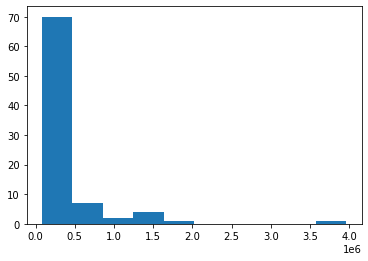

[  82644.   470691.1  858738.2 1246785.3 1634832.4 2022879.5 2410926.6
 2798973.7 3187020.8 3575067.9 3963115. ]
[70.  7.  2.  4.  1.  0.  0.  0.  0.  1.] 85.0


In [27]:
print(np.quantile(areas,0.95))
n,bins,_ = plt.hist([a for a in areas if a > np.quantile(areas,0.95)],bins=10)
plt.show()
print(bins)
print(n,n.sum())

In [51]:
gt_areas = []
for a in test['annotations']:
    gt_areas.append(a['area'])

In [66]:
#9581 4394 9864
#9581 3962 9864 283
count = 0
for k in es.keys():
    count += len(es[k]['boxes'])
print(count)

10033


In [62]:
count0 = 0
count1 = 0
for k in es.keys():
    for p in es[k]['tp_check']:
        if p == 0:
            count0 += 1
        else:
            count1 += 1

print(count0,count1)

7296 2737


In [ ]:
TP 8 FP 1 FN 4

AP25 8 /(8+1) = 
#0.25 
#1444 587 1005

In [ ]:

es = json.load(open('loose.json')) 
idx = 4520 
i,k = plot_fp_v2(str(idx),es[str(idx)]['boxes'])
print(i)
plt.figure(figsize=(20,10))
plt.imshow(i)

In [ ]:
fp_cases

In [20]:
#with open('fp_crack_boxes.json', 'w', encoding='utf-8') as f:
#    json.dump(fp_cases, f, ensure_ascii=False, indent=4)

In [21]:
fp_cases = json.load(open('fp_crack_boxes.json'))
fp_cases

{'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04ffb871b8cdcf7b0177336e3129d721dc68d1ab.jpg': [[[366,
    660],
   [408, 701]],
  [[103, 666], [536, 890]]],
 'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_32d11b4eb37e65e5c875e84c63907de4cd9e712d.jpg': [[[681,
    129],
   [1240, 388]]],
 'https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_detail_damage2_22020_medium_20190424_124819.jpg': [[[360,
    323],
   [379, 343]],
  [[389, 316], [400, 326]]],
 'https:__s3.amazonaws.com_mc-imt_vehicle_2018X6701_detail_damage1_16118_medium_image.jpg': [[[322,
    373],
   [404, 388]]],
 'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27dffe0771475c9e949fd0a688989ce61aaca28b.jpg': [[[735,
    713],
   [833, 776]],
  [[1089, 859], [1162, 933]]],
 'https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg': [[[958,
    354],
   [983, 388]]],
 'https:__s3.amazonaws.c

In [17]:
broken = json.load(open(path.parents[0]/'broken'/'annotations'/'total.json'))
print(len(broken['images']),len(broken['annotations']))

3527 4591


In [35]:
count = 0
for name in fp_cases.keys():
    imgs = [i for i in  broken['images'] if i['file_name']==name]
    
    if len(imgs) == 0:
        continue
    
    img = imgs[0]
    annos = [a['bbox'] for a in broken['annotations'] if a['image_id']==img['id']]
    image = cv2.imread(str(path/'images'/name))
    
    for i in range(len(annos)):
        annos[i] = [(int(annos[i][0]),int(annos[i][1])),(int(annos[i][2]),int(annos[i][3]))]
    
    for box in fp_cases[name]:
        ious = [cal_iou(image,box,a) for a in annos]
        print(ious)
        #print(count)
        #count +=1
    
    #print(annos)
    #break

[0, 0, 0]
[0, 0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0.022749157438613384]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0]
[0, 0.1657885748441636]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]


In [15]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948723.jpg'
i = [i for i in test['images'] if i['file_name']==name][0]
print(i)

{'id': 550, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'task_name': 'nothing', 'url': 'https://s3.amazonaws.com/mc-ai/dataset/KBC/unzipped/08/44012131907553/img2948723.jpg', 'width': 1152, 'height': 2048, 'file_name': 'https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948723.jpg', 'date_captured': '2013-12-15 02:41:52'}


In [17]:
annos = [a for a in test['annotations'] if a['image_id']==550]
print(annos)

[]


In [13]:
eb = json.load(open('ensemble_broken.json'))
print(len(eb.keys()))

3527


In [ ]:
2249 1046 1252
2207 928  1294
# detectoRS 1903 719 1598
# yolov4    1936 589 1565


#old 2314 1225 1187
#new 2241 1045 1260

In [ ]:
#######
'''
esemble predict for all broken datasets
592 3887 3999

esemble predict for all with smaller broken datasets
122 528 779
'''

In [ ]:
'''
DENT
detectoRS

TP    FP    FN
2012 1761 1489 AP=0.53 AR=0.57

yolov4
1937 1101 1564 AP = 0.63 AR=0.55

ensemble for dent
2120 1848 1381 AP=0.53 AR=0.6
2205 1733 1296 ap=0.56 AR=0.62
'''

In [27]:
581/(581+646)

0.47351263243683783

In [28]:
588/(588+639)

0.4792176039119804

In [65]:
idx = 23254
plot(idx, es[str(idx)]['boxes'])

KeyError: 'name'

In [21]:
def plot_annos(image_id):
    img = [i for i in test['images'] if i['id']==image_id][0]
    image = cv2.imread(str(path/'images'/img['file_name']))
    
    annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==image_id]
    cv2.drawContours(image,annos,-1,(255,255,0),2)
    
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==image_id]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        
    return image
    #plt.imshow(image)

In [33]:
from PIL import Image
es = json.load(open('dent_cbn_ensemle_yolo_m6_1_1_old_1408.json'))
test_path = Path('./cbn_yolo_dent')
test_path.mkdir(parents=True, exist_ok=True)
for i in tqdm(test['images']):
    idx = i['id']
    #cv2.imwrite(str(test_path)+'/'+str(i['id'])+'.png',plot_fp_v2(idx,es[str(idx)]['boxes']))
    #out = plot_fp_v2_with_segm(idx,es[str(idx)]['boxes'],es[str(idx)]['segms'])
    out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])
    #plt.figure(figsize=(20,10))
    #plt.imshow(out)
    if out is None:
        continue
    #if out.any() != None : 
    img = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    im_pil.save(str(test_path)+'/'+str(i['id'])+'.png',optimize=True,quality=70)
    #break
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2252/2252 [21:46<00:00,  1.72it/s]


In [40]:
for i,k in enumerate(es.keys()):
    #print(i)
    print(es[k]['segms'])
    if i == 2:
        break

[[[[[501, 2]], [[500, 3]], [[488, 3]], [[487, 4]], [[481, 4]], [[480, 5]], [[479, 5]], [[478, 6]], [[477, 6]], [[474, 9]], [[474, 15]], [[475, 16]], [[475, 18]], [[476, 19]], [[476, 22]], [[477, 23]], [[477, 24]], [[478, 25]], [[478, 27]], [[481, 30]], [[481, 31]], [[485, 35]], [[485, 36]], [[486, 37]], [[486, 38]], [[487, 39]], [[487, 40]], [[488, 41]], [[488, 42]], [[489, 43]], [[489, 45]], [[490, 46]], [[490, 49]], [[491, 50]], [[491, 53]], [[492, 54]], [[492, 57]], [[493, 58]], [[493, 60]], [[494, 61]], [[494, 62]], [[495, 63]], [[495, 64]], [[496, 65]], [[496, 66]], [[504, 74]], [[504, 75]], [[506, 77]], [[506, 78]], [[507, 79]], [[507, 81]], [[508, 82]], [[508, 85]], [[509, 86]], [[509, 90]], [[510, 91]], [[510, 95]], [[511, 96]], [[511, 98]], [[512, 99]], [[512, 101]], [[513, 102]], [[513, 103]], [[514, 104]], [[514, 106]], [[516, 108]], [[516, 109]], [[517, 110]], [[517, 111]], [[524, 118]], [[524, 119]], [[526, 121]], [[526, 122]], [[527, 123]], [[527, 124]], [[528, 125]], [[5

In [52]:
len(es.keys())

584

In [26]:
test_path = Path('./meeting/totaled')
test_path.mkdir(parents=True, exist_ok=True)
for i in test['images']:
    cv2.imwrite(str(test_path)+'/'+str(i['id'])+'.png',plot_annos(i['id']))

In [20]:
test['images'][0]

{'id': 195,
 'license': 4,
 'coco_url': 'coco.org',
 'flickr_url': 'flickr.org',
 'scalabel_url': 'https://s3.amazonaws.com/mc-imt/vehicle/2019A5704/detail_damage2/31993/medium/1572626634206839735194377895140.jpg',
 'width': 700,
 'height': 525,
 'file_name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2019A5704_detail_damage2_31993_medium_1572626634206839735194377895140.jpg',
 'date_captured': '2013-12-15 02:41:52'}

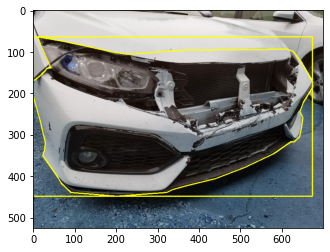

In [23]:
plot_annos(195)

In [15]:
es['2650']

{'name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2018T8083_front_left_view_5502_medium_image.jpg',
 'boxes': [],
 'labels': []}

In [ ]:
## iou_thres = 0.5
# 1: 1 590 778 
# 2: 1 592 776

## iou_thres = 0.25
# 2: 1 581 695 

# iou = 0.36 weight 2 : 1 0.4
#581 646 573                      AP= 0.47 AR=0.5 crack
#567 596 587                      AP= 0.49 AR=0.49
#587 640 598 area < 800 (31 more) 
#588 639 606 area < 1000 (40 more)

In [ ]:
461 351 691
497 377 840

In [35]:
def es_objective_hypertune(params):
    print(params)
    pred_data = json.load(open('detector_pred_04.json'))
    pred_data_flip = json.load(open('yolo_pred.json'))
    
    es = OrderedDict()
    for i in test['images']:
        boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
        scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
        labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]

        if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = []
            i_data['labels'] = []
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[0]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[1]
            i_data['labels'] = labels_list[1]
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[1]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[0]
            i_data['labels'] = labels_list[0]
            es[str(i['id'])] = i_data
            continue
        # tuning here
        weights = [params['weight']+1,1]
        iou_thr = params['threshold']
        skip_box_thr = 0.0001
        sigma = 0.1

        boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes.tolist()
        i_data['labels'] = labels.tolist()
        es[str(i['id'])] = i_data

    total_tp = 0
    total_fn = 0
    total_fp = 0
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]

        pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
        for j in range(len(pred_boxes)):
            pred_boxes[j][0] = int(pred_boxes[j][0]*w)
            pred_boxes[j][1] = int(pred_boxes[j][1]*h)
            pred_boxes[j][2] = int(pred_boxes[j][2]*w)
            pred_boxes[j][3] = int(pred_boxes[j][3]*h)

            pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
        pred_labels = es[str(i['id'])]['labels']

        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
    print(total_tp,total_fp)
    return total_fp - 2*total_tp

def tuning():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'threshold' : hp.uniform('threshold',0.2,0.6),
            'weight' : hp.randint('weight',5),
            }
    result = fmin(fn=objective_hypertune, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result
    

In [ ]:
def score_oh(params):
    total_tp = 0
    total_fn = 0
    total_fp = 0
    
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
        
        result = inference_detector(model, image.copy())
        img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=params['confident_score'])
        
        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
    print("{} - TP : {} ,FP : {}, AP : {}".format(params['confident_score'],total_tp,total_fp,total_tp/(total_tp+total_fp)))
    
    return total_fp/(total_tp+total_fp)

def tuning_confident():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'confident_score' : hp.uniform('confident_score',0.2,0.5),
            }
    result = fmin(fn=score_oh, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result

print(tuning_confident())

0.4268592110572746 - TP : 443 ,FP : 355, AP : 0.5551378446115288
0.4789813947478013 - TP : 433 ,FP : 318, AP : 0.5765645805592543                   
 13%|█▎        | 2/15 [11:14<1:13:03, 337.22s/trial, best loss: 0.4234354194407457]

In [ ]:
#0.47680153265311676-423-332 
#0.46405537190928414 - TP : 425 ,FP : 339, AP : 0.556282722513089 

In [36]:
print(tuning())

{'threshold': 0.20186076643958806, 'weight': 1}       
569                                                   
602                                                   
{'threshold': 0.5889840584415416, 'weight': 0}                      
581                                                                 
725                                                                 
{'threshold': 0.34653284314044225, 'weight': 1}                     
579                                                                 
643                                                                 
{'threshold': 0.5142339445566273, 'weight': 2}                      
578                                                                 
695                                                                 
{'threshold': 0.5506285420334487, 'weight': 3}                      
579                                                                 
709                                                                 
{'thres

In [ ]:
# 0.3 {'threshold': 0.2003033575511911, 'weight': 0}
# 0.4 {'threshold': 0.36257411346807455, 'weight': 1}

In [ ]:
coco_js = json.load(open('new_and_ensemble_dent.json'))
out = []
for k in tqdm(coco_js.keys()):
    if len(coco_js[k]['boxes']) == 0:
        continue
    img = cv2.imread(str(path/'images'/coco_js[k]['image']))
    h,w = img.shape[:2]
    
    #print(box['bbox'])
    for i,b in enumerate(coco_js[k]['boxes']):
        box = OrderedDict()
        box['image_id'] = int(k)
        box['category_id'] = 0
        #box['bbox'] = 
        #print(b,i)
        #print(coco_js[k]['scores'][i])
        box['bbox'] = [b[0]*w,b[1]*h,(b[2]-b[0])*w,(b[3]-b[1])*h]
        box['score'] = coco_js[k]['scores'][i]
        #print(box)
        #break
        out.append(box)
    #print(box['bbox'])
    #break
    
with open('ensemble_dent_coco_eval.json', 'w') as f:
    json.dump(out, f)

In [31]:
from pycocotools.coco import COCO
from fast_eval_api import COCOeval_opt as COCOeval

In [41]:
imgIds = [i['id'] for i in test['images']]
cocoGt = COCO(str(path/'annotations'/'test.json'))
#print(cocoGt)
cocoDt = cocoGt.loadRes('ensemble_dent_coco_eval.json')
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDet

In [43]:
print(test['categories'])
print(len(test['images']),len(test['annotations']))

[{'supercategory': 'Carparts', 'id': 0, 'name': 'dent'}]
2252 3501


In [44]:
import random
imgs = random.sample(test['images'],10)
ids = [i['id'] for i in imgs]
annos = [a for a in test['annotations'] if a['image_id'] in ids]
print(len(imgs),len(annos))

10 12


In [45]:
tiny_test = copy.deepcopy(test)
tiny_test['images'] = imgs
tiny_test['annotations'] = annos

In [46]:
with open('tiny_dent_test.json', 'w', encoding='utf-8') as f:
    json.dump(tiny_test, f, ensure_ascii=False, indent=4)

In [48]:
demo_test = json.load(open('tiny_dent_test.json'))
print(len(demo_test['images']),len(demo_test['annotations']))

10 12


In [83]:
data = OrderedDict()

for i in tqdm(demo_test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.25)
    data[i['id']] = get_data_box(image,i['id'],i['file_name'],pred_boxes,pred_segms,pred_labels,pred_scores)
    #break
with open('demo_test_dent_coco_eval.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


In [10]:
coco_js = json.load(open('demo_test_dent_coco_eval.json'))
out = []
for k in tqdm(coco_js.keys()):
    if len(coco_js[k]['boxes']) == 0:
        continue
    img = cv2.imread(str(path/'images'/coco_js[k]['image']))
    h,w = img.shape[:2]
    
    #print(box['bbox'])
    for i,b in enumerate(coco_js[k]['boxes']):
        box = OrderedDict()
        box['image_id'] = int(k)
        box['category_id'] = 0
        #box['bbox'] = 
        #print(b,i)
        #print(coco_js[k]['scores'][i])
        box['bbox'] = [b[0]*w,b[1]*h,(b[2]-b[0])*w,(b[3]-b[1])*h]
        box['score'] = coco_js[k]['scores'][i]
        #print(box)
        #break
        out.append(box)
    #print(box['bbox'])
    #break
print('number of predict :',len(out))
with open('ensemble_demo_test_dent_coco_eval.json', 'w') as f:
    json.dump(out, f)

100%|██████████| 10/10 [00:00<00:00, 46.34it/s]

number of predict : 11


In [13]:
from pycocotools.coco import COCO
from fast_eval_api import COCOeval_opt as COCOeval

imgIds = [i['id'] for i in test['images']]
cocoGt = COCO('tiny_dent_test.json')
#print(cocoGt)
cocoDt = cocoGt.loadRes('ensemble_demo_test_dent_coco_eval.json')
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.params.catIds = [0]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDet